In [20]:
"""
CatBoost Experiments Serrano/AUDSOME Phase 1
Gabriel Iuhasz

Single Model experiment based on HPO optimization

Anomaly Only
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from subprocess import check_output
# from sklearn.externals import joblib
from joblib import dump, load
from catboost import CatBoostClassifier
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

# TODO check deprecation warning xgboost
import warnings
warnings.filterwarnings('ignore')

print("Checking files in data location ...")
train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [21]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)


def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)

def save_valid_curve_scores(viz, param, param_range, fname):
    """
    :param viz: yellowbrick viz object
    :param param: parameter name used in validation curve
    :param fname: mL_method used
    :return: dataframe with crossvalidation scores for param and param range set by user
    """
    columns = []
    for f in range(viz.cv.n_splits):
        columns.append(f"Fold{f}")
    scores = viz.test_scores_
    df_scores = pd.DataFrame(scores, index=param_range, columns=columns)
    df_scores.to_csv(os.path.join(model_dir, f"{fname}_{param}_validationcurve_scores.csv"))
    return df_scores

Setting paths and datasets


In [22]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

# Dirty fix for df_clean_audsome
df_clean_audsome.drop(['target_cpu_master',
       'target_mem_master', 'target_copy_master', 'target_ddot_master'], axis=1, inplace=True)
print("Dataset chosen ...")
data = df_anomaly
# drop_col = ['t1','t2','t3','t4']
print("Remove unwanted columns ...")
# print("Shape before drop: {}".format(data.shape))
# data.drop(drop_col, axis=1, inplace=True)
# print("Shape after drop: {}".format(data.shape))

Dataset chosen ...
Remove unwanted columns ...


In [23]:
# Nice print
nice_y = data['target']

# Uncomment for removing dummy
# print("Removed Dummy class")
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

Ploting class distribution ..


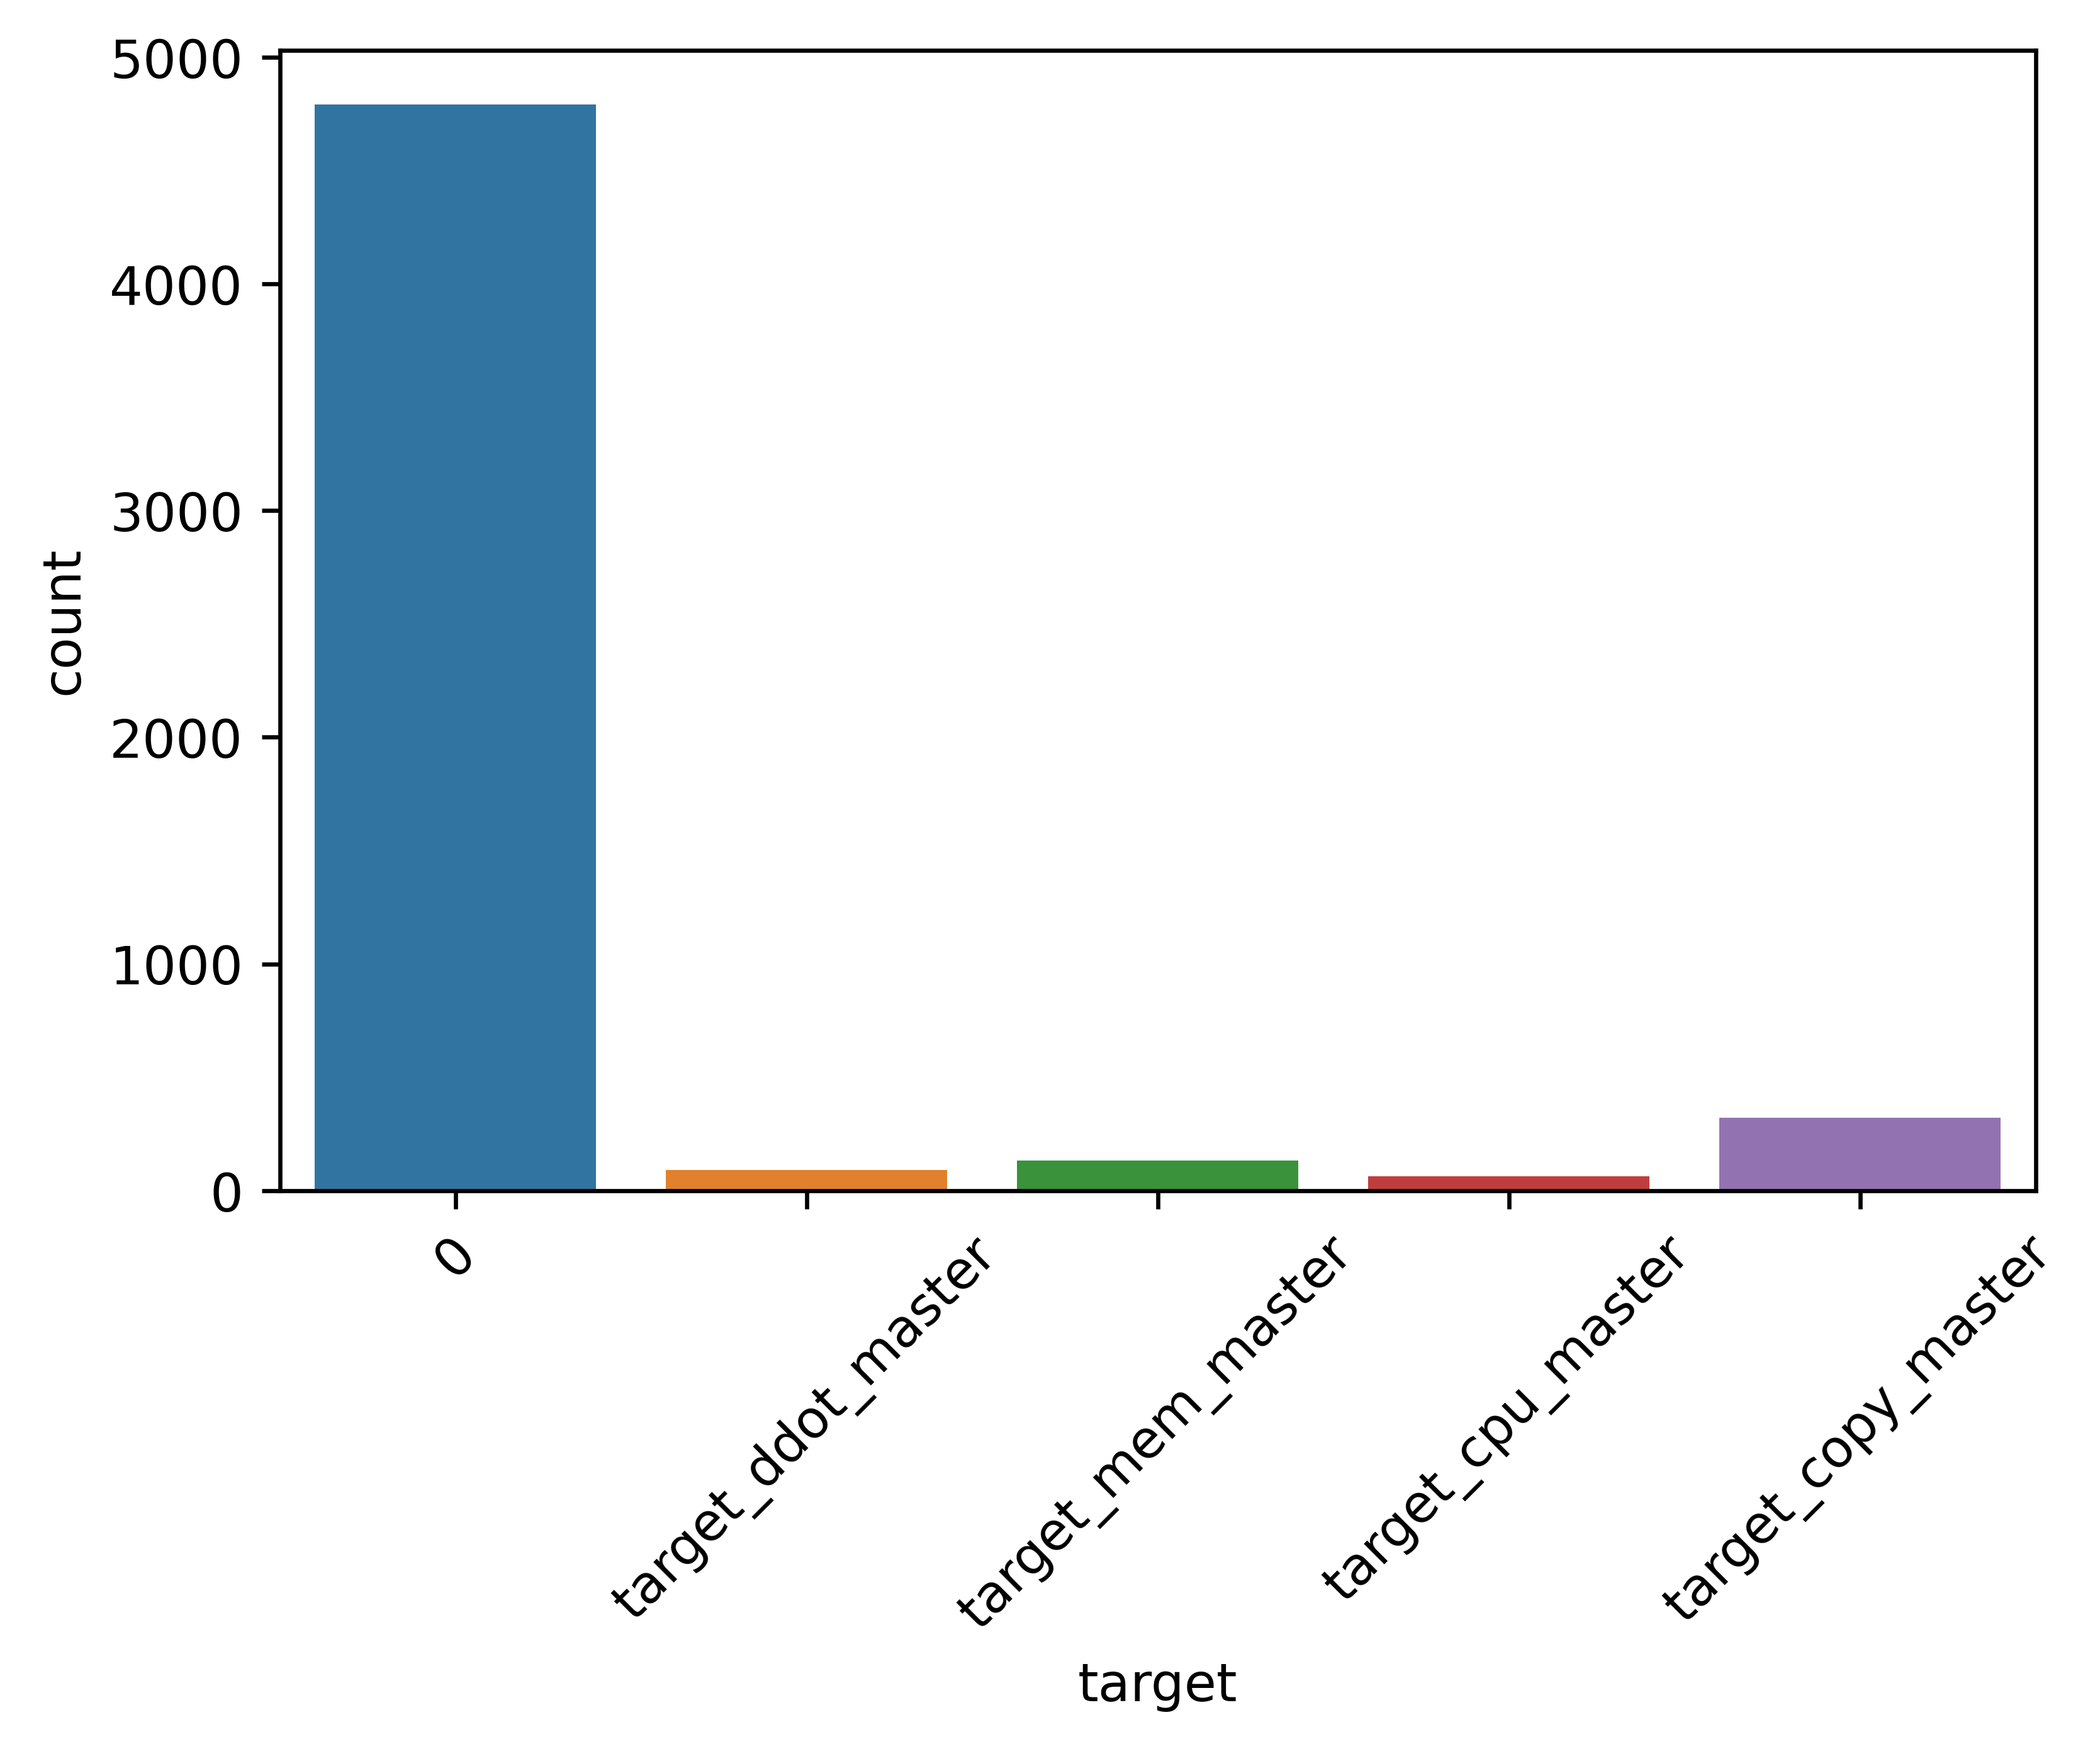

In [24]:
# Plot class distribution
print("Ploting class distribution ..")
plt.figure(dpi=600) #For publication only
class_dist_plot = sns.countplot(nice_y)
class_dist_plot.set_xticklabels(class_dist_plot.get_xticklabels(), rotation=45)
fig_cd = class_dist_plot.get_figure()
fig_cd.savefig(os.path.join(model_dir,"class_dist_single_anomaly.png"), bbox_inches='tight')

In [25]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


In [26]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) #

Scaling dataset


In [27]:
# Randomforest best performing

params = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2}



clf = CatBoostClassifier()
clf.get_params().keys()

dict_keys([])

Starting fold 1
Scaling data ....
Start training ....
Learning rate set to 0.084977
0:	learn: 1.3140584	total: 17.3ms	remaining: 17.3s
1:	learn: 1.1173323	total: 42.3ms	remaining: 21.1s
2:	learn: 0.9667576	total: 49.8ms	remaining: 16.6s
3:	learn: 0.8441416	total: 57.1ms	remaining: 14.2s
4:	learn: 0.7452240	total: 64.6ms	remaining: 12.9s
5:	learn: 0.6631614	total: 73.1ms	remaining: 12.1s
6:	learn: 0.5924449	total: 80.9ms	remaining: 11.5s
7:	learn: 0.5326954	total: 89.5ms	remaining: 11.1s
8:	learn: 0.4809406	total: 97.1ms	remaining: 10.7s
9:	learn: 0.4366885	total: 104ms	remaining: 10.3s
10:	learn: 0.3970100	total: 111ms	remaining: 10s
11:	learn: 0.3610128	total: 119ms	remaining: 9.84s
12:	learn: 0.3297572	total: 127ms	remaining: 9.66s
13:	learn: 0.3012790	total: 135ms	remaining: 9.51s
14:	learn: 0.2751311	total: 143ms	remaining: 9.38s
15:	learn: 0.2522296	total: 151ms	remaining: 9.29s
16:	learn: 0.2314621	total: 158ms	remaining: 9.14s
17:	learn: 0.2127647	total: 166ms	remaining: 9.05s
1

171:	learn: 0.0094986	total: 1.36s	remaining: 6.56s
172:	learn: 0.0093787	total: 1.37s	remaining: 6.55s
173:	learn: 0.0093242	total: 1.38s	remaining: 6.54s
174:	learn: 0.0092652	total: 1.39s	remaining: 6.54s
175:	learn: 0.0092452	total: 1.4s	remaining: 6.53s
176:	learn: 0.0091767	total: 1.4s	remaining: 6.53s
177:	learn: 0.0090707	total: 1.41s	remaining: 6.51s
178:	learn: 0.0089744	total: 1.42s	remaining: 6.5s
179:	learn: 0.0088950	total: 1.43s	remaining: 6.5s
180:	learn: 0.0088701	total: 1.43s	remaining: 6.49s
181:	learn: 0.0088314	total: 1.44s	remaining: 6.48s
182:	learn: 0.0087929	total: 1.45s	remaining: 6.47s
183:	learn: 0.0087703	total: 1.46s	remaining: 6.46s
184:	learn: 0.0087247	total: 1.46s	remaining: 6.45s
185:	learn: 0.0086847	total: 1.47s	remaining: 6.44s
186:	learn: 0.0086583	total: 1.48s	remaining: 6.43s
187:	learn: 0.0085890	total: 1.49s	remaining: 6.42s
188:	learn: 0.0085745	total: 1.49s	remaining: 6.41s
189:	learn: 0.0085477	total: 1.5s	remaining: 6.4s
190:	learn: 0.0085

340:	learn: 0.0040908	total: 2.76s	remaining: 5.34s
341:	learn: 0.0040830	total: 2.77s	remaining: 5.33s
342:	learn: 0.0040618	total: 2.78s	remaining: 5.32s
343:	learn: 0.0040564	total: 2.79s	remaining: 5.31s
344:	learn: 0.0040346	total: 2.79s	remaining: 5.3s
345:	learn: 0.0040148	total: 2.81s	remaining: 5.3s
346:	learn: 0.0039986	total: 2.81s	remaining: 5.29s
347:	learn: 0.0039755	total: 2.82s	remaining: 5.28s
348:	learn: 0.0039696	total: 2.83s	remaining: 5.27s
349:	learn: 0.0039654	total: 2.83s	remaining: 5.26s
350:	learn: 0.0039484	total: 2.84s	remaining: 5.25s
351:	learn: 0.0039147	total: 2.85s	remaining: 5.24s
352:	learn: 0.0039098	total: 2.85s	remaining: 5.23s
353:	learn: 0.0039036	total: 2.86s	remaining: 5.22s
354:	learn: 0.0038896	total: 2.87s	remaining: 5.21s
355:	learn: 0.0038850	total: 2.88s	remaining: 5.2s
356:	learn: 0.0038750	total: 2.88s	remaining: 5.19s
357:	learn: 0.0038687	total: 2.89s	remaining: 5.18s
358:	learn: 0.0038549	total: 2.9s	remaining: 5.17s
359:	learn: 0.00

525:	learn: 0.0022337	total: 4.16s	remaining: 3.75s
526:	learn: 0.0022262	total: 4.17s	remaining: 3.74s
527:	learn: 0.0022229	total: 4.18s	remaining: 3.73s
528:	learn: 0.0022198	total: 4.18s	remaining: 3.73s
529:	learn: 0.0022117	total: 4.19s	remaining: 3.72s
530:	learn: 0.0022063	total: 4.2s	remaining: 3.71s
531:	learn: 0.0021995	total: 4.21s	remaining: 3.7s
532:	learn: 0.0021904	total: 4.21s	remaining: 3.69s
533:	learn: 0.0021834	total: 4.22s	remaining: 3.68s
534:	learn: 0.0021714	total: 4.23s	remaining: 3.68s
535:	learn: 0.0021694	total: 4.24s	remaining: 3.67s
536:	learn: 0.0021639	total: 4.25s	remaining: 3.66s
537:	learn: 0.0021579	total: 4.25s	remaining: 3.65s
538:	learn: 0.0021554	total: 4.26s	remaining: 3.65s
539:	learn: 0.0021494	total: 4.27s	remaining: 3.64s
540:	learn: 0.0021446	total: 4.28s	remaining: 3.63s
541:	learn: 0.0021435	total: 4.28s	remaining: 3.62s
542:	learn: 0.0021424	total: 4.29s	remaining: 3.61s
543:	learn: 0.0021381	total: 4.3s	remaining: 3.6s
544:	learn: 0.00

685:	learn: 0.0015485	total: 5.37s	remaining: 2.46s
686:	learn: 0.0015476	total: 5.38s	remaining: 2.45s
687:	learn: 0.0015465	total: 5.39s	remaining: 2.44s
688:	learn: 0.0015437	total: 5.39s	remaining: 2.44s
689:	learn: 0.0015368	total: 5.4s	remaining: 2.43s
690:	learn: 0.0015338	total: 5.41s	remaining: 2.42s
691:	learn: 0.0015275	total: 5.42s	remaining: 2.41s
692:	learn: 0.0015256	total: 5.43s	remaining: 2.4s
693:	learn: 0.0015237	total: 5.43s	remaining: 2.4s
694:	learn: 0.0015199	total: 5.44s	remaining: 2.39s
695:	learn: 0.0015182	total: 5.45s	remaining: 2.38s
696:	learn: 0.0015148	total: 5.45s	remaining: 2.37s
697:	learn: 0.0015131	total: 5.46s	remaining: 2.36s
698:	learn: 0.0015106	total: 5.47s	remaining: 2.35s
699:	learn: 0.0015087	total: 5.48s	remaining: 2.35s
700:	learn: 0.0015070	total: 5.48s	remaining: 2.34s
701:	learn: 0.0014998	total: 5.49s	remaining: 2.33s
702:	learn: 0.0014966	total: 5.5s	remaining: 2.32s
703:	learn: 0.0014934	total: 5.51s	remaining: 2.31s
704:	learn: 0.00

870:	learn: 0.0011441	total: 6.78s	remaining: 1s
871:	learn: 0.0011419	total: 6.79s	remaining: 996ms
872:	learn: 0.0011399	total: 6.79s	remaining: 989ms
873:	learn: 0.0011384	total: 6.8s	remaining: 981ms
874:	learn: 0.0011360	total: 6.81s	remaining: 973ms
875:	learn: 0.0011338	total: 6.82s	remaining: 965ms
876:	learn: 0.0011334	total: 6.83s	remaining: 957ms
877:	learn: 0.0011319	total: 6.83s	remaining: 949ms
878:	learn: 0.0011314	total: 6.84s	remaining: 942ms
879:	learn: 0.0011300	total: 6.85s	remaining: 934ms
880:	learn: 0.0011291	total: 6.86s	remaining: 926ms
881:	learn: 0.0011285	total: 6.86s	remaining: 918ms
882:	learn: 0.0011268	total: 6.87s	remaining: 910ms
883:	learn: 0.0011249	total: 6.88s	remaining: 903ms
884:	learn: 0.0011227	total: 6.88s	remaining: 895ms
885:	learn: 0.0011219	total: 6.89s	remaining: 887ms
886:	learn: 0.0011152	total: 6.9s	remaining: 879ms
887:	learn: 0.0011147	total: 6.91s	remaining: 871ms
888:	learn: 0.0011136	total: 6.91s	remaining: 863ms
889:	learn: 0.001

Saving imbalanced classification report
Generating confusion matrix fold 1


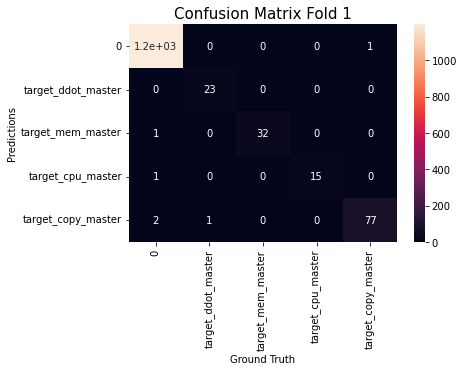

Extracting Feature improtance ...


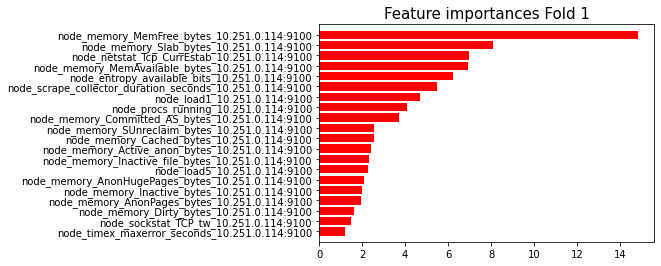

####################################################################################################
Starting fold 2
Scaling data ....
Start training ....
Learning rate set to 0.084977
0:	learn: 1.3164431	total: 20.2ms	remaining: 20.2s
1:	learn: 1.1138249	total: 26.7ms	remaining: 13.3s
2:	learn: 0.9652542	total: 41.4ms	remaining: 13.8s
3:	learn: 0.8446682	total: 50.4ms	remaining: 12.5s
4:	learn: 0.7485707	total: 57.9ms	remaining: 11.5s
5:	learn: 0.6664275	total: 66.4ms	remaining: 11s
6:	learn: 0.5972394	total: 74.5ms	remaining: 10.6s
7:	learn: 0.5351848	total: 82ms	remaining: 10.2s
8:	learn: 0.4809546	total: 91.2ms	remaining: 10s
9:	learn: 0.4361858	total: 98.9ms	remaining: 9.79s
10:	learn: 0.3955372	total: 108ms	remaining: 9.69s
11:	learn: 0.3612878	total: 116ms	remaining: 9.55s
12:	learn: 0.3304719	total: 124ms	remaining: 9.43s
13:	learn: 0.3024734	total: 132ms	remaining: 9.27s
14:	learn: 0.2777612	total: 139ms	remaining: 9.14s
15:	learn: 0.2552904	total: 147ms	remaining: 9.05s
16:	l

182:	learn: 0.0100150	total: 1.61s	remaining: 7.18s
183:	learn: 0.0099895	total: 1.62s	remaining: 7.17s
184:	learn: 0.0099479	total: 1.63s	remaining: 7.16s
185:	learn: 0.0099074	total: 1.63s	remaining: 7.15s
186:	learn: 0.0098095	total: 1.64s	remaining: 7.14s
187:	learn: 0.0097679	total: 1.65s	remaining: 7.13s
188:	learn: 0.0097418	total: 1.66s	remaining: 7.1s
189:	learn: 0.0096908	total: 1.66s	remaining: 7.09s
190:	learn: 0.0096716	total: 1.67s	remaining: 7.08s
191:	learn: 0.0096366	total: 1.68s	remaining: 7.07s
192:	learn: 0.0095718	total: 1.69s	remaining: 7.05s
193:	learn: 0.0095342	total: 1.7s	remaining: 7.04s
194:	learn: 0.0094912	total: 1.7s	remaining: 7.04s
195:	learn: 0.0094532	total: 1.71s	remaining: 7.03s
196:	learn: 0.0094329	total: 1.72s	remaining: 7.01s
197:	learn: 0.0093950	total: 1.73s	remaining: 7s
198:	learn: 0.0093346	total: 1.73s	remaining: 6.98s
199:	learn: 0.0092353	total: 1.74s	remaining: 6.96s
200:	learn: 0.0091812	total: 1.75s	remaining: 6.95s
201:	learn: 0.0091

353:	learn: 0.0044096	total: 3.03s	remaining: 5.53s
354:	learn: 0.0043934	total: 3.04s	remaining: 5.52s
355:	learn: 0.0043789	total: 3.05s	remaining: 5.51s
356:	learn: 0.0043557	total: 3.06s	remaining: 5.51s
357:	learn: 0.0043268	total: 3.07s	remaining: 5.5s
358:	learn: 0.0042950	total: 3.08s	remaining: 5.5s
359:	learn: 0.0042794	total: 3.09s	remaining: 5.49s
360:	learn: 0.0042602	total: 3.1s	remaining: 5.48s
361:	learn: 0.0042540	total: 3.1s	remaining: 5.47s
362:	learn: 0.0042440	total: 3.11s	remaining: 5.46s
363:	learn: 0.0042196	total: 3.12s	remaining: 5.46s
364:	learn: 0.0041999	total: 3.13s	remaining: 5.45s
365:	learn: 0.0041778	total: 3.14s	remaining: 5.44s
366:	learn: 0.0041608	total: 3.15s	remaining: 5.43s
367:	learn: 0.0041520	total: 3.17s	remaining: 5.44s
368:	learn: 0.0041213	total: 3.17s	remaining: 5.43s
369:	learn: 0.0041079	total: 3.18s	remaining: 5.42s
370:	learn: 0.0040961	total: 3.19s	remaining: 5.41s
371:	learn: 0.0040771	total: 3.2s	remaining: 5.4s
372:	learn: 0.0040

521:	learn: 0.0025016	total: 4.42s	remaining: 4.05s
522:	learn: 0.0024983	total: 4.43s	remaining: 4.04s
523:	learn: 0.0024928	total: 4.43s	remaining: 4.03s
524:	learn: 0.0024871	total: 4.44s	remaining: 4.02s
525:	learn: 0.0024808	total: 4.45s	remaining: 4.01s
526:	learn: 0.0024718	total: 4.46s	remaining: 4s
527:	learn: 0.0024673	total: 4.47s	remaining: 3.99s
528:	learn: 0.0024598	total: 4.47s	remaining: 3.98s
529:	learn: 0.0024522	total: 4.48s	remaining: 3.97s
530:	learn: 0.0024453	total: 4.49s	remaining: 3.97s
531:	learn: 0.0024399	total: 4.5s	remaining: 3.96s
532:	learn: 0.0024360	total: 4.51s	remaining: 3.95s
533:	learn: 0.0024300	total: 4.51s	remaining: 3.94s
534:	learn: 0.0024252	total: 4.52s	remaining: 3.93s
535:	learn: 0.0024188	total: 4.53s	remaining: 3.92s
536:	learn: 0.0024122	total: 4.54s	remaining: 3.91s
537:	learn: 0.0024085	total: 4.55s	remaining: 3.9s
538:	learn: 0.0024047	total: 4.56s	remaining: 3.9s
539:	learn: 0.0023937	total: 4.56s	remaining: 3.89s
540:	learn: 0.0023

691:	learn: 0.0016964	total: 5.83s	remaining: 2.59s
692:	learn: 0.0016938	total: 5.83s	remaining: 2.58s
693:	learn: 0.0016923	total: 5.84s	remaining: 2.58s
694:	learn: 0.0016896	total: 5.85s	remaining: 2.57s
695:	learn: 0.0016852	total: 5.86s	remaining: 2.56s
696:	learn: 0.0016807	total: 5.87s	remaining: 2.55s
697:	learn: 0.0016778	total: 5.87s	remaining: 2.54s
698:	learn: 0.0016758	total: 5.88s	remaining: 2.53s
699:	learn: 0.0016729	total: 5.89s	remaining: 2.52s
700:	learn: 0.0016689	total: 5.9s	remaining: 2.51s
701:	learn: 0.0016664	total: 5.9s	remaining: 2.51s
702:	learn: 0.0016627	total: 5.91s	remaining: 2.5s
703:	learn: 0.0016604	total: 5.92s	remaining: 2.49s
704:	learn: 0.0016584	total: 5.93s	remaining: 2.48s
705:	learn: 0.0016545	total: 5.93s	remaining: 2.47s
706:	learn: 0.0016506	total: 5.94s	remaining: 2.46s
707:	learn: 0.0016480	total: 5.95s	remaining: 2.45s
708:	learn: 0.0016430	total: 5.96s	remaining: 2.44s
709:	learn: 0.0016414	total: 5.96s	remaining: 2.44s
710:	learn: 0.0

872:	learn: 0.0012693	total: 7.22s	remaining: 1.05s
873:	learn: 0.0012679	total: 7.23s	remaining: 1.04s
874:	learn: 0.0012639	total: 7.24s	remaining: 1.03s
875:	learn: 0.0012616	total: 7.25s	remaining: 1.02s
876:	learn: 0.0012598	total: 7.25s	remaining: 1.02s
877:	learn: 0.0012583	total: 7.26s	remaining: 1.01s
878:	learn: 0.0012567	total: 7.27s	remaining: 1s
879:	learn: 0.0012544	total: 7.27s	remaining: 992ms
880:	learn: 0.0012509	total: 7.28s	remaining: 984ms
881:	learn: 0.0012492	total: 7.29s	remaining: 975ms
882:	learn: 0.0012479	total: 7.29s	remaining: 967ms
883:	learn: 0.0012457	total: 7.3s	remaining: 958ms
884:	learn: 0.0012433	total: 7.31s	remaining: 950ms
885:	learn: 0.0012416	total: 7.32s	remaining: 942ms
886:	learn: 0.0012386	total: 7.33s	remaining: 933ms
887:	learn: 0.0012373	total: 7.33s	remaining: 925ms
888:	learn: 0.0012363	total: 7.34s	remaining: 916ms
889:	learn: 0.0012336	total: 7.35s	remaining: 908ms
890:	learn: 0.0012314	total: 7.36s	remaining: 900ms
891:	learn: 0.00

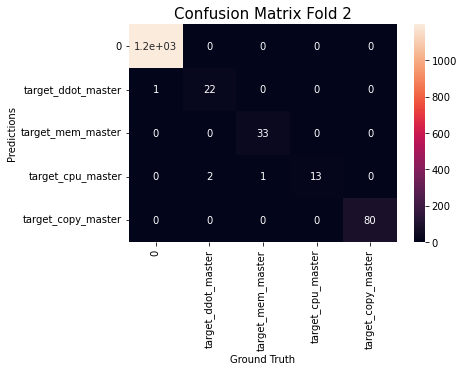

Extracting Feature improtance ...


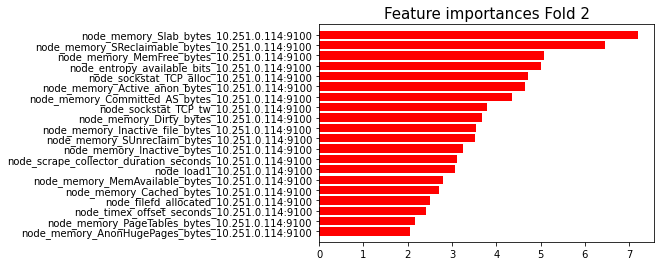

####################################################################################################
Starting fold 3
Scaling data ....
Start training ....
Learning rate set to 0.084977
0:	learn: 1.3086289	total: 11ms	remaining: 11s
1:	learn: 1.1083185	total: 18.1ms	remaining: 9.02s
2:	learn: 0.9603839	total: 25.3ms	remaining: 8.41s
3:	learn: 0.8414491	total: 36ms	remaining: 8.95s
4:	learn: 0.7433799	total: 44.7ms	remaining: 8.9s
5:	learn: 0.6641628	total: 53.9ms	remaining: 8.93s
6:	learn: 0.5941915	total: 61.3ms	remaining: 8.7s
7:	learn: 0.5353327	total: 69.5ms	remaining: 8.62s
8:	learn: 0.4830998	total: 77.3ms	remaining: 8.52s
9:	learn: 0.4378577	total: 85.2ms	remaining: 8.43s
10:	learn: 0.3978367	total: 96.2ms	remaining: 8.65s
11:	learn: 0.3632709	total: 104ms	remaining: 8.58s
12:	learn: 0.3306690	total: 112ms	remaining: 8.49s
13:	learn: 0.3027002	total: 120ms	remaining: 8.43s
14:	learn: 0.2774911	total: 127ms	remaining: 8.35s
15:	learn: 0.2543599	total: 135ms	remaining: 8.29s
16:	le

172:	learn: 0.0097482	total: 1.39s	remaining: 6.63s
173:	learn: 0.0097017	total: 1.39s	remaining: 6.62s
174:	learn: 0.0096544	total: 1.4s	remaining: 6.61s
175:	learn: 0.0096376	total: 1.41s	remaining: 6.59s
176:	learn: 0.0096226	total: 1.42s	remaining: 6.58s
177:	learn: 0.0095811	total: 1.42s	remaining: 6.57s
178:	learn: 0.0095032	total: 1.43s	remaining: 6.55s
179:	learn: 0.0094761	total: 1.44s	remaining: 6.54s
180:	learn: 0.0094285	total: 1.44s	remaining: 6.53s
181:	learn: 0.0093795	total: 1.45s	remaining: 6.52s
182:	learn: 0.0093541	total: 1.46s	remaining: 6.5s
183:	learn: 0.0093073	total: 1.46s	remaining: 6.49s
184:	learn: 0.0092665	total: 1.47s	remaining: 6.49s
185:	learn: 0.0091998	total: 1.48s	remaining: 6.47s
186:	learn: 0.0091735	total: 1.49s	remaining: 6.46s
187:	learn: 0.0091318	total: 1.49s	remaining: 6.45s
188:	learn: 0.0090520	total: 1.5s	remaining: 6.44s
189:	learn: 0.0089958	total: 1.51s	remaining: 6.42s
190:	learn: 0.0089499	total: 1.51s	remaining: 6.42s
191:	learn: 0.0

333:	learn: 0.0043935	total: 2.58s	remaining: 5.15s
334:	learn: 0.0043740	total: 2.59s	remaining: 5.14s
335:	learn: 0.0043431	total: 2.6s	remaining: 5.14s
336:	learn: 0.0043091	total: 2.61s	remaining: 5.13s
337:	learn: 0.0042917	total: 2.61s	remaining: 5.12s
338:	learn: 0.0042809	total: 2.62s	remaining: 5.11s
339:	learn: 0.0042708	total: 2.63s	remaining: 5.1s
340:	learn: 0.0042652	total: 2.64s	remaining: 5.09s
341:	learn: 0.0042385	total: 2.64s	remaining: 5.08s
342:	learn: 0.0042270	total: 2.65s	remaining: 5.08s
343:	learn: 0.0042103	total: 2.66s	remaining: 5.07s
344:	learn: 0.0042005	total: 2.67s	remaining: 5.06s
345:	learn: 0.0041927	total: 2.67s	remaining: 5.05s
346:	learn: 0.0041721	total: 2.68s	remaining: 5.04s
347:	learn: 0.0041509	total: 2.69s	remaining: 5.03s
348:	learn: 0.0041409	total: 2.69s	remaining: 5.03s
349:	learn: 0.0041130	total: 2.7s	remaining: 5.02s
350:	learn: 0.0040909	total: 2.71s	remaining: 5.01s
351:	learn: 0.0040559	total: 2.71s	remaining: 5s
352:	learn: 0.0040

494:	learn: 0.0024424	total: 3.79s	remaining: 3.87s
495:	learn: 0.0024377	total: 3.79s	remaining: 3.86s
496:	learn: 0.0024332	total: 3.8s	remaining: 3.85s
497:	learn: 0.0024292	total: 3.81s	remaining: 3.84s
498:	learn: 0.0024244	total: 3.82s	remaining: 3.83s
499:	learn: 0.0024134	total: 3.83s	remaining: 3.83s
500:	learn: 0.0024041	total: 3.83s	remaining: 3.82s
501:	learn: 0.0023909	total: 3.84s	remaining: 3.81s
502:	learn: 0.0023864	total: 3.85s	remaining: 3.8s
503:	learn: 0.0023813	total: 3.85s	remaining: 3.79s
504:	learn: 0.0023717	total: 3.86s	remaining: 3.79s
505:	learn: 0.0023644	total: 3.87s	remaining: 3.78s
506:	learn: 0.0023583	total: 3.88s	remaining: 3.77s
507:	learn: 0.0023476	total: 3.89s	remaining: 3.77s
508:	learn: 0.0023426	total: 3.89s	remaining: 3.76s
509:	learn: 0.0023400	total: 3.9s	remaining: 3.75s
510:	learn: 0.0023324	total: 3.91s	remaining: 3.74s
511:	learn: 0.0023223	total: 3.92s	remaining: 3.73s
512:	learn: 0.0023150	total: 3.92s	remaining: 3.72s
513:	learn: 0.0

674:	learn: 0.0015869	total: 5.19s	remaining: 2.5s
675:	learn: 0.0015805	total: 5.2s	remaining: 2.49s
676:	learn: 0.0015779	total: 5.21s	remaining: 2.48s
677:	learn: 0.0015746	total: 5.21s	remaining: 2.48s
678:	learn: 0.0015713	total: 5.22s	remaining: 2.47s
679:	learn: 0.0015678	total: 5.23s	remaining: 2.46s
680:	learn: 0.0015663	total: 5.24s	remaining: 2.45s
681:	learn: 0.0015649	total: 5.25s	remaining: 2.45s
682:	learn: 0.0015598	total: 5.25s	remaining: 2.44s
683:	learn: 0.0015580	total: 5.27s	remaining: 2.43s
684:	learn: 0.0015548	total: 5.28s	remaining: 2.43s
685:	learn: 0.0015521	total: 5.29s	remaining: 2.42s
686:	learn: 0.0015499	total: 5.29s	remaining: 2.41s
687:	learn: 0.0015474	total: 5.3s	remaining: 2.4s
688:	learn: 0.0015451	total: 5.31s	remaining: 2.4s
689:	learn: 0.0015416	total: 5.32s	remaining: 2.39s
690:	learn: 0.0015396	total: 5.33s	remaining: 2.38s
691:	learn: 0.0015364	total: 5.34s	remaining: 2.38s
692:	learn: 0.0015349	total: 5.35s	remaining: 2.37s
693:	learn: 0.001

855:	learn: 0.0011774	total: 6.59s	remaining: 1.11s
856:	learn: 0.0011759	total: 6.59s	remaining: 1.1s
857:	learn: 0.0011727	total: 6.61s	remaining: 1.09s
858:	learn: 0.0011713	total: 6.62s	remaining: 1.09s
859:	learn: 0.0011704	total: 6.63s	remaining: 1.08s
860:	learn: 0.0011686	total: 6.63s	remaining: 1.07s
861:	learn: 0.0011669	total: 6.64s	remaining: 1.06s
862:	learn: 0.0011650	total: 6.65s	remaining: 1.05s
863:	learn: 0.0011627	total: 6.66s	remaining: 1.05s
864:	learn: 0.0011610	total: 6.67s	remaining: 1.04s
865:	learn: 0.0011591	total: 6.67s	remaining: 1.03s
866:	learn: 0.0011575	total: 6.68s	remaining: 1.02s
867:	learn: 0.0011562	total: 6.69s	remaining: 1.02s
868:	learn: 0.0011545	total: 6.7s	remaining: 1.01s
869:	learn: 0.0011528	total: 6.7s	remaining: 1s
870:	learn: 0.0011499	total: 6.71s	remaining: 994ms
871:	learn: 0.0011486	total: 6.72s	remaining: 986ms
872:	learn: 0.0011477	total: 6.73s	remaining: 979ms
873:	learn: 0.0011452	total: 6.73s	remaining: 971ms
874:	learn: 0.0011

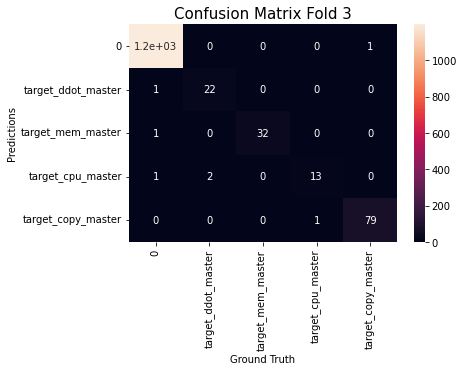

Extracting Feature improtance ...


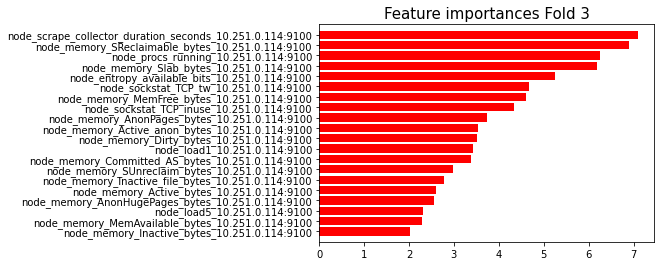

####################################################################################################
Starting fold 4
Scaling data ....
Start training ....
Learning rate set to 0.084977
0:	learn: 1.3127070	total: 9.51ms	remaining: 9.5s
1:	learn: 1.1168349	total: 17.8ms	remaining: 8.86s
2:	learn: 0.9626055	total: 26.1ms	remaining: 8.66s
3:	learn: 0.8387889	total: 33.4ms	remaining: 8.31s
4:	learn: 0.7425997	total: 40.4ms	remaining: 8.04s
5:	learn: 0.6599888	total: 47.7ms	remaining: 7.91s
6:	learn: 0.5916289	total: 55.9ms	remaining: 7.93s
7:	learn: 0.5308606	total: 63.3ms	remaining: 7.85s
8:	learn: 0.4793411	total: 70.5ms	remaining: 7.76s
9:	learn: 0.4364862	total: 77.4ms	remaining: 7.66s
10:	learn: 0.3975311	total: 85ms	remaining: 7.64s
11:	learn: 0.3617910	total: 92.4ms	remaining: 7.61s
12:	learn: 0.3300741	total: 99.7ms	remaining: 7.57s
13:	learn: 0.3014682	total: 107ms	remaining: 7.54s
14:	learn: 0.2756829	total: 115ms	remaining: 7.54s
15:	learn: 0.2523359	total: 121ms	remaining: 7.46s

157:	learn: 0.0109355	total: 1.19s	remaining: 6.35s
158:	learn: 0.0108489	total: 1.2s	remaining: 6.35s
159:	learn: 0.0107500	total: 1.21s	remaining: 6.34s
160:	learn: 0.0106658	total: 1.22s	remaining: 6.34s
161:	learn: 0.0105755	total: 1.22s	remaining: 6.33s
162:	learn: 0.0105213	total: 1.23s	remaining: 6.32s
163:	learn: 0.0105047	total: 1.24s	remaining: 6.3s
164:	learn: 0.0104250	total: 1.24s	remaining: 6.3s
165:	learn: 0.0103174	total: 1.25s	remaining: 6.29s
166:	learn: 0.0102702	total: 1.26s	remaining: 6.28s
167:	learn: 0.0101849	total: 1.27s	remaining: 6.27s
168:	learn: 0.0101028	total: 1.27s	remaining: 6.26s
169:	learn: 0.0100769	total: 1.28s	remaining: 6.25s
170:	learn: 0.0100137	total: 1.29s	remaining: 6.25s
171:	learn: 0.0099323	total: 1.29s	remaining: 6.24s
172:	learn: 0.0098709	total: 1.3s	remaining: 6.23s
173:	learn: 0.0098148	total: 1.31s	remaining: 6.22s
174:	learn: 0.0097791	total: 1.32s	remaining: 6.21s
175:	learn: 0.0097593	total: 1.32s	remaining: 6.21s
176:	learn: 0.00

332:	learn: 0.0045309	total: 2.6s	remaining: 5.2s
333:	learn: 0.0045125	total: 2.61s	remaining: 5.2s
334:	learn: 0.0044958	total: 2.61s	remaining: 5.19s
335:	learn: 0.0044755	total: 2.62s	remaining: 5.18s
336:	learn: 0.0044641	total: 2.63s	remaining: 5.17s
337:	learn: 0.0044414	total: 2.64s	remaining: 5.16s
338:	learn: 0.0044194	total: 2.64s	remaining: 5.16s
339:	learn: 0.0043978	total: 2.65s	remaining: 5.15s
340:	learn: 0.0043824	total: 2.66s	remaining: 5.14s
341:	learn: 0.0043551	total: 2.67s	remaining: 5.13s
342:	learn: 0.0043359	total: 2.67s	remaining: 5.12s
343:	learn: 0.0043189	total: 2.68s	remaining: 5.11s
344:	learn: 0.0042889	total: 2.69s	remaining: 5.1s
345:	learn: 0.0042690	total: 2.7s	remaining: 5.1s
346:	learn: 0.0042601	total: 2.7s	remaining: 5.09s
347:	learn: 0.0042365	total: 2.71s	remaining: 5.08s
348:	learn: 0.0042093	total: 2.72s	remaining: 5.07s
349:	learn: 0.0041738	total: 2.72s	remaining: 5.06s
350:	learn: 0.0041488	total: 2.73s	remaining: 5.05s
351:	learn: 0.00414

491:	learn: 0.0025395	total: 3.8s	remaining: 3.93s
492:	learn: 0.0025330	total: 3.81s	remaining: 3.92s
493:	learn: 0.0025278	total: 3.82s	remaining: 3.91s
494:	learn: 0.0025181	total: 3.83s	remaining: 3.9s
495:	learn: 0.0025119	total: 3.83s	remaining: 3.9s
496:	learn: 0.0025060	total: 3.84s	remaining: 3.89s
497:	learn: 0.0024925	total: 3.85s	remaining: 3.88s
498:	learn: 0.0024898	total: 3.85s	remaining: 3.87s
499:	learn: 0.0024812	total: 3.86s	remaining: 3.86s
500:	learn: 0.0024748	total: 3.87s	remaining: 3.86s
501:	learn: 0.0024713	total: 3.88s	remaining: 3.85s
502:	learn: 0.0024669	total: 3.89s	remaining: 3.84s
503:	learn: 0.0024632	total: 3.89s	remaining: 3.83s
504:	learn: 0.0024521	total: 3.9s	remaining: 3.83s
505:	learn: 0.0024428	total: 3.91s	remaining: 3.82s
506:	learn: 0.0024387	total: 3.92s	remaining: 3.81s
507:	learn: 0.0024313	total: 3.92s	remaining: 3.8s
508:	learn: 0.0024209	total: 3.93s	remaining: 3.79s
509:	learn: 0.0024140	total: 3.94s	remaining: 3.78s
510:	learn: 0.002

650:	learn: 0.0017279	total: 5s	remaining: 2.68s
651:	learn: 0.0017256	total: 5.01s	remaining: 2.67s
652:	learn: 0.0017220	total: 5.01s	remaining: 2.67s
653:	learn: 0.0017205	total: 5.02s	remaining: 2.66s
654:	learn: 0.0017177	total: 5.03s	remaining: 2.65s
655:	learn: 0.0017132	total: 5.04s	remaining: 2.64s
656:	learn: 0.0017092	total: 5.04s	remaining: 2.63s
657:	learn: 0.0017054	total: 5.05s	remaining: 2.63s
658:	learn: 0.0017015	total: 5.06s	remaining: 2.62s
659:	learn: 0.0016981	total: 5.07s	remaining: 2.61s
660:	learn: 0.0016947	total: 5.08s	remaining: 2.6s
661:	learn: 0.0016922	total: 5.08s	remaining: 2.6s
662:	learn: 0.0016911	total: 5.09s	remaining: 2.59s
663:	learn: 0.0016874	total: 5.1s	remaining: 2.58s
664:	learn: 0.0016840	total: 5.11s	remaining: 2.57s
665:	learn: 0.0016817	total: 5.11s	remaining: 2.56s
666:	learn: 0.0016779	total: 5.12s	remaining: 2.56s
667:	learn: 0.0016757	total: 5.13s	remaining: 2.55s
668:	learn: 0.0016720	total: 5.13s	remaining: 2.54s
669:	learn: 0.0016

834:	learn: 0.0012408	total: 6.39s	remaining: 1.26s
835:	learn: 0.0012397	total: 6.4s	remaining: 1.25s
836:	learn: 0.0012386	total: 6.41s	remaining: 1.25s
837:	learn: 0.0012379	total: 6.42s	remaining: 1.24s
838:	learn: 0.0012359	total: 6.42s	remaining: 1.23s
839:	learn: 0.0012347	total: 6.43s	remaining: 1.22s
840:	learn: 0.0012329	total: 6.44s	remaining: 1.22s
841:	learn: 0.0012311	total: 6.45s	remaining: 1.21s
842:	learn: 0.0012296	total: 6.45s	remaining: 1.2s
843:	learn: 0.0012280	total: 6.46s	remaining: 1.19s
844:	learn: 0.0012252	total: 6.47s	remaining: 1.19s
845:	learn: 0.0012226	total: 6.47s	remaining: 1.18s
846:	learn: 0.0012210	total: 6.48s	remaining: 1.17s
847:	learn: 0.0012185	total: 6.49s	remaining: 1.16s
848:	learn: 0.0012171	total: 6.5s	remaining: 1.16s
849:	learn: 0.0012153	total: 6.51s	remaining: 1.15s
850:	learn: 0.0012130	total: 6.51s	remaining: 1.14s
851:	learn: 0.0012116	total: 6.52s	remaining: 1.13s
852:	learn: 0.0012098	total: 6.53s	remaining: 1.13s
853:	learn: 0.0

992:	learn: 0.0009956	total: 7.6s	remaining: 53.5ms
993:	learn: 0.0009943	total: 7.6s	remaining: 45.9ms
994:	learn: 0.0009939	total: 7.61s	remaining: 38.3ms
995:	learn: 0.0009925	total: 7.62s	remaining: 30.6ms
996:	learn: 0.0009913	total: 7.63s	remaining: 22.9ms
997:	learn: 0.0009902	total: 7.63s	remaining: 15.3ms
998:	learn: 0.0009896	total: 7.64s	remaining: 7.65ms
999:	learn: 0.0009887	total: 7.65s	remaining: 0us
Predicting ....
----------------------------------------------------------------------------------------------------
Accuracy score fold 4 is: 0.9948148148148148
Ballanced accuracy fold 4 score is: 0.926548089591568
Jaccard score fold 4: 0.9896831245394252
Full classification report for fold 4
                    precision    recall  f1-score   support

                 0     0.9983    1.0000    0.9992      1198
target_ddot_master     0.9130    0.9130    0.9130        23
 target_mem_master     0.9697    0.9697    0.9697        33
 target_cpu_master     1.0000    0.7500    0.

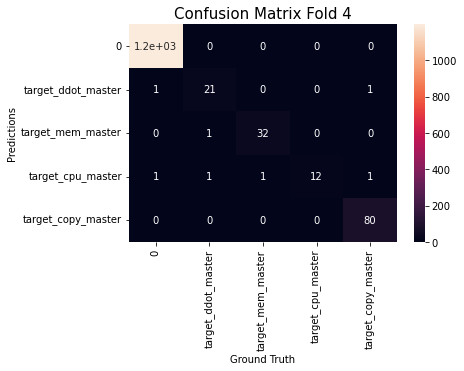

Extracting Feature improtance ...


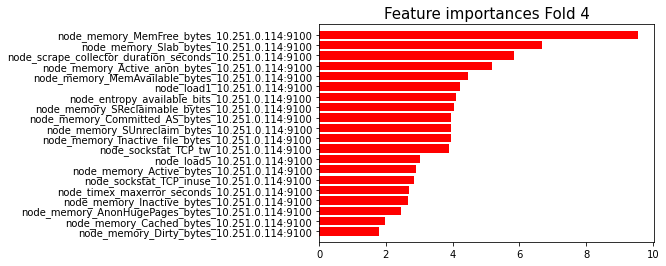

####################################################################################################
Starting fold 5
Scaling data ....
Start training ....
Learning rate set to 0.084977
0:	learn: 1.3134000	total: 7.79ms	remaining: 7.78s
1:	learn: 1.1142541	total: 15.1ms	remaining: 7.53s
2:	learn: 0.9591877	total: 22.9ms	remaining: 7.61s
3:	learn: 0.8369571	total: 31ms	remaining: 7.72s
4:	learn: 0.7433616	total: 39.7ms	remaining: 7.91s
5:	learn: 0.6585155	total: 48.5ms	remaining: 8.03s
6:	learn: 0.5901390	total: 56.7ms	remaining: 8.04s
7:	learn: 0.5301909	total: 64.3ms	remaining: 7.97s
8:	learn: 0.4784110	total: 71.5ms	remaining: 7.88s
9:	learn: 0.4342572	total: 79.3ms	remaining: 7.85s
10:	learn: 0.3933569	total: 86.8ms	remaining: 7.8s
11:	learn: 0.3585611	total: 94.6ms	remaining: 7.79s
12:	learn: 0.3271536	total: 102ms	remaining: 7.72s
13:	learn: 0.2996532	total: 110ms	remaining: 7.76s
14:	learn: 0.2735784	total: 118ms	remaining: 7.73s
15:	learn: 0.2514641	total: 125ms	remaining: 7.71s


180:	learn: 0.0076424	total: 1.38s	remaining: 6.26s
181:	learn: 0.0075883	total: 1.39s	remaining: 6.26s
182:	learn: 0.0075203	total: 1.4s	remaining: 6.25s
183:	learn: 0.0074928	total: 1.41s	remaining: 6.24s
184:	learn: 0.0074407	total: 1.42s	remaining: 6.24s
185:	learn: 0.0073985	total: 1.42s	remaining: 6.23s
186:	learn: 0.0073404	total: 1.43s	remaining: 6.22s
187:	learn: 0.0072686	total: 1.44s	remaining: 6.21s
188:	learn: 0.0072357	total: 1.45s	remaining: 6.2s
189:	learn: 0.0071990	total: 1.45s	remaining: 6.2s
190:	learn: 0.0071675	total: 1.46s	remaining: 6.19s
191:	learn: 0.0071258	total: 1.47s	remaining: 6.18s
192:	learn: 0.0070656	total: 1.48s	remaining: 6.17s
193:	learn: 0.0070376	total: 1.48s	remaining: 6.16s
194:	learn: 0.0069969	total: 1.49s	remaining: 6.15s
195:	learn: 0.0069632	total: 1.5s	remaining: 6.14s
196:	learn: 0.0069373	total: 1.5s	remaining: 6.13s
197:	learn: 0.0069165	total: 1.51s	remaining: 6.13s
198:	learn: 0.0068701	total: 1.52s	remaining: 6.12s
199:	learn: 0.006

361:	learn: 0.0030636	total: 2.74s	remaining: 4.82s
362:	learn: 0.0030543	total: 2.74s	remaining: 4.82s
363:	learn: 0.0030314	total: 2.75s	remaining: 4.81s
364:	learn: 0.0030220	total: 2.76s	remaining: 4.8s
365:	learn: 0.0030105	total: 2.77s	remaining: 4.79s
366:	learn: 0.0030000	total: 2.77s	remaining: 4.79s
367:	learn: 0.0029906	total: 2.78s	remaining: 4.78s
368:	learn: 0.0029862	total: 2.79s	remaining: 4.77s
369:	learn: 0.0029651	total: 2.8s	remaining: 4.76s
370:	learn: 0.0029426	total: 2.8s	remaining: 4.75s
371:	learn: 0.0029295	total: 2.81s	remaining: 4.74s
372:	learn: 0.0029091	total: 2.82s	remaining: 4.74s
373:	learn: 0.0029024	total: 2.82s	remaining: 4.73s
374:	learn: 0.0028915	total: 2.83s	remaining: 4.72s
375:	learn: 0.0028761	total: 2.84s	remaining: 4.71s
376:	learn: 0.0028638	total: 2.85s	remaining: 4.7s
377:	learn: 0.0028517	total: 2.85s	remaining: 4.7s
378:	learn: 0.0028421	total: 2.86s	remaining: 4.69s
379:	learn: 0.0028336	total: 2.87s	remaining: 4.68s
380:	learn: 0.002

520:	learn: 0.0018507	total: 3.94s	remaining: 3.62s
521:	learn: 0.0018477	total: 3.94s	remaining: 3.61s
522:	learn: 0.0018362	total: 3.95s	remaining: 3.6s
523:	learn: 0.0018311	total: 3.96s	remaining: 3.6s
524:	learn: 0.0018263	total: 3.97s	remaining: 3.59s
525:	learn: 0.0018197	total: 3.98s	remaining: 3.58s
526:	learn: 0.0018087	total: 3.98s	remaining: 3.57s
527:	learn: 0.0018049	total: 3.99s	remaining: 3.57s
528:	learn: 0.0018021	total: 4s	remaining: 3.56s
529:	learn: 0.0017938	total: 4s	remaining: 3.55s
530:	learn: 0.0017916	total: 4.01s	remaining: 3.54s
531:	learn: 0.0017848	total: 4.02s	remaining: 3.54s
532:	learn: 0.0017820	total: 4.03s	remaining: 3.53s
533:	learn: 0.0017777	total: 4.04s	remaining: 3.52s
534:	learn: 0.0017717	total: 4.04s	remaining: 3.51s
535:	learn: 0.0017689	total: 4.05s	remaining: 3.5s
536:	learn: 0.0017666	total: 4.06s	remaining: 3.5s
537:	learn: 0.0017606	total: 4.06s	remaining: 3.49s
538:	learn: 0.0017533	total: 4.07s	remaining: 3.48s
539:	learn: 0.0017506	

696:	learn: 0.0012686	total: 5.36s	remaining: 2.33s
697:	learn: 0.0012673	total: 5.37s	remaining: 2.32s
698:	learn: 0.0012655	total: 5.37s	remaining: 2.31s
699:	learn: 0.0012605	total: 5.38s	remaining: 2.31s
700:	learn: 0.0012591	total: 5.39s	remaining: 2.3s
701:	learn: 0.0012550	total: 5.4s	remaining: 2.29s
702:	learn: 0.0012540	total: 5.42s	remaining: 2.29s
703:	learn: 0.0012527	total: 5.42s	remaining: 2.28s
704:	learn: 0.0012513	total: 5.43s	remaining: 2.27s
705:	learn: 0.0012476	total: 5.44s	remaining: 2.26s
706:	learn: 0.0012450	total: 5.44s	remaining: 2.26s
707:	learn: 0.0012390	total: 5.45s	remaining: 2.25s
708:	learn: 0.0012369	total: 5.46s	remaining: 2.24s
709:	learn: 0.0012343	total: 5.47s	remaining: 2.23s
710:	learn: 0.0012322	total: 5.47s	remaining: 2.23s
711:	learn: 0.0012281	total: 5.48s	remaining: 2.22s
712:	learn: 0.0012251	total: 5.49s	remaining: 2.21s
713:	learn: 0.0012233	total: 5.5s	remaining: 2.2s
714:	learn: 0.0012215	total: 5.5s	remaining: 2.19s
715:	learn: 0.001

875:	learn: 0.0009388	total: 6.77s	remaining: 958ms
876:	learn: 0.0009377	total: 6.78s	remaining: 950ms
877:	learn: 0.0009363	total: 6.78s	remaining: 943ms
878:	learn: 0.0009341	total: 6.79s	remaining: 935ms
879:	learn: 0.0009318	total: 6.8s	remaining: 927ms
880:	learn: 0.0009307	total: 6.81s	remaining: 920ms
881:	learn: 0.0009298	total: 6.81s	remaining: 912ms
882:	learn: 0.0009290	total: 6.82s	remaining: 904ms
883:	learn: 0.0009274	total: 6.83s	remaining: 896ms
884:	learn: 0.0009266	total: 6.84s	remaining: 888ms
885:	learn: 0.0009258	total: 6.84s	remaining: 881ms
886:	learn: 0.0009250	total: 6.85s	remaining: 873ms
887:	learn: 0.0009239	total: 6.86s	remaining: 865ms
888:	learn: 0.0009233	total: 6.87s	remaining: 857ms
889:	learn: 0.0009221	total: 6.87s	remaining: 849ms
890:	learn: 0.0009216	total: 6.88s	remaining: 842ms
891:	learn: 0.0009199	total: 6.89s	remaining: 834ms
892:	learn: 0.0009186	total: 6.89s	remaining: 826ms
893:	learn: 0.0009157	total: 6.9s	remaining: 818ms
894:	learn: 0.

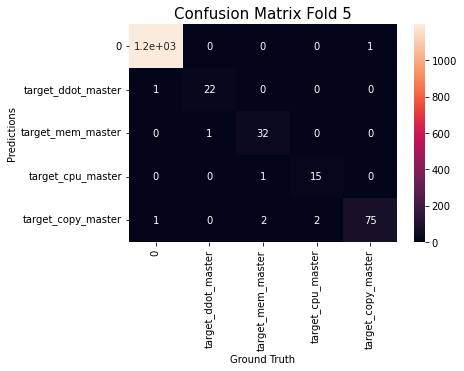

Extracting Feature improtance ...


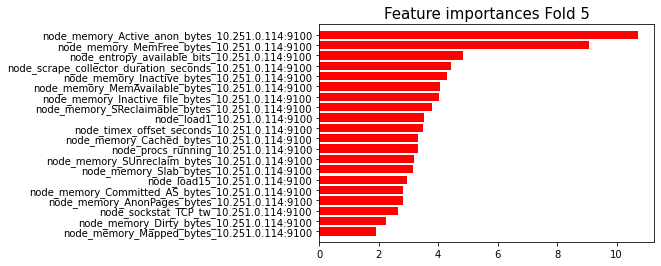

####################################################################################################


In [28]:
# skFold = StratifiedKFold(n_splits=5)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=21)
ml_method = 'catboost_best_cfg_anomaly_only_as_v1'
print("="*100)
clf_models = []
report = {
    "Accuracy": [],
    "BallancedAccuracy": [],
    "Jaccard": []
}
fold = 1
for train_index, test_index in sss.split(X, y):
    # print("Train:", train_index, "Test:", test_index)
    print("Starting fold {}".format(fold))
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    print("Scaling data ....")
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    print("Start training ....")
    clf.fit(Xtrain, ytrain)
    # Append model
    clf_models.append(clf)
    print("Predicting ....")
    ypred = clf.predict(Xtest)
    print("-"*100)
    acc = accuracy_score(ytest, ypred)
    report['Accuracy'].append(acc)
    print("Accuracy score fold {} is: {}".format(fold, acc))
    bacc = balanced_accuracy_score(ytest, ypred)
    report['BallancedAccuracy'].append(bacc)
    print("Ballanced accuracy fold {} score is: {}".format(fold, bacc))
    jaccard = jaccard_score(ytest, ypred, average='micro')
    print("Jaccard score fold {}: {}".format(fold, jaccard))
    report['Jaccard'].append(jaccard)

    ###
    print("Full classification report for fold {}".format(fold))
    print(classification_report(ytest, ypred, digits=4,target_names=definitions))

    cf_report = classification_report(ytest, ypred, output_dict=True, digits=4, target_names=definitions)
    df_classification_report = pd.DataFrame(cf_report).transpose()
    print("Saving classification report")
    classification_rep_name = "classification_{}_fold_{}.csv".format(ml_method, fold)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    ###
    print("Imbalanced Classification report for fold {}".format(fold))
    print(classification_report_imbalanced(ytest, ypred, digits=4, target_names=definitions))
    imb_cf_report = classification_report_imbalanced(ytest, ypred, output_dict=True, digits=4, target_names=definitions)
    df_imb_classification_report = pd.DataFrame(imb_cf_report).transpose()
    print("Saving imbalanced classification report")
    imb_classification_rep_name = "imb_classification_{}_fold_{}.csv".format(ml_method, fold)
    df_imb_classification_report.to_csv(os.path.join(model_dir,imb_classification_rep_name), index=False)
    ###
    print("Generating confusion matrix fold {}".format(fold))
    cf_matrix = confusion_matrix(ytest, ypred)

    # plt.figure(figsize=(10,20), dpi=600) For publication only
    ht_cf=sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    plt.title('Confusion Matrix Fold {}'.format(fold), fontsize = 15) # title with fontsize 20
    plt.xlabel('Ground Truth', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('Predictions', fontsize = 10) # y-axis label with fontsize 15
    cf_fig = "CM_{}_{}.png".format(ml_method, fold)
    ht_cf.figure.savefig(os.path.join(model_dir, cf_fig), bbox_inches='tight')
    plt.show()


    print("Extracting Feature improtance ...")
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    sorted_feature = feat_importances.sort_values(ascending=True)
    # print(sorted_feature.head(-10))
    # print(type(sorted_feature.tail(15)))
    # print(X.shape[1])

    # Number of columns
    # print(len(sorted_feature))

    # Limit number of sorted features
    sorted_feature = sorted_feature.tail(20)



    # n_col = X.shape[1]
    n_col = len(sorted_feature)

    # Plot the feature importances of the forest
    # plt.figure(figsize=(10,20), dpi=600) For publication only
    plt.title("Feature importances Fold {}".format(fold), fontsize = 15)
    plt.barh(range(n_col), sorted_feature,
           color="r", align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(n_col), sorted_feature.index)
    plt.ylim([-1, n_col])
    fi_fig = "FI_{}_{}.png".format(ml_method, fold)
    plt.savefig(os.path.join(model_dir, fi_fig), bbox_inches='tight')
    plt.show()
    #increment fold count
    fold+=1
    print("#"*100)

In [29]:
print("Saving final report ...")
# Validation Report
df_report = pd.DataFrame(report)
final_report = "Model_{}_report.csv".format(ml_method)
df_report.to_csv(os.path.join(model_dir,final_report), index=False)

Saving final report ...


In [ ]:
# Calculates feature statistics for CatBoost
"""
The X-axis of the resulting chart contains values of the feature divided into buckets. For numerical features, the splits between buckets represent conditions (feature < value) from the trees of the model. For categorical features, each bucket stands for a category.
The Y-axis of the resulting chart contains the following graphs:
Average target (label) value in the bucket.
Average prediction in the bucket.
Number of objects in the bucket.
Average predictions on varying values of the feature.
To calculate it, the value of the feature is successively changed to fall into every bucket for every input object. The value for a bucket on the graph is calculated as the average for all objects when their feature values are changed to fall into this bucket.
The return value of the function contains the data from these graps.
"""
# res = clf.calc_feature_statistics(X,
#                                     y,
#                                     feature=list(range(0, len(X.columns.values))),
#                                     plot=True)

res = clf.calc_feature_statitics(X, y, features = list(X.columns.values), plot=True)


In [31]:
from catboost import cv
from catboost import Pool

params_cbcv  = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'AUC',
    'loss_function': 'MultiClass'
}




cv_data = cv(
    params=params_cbcv,
    pool=Pool(X, label=y),
    shuffle=True,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [32]:

from catboost.utils import get_roc_curve, get_fnr_curve
params_2 = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
#     'classes_count': 5,
    'loss_function': 'MultiClass',
#     'eval_metric': 'Accuracy'
}


clf_2 = CatBoostClassifier(**params_2)
clf_2.fit(X, y, plot=True)
# catboost_pool = Pool(X, y)
# roc_curve_values = get_roc_curve(clf_2, catboost_pool)
# (thresholds, fnr) = get_fnr_curve(curve=roc_curve_values, plot=True)

# fi = clf.get_feature_importance(data=X, reference_data=y)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9529254	total: 9.49ms	remaining: 9.48s
1:	learn: 0.6996300	total: 20.3ms	remaining: 10.1s
2:	learn: 0.5316969	total: 31.9ms	remaining: 10.6s
3:	learn: 0.4124037	total: 41.1ms	remaining: 10.2s
4:	learn: 0.3304275	total: 55.6ms	remaining: 11.1s
5:	learn: 0.2673675	total: 65.7ms	remaining: 10.9s
6:	learn: 0.2189834	total: 76ms	remaining: 10.8s
7:	learn: 0.1803919	total: 85.5ms	remaining: 10.6s
8:	learn: 0.1507394	total: 95.2ms	remaining: 10.5s
9:	learn: 0.1259509	total: 104ms	remaining: 10.3s
10:	learn: 0.1057564	total: 112ms	remaining: 10.1s
11:	learn: 0.0903241	total: 121ms	remaining: 9.95s
12:	learn: 0.0782795	total: 130ms	remaining: 9.85s
13:	learn: 0.0683771	total: 138ms	remaining: 9.72s
14:	learn: 0.0594341	total: 156ms	remaining: 10.2s
15:	learn: 0.0521736	total: 172ms	remaining: 10.6s
16:	learn: 0.0465653	total: 182ms	remaining: 10.5s
17:	learn: 0.0424115	total: 192ms	remaining: 10.5s
18:	learn: 0.0384956	total: 200ms	remaining: 10.3s
19:	learn: 0.0355797	total: 209ms	

163:	learn: 0.0043479	total: 2.69s	remaining: 13.7s
164:	learn: 0.0042860	total: 2.7s	remaining: 13.7s
165:	learn: 0.0042670	total: 2.8s	remaining: 14s
166:	learn: 0.0042224	total: 2.85s	remaining: 14.2s
167:	learn: 0.0041743	total: 2.89s	remaining: 14.3s
168:	learn: 0.0041324	total: 2.95s	remaining: 14.5s
169:	learn: 0.0041290	total: 3.01s	remaining: 14.7s
170:	learn: 0.0040891	total: 3.06s	remaining: 14.9s
171:	learn: 0.0040439	total: 3.11s	remaining: 15s
172:	learn: 0.0040033	total: 3.16s	remaining: 15.1s
173:	learn: 0.0039556	total: 3.18s	remaining: 15.1s
174:	learn: 0.0039158	total: 3.2s	remaining: 15.1s
175:	learn: 0.0038766	total: 3.24s	remaining: 15.2s
176:	learn: 0.0038263	total: 3.28s	remaining: 15.2s
177:	learn: 0.0037619	total: 3.32s	remaining: 15.3s
178:	learn: 0.0037352	total: 3.4s	remaining: 15.6s
179:	learn: 0.0037116	total: 3.45s	remaining: 15.7s
180:	learn: 0.0036835	total: 3.47s	remaining: 15.7s
181:	learn: 0.0036557	total: 3.54s	remaining: 15.9s
182:	learn: 0.003627

329:	learn: 0.0014814	total: 5.63s	remaining: 11.4s
330:	learn: 0.0014701	total: 5.66s	remaining: 11.4s
331:	learn: 0.0014615	total: 5.68s	remaining: 11.4s
332:	learn: 0.0014524	total: 5.69s	remaining: 11.4s
333:	learn: 0.0014471	total: 5.7s	remaining: 11.4s
334:	learn: 0.0014401	total: 5.71s	remaining: 11.3s
335:	learn: 0.0014331	total: 5.71s	remaining: 11.3s
336:	learn: 0.0014273	total: 5.72s	remaining: 11.3s
337:	learn: 0.0014217	total: 5.73s	remaining: 11.2s
338:	learn: 0.0014160	total: 5.74s	remaining: 11.2s
339:	learn: 0.0014130	total: 5.75s	remaining: 11.2s
340:	learn: 0.0013960	total: 5.76s	remaining: 11.1s
341:	learn: 0.0013920	total: 5.77s	remaining: 11.1s
342:	learn: 0.0013864	total: 5.78s	remaining: 11.1s
343:	learn: 0.0013793	total: 5.79s	remaining: 11s
344:	learn: 0.0013727	total: 5.8s	remaining: 11s
345:	learn: 0.0013696	total: 5.81s	remaining: 11s
346:	learn: 0.0013672	total: 5.82s	remaining: 11s
347:	learn: 0.0013601	total: 5.83s	remaining: 10.9s
348:	learn: 0.0013539	

494:	learn: 0.0008710	total: 7.27s	remaining: 7.42s
495:	learn: 0.0008691	total: 7.28s	remaining: 7.4s
496:	learn: 0.0008660	total: 7.29s	remaining: 7.38s
497:	learn: 0.0008634	total: 7.3s	remaining: 7.36s
498:	learn: 0.0008613	total: 7.31s	remaining: 7.34s
499:	learn: 0.0008598	total: 7.32s	remaining: 7.32s
500:	learn: 0.0008567	total: 7.33s	remaining: 7.3s
501:	learn: 0.0008549	total: 7.34s	remaining: 7.28s
502:	learn: 0.0008521	total: 7.34s	remaining: 7.26s
503:	learn: 0.0008500	total: 7.36s	remaining: 7.24s
504:	learn: 0.0008472	total: 7.38s	remaining: 7.23s
505:	learn: 0.0008429	total: 7.4s	remaining: 7.22s
506:	learn: 0.0008411	total: 7.42s	remaining: 7.21s
507:	learn: 0.0008391	total: 7.43s	remaining: 7.2s
508:	learn: 0.0008376	total: 7.44s	remaining: 7.18s
509:	learn: 0.0008349	total: 7.46s	remaining: 7.17s
510:	learn: 0.0008331	total: 7.47s	remaining: 7.15s
511:	learn: 0.0008309	total: 7.48s	remaining: 7.13s
512:	learn: 0.0008288	total: 7.49s	remaining: 7.11s
513:	learn: 0.000

666:	learn: 0.0006014	total: 8.86s	remaining: 4.42s
667:	learn: 0.0006005	total: 8.87s	remaining: 4.41s
668:	learn: 0.0005994	total: 8.88s	remaining: 4.39s
669:	learn: 0.0005985	total: 8.88s	remaining: 4.38s
670:	learn: 0.0005976	total: 8.9s	remaining: 4.36s
671:	learn: 0.0005970	total: 8.91s	remaining: 4.35s
672:	learn: 0.0005963	total: 8.91s	remaining: 4.33s
673:	learn: 0.0005952	total: 8.92s	remaining: 4.32s
674:	learn: 0.0005943	total: 8.93s	remaining: 4.3s
675:	learn: 0.0005937	total: 8.94s	remaining: 4.29s
676:	learn: 0.0005927	total: 8.95s	remaining: 4.27s
677:	learn: 0.0005904	total: 8.96s	remaining: 4.25s
678:	learn: 0.0005893	total: 8.97s	remaining: 4.24s
679:	learn: 0.0005883	total: 8.98s	remaining: 4.22s
680:	learn: 0.0005877	total: 8.98s	remaining: 4.21s
681:	learn: 0.0005858	total: 8.99s	remaining: 4.19s
682:	learn: 0.0005854	total: 9s	remaining: 4.18s
683:	learn: 0.0005851	total: 9.01s	remaining: 4.16s
684:	learn: 0.0005835	total: 9.02s	remaining: 4.15s
685:	learn: 0.000

828:	learn: 0.0004643	total: 10.3s	remaining: 2.12s
829:	learn: 0.0004638	total: 10.3s	remaining: 2.1s
830:	learn: 0.0004635	total: 10.3s	remaining: 2.09s
831:	learn: 0.0004625	total: 10.3s	remaining: 2.08s
832:	learn: 0.0004620	total: 10.3s	remaining: 2.07s
833:	learn: 0.0004616	total: 10.3s	remaining: 2.05s
834:	learn: 0.0004613	total: 10.3s	remaining: 2.04s
835:	learn: 0.0004610	total: 10.3s	remaining: 2.03s
836:	learn: 0.0004602	total: 10.3s	remaining: 2.01s
837:	learn: 0.0004597	total: 10.4s	remaining: 2s
838:	learn: 0.0004589	total: 10.4s	remaining: 1.99s
839:	learn: 0.0004580	total: 10.4s	remaining: 1.98s
840:	learn: 0.0004573	total: 10.4s	remaining: 1.96s
841:	learn: 0.0004567	total: 10.4s	remaining: 1.95s
842:	learn: 0.0004562	total: 10.4s	remaining: 1.94s
843:	learn: 0.0004558	total: 10.4s	remaining: 1.92s
844:	learn: 0.0004547	total: 10.4s	remaining: 1.91s
845:	learn: 0.0004536	total: 10.4s	remaining: 1.9s
846:	learn: 0.0004526	total: 10.4s	remaining: 1.88s
847:	learn: 0.000

990:	learn: 0.0003785	total: 11.7s	remaining: 106ms
991:	learn: 0.0003782	total: 11.7s	remaining: 94.3ms
992:	learn: 0.0003777	total: 11.7s	remaining: 82.5ms
993:	learn: 0.0003774	total: 11.7s	remaining: 70.7ms
994:	learn: 0.0003770	total: 11.7s	remaining: 58.9ms
995:	learn: 0.0003766	total: 11.7s	remaining: 47.1ms
996:	learn: 0.0003763	total: 11.7s	remaining: 35.3ms
997:	learn: 0.0003759	total: 11.7s	remaining: 23.5ms
998:	learn: 0.0003756	total: 11.8s	remaining: 11.8ms
999:	learn: 0.0003752	total: 11.8s	remaining: 0us


In [33]:
catboost_pool = Pool(X, y)

# roc_curve_values = get_roc_curve(clf_2, catboost_pool)
# (thresholds, fnr) = get_fnr_curve(curve=roc_curve_values, plot=True)

fi = clf_2.get_feature_importance(catboost_pool)
fi

array([5.88838512e-01, 1.41311391e-01, 5.83406735e-02, 0.00000000e+00,
       0.00000000e+00, 8.38757225e-02, 0.00000000e+00, 0.00000000e+00,
       2.86041212e-01, 2.45714334e-01, 0.00000000e+00, 1.90966490e-01,
       5.08711194e+00, 1.01200272e-01, 5.49242301e-01, 5.68076139e-03,
       5.05919041e+00, 8.44627547e-01, 1.81140923e+00, 4.39851565e+00,
       2.88475394e-01, 3.13548645e-01, 2.44306379e+00, 1.97795651e+00,
       2.78956315e-01, 1.73530749e+00, 3.69123967e+00, 0.00000000e+00,
       0.00000000e+00, 3.38550278e+00, 5.39974726e-01, 1.51115357e+00,
       5.50179654e+00, 1.49529485e+00, 7.72986830e-01, 3.75123680e+00,
       1.25523550e+01, 1.60993355e+00, 4.14912167e+00, 5.67503234e+00,
       6.96023436e-01, 5.92453365e+00, 0.00000000e+00, 0.00000000e+00,
       7.52373254e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.43306769e-02, 6.69165409e-01,
      

0:	learn: 1.1131881	total: 6.41ms	remaining: 6.4s
1:	learn: 0.9073235	total: 13.7ms	remaining: 6.85s
2:	learn: 0.7838700	total: 20.4ms	remaining: 6.8s
3:	learn: 0.7001582	total: 26.6ms	remaining: 6.62s
4:	learn: 0.6394961	total: 33.3ms	remaining: 6.62s
5:	learn: 0.5978404	total: 39.9ms	remaining: 6.62s
6:	learn: 0.5661586	total: 46.4ms	remaining: 6.59s
7:	learn: 0.5409121	total: 53.7ms	remaining: 6.66s
8:	learn: 0.5223734	total: 60.3ms	remaining: 6.64s
9:	learn: 0.5074254	total: 65.9ms	remaining: 6.53s
10:	learn: 0.4963687	total: 71.7ms	remaining: 6.45s
11:	learn: 0.4860150	total: 78.1ms	remaining: 6.43s
12:	learn: 0.4788265	total: 84.8ms	remaining: 6.44s
13:	learn: 0.4736219	total: 91.3ms	remaining: 6.43s
14:	learn: 0.4668003	total: 97.7ms	remaining: 6.41s
15:	learn: 0.4616697	total: 104ms	remaining: 6.39s
16:	learn: 0.4591213	total: 110ms	remaining: 6.36s
17:	learn: 0.4535682	total: 116ms	remaining: 6.33s
18:	learn: 0.4506666	total: 122ms	remaining: 6.3s
19:	learn: 0.4463533	total: 1

181:	learn: 0.2275135	total: 1.19s	remaining: 5.37s
182:	learn: 0.2257080	total: 1.2s	remaining: 5.37s
183:	learn: 0.2252673	total: 1.21s	remaining: 5.36s
184:	learn: 0.2246297	total: 1.22s	remaining: 5.35s
185:	learn: 0.2241073	total: 1.22s	remaining: 5.35s
186:	learn: 0.2236602	total: 1.23s	remaining: 5.34s
187:	learn: 0.2230936	total: 1.23s	remaining: 5.33s
188:	learn: 0.2224529	total: 1.24s	remaining: 5.32s
189:	learn: 0.2219903	total: 1.25s	remaining: 5.31s
190:	learn: 0.2209133	total: 1.25s	remaining: 5.3s
191:	learn: 0.2200916	total: 1.26s	remaining: 5.3s
192:	learn: 0.2192542	total: 1.26s	remaining: 5.29s
193:	learn: 0.2182775	total: 1.27s	remaining: 5.28s
194:	learn: 0.2176759	total: 1.28s	remaining: 5.27s
195:	learn: 0.2171872	total: 1.28s	remaining: 5.26s
196:	learn: 0.2162732	total: 1.29s	remaining: 5.25s
197:	learn: 0.2146787	total: 1.29s	remaining: 5.25s
198:	learn: 0.2140644	total: 1.3s	remaining: 5.24s
199:	learn: 0.2130611	total: 1.31s	remaining: 5.23s
200:	learn: 0.21

355:	learn: 0.1244618	total: 2.39s	remaining: 4.33s
356:	learn: 0.1239676	total: 2.4s	remaining: 4.32s
357:	learn: 0.1236594	total: 2.41s	remaining: 4.32s
358:	learn: 0.1234914	total: 2.41s	remaining: 4.31s
359:	learn: 0.1232381	total: 2.42s	remaining: 4.3s
360:	learn: 0.1223365	total: 2.43s	remaining: 4.3s
361:	learn: 0.1220584	total: 2.43s	remaining: 4.29s
362:	learn: 0.1216694	total: 2.44s	remaining: 4.28s
363:	learn: 0.1211423	total: 2.45s	remaining: 4.27s
364:	learn: 0.1208166	total: 2.45s	remaining: 4.26s
365:	learn: 0.1204449	total: 2.46s	remaining: 4.26s
366:	learn: 0.1200183	total: 2.46s	remaining: 4.25s
367:	learn: 0.1195719	total: 2.47s	remaining: 4.24s
368:	learn: 0.1194131	total: 2.48s	remaining: 4.23s
369:	learn: 0.1192814	total: 2.48s	remaining: 4.23s
370:	learn: 0.1190024	total: 2.49s	remaining: 4.22s
371:	learn: 0.1186421	total: 2.49s	remaining: 4.21s
372:	learn: 0.1183616	total: 2.5s	remaining: 4.2s
373:	learn: 0.1179887	total: 2.51s	remaining: 4.2s
374:	learn: 0.1177

529:	learn: 0.0777035	total: 3.58s	remaining: 3.18s
530:	learn: 0.0775405	total: 3.59s	remaining: 3.17s
531:	learn: 0.0773298	total: 3.6s	remaining: 3.17s
532:	learn: 0.0772230	total: 3.61s	remaining: 3.16s
533:	learn: 0.0770180	total: 3.61s	remaining: 3.15s
534:	learn: 0.0768591	total: 3.62s	remaining: 3.15s
535:	learn: 0.0767259	total: 3.63s	remaining: 3.14s
536:	learn: 0.0765094	total: 3.63s	remaining: 3.13s
537:	learn: 0.0763386	total: 3.64s	remaining: 3.13s
538:	learn: 0.0762191	total: 3.65s	remaining: 3.12s
539:	learn: 0.0761388	total: 3.66s	remaining: 3.12s
540:	learn: 0.0759939	total: 3.67s	remaining: 3.11s
541:	learn: 0.0758665	total: 3.67s	remaining: 3.11s
542:	learn: 0.0756351	total: 3.68s	remaining: 3.1s
543:	learn: 0.0754825	total: 3.69s	remaining: 3.09s
544:	learn: 0.0752780	total: 3.7s	remaining: 3.09s
545:	learn: 0.0751029	total: 3.7s	remaining: 3.08s
546:	learn: 0.0749192	total: 3.71s	remaining: 3.07s
547:	learn: 0.0747263	total: 3.72s	remaining: 3.07s
548:	learn: 0.07

711:	learn: 0.0542563	total: 4.78s	remaining: 1.94s
712:	learn: 0.0542038	total: 4.79s	remaining: 1.93s
713:	learn: 0.0541042	total: 4.8s	remaining: 1.92s
714:	learn: 0.0540480	total: 4.81s	remaining: 1.92s
715:	learn: 0.0539516	total: 4.81s	remaining: 1.91s
716:	learn: 0.0538610	total: 4.82s	remaining: 1.9s
717:	learn: 0.0537863	total: 4.83s	remaining: 1.9s
718:	learn: 0.0537235	total: 4.84s	remaining: 1.89s
719:	learn: 0.0536527	total: 4.84s	remaining: 1.88s
720:	learn: 0.0535748	total: 4.85s	remaining: 1.88s
721:	learn: 0.0535251	total: 4.86s	remaining: 1.87s
722:	learn: 0.0534558	total: 4.87s	remaining: 1.86s
723:	learn: 0.0533608	total: 4.88s	remaining: 1.86s
724:	learn: 0.0532401	total: 4.88s	remaining: 1.85s
725:	learn: 0.0530337	total: 4.89s	remaining: 1.84s
726:	learn: 0.0529489	total: 4.9s	remaining: 1.84s
727:	learn: 0.0527536	total: 4.91s	remaining: 1.83s
728:	learn: 0.0526251	total: 4.91s	remaining: 1.83s
729:	learn: 0.0525820	total: 4.92s	remaining: 1.82s
730:	learn: 0.05

890:	learn: 0.0412115	total: 5.99s	remaining: 732ms
891:	learn: 0.0411200	total: 5.99s	remaining: 726ms
892:	learn: 0.0410789	total: 6s	remaining: 719ms
893:	learn: 0.0410399	total: 6.01s	remaining: 712ms
894:	learn: 0.0409954	total: 6.01s	remaining: 706ms
895:	learn: 0.0409507	total: 6.02s	remaining: 699ms
896:	learn: 0.0409127	total: 6.03s	remaining: 692ms
897:	learn: 0.0408792	total: 6.03s	remaining: 685ms
898:	learn: 0.0408185	total: 6.04s	remaining: 678ms
899:	learn: 0.0407557	total: 6.05s	remaining: 672ms
900:	learn: 0.0407035	total: 6.05s	remaining: 665ms
901:	learn: 0.0406316	total: 6.06s	remaining: 658ms
902:	learn: 0.0405658	total: 6.07s	remaining: 652ms
903:	learn: 0.0405276	total: 6.07s	remaining: 645ms
904:	learn: 0.0404965	total: 6.08s	remaining: 638ms
905:	learn: 0.0404409	total: 6.08s	remaining: 631ms
906:	learn: 0.0403698	total: 6.09s	remaining: 624ms
907:	learn: 0.0403191	total: 6.1s	remaining: 618ms
908:	learn: 0.0402842	total: 6.1s	remaining: 611ms
909:	learn: 0.040

55:	learn: 0.3768235	total: 408ms	remaining: 6.88s
56:	learn: 0.3750735	total: 415ms	remaining: 6.86s
57:	learn: 0.3736783	total: 423ms	remaining: 6.86s
58:	learn: 0.3716255	total: 430ms	remaining: 6.85s
59:	learn: 0.3706372	total: 436ms	remaining: 6.84s
60:	learn: 0.3685022	total: 443ms	remaining: 6.81s
61:	learn: 0.3650344	total: 450ms	remaining: 6.81s
62:	learn: 0.3631079	total: 457ms	remaining: 6.8s
63:	learn: 0.3611183	total: 465ms	remaining: 6.8s
64:	learn: 0.3599528	total: 472ms	remaining: 6.78s
65:	learn: 0.3570617	total: 478ms	remaining: 6.77s
66:	learn: 0.3553867	total: 484ms	remaining: 6.74s
67:	learn: 0.3544755	total: 491ms	remaining: 6.73s
68:	learn: 0.3523922	total: 498ms	remaining: 6.72s
69:	learn: 0.3507363	total: 505ms	remaining: 6.7s
70:	learn: 0.3495873	total: 511ms	remaining: 6.69s
71:	learn: 0.3482816	total: 518ms	remaining: 6.67s
72:	learn: 0.3467166	total: 524ms	remaining: 6.66s
73:	learn: 0.3463389	total: 531ms	remaining: 6.64s
74:	learn: 0.3441872	total: 537ms	

223:	learn: 0.2090127	total: 1.61s	remaining: 5.57s
224:	learn: 0.2086083	total: 1.61s	remaining: 5.56s
225:	learn: 0.2075873	total: 1.62s	remaining: 5.55s
226:	learn: 0.2069648	total: 1.63s	remaining: 5.55s
227:	learn: 0.2066368	total: 1.64s	remaining: 5.54s
228:	learn: 0.2060080	total: 1.64s	remaining: 5.53s
229:	learn: 0.2053695	total: 1.65s	remaining: 5.52s
230:	learn: 0.2043122	total: 1.66s	remaining: 5.51s
231:	learn: 0.2036329	total: 1.66s	remaining: 5.5s
232:	learn: 0.2021244	total: 1.67s	remaining: 5.49s
233:	learn: 0.2014900	total: 1.68s	remaining: 5.49s
234:	learn: 0.2009194	total: 1.68s	remaining: 5.47s
235:	learn: 0.2001281	total: 1.69s	remaining: 5.46s
236:	learn: 0.1996863	total: 1.69s	remaining: 5.46s
237:	learn: 0.1992153	total: 1.7s	remaining: 5.45s
238:	learn: 0.1983278	total: 1.71s	remaining: 5.44s
239:	learn: 0.1976183	total: 1.71s	remaining: 5.43s
240:	learn: 0.1963192	total: 1.72s	remaining: 5.42s
241:	learn: 0.1958836	total: 1.73s	remaining: 5.41s
242:	learn: 0.

385:	learn: 0.1219956	total: 2.77s	remaining: 4.41s
386:	learn: 0.1215435	total: 2.78s	remaining: 4.41s
387:	learn: 0.1210582	total: 2.79s	remaining: 4.4s
388:	learn: 0.1207036	total: 2.8s	remaining: 4.39s
389:	learn: 0.1204046	total: 2.8s	remaining: 4.39s
390:	learn: 0.1200135	total: 2.81s	remaining: 4.38s
391:	learn: 0.1195755	total: 2.82s	remaining: 4.37s
392:	learn: 0.1192531	total: 2.82s	remaining: 4.36s
393:	learn: 0.1188045	total: 2.83s	remaining: 4.36s
394:	learn: 0.1186548	total: 2.84s	remaining: 4.35s
395:	learn: 0.1184798	total: 2.85s	remaining: 4.34s
396:	learn: 0.1182568	total: 2.85s	remaining: 4.33s
397:	learn: 0.1181396	total: 2.86s	remaining: 4.33s
398:	learn: 0.1177162	total: 2.87s	remaining: 4.32s
399:	learn: 0.1174594	total: 2.88s	remaining: 4.31s
400:	learn: 0.1168596	total: 2.88s	remaining: 4.31s
401:	learn: 0.1163803	total: 2.89s	remaining: 4.3s
402:	learn: 0.1161951	total: 2.91s	remaining: 4.31s
403:	learn: 0.1157226	total: 2.93s	remaining: 4.32s
404:	learn: 0.11

549:	learn: 0.0802091	total: 3.96s	remaining: 3.24s
550:	learn: 0.0800181	total: 3.97s	remaining: 3.24s
551:	learn: 0.0798869	total: 3.98s	remaining: 3.23s
552:	learn: 0.0796985	total: 3.99s	remaining: 3.22s
553:	learn: 0.0796262	total: 3.99s	remaining: 3.21s
554:	learn: 0.0795255	total: 4s	remaining: 3.21s
555:	learn: 0.0793695	total: 4.01s	remaining: 3.2s
556:	learn: 0.0791430	total: 4.01s	remaining: 3.19s
557:	learn: 0.0789740	total: 4.02s	remaining: 3.19s
558:	learn: 0.0788445	total: 4.03s	remaining: 3.18s
559:	learn: 0.0786301	total: 4.03s	remaining: 3.17s
560:	learn: 0.0785049	total: 4.04s	remaining: 3.16s
561:	learn: 0.0782597	total: 4.05s	remaining: 3.16s
562:	learn: 0.0781286	total: 4.06s	remaining: 3.15s
563:	learn: 0.0779111	total: 4.07s	remaining: 3.14s
564:	learn: 0.0777231	total: 4.08s	remaining: 3.14s
565:	learn: 0.0773436	total: 4.09s	remaining: 3.14s
566:	learn: 0.0771338	total: 4.1s	remaining: 3.13s
567:	learn: 0.0769301	total: 4.11s	remaining: 3.12s
568:	learn: 0.076

710:	learn: 0.0578184	total: 5.17s	remaining: 2.1s
711:	learn: 0.0577494	total: 5.18s	remaining: 2.09s
712:	learn: 0.0576696	total: 5.19s	remaining: 2.09s
713:	learn: 0.0575389	total: 5.19s	remaining: 2.08s
714:	learn: 0.0574372	total: 5.2s	remaining: 2.07s
715:	learn: 0.0573693	total: 5.21s	remaining: 2.06s
716:	learn: 0.0573380	total: 5.21s	remaining: 2.06s
717:	learn: 0.0572385	total: 5.22s	remaining: 2.05s
718:	learn: 0.0571767	total: 5.23s	remaining: 2.04s
719:	learn: 0.0570971	total: 5.24s	remaining: 2.04s
720:	learn: 0.0570195	total: 5.25s	remaining: 2.03s
721:	learn: 0.0569414	total: 5.26s	remaining: 2.02s
722:	learn: 0.0568875	total: 5.26s	remaining: 2.02s
723:	learn: 0.0567189	total: 5.27s	remaining: 2.01s
724:	learn: 0.0565345	total: 5.28s	remaining: 2s
725:	learn: 0.0564156	total: 5.29s	remaining: 2s
726:	learn: 0.0563031	total: 5.29s	remaining: 1.99s
727:	learn: 0.0562095	total: 5.3s	remaining: 1.98s
728:	learn: 0.0560246	total: 5.31s	remaining: 1.97s
729:	learn: 0.0559191

872:	learn: 0.0439717	total: 6.37s	remaining: 927ms
873:	learn: 0.0439346	total: 6.38s	remaining: 919ms
874:	learn: 0.0438951	total: 6.38s	remaining: 912ms
875:	learn: 0.0438611	total: 6.39s	remaining: 905ms
876:	learn: 0.0438119	total: 6.4s	remaining: 897ms
877:	learn: 0.0437473	total: 6.4s	remaining: 890ms
878:	learn: 0.0436755	total: 6.41s	remaining: 883ms
879:	learn: 0.0436605	total: 6.42s	remaining: 875ms
880:	learn: 0.0436261	total: 6.42s	remaining: 868ms
881:	learn: 0.0435800	total: 6.43s	remaining: 860ms
882:	learn: 0.0435146	total: 6.44s	remaining: 853ms
883:	learn: 0.0434640	total: 6.44s	remaining: 845ms
884:	learn: 0.0434060	total: 6.45s	remaining: 838ms
885:	learn: 0.0433016	total: 6.46s	remaining: 831ms
886:	learn: 0.0432046	total: 6.46s	remaining: 823ms
887:	learn: 0.0431325	total: 6.47s	remaining: 816ms
888:	learn: 0.0430591	total: 6.47s	remaining: 809ms
889:	learn: 0.0429587	total: 6.48s	remaining: 801ms
890:	learn: 0.0429160	total: 6.49s	remaining: 794ms
891:	learn: 0.

34:	learn: 0.4657819	total: 289ms	remaining: 7.96s
35:	learn: 0.4643487	total: 297ms	remaining: 7.95s
36:	learn: 0.4615779	total: 305ms	remaining: 7.94s
37:	learn: 0.4601704	total: 312ms	remaining: 7.9s
38:	learn: 0.4592697	total: 320ms	remaining: 7.89s
39:	learn: 0.4587595	total: 327ms	remaining: 7.86s
40:	learn: 0.4575526	total: 334ms	remaining: 7.81s
41:	learn: 0.4559929	total: 341ms	remaining: 7.77s
42:	learn: 0.4549647	total: 349ms	remaining: 7.76s
43:	learn: 0.4539692	total: 356ms	remaining: 7.74s
44:	learn: 0.4511359	total: 362ms	remaining: 7.69s
45:	learn: 0.4506049	total: 369ms	remaining: 7.66s
46:	learn: 0.4497680	total: 376ms	remaining: 7.62s
47:	learn: 0.4482814	total: 383ms	remaining: 7.59s
48:	learn: 0.4473036	total: 390ms	remaining: 7.56s
49:	learn: 0.4466653	total: 396ms	remaining: 7.52s
50:	learn: 0.4446188	total: 402ms	remaining: 7.49s
51:	learn: 0.4438626	total: 410ms	remaining: 7.48s
52:	learn: 0.4417775	total: 418ms	remaining: 7.46s
53:	learn: 0.4414292	total: 425m

218:	learn: 0.2634384	total: 1.67s	remaining: 5.97s
219:	learn: 0.2623316	total: 1.68s	remaining: 5.96s
220:	learn: 0.2617425	total: 1.69s	remaining: 5.95s
221:	learn: 0.2604540	total: 1.7s	remaining: 5.94s
222:	learn: 0.2600653	total: 1.7s	remaining: 5.94s
223:	learn: 0.2595223	total: 1.71s	remaining: 5.93s
224:	learn: 0.2582941	total: 1.72s	remaining: 5.92s
225:	learn: 0.2573964	total: 1.73s	remaining: 5.92s
226:	learn: 0.2570259	total: 1.74s	remaining: 5.91s
227:	learn: 0.2564641	total: 1.74s	remaining: 5.9s
228:	learn: 0.2561846	total: 1.75s	remaining: 5.89s
229:	learn: 0.2551670	total: 1.76s	remaining: 5.88s
230:	learn: 0.2540535	total: 1.76s	remaining: 5.87s
231:	learn: 0.2531372	total: 1.77s	remaining: 5.86s
232:	learn: 0.2525561	total: 1.78s	remaining: 5.86s
233:	learn: 0.2516066	total: 1.79s	remaining: 5.85s
234:	learn: 0.2511688	total: 1.79s	remaining: 5.84s
235:	learn: 0.2504887	total: 1.8s	remaining: 5.83s
236:	learn: 0.2496690	total: 1.81s	remaining: 5.82s
237:	learn: 0.24

399:	learn: 0.1572011	total: 3.07s	remaining: 4.61s
400:	learn: 0.1568957	total: 3.08s	remaining: 4.6s
401:	learn: 0.1565635	total: 3.09s	remaining: 4.59s
402:	learn: 0.1561156	total: 3.09s	remaining: 4.58s
403:	learn: 0.1557358	total: 3.1s	remaining: 4.58s
404:	learn: 0.1553238	total: 3.11s	remaining: 4.57s
405:	learn: 0.1548628	total: 3.12s	remaining: 4.57s
406:	learn: 0.1546496	total: 3.13s	remaining: 4.56s
407:	learn: 0.1541106	total: 3.13s	remaining: 4.55s
408:	learn: 0.1535494	total: 3.14s	remaining: 4.54s
409:	learn: 0.1531573	total: 3.15s	remaining: 4.54s
410:	learn: 0.1528941	total: 3.16s	remaining: 4.53s
411:	learn: 0.1526081	total: 3.17s	remaining: 4.52s
412:	learn: 0.1523847	total: 3.17s	remaining: 4.51s
413:	learn: 0.1521194	total: 3.18s	remaining: 4.5s
414:	learn: 0.1517745	total: 3.19s	remaining: 4.5s
415:	learn: 0.1515335	total: 3.2s	remaining: 4.49s
416:	learn: 0.1512355	total: 3.2s	remaining: 4.48s
417:	learn: 0.1510675	total: 3.21s	remaining: 4.47s
418:	learn: 0.1508

558:	learn: 0.1129813	total: 4.27s	remaining: 3.37s
559:	learn: 0.1128614	total: 4.28s	remaining: 3.36s
560:	learn: 0.1126804	total: 4.28s	remaining: 3.35s
561:	learn: 0.1124911	total: 4.29s	remaining: 3.34s
562:	learn: 0.1123199	total: 4.3s	remaining: 3.33s
563:	learn: 0.1122380	total: 4.3s	remaining: 3.33s
564:	learn: 0.1119985	total: 4.31s	remaining: 3.32s
565:	learn: 0.1117832	total: 4.32s	remaining: 3.31s
566:	learn: 0.1114526	total: 4.33s	remaining: 3.3s
567:	learn: 0.1111675	total: 4.33s	remaining: 3.29s
568:	learn: 0.1109406	total: 4.34s	remaining: 3.29s
569:	learn: 0.1106902	total: 4.35s	remaining: 3.28s
570:	learn: 0.1105088	total: 4.35s	remaining: 3.27s
571:	learn: 0.1103098	total: 4.36s	remaining: 3.26s
572:	learn: 0.1096687	total: 4.37s	remaining: 3.26s
573:	learn: 0.1094132	total: 4.38s	remaining: 3.25s
574:	learn: 0.1089258	total: 4.38s	remaining: 3.24s
575:	learn: 0.1086592	total: 4.39s	remaining: 3.23s
576:	learn: 0.1084873	total: 4.4s	remaining: 3.23s
577:	learn: 0.10

723:	learn: 0.0817946	total: 5.46s	remaining: 2.08s
724:	learn: 0.0817609	total: 5.47s	remaining: 2.08s
725:	learn: 0.0816733	total: 5.48s	remaining: 2.07s
726:	learn: 0.0815210	total: 5.49s	remaining: 2.06s
727:	learn: 0.0813736	total: 5.49s	remaining: 2.05s
728:	learn: 0.0812737	total: 5.5s	remaining: 2.04s
729:	learn: 0.0811834	total: 5.51s	remaining: 2.04s
730:	learn: 0.0811350	total: 5.52s	remaining: 2.03s
731:	learn: 0.0809305	total: 5.52s	remaining: 2.02s
732:	learn: 0.0808715	total: 5.53s	remaining: 2.01s
733:	learn: 0.0807419	total: 5.54s	remaining: 2.01s
734:	learn: 0.0806182	total: 5.54s	remaining: 2s
735:	learn: 0.0804172	total: 5.55s	remaining: 1.99s
736:	learn: 0.0803811	total: 5.56s	remaining: 1.98s
737:	learn: 0.0802082	total: 5.56s	remaining: 1.98s
738:	learn: 0.0801217	total: 5.57s	remaining: 1.97s
739:	learn: 0.0798632	total: 5.58s	remaining: 1.96s
740:	learn: 0.0796632	total: 5.59s	remaining: 1.95s
741:	learn: 0.0795777	total: 5.59s	remaining: 1.95s
742:	learn: 0.07

884:	learn: 0.0633956	total: 6.66s	remaining: 865ms
885:	learn: 0.0632321	total: 6.67s	remaining: 858ms
886:	learn: 0.0631435	total: 6.67s	remaining: 850ms
887:	learn: 0.0630442	total: 6.68s	remaining: 842ms
888:	learn: 0.0629334	total: 6.69s	remaining: 835ms
889:	learn: 0.0627928	total: 6.69s	remaining: 827ms
890:	learn: 0.0627392	total: 6.7s	remaining: 820ms
891:	learn: 0.0626363	total: 6.71s	remaining: 812ms
892:	learn: 0.0625650	total: 6.71s	remaining: 805ms
893:	learn: 0.0624220	total: 6.72s	remaining: 797ms
894:	learn: 0.0623713	total: 6.73s	remaining: 789ms
895:	learn: 0.0622779	total: 6.73s	remaining: 782ms
896:	learn: 0.0621883	total: 6.74s	remaining: 774ms
897:	learn: 0.0620941	total: 6.75s	remaining: 767ms
898:	learn: 0.0620451	total: 6.75s	remaining: 759ms
899:	learn: 0.0619557	total: 6.76s	remaining: 751ms
900:	learn: 0.0618363	total: 6.77s	remaining: 744ms
901:	learn: 0.0617983	total: 6.77s	remaining: 736ms
902:	learn: 0.0616520	total: 6.78s	remaining: 728ms
903:	learn: 0

50:	learn: 0.4244080	total: 357ms	remaining: 6.65s
51:	learn: 0.4216732	total: 366ms	remaining: 6.68s
52:	learn: 0.4195063	total: 374ms	remaining: 6.69s
53:	learn: 0.4172867	total: 382ms	remaining: 6.69s
54:	learn: 0.4162001	total: 389ms	remaining: 6.68s
55:	learn: 0.4154096	total: 396ms	remaining: 6.68s
56:	learn: 0.4136431	total: 403ms	remaining: 6.67s
57:	learn: 0.4122315	total: 410ms	remaining: 6.66s
58:	learn: 0.4099369	total: 417ms	remaining: 6.65s
59:	learn: 0.4085435	total: 424ms	remaining: 6.64s
60:	learn: 0.4073264	total: 430ms	remaining: 6.62s
61:	learn: 0.4060048	total: 437ms	remaining: 6.61s
62:	learn: 0.4050716	total: 444ms	remaining: 6.6s
63:	learn: 0.4044310	total: 451ms	remaining: 6.6s
64:	learn: 0.4031595	total: 458ms	remaining: 6.59s
65:	learn: 0.4022712	total: 465ms	remaining: 6.58s
66:	learn: 0.4001555	total: 472ms	remaining: 6.57s
67:	learn: 0.3991291	total: 478ms	remaining: 6.55s
68:	learn: 0.3982614	total: 485ms	remaining: 6.54s
69:	learn: 0.3964117	total: 492ms

235:	learn: 0.2418587	total: 1.76s	remaining: 5.71s
236:	learn: 0.2412570	total: 1.77s	remaining: 5.7s
237:	learn: 0.2405479	total: 1.78s	remaining: 5.69s
238:	learn: 0.2395821	total: 1.78s	remaining: 5.68s
239:	learn: 0.2388538	total: 1.79s	remaining: 5.67s
240:	learn: 0.2378824	total: 1.8s	remaining: 5.67s
241:	learn: 0.2369606	total: 1.81s	remaining: 5.66s
242:	learn: 0.2360611	total: 1.81s	remaining: 5.65s
243:	learn: 0.2357393	total: 1.82s	remaining: 5.64s
244:	learn: 0.2352891	total: 1.83s	remaining: 5.63s
245:	learn: 0.2350216	total: 1.83s	remaining: 5.62s
246:	learn: 0.2346483	total: 1.84s	remaining: 5.61s
247:	learn: 0.2338612	total: 1.85s	remaining: 5.6s
248:	learn: 0.2332018	total: 1.85s	remaining: 5.59s
249:	learn: 0.2326510	total: 1.86s	remaining: 5.58s
250:	learn: 0.2317305	total: 1.87s	remaining: 5.58s
251:	learn: 0.2313205	total: 1.88s	remaining: 5.57s
252:	learn: 0.2305864	total: 1.88s	remaining: 5.56s
253:	learn: 0.2302085	total: 1.89s	remaining: 5.55s
254:	learn: 0.2

406:	learn: 0.1593847	total: 2.97s	remaining: 4.33s
407:	learn: 0.1590554	total: 2.98s	remaining: 4.32s
408:	learn: 0.1584021	total: 2.98s	remaining: 4.31s
409:	learn: 0.1579426	total: 2.99s	remaining: 4.3s
410:	learn: 0.1576235	total: 3s	remaining: 4.29s
411:	learn: 0.1573643	total: 3s	remaining: 4.29s
412:	learn: 0.1570180	total: 3.01s	remaining: 4.28s
413:	learn: 0.1567297	total: 3.02s	remaining: 4.27s
414:	learn: 0.1562950	total: 3.03s	remaining: 4.27s
415:	learn: 0.1560099	total: 3.03s	remaining: 4.26s
416:	learn: 0.1556872	total: 3.04s	remaining: 4.25s
417:	learn: 0.1553844	total: 3.05s	remaining: 4.24s
418:	learn: 0.1551045	total: 3.05s	remaining: 4.24s
419:	learn: 0.1549354	total: 3.06s	remaining: 4.23s
420:	learn: 0.1543948	total: 3.07s	remaining: 4.22s
421:	learn: 0.1541813	total: 3.08s	remaining: 4.22s
422:	learn: 0.1537046	total: 3.08s	remaining: 4.21s
423:	learn: 0.1533757	total: 3.09s	remaining: 4.2s
424:	learn: 0.1529723	total: 3.1s	remaining: 4.19s
425:	learn: 0.1527168

566:	learn: 0.1139796	total: 4.17s	remaining: 3.18s
567:	learn: 0.1137169	total: 4.18s	remaining: 3.18s
568:	learn: 0.1136142	total: 4.18s	remaining: 3.17s
569:	learn: 0.1134801	total: 4.19s	remaining: 3.16s
570:	learn: 0.1132626	total: 4.2s	remaining: 3.15s
571:	learn: 0.1129827	total: 4.21s	remaining: 3.15s
572:	learn: 0.1127063	total: 4.21s	remaining: 3.14s
573:	learn: 0.1125713	total: 4.22s	remaining: 3.13s
574:	learn: 0.1124319	total: 4.23s	remaining: 3.13s
575:	learn: 0.1120173	total: 4.24s	remaining: 3.12s
576:	learn: 0.1117589	total: 4.24s	remaining: 3.11s
577:	learn: 0.1115242	total: 4.25s	remaining: 3.1s
578:	learn: 0.1112042	total: 4.25s	remaining: 3.09s
579:	learn: 0.1109526	total: 4.26s	remaining: 3.08s
580:	learn: 0.1106421	total: 4.27s	remaining: 3.08s
581:	learn: 0.1105089	total: 4.28s	remaining: 3.07s
582:	learn: 0.1104049	total: 4.28s	remaining: 3.06s
583:	learn: 0.1100553	total: 4.29s	remaining: 3.06s
584:	learn: 0.1099365	total: 4.3s	remaining: 3.05s
585:	learn: 0.1

728:	learn: 0.0853702	total: 5.35s	remaining: 1.99s
729:	learn: 0.0852319	total: 5.37s	remaining: 1.98s
730:	learn: 0.0850951	total: 5.37s	remaining: 1.98s
731:	learn: 0.0849627	total: 5.38s	remaining: 1.97s
732:	learn: 0.0847764	total: 5.39s	remaining: 1.96s
733:	learn: 0.0846270	total: 5.39s	remaining: 1.96s
734:	learn: 0.0844940	total: 5.4s	remaining: 1.95s
735:	learn: 0.0844220	total: 5.41s	remaining: 1.94s
736:	learn: 0.0842397	total: 5.42s	remaining: 1.93s
737:	learn: 0.0839402	total: 5.42s	remaining: 1.93s
738:	learn: 0.0837747	total: 5.43s	remaining: 1.92s
739:	learn: 0.0836627	total: 5.44s	remaining: 1.91s
740:	learn: 0.0835701	total: 5.45s	remaining: 1.91s
741:	learn: 0.0834507	total: 5.46s	remaining: 1.9s
742:	learn: 0.0833680	total: 5.47s	remaining: 1.89s
743:	learn: 0.0832266	total: 5.47s	remaining: 1.88s
744:	learn: 0.0831414	total: 5.48s	remaining: 1.88s
745:	learn: 0.0830266	total: 5.49s	remaining: 1.87s
746:	learn: 0.0828702	total: 5.5s	remaining: 1.86s
747:	learn: 0.0

909:	learn: 0.0653393	total: 6.76s	remaining: 669ms
910:	learn: 0.0652684	total: 6.77s	remaining: 661ms
911:	learn: 0.0651523	total: 6.78s	remaining: 654ms
912:	learn: 0.0650710	total: 6.79s	remaining: 647ms
913:	learn: 0.0650155	total: 6.79s	remaining: 639ms
914:	learn: 0.0649140	total: 6.8s	remaining: 632ms
915:	learn: 0.0648179	total: 6.8s	remaining: 624ms
916:	learn: 0.0647071	total: 6.81s	remaining: 617ms
917:	learn: 0.0645742	total: 6.82s	remaining: 609ms
918:	learn: 0.0645025	total: 6.83s	remaining: 602ms
919:	learn: 0.0644181	total: 6.83s	remaining: 594ms
920:	learn: 0.0642734	total: 6.84s	remaining: 587ms
921:	learn: 0.0641022	total: 6.85s	remaining: 579ms
922:	learn: 0.0640108	total: 6.86s	remaining: 572ms
923:	learn: 0.0639328	total: 6.86s	remaining: 564ms
924:	learn: 0.0638440	total: 6.87s	remaining: 557ms
925:	learn: 0.0637027	total: 6.88s	remaining: 550ms
926:	learn: 0.0635891	total: 6.88s	remaining: 542ms
927:	learn: 0.0634804	total: 6.89s	remaining: 535ms
928:	learn: 0.

89:	learn: 0.3960065	total: 683ms	remaining: 6.9s
90:	learn: 0.3954644	total: 691ms	remaining: 6.9s
91:	learn: 0.3941736	total: 699ms	remaining: 6.9s
92:	learn: 0.3931714	total: 707ms	remaining: 6.89s
93:	learn: 0.3922750	total: 714ms	remaining: 6.88s
94:	learn: 0.3906680	total: 721ms	remaining: 6.87s
95:	learn: 0.3886707	total: 729ms	remaining: 6.86s
96:	learn: 0.3864700	total: 736ms	remaining: 6.85s
97:	learn: 0.3858460	total: 743ms	remaining: 6.84s
98:	learn: 0.3842034	total: 750ms	remaining: 6.82s
99:	learn: 0.3834138	total: 757ms	remaining: 6.81s
100:	learn: 0.3816878	total: 765ms	remaining: 6.81s
101:	learn: 0.3808329	total: 772ms	remaining: 6.8s
102:	learn: 0.3804387	total: 780ms	remaining: 6.79s
103:	learn: 0.3793188	total: 788ms	remaining: 6.79s
104:	learn: 0.3787361	total: 795ms	remaining: 6.78s
105:	learn: 0.3773342	total: 802ms	remaining: 6.77s
106:	learn: 0.3755320	total: 810ms	remaining: 6.76s
107:	learn: 0.3745456	total: 817ms	remaining: 6.75s
108:	learn: 0.3736517	total

248:	learn: 0.2664126	total: 1.88s	remaining: 5.66s
249:	learn: 0.2658249	total: 1.89s	remaining: 5.66s
250:	learn: 0.2650365	total: 1.89s	remaining: 5.65s
251:	learn: 0.2646679	total: 1.9s	remaining: 5.64s
252:	learn: 0.2645480	total: 1.91s	remaining: 5.63s
253:	learn: 0.2641423	total: 1.92s	remaining: 5.62s
254:	learn: 0.2627442	total: 1.92s	remaining: 5.62s
255:	learn: 0.2622863	total: 1.93s	remaining: 5.61s
256:	learn: 0.2616377	total: 1.94s	remaining: 5.6s
257:	learn: 0.2612770	total: 1.95s	remaining: 5.59s
258:	learn: 0.2609658	total: 1.95s	remaining: 5.59s
259:	learn: 0.2607877	total: 1.96s	remaining: 5.58s
260:	learn: 0.2601154	total: 1.97s	remaining: 5.57s
261:	learn: 0.2599094	total: 1.97s	remaining: 5.56s
262:	learn: 0.2592596	total: 1.98s	remaining: 5.55s
263:	learn: 0.2590667	total: 1.99s	remaining: 5.54s
264:	learn: 0.2583955	total: 2s	remaining: 5.53s
265:	learn: 0.2582241	total: 2s	remaining: 5.53s
266:	learn: 0.2573795	total: 2.01s	remaining: 5.52s
267:	learn: 0.256847

429:	learn: 0.1862379	total: 3.25s	remaining: 4.31s
430:	learn: 0.1859235	total: 3.26s	remaining: 4.3s
431:	learn: 0.1854994	total: 3.27s	remaining: 4.3s
432:	learn: 0.1852334	total: 3.28s	remaining: 4.29s
433:	learn: 0.1846931	total: 3.29s	remaining: 4.28s
434:	learn: 0.1842159	total: 3.29s	remaining: 4.28s
435:	learn: 0.1839873	total: 3.3s	remaining: 4.27s
436:	learn: 0.1838544	total: 3.31s	remaining: 4.26s
437:	learn: 0.1835698	total: 3.31s	remaining: 4.25s
438:	learn: 0.1832943	total: 3.32s	remaining: 4.24s
439:	learn: 0.1829547	total: 3.33s	remaining: 4.24s
440:	learn: 0.1824384	total: 3.33s	remaining: 4.23s
441:	learn: 0.1820852	total: 3.34s	remaining: 4.22s
442:	learn: 0.1817909	total: 3.35s	remaining: 4.21s
443:	learn: 0.1813208	total: 3.36s	remaining: 4.2s
444:	learn: 0.1809734	total: 3.36s	remaining: 4.19s
445:	learn: 0.1805910	total: 3.37s	remaining: 4.19s
446:	learn: 0.1802310	total: 3.38s	remaining: 4.18s
447:	learn: 0.1798363	total: 3.38s	remaining: 4.17s
448:	learn: 0.17

615:	learn: 0.1328367	total: 4.66s	remaining: 2.9s
616:	learn: 0.1326491	total: 4.66s	remaining: 2.89s
617:	learn: 0.1324338	total: 4.67s	remaining: 2.89s
618:	learn: 0.1323448	total: 4.68s	remaining: 2.88s
619:	learn: 0.1321474	total: 4.68s	remaining: 2.87s
620:	learn: 0.1318380	total: 4.69s	remaining: 2.86s
621:	learn: 0.1316596	total: 4.7s	remaining: 2.85s
622:	learn: 0.1315253	total: 4.71s	remaining: 2.85s
623:	learn: 0.1313019	total: 4.71s	remaining: 2.84s
624:	learn: 0.1309811	total: 4.72s	remaining: 2.83s
625:	learn: 0.1308519	total: 4.73s	remaining: 2.82s
626:	learn: 0.1306543	total: 4.74s	remaining: 2.82s
627:	learn: 0.1304099	total: 4.74s	remaining: 2.81s
628:	learn: 0.1302740	total: 4.75s	remaining: 2.8s
629:	learn: 0.1300842	total: 4.76s	remaining: 2.79s
630:	learn: 0.1298165	total: 4.76s	remaining: 2.79s
631:	learn: 0.1295004	total: 4.77s	remaining: 2.78s
632:	learn: 0.1292904	total: 4.78s	remaining: 2.77s
633:	learn: 0.1291575	total: 4.79s	remaining: 2.76s
634:	learn: 0.1

776:	learn: 0.1024657	total: 5.86s	remaining: 1.68s
777:	learn: 0.1023976	total: 5.86s	remaining: 1.67s
778:	learn: 0.1023449	total: 5.87s	remaining: 1.67s
779:	learn: 0.1021122	total: 5.88s	remaining: 1.66s
780:	learn: 0.1019414	total: 5.89s	remaining: 1.65s
781:	learn: 0.1018480	total: 5.89s	remaining: 1.64s
782:	learn: 0.1017071	total: 5.9s	remaining: 1.64s
783:	learn: 0.1016177	total: 5.91s	remaining: 1.63s
784:	learn: 0.1013097	total: 5.92s	remaining: 1.62s
785:	learn: 0.1012567	total: 5.92s	remaining: 1.61s
786:	learn: 0.1011418	total: 5.93s	remaining: 1.6s
787:	learn: 0.1010431	total: 5.94s	remaining: 1.6s
788:	learn: 0.1008358	total: 5.94s	remaining: 1.59s
789:	learn: 0.1005888	total: 5.95s	remaining: 1.58s
790:	learn: 0.1003929	total: 5.96s	remaining: 1.57s
791:	learn: 0.1002303	total: 5.96s	remaining: 1.57s
792:	learn: 0.1000626	total: 5.97s	remaining: 1.56s
793:	learn: 0.0999344	total: 5.98s	remaining: 1.55s
794:	learn: 0.0998490	total: 5.99s	remaining: 1.54s
795:	learn: 0.0

939:	learn: 0.0807982	total: 7.05s	remaining: 450ms
940:	learn: 0.0807497	total: 7.06s	remaining: 443ms
941:	learn: 0.0806953	total: 7.07s	remaining: 435ms
942:	learn: 0.0805469	total: 7.08s	remaining: 428ms
943:	learn: 0.0804583	total: 7.08s	remaining: 420ms
944:	learn: 0.0804201	total: 7.09s	remaining: 413ms
945:	learn: 0.0803467	total: 7.1s	remaining: 405ms
946:	learn: 0.0801604	total: 7.11s	remaining: 398ms
947:	learn: 0.0799364	total: 7.12s	remaining: 390ms
948:	learn: 0.0798499	total: 7.12s	remaining: 383ms
949:	learn: 0.0797971	total: 7.13s	remaining: 375ms
950:	learn: 0.0795709	total: 7.14s	remaining: 368ms
951:	learn: 0.0794181	total: 7.14s	remaining: 360ms
952:	learn: 0.0793096	total: 7.15s	remaining: 353ms
953:	learn: 0.0792285	total: 7.16s	remaining: 345ms
954:	learn: 0.0791722	total: 7.17s	remaining: 338ms
955:	learn: 0.0790836	total: 7.17s	remaining: 330ms
956:	learn: 0.0789339	total: 7.18s	remaining: 323ms
957:	learn: 0.0788773	total: 7.19s	remaining: 315ms
958:	learn: 0

116:	learn: 0.3832140	total: 901ms	remaining: 6.8s
117:	learn: 0.3826583	total: 909ms	remaining: 6.79s
118:	learn: 0.3822059	total: 918ms	remaining: 6.8s
119:	learn: 0.3819900	total: 925ms	remaining: 6.79s
120:	learn: 0.3813323	total: 933ms	remaining: 6.78s
121:	learn: 0.3806505	total: 940ms	remaining: 6.76s
122:	learn: 0.3798845	total: 948ms	remaining: 6.76s
123:	learn: 0.3792155	total: 955ms	remaining: 6.75s
124:	learn: 0.3786589	total: 962ms	remaining: 6.74s
125:	learn: 0.3771921	total: 970ms	remaining: 6.73s
126:	learn: 0.3765550	total: 977ms	remaining: 6.72s
127:	learn: 0.3757008	total: 985ms	remaining: 6.71s
128:	learn: 0.3742151	total: 993ms	remaining: 6.7s
129:	learn: 0.3733938	total: 1s	remaining: 6.69s
130:	learn: 0.3728975	total: 1.01s	remaining: 6.69s
131:	learn: 0.3711900	total: 1.02s	remaining: 6.68s
132:	learn: 0.3700379	total: 1.02s	remaining: 6.68s
133:	learn: 0.3697063	total: 1.03s	remaining: 6.67s
134:	learn: 0.3690249	total: 1.04s	remaining: 6.66s
135:	learn: 0.3681

290:	learn: 0.2628327	total: 2.31s	remaining: 5.64s
291:	learn: 0.2620845	total: 2.32s	remaining: 5.63s
292:	learn: 0.2613860	total: 2.33s	remaining: 5.62s
293:	learn: 0.2606179	total: 2.34s	remaining: 5.61s
294:	learn: 0.2603271	total: 2.34s	remaining: 5.6s
295:	learn: 0.2600754	total: 2.35s	remaining: 5.59s
296:	learn: 0.2598021	total: 2.36s	remaining: 5.58s
297:	learn: 0.2592179	total: 2.37s	remaining: 5.57s
298:	learn: 0.2588844	total: 2.37s	remaining: 5.57s
299:	learn: 0.2587142	total: 2.38s	remaining: 5.56s
300:	learn: 0.2583813	total: 2.39s	remaining: 5.55s
301:	learn: 0.2577769	total: 2.4s	remaining: 5.54s
302:	learn: 0.2571588	total: 2.4s	remaining: 5.53s
303:	learn: 0.2563347	total: 2.41s	remaining: 5.52s
304:	learn: 0.2556953	total: 2.42s	remaining: 5.51s
305:	learn: 0.2550013	total: 2.43s	remaining: 5.5s
306:	learn: 0.2545967	total: 2.43s	remaining: 5.5s
307:	learn: 0.2535076	total: 2.44s	remaining: 5.49s
308:	learn: 0.2528136	total: 2.45s	remaining: 5.48s
309:	learn: 0.252

463:	learn: 0.1842461	total: 3.71s	remaining: 4.29s
464:	learn: 0.1837431	total: 3.72s	remaining: 4.28s
465:	learn: 0.1833430	total: 3.73s	remaining: 4.27s
466:	learn: 0.1826871	total: 3.74s	remaining: 4.26s
467:	learn: 0.1822809	total: 3.74s	remaining: 4.26s
468:	learn: 0.1819311	total: 3.75s	remaining: 4.25s
469:	learn: 0.1814470	total: 3.76s	remaining: 4.24s
470:	learn: 0.1812289	total: 3.77s	remaining: 4.23s
471:	learn: 0.1805268	total: 3.77s	remaining: 4.22s
472:	learn: 0.1800830	total: 3.78s	remaining: 4.21s
473:	learn: 0.1796592	total: 3.79s	remaining: 4.2s
474:	learn: 0.1789938	total: 3.79s	remaining: 4.2s
475:	learn: 0.1783788	total: 3.8s	remaining: 4.19s
476:	learn: 0.1779151	total: 3.81s	remaining: 4.18s
477:	learn: 0.1776677	total: 3.82s	remaining: 4.17s
478:	learn: 0.1772019	total: 3.83s	remaining: 4.16s
479:	learn: 0.1765091	total: 3.83s	remaining: 4.16s
480:	learn: 0.1762577	total: 3.84s	remaining: 4.15s
481:	learn: 0.1756736	total: 3.85s	remaining: 4.14s
482:	learn: 0.1

647:	learn: 0.1298792	total: 5.12s	remaining: 2.78s
648:	learn: 0.1296803	total: 5.13s	remaining: 2.77s
649:	learn: 0.1294686	total: 5.13s	remaining: 2.76s
650:	learn: 0.1291918	total: 5.14s	remaining: 2.76s
651:	learn: 0.1290476	total: 5.15s	remaining: 2.75s
652:	learn: 0.1287738	total: 5.16s	remaining: 2.74s
653:	learn: 0.1284814	total: 5.17s	remaining: 2.73s
654:	learn: 0.1283463	total: 5.17s	remaining: 2.73s
655:	learn: 0.1281666	total: 5.18s	remaining: 2.72s
656:	learn: 0.1279777	total: 5.19s	remaining: 2.71s
657:	learn: 0.1277634	total: 5.2s	remaining: 2.7s
658:	learn: 0.1274404	total: 5.21s	remaining: 2.69s
659:	learn: 0.1272956	total: 5.21s	remaining: 2.69s
660:	learn: 0.1272293	total: 5.22s	remaining: 2.68s
661:	learn: 0.1269799	total: 5.23s	remaining: 2.67s
662:	learn: 0.1268094	total: 5.24s	remaining: 2.66s
663:	learn: 0.1267031	total: 5.25s	remaining: 2.65s
664:	learn: 0.1264050	total: 5.25s	remaining: 2.65s
665:	learn: 0.1261870	total: 5.26s	remaining: 2.64s
666:	learn: 0.

829:	learn: 0.0978518	total: 6.53s	remaining: 1.34s
830:	learn: 0.0976639	total: 6.54s	remaining: 1.33s
831:	learn: 0.0975481	total: 6.54s	remaining: 1.32s
832:	learn: 0.0974229	total: 6.55s	remaining: 1.31s
833:	learn: 0.0973556	total: 6.56s	remaining: 1.3s
834:	learn: 0.0972961	total: 6.57s	remaining: 1.3s
835:	learn: 0.0971448	total: 6.57s	remaining: 1.29s
836:	learn: 0.0969911	total: 6.58s	remaining: 1.28s
837:	learn: 0.0967846	total: 6.59s	remaining: 1.27s
838:	learn: 0.0965297	total: 6.6s	remaining: 1.26s
839:	learn: 0.0964048	total: 6.61s	remaining: 1.26s
840:	learn: 0.0963463	total: 6.61s	remaining: 1.25s
841:	learn: 0.0962782	total: 6.62s	remaining: 1.24s
842:	learn: 0.0961196	total: 6.63s	remaining: 1.23s
843:	learn: 0.0959328	total: 6.63s	remaining: 1.23s
844:	learn: 0.0956945	total: 6.64s	remaining: 1.22s
845:	learn: 0.0954063	total: 6.65s	remaining: 1.21s
846:	learn: 0.0951003	total: 6.66s	remaining: 1.2s
847:	learn: 0.0948353	total: 6.66s	remaining: 1.19s
848:	learn: 0.09

5:	learn: 0.5864395	total: 48ms	remaining: 7.95s
6:	learn: 0.5573912	total: 62.2ms	remaining: 8.82s
7:	learn: 0.5358064	total: 73ms	remaining: 9.05s
8:	learn: 0.5194779	total: 82.3ms	remaining: 9.06s
9:	learn: 0.5075161	total: 90.2ms	remaining: 8.93s
10:	learn: 0.4981568	total: 98.2ms	remaining: 8.83s
11:	learn: 0.4913651	total: 107ms	remaining: 8.81s
12:	learn: 0.4856820	total: 116ms	remaining: 8.78s
13:	learn: 0.4811561	total: 124ms	remaining: 8.74s
14:	learn: 0.4782204	total: 132ms	remaining: 8.67s
15:	learn: 0.4754109	total: 140ms	remaining: 8.64s
16:	learn: 0.4729779	total: 148ms	remaining: 8.57s
17:	learn: 0.4713277	total: 156ms	remaining: 8.5s
18:	learn: 0.4701491	total: 163ms	remaining: 8.42s
19:	learn: 0.4688077	total: 171ms	remaining: 8.38s
20:	learn: 0.4677212	total: 179ms	remaining: 8.35s
21:	learn: 0.4666650	total: 186ms	remaining: 8.28s
22:	learn: 0.4660095	total: 196ms	remaining: 8.34s
23:	learn: 0.4651541	total: 204ms	remaining: 8.3s
24:	learn: 0.4635383	total: 213ms	re

179:	learn: 0.3251987	total: 1.43s	remaining: 6.52s
180:	learn: 0.3238596	total: 1.44s	remaining: 6.51s
181:	learn: 0.3230407	total: 1.45s	remaining: 6.51s
182:	learn: 0.3214377	total: 1.46s	remaining: 6.5s
183:	learn: 0.3200106	total: 1.46s	remaining: 6.49s
184:	learn: 0.3195549	total: 1.47s	remaining: 6.48s
185:	learn: 0.3190485	total: 1.48s	remaining: 6.47s
186:	learn: 0.3187605	total: 1.49s	remaining: 6.47s
187:	learn: 0.3183845	total: 1.5s	remaining: 6.46s
188:	learn: 0.3174089	total: 1.5s	remaining: 6.45s
189:	learn: 0.3165591	total: 1.51s	remaining: 6.44s
190:	learn: 0.3163134	total: 1.52s	remaining: 6.43s
191:	learn: 0.3157916	total: 1.53s	remaining: 6.43s
192:	learn: 0.3147732	total: 1.53s	remaining: 6.42s
193:	learn: 0.3142058	total: 1.54s	remaining: 6.42s
194:	learn: 0.3137818	total: 1.55s	remaining: 6.41s
195:	learn: 0.3127855	total: 1.56s	remaining: 6.4s
196:	learn: 0.3123207	total: 1.57s	remaining: 6.39s
197:	learn: 0.3112064	total: 1.58s	remaining: 6.39s
198:	learn: 0.31

353:	learn: 0.2260108	total: 2.85s	remaining: 5.2s
354:	learn: 0.2256266	total: 2.86s	remaining: 5.19s
355:	learn: 0.2252465	total: 2.86s	remaining: 5.18s
356:	learn: 0.2245664	total: 2.87s	remaining: 5.17s
357:	learn: 0.2242684	total: 2.88s	remaining: 5.17s
358:	learn: 0.2239457	total: 2.89s	remaining: 5.16s
359:	learn: 0.2237095	total: 2.9s	remaining: 5.15s
360:	learn: 0.2231117	total: 2.9s	remaining: 5.14s
361:	learn: 0.2227456	total: 2.91s	remaining: 5.13s
362:	learn: 0.2224688	total: 2.92s	remaining: 5.12s
363:	learn: 0.2222682	total: 2.93s	remaining: 5.11s
364:	learn: 0.2213126	total: 2.93s	remaining: 5.11s
365:	learn: 0.2210133	total: 2.94s	remaining: 5.1s
366:	learn: 0.2206588	total: 2.95s	remaining: 5.09s
367:	learn: 0.2202847	total: 2.96s	remaining: 5.08s
368:	learn: 0.2198994	total: 2.97s	remaining: 5.07s
369:	learn: 0.2195671	total: 2.97s	remaining: 5.06s
370:	learn: 0.2193449	total: 2.98s	remaining: 5.06s
371:	learn: 0.2188479	total: 2.99s	remaining: 5.05s
372:	learn: 0.21

524:	learn: 0.1681498	total: 4.25s	remaining: 3.85s
525:	learn: 0.1678827	total: 4.26s	remaining: 3.84s
526:	learn: 0.1675250	total: 4.27s	remaining: 3.83s
527:	learn: 0.1671674	total: 4.28s	remaining: 3.82s
528:	learn: 0.1669726	total: 4.28s	remaining: 3.81s
529:	learn: 0.1666016	total: 4.29s	remaining: 3.81s
530:	learn: 0.1662996	total: 4.3s	remaining: 3.8s
531:	learn: 0.1662257	total: 4.31s	remaining: 3.79s
532:	learn: 0.1659899	total: 4.31s	remaining: 3.78s
533:	learn: 0.1658506	total: 4.32s	remaining: 3.77s
534:	learn: 0.1655137	total: 4.33s	remaining: 3.76s
535:	learn: 0.1652386	total: 4.34s	remaining: 3.75s
536:	learn: 0.1650625	total: 4.35s	remaining: 3.75s
537:	learn: 0.1643511	total: 4.36s	remaining: 3.74s
538:	learn: 0.1639839	total: 4.37s	remaining: 3.74s
539:	learn: 0.1635086	total: 4.38s	remaining: 3.73s
540:	learn: 0.1632585	total: 4.39s	remaining: 3.73s
541:	learn: 0.1630720	total: 4.4s	remaining: 3.72s
542:	learn: 0.1628906	total: 4.41s	remaining: 3.71s
543:	learn: 0.1

694:	learn: 0.1281667	total: 5.66s	remaining: 2.48s
695:	learn: 0.1279622	total: 5.67s	remaining: 2.47s
696:	learn: 0.1276791	total: 5.67s	remaining: 2.47s
697:	learn: 0.1275014	total: 5.68s	remaining: 2.46s
698:	learn: 0.1271625	total: 5.69s	remaining: 2.45s
699:	learn: 0.1270394	total: 5.7s	remaining: 2.44s
700:	learn: 0.1268275	total: 5.7s	remaining: 2.43s
701:	learn: 0.1265706	total: 5.71s	remaining: 2.42s
702:	learn: 0.1262783	total: 5.72s	remaining: 2.42s
703:	learn: 0.1261846	total: 5.73s	remaining: 2.41s
704:	learn: 0.1261120	total: 5.74s	remaining: 2.4s
705:	learn: 0.1260309	total: 5.75s	remaining: 2.39s
706:	learn: 0.1258027	total: 5.75s	remaining: 2.38s
707:	learn: 0.1256126	total: 5.76s	remaining: 2.38s
708:	learn: 0.1254934	total: 5.77s	remaining: 2.37s
709:	learn: 0.1251585	total: 5.78s	remaining: 2.36s
710:	learn: 0.1249792	total: 5.79s	remaining: 2.35s
711:	learn: 0.1249080	total: 5.79s	remaining: 2.34s
712:	learn: 0.1246644	total: 5.8s	remaining: 2.33s
713:	learn: 0.12

868:	learn: 0.0999161	total: 7.06s	remaining: 1.06s
869:	learn: 0.0996837	total: 7.07s	remaining: 1.06s
870:	learn: 0.0995788	total: 7.08s	remaining: 1.05s
871:	learn: 0.0994690	total: 7.08s	remaining: 1.04s
872:	learn: 0.0992685	total: 7.09s	remaining: 1.03s
873:	learn: 0.0992193	total: 7.1s	remaining: 1.02s
874:	learn: 0.0991548	total: 7.11s	remaining: 1.01s
875:	learn: 0.0989871	total: 7.12s	remaining: 1.01s
876:	learn: 0.0988315	total: 7.12s	remaining: 999ms
877:	learn: 0.0987251	total: 7.13s	remaining: 991ms
878:	learn: 0.0985502	total: 7.14s	remaining: 983ms
879:	learn: 0.0984095	total: 7.15s	remaining: 974ms
880:	learn: 0.0982464	total: 7.15s	remaining: 966ms
881:	learn: 0.0980937	total: 7.16s	remaining: 958ms
882:	learn: 0.0980347	total: 7.17s	remaining: 950ms
883:	learn: 0.0979559	total: 7.18s	remaining: 942ms
884:	learn: 0.0977752	total: 7.18s	remaining: 934ms
885:	learn: 0.0976051	total: 7.19s	remaining: 926ms
886:	learn: 0.0974282	total: 7.2s	remaining: 917ms
887:	learn: 0.

34:	learn: 0.4632750	total: 281ms	remaining: 7.73s
35:	learn: 0.4629816	total: 289ms	remaining: 7.75s
36:	learn: 0.4618831	total: 297ms	remaining: 7.74s
37:	learn: 0.4609611	total: 305ms	remaining: 7.72s
38:	learn: 0.4589263	total: 313ms	remaining: 7.7s
39:	learn: 0.4575876	total: 320ms	remaining: 7.68s
40:	learn: 0.4570636	total: 328ms	remaining: 7.67s
41:	learn: 0.4567056	total: 335ms	remaining: 7.64s
42:	learn: 0.4553327	total: 342ms	remaining: 7.62s
43:	learn: 0.4540173	total: 350ms	remaining: 7.61s
44:	learn: 0.4532984	total: 358ms	remaining: 7.59s
45:	learn: 0.4524435	total: 366ms	remaining: 7.59s
46:	learn: 0.4517150	total: 374ms	remaining: 7.58s
47:	learn: 0.4512850	total: 381ms	remaining: 7.56s
48:	learn: 0.4507048	total: 389ms	remaining: 7.54s
49:	learn: 0.4494986	total: 397ms	remaining: 7.54s
50:	learn: 0.4486492	total: 404ms	remaining: 7.51s
51:	learn: 0.4466796	total: 412ms	remaining: 7.5s
52:	learn: 0.4458322	total: 419ms	remaining: 7.49s
53:	learn: 0.4450953	total: 427ms

209:	learn: 0.3302503	total: 1.69s	remaining: 6.35s
210:	learn: 0.3298510	total: 1.7s	remaining: 6.36s
211:	learn: 0.3293413	total: 1.71s	remaining: 6.35s
212:	learn: 0.3291114	total: 1.72s	remaining: 6.34s
213:	learn: 0.3288110	total: 1.73s	remaining: 6.34s
214:	learn: 0.3278416	total: 1.73s	remaining: 6.33s
215:	learn: 0.3275487	total: 1.74s	remaining: 6.33s
216:	learn: 0.3269839	total: 1.75s	remaining: 6.32s
217:	learn: 0.3260613	total: 1.76s	remaining: 6.33s
218:	learn: 0.3257678	total: 1.78s	remaining: 6.36s
219:	learn: 0.3252024	total: 1.79s	remaining: 6.36s
220:	learn: 0.3238381	total: 1.8s	remaining: 6.36s
221:	learn: 0.3235160	total: 1.81s	remaining: 6.35s
222:	learn: 0.3231969	total: 1.82s	remaining: 6.34s
223:	learn: 0.3228208	total: 1.83s	remaining: 6.34s
224:	learn: 0.3226146	total: 1.84s	remaining: 6.33s
225:	learn: 0.3216145	total: 1.84s	remaining: 6.32s
226:	learn: 0.3205770	total: 1.85s	remaining: 6.3s
227:	learn: 0.3203400	total: 1.86s	remaining: 6.3s
228:	learn: 0.31

378:	learn: 0.2457851	total: 3.08s	remaining: 5.05s
379:	learn: 0.2454729	total: 3.09s	remaining: 5.04s
380:	learn: 0.2449848	total: 3.1s	remaining: 5.03s
381:	learn: 0.2445929	total: 3.1s	remaining: 5.02s
382:	learn: 0.2442916	total: 3.11s	remaining: 5.02s
383:	learn: 0.2437743	total: 3.12s	remaining: 5.01s
384:	learn: 0.2433660	total: 3.13s	remaining: 5s
385:	learn: 0.2427904	total: 3.14s	remaining: 4.99s
386:	learn: 0.2423140	total: 3.15s	remaining: 4.98s
387:	learn: 0.2420050	total: 3.15s	remaining: 4.97s
388:	learn: 0.2417393	total: 3.16s	remaining: 4.96s
389:	learn: 0.2411161	total: 3.17s	remaining: 4.96s
390:	learn: 0.2408650	total: 3.18s	remaining: 4.95s
391:	learn: 0.2405627	total: 3.19s	remaining: 4.94s
392:	learn: 0.2402461	total: 3.19s	remaining: 4.93s
393:	learn: 0.2395389	total: 3.2s	remaining: 4.92s
394:	learn: 0.2392124	total: 3.21s	remaining: 4.92s
395:	learn: 0.2390410	total: 3.22s	remaining: 4.91s
396:	learn: 0.2380109	total: 3.23s	remaining: 4.9s
397:	learn: 0.23778

554:	learn: 0.1853988	total: 4.48s	remaining: 3.6s
555:	learn: 0.1852944	total: 4.49s	remaining: 3.59s
556:	learn: 0.1850914	total: 4.5s	remaining: 3.58s
557:	learn: 0.1849935	total: 4.51s	remaining: 3.57s
558:	learn: 0.1848043	total: 4.52s	remaining: 3.56s
559:	learn: 0.1844731	total: 4.53s	remaining: 3.56s
560:	learn: 0.1842405	total: 4.53s	remaining: 3.55s
561:	learn: 0.1838362	total: 4.54s	remaining: 3.54s
562:	learn: 0.1836885	total: 4.55s	remaining: 3.53s
563:	learn: 0.1831760	total: 4.56s	remaining: 3.52s
564:	learn: 0.1826647	total: 4.57s	remaining: 3.52s
565:	learn: 0.1823154	total: 4.57s	remaining: 3.51s
566:	learn: 0.1821939	total: 4.58s	remaining: 3.5s
567:	learn: 0.1816467	total: 4.59s	remaining: 3.49s
568:	learn: 0.1814635	total: 4.6s	remaining: 3.48s
569:	learn: 0.1810321	total: 4.61s	remaining: 3.48s
570:	learn: 0.1808160	total: 4.62s	remaining: 3.47s
571:	learn: 0.1806498	total: 4.62s	remaining: 3.46s
572:	learn: 0.1801766	total: 4.63s	remaining: 3.45s
573:	learn: 0.18

728:	learn: 0.1426229	total: 5.89s	remaining: 2.19s
729:	learn: 0.1424233	total: 5.9s	remaining: 2.18s
730:	learn: 0.1422211	total: 5.91s	remaining: 2.17s
731:	learn: 0.1421368	total: 5.92s	remaining: 2.17s
732:	learn: 0.1418302	total: 5.92s	remaining: 2.16s
733:	learn: 0.1414629	total: 5.93s	remaining: 2.15s
734:	learn: 0.1414167	total: 5.94s	remaining: 2.14s
735:	learn: 0.1411879	total: 5.95s	remaining: 2.13s
736:	learn: 0.1409459	total: 5.96s	remaining: 2.13s
737:	learn: 0.1408863	total: 5.96s	remaining: 2.12s
738:	learn: 0.1406484	total: 5.97s	remaining: 2.11s
739:	learn: 0.1404744	total: 5.98s	remaining: 2.1s
740:	learn: 0.1403245	total: 5.99s	remaining: 2.09s
741:	learn: 0.1400940	total: 5.99s	remaining: 2.08s
742:	learn: 0.1397058	total: 6s	remaining: 2.08s
743:	learn: 0.1394658	total: 6.01s	remaining: 2.07s
744:	learn: 0.1392368	total: 6.02s	remaining: 2.06s
745:	learn: 0.1388986	total: 6.03s	remaining: 2.05s
746:	learn: 0.1386530	total: 6.03s	remaining: 2.04s
747:	learn: 0.138

898:	learn: 0.1118774	total: 7.3s	remaining: 820ms
899:	learn: 0.1117596	total: 7.31s	remaining: 812ms
900:	learn: 0.1116574	total: 7.32s	remaining: 804ms
901:	learn: 0.1115970	total: 7.33s	remaining: 796ms
902:	learn: 0.1114196	total: 7.33s	remaining: 788ms
903:	learn: 0.1112842	total: 7.34s	remaining: 780ms
904:	learn: 0.1110894	total: 7.35s	remaining: 771ms
905:	learn: 0.1109957	total: 7.36s	remaining: 763ms
906:	learn: 0.1108570	total: 7.37s	remaining: 755ms
907:	learn: 0.1107500	total: 7.37s	remaining: 747ms
908:	learn: 0.1105800	total: 7.38s	remaining: 739ms
909:	learn: 0.1104056	total: 7.39s	remaining: 731ms
910:	learn: 0.1103332	total: 7.4s	remaining: 723ms
911:	learn: 0.1102642	total: 7.4s	remaining: 714ms
912:	learn: 0.1100566	total: 7.41s	remaining: 706ms
913:	learn: 0.1099365	total: 7.42s	remaining: 698ms
914:	learn: 0.1098682	total: 7.43s	remaining: 690ms
915:	learn: 0.1096987	total: 7.43s	remaining: 682ms
916:	learn: 0.1096543	total: 7.44s	remaining: 674ms
917:	learn: 0.1

61:	learn: 0.4376567	total: 501ms	remaining: 7.57s
62:	learn: 0.4366906	total: 510ms	remaining: 7.59s
63:	learn: 0.4362602	total: 518ms	remaining: 7.57s
64:	learn: 0.4352080	total: 525ms	remaining: 7.55s
65:	learn: 0.4345425	total: 533ms	remaining: 7.54s
66:	learn: 0.4335281	total: 541ms	remaining: 7.53s
67:	learn: 0.4333046	total: 548ms	remaining: 7.52s
68:	learn: 0.4320877	total: 556ms	remaining: 7.51s
69:	learn: 0.4314573	total: 564ms	remaining: 7.5s
70:	learn: 0.4302652	total: 572ms	remaining: 7.48s
71:	learn: 0.4293261	total: 580ms	remaining: 7.48s
72:	learn: 0.4290104	total: 587ms	remaining: 7.46s
73:	learn: 0.4285072	total: 595ms	remaining: 7.45s
74:	learn: 0.4276601	total: 604ms	remaining: 7.45s
75:	learn: 0.4269029	total: 613ms	remaining: 7.45s
76:	learn: 0.4259977	total: 621ms	remaining: 7.44s
77:	learn: 0.4249290	total: 629ms	remaining: 7.43s
78:	learn: 0.4242390	total: 636ms	remaining: 7.42s
79:	learn: 0.4228384	total: 644ms	remaining: 7.41s
80:	learn: 0.4221069	total: 652m

235:	learn: 0.3167471	total: 1.92s	remaining: 6.21s
236:	learn: 0.3156837	total: 1.93s	remaining: 6.2s
237:	learn: 0.3148863	total: 1.94s	remaining: 6.2s
238:	learn: 0.3145936	total: 1.94s	remaining: 6.18s
239:	learn: 0.3140655	total: 1.95s	remaining: 6.18s
240:	learn: 0.3130554	total: 1.96s	remaining: 6.17s
241:	learn: 0.3123555	total: 1.97s	remaining: 6.16s
242:	learn: 0.3110918	total: 1.98s	remaining: 6.16s
243:	learn: 0.3104098	total: 1.98s	remaining: 6.15s
244:	learn: 0.3100638	total: 1.99s	remaining: 6.14s
245:	learn: 0.3095272	total: 2s	remaining: 6.13s
246:	learn: 0.3086448	total: 2.01s	remaining: 6.12s
247:	learn: 0.3081331	total: 2.02s	remaining: 6.11s
248:	learn: 0.3077953	total: 2.02s	remaining: 6.1s
249:	learn: 0.3075063	total: 2.03s	remaining: 6.1s
250:	learn: 0.3065648	total: 2.04s	remaining: 6.09s
251:	learn: 0.3061186	total: 2.05s	remaining: 6.08s
252:	learn: 0.3057352	total: 2.06s	remaining: 6.07s
253:	learn: 0.3052500	total: 2.06s	remaining: 6.06s
254:	learn: 0.30447

407:	learn: 0.2370652	total: 3.32s	remaining: 4.81s
408:	learn: 0.2366111	total: 3.33s	remaining: 4.81s
409:	learn: 0.2364249	total: 3.34s	remaining: 4.8s
410:	learn: 0.2356566	total: 3.35s	remaining: 4.8s
411:	learn: 0.2351944	total: 3.36s	remaining: 4.8s
412:	learn: 0.2349598	total: 3.37s	remaining: 4.79s
413:	learn: 0.2346374	total: 3.38s	remaining: 4.78s
414:	learn: 0.2342890	total: 3.39s	remaining: 4.77s
415:	learn: 0.2340856	total: 3.4s	remaining: 4.77s
416:	learn: 0.2338477	total: 3.4s	remaining: 4.76s
417:	learn: 0.2330779	total: 3.41s	remaining: 4.75s
418:	learn: 0.2327214	total: 3.42s	remaining: 4.74s
419:	learn: 0.2323337	total: 3.43s	remaining: 4.73s
420:	learn: 0.2320011	total: 3.44s	remaining: 4.73s
421:	learn: 0.2317260	total: 3.44s	remaining: 4.72s
422:	learn: 0.2314013	total: 3.45s	remaining: 4.71s
423:	learn: 0.2309621	total: 3.46s	remaining: 4.7s
424:	learn: 0.2304162	total: 3.47s	remaining: 4.69s
425:	learn: 0.2301210	total: 3.48s	remaining: 4.68s
426:	learn: 0.2295

573:	learn: 0.1830309	total: 4.73s	remaining: 3.51s
574:	learn: 0.1828858	total: 4.74s	remaining: 3.5s
575:	learn: 0.1825176	total: 4.74s	remaining: 3.49s
576:	learn: 0.1823720	total: 4.75s	remaining: 3.48s
577:	learn: 0.1822150	total: 4.76s	remaining: 3.48s
578:	learn: 0.1820337	total: 4.77s	remaining: 3.47s
579:	learn: 0.1817491	total: 4.78s	remaining: 3.46s
580:	learn: 0.1816217	total: 4.78s	remaining: 3.45s
581:	learn: 0.1814184	total: 4.79s	remaining: 3.44s
582:	learn: 0.1811730	total: 4.8s	remaining: 3.43s
583:	learn: 0.1808020	total: 4.81s	remaining: 3.42s
584:	learn: 0.1805611	total: 4.82s	remaining: 3.42s
585:	learn: 0.1803458	total: 4.82s	remaining: 3.41s
586:	learn: 0.1795485	total: 4.83s	remaining: 3.4s
587:	learn: 0.1793506	total: 4.84s	remaining: 3.39s
588:	learn: 0.1792164	total: 4.85s	remaining: 3.38s
589:	learn: 0.1789964	total: 4.86s	remaining: 3.38s
590:	learn: 0.1789148	total: 4.86s	remaining: 3.37s
591:	learn: 0.1785542	total: 4.87s	remaining: 3.36s
592:	learn: 0.1

738:	learn: 0.1473170	total: 6.13s	remaining: 2.17s
739:	learn: 0.1471989	total: 6.14s	remaining: 2.16s
740:	learn: 0.1470130	total: 6.15s	remaining: 2.15s
741:	learn: 0.1468321	total: 6.16s	remaining: 2.14s
742:	learn: 0.1467447	total: 6.17s	remaining: 2.13s
743:	learn: 0.1462311	total: 6.17s	remaining: 2.12s
744:	learn: 0.1460271	total: 6.18s	remaining: 2.12s
745:	learn: 0.1457406	total: 6.19s	remaining: 2.11s
746:	learn: 0.1456278	total: 6.2s	remaining: 2.1s
747:	learn: 0.1455030	total: 6.21s	remaining: 2.09s
748:	learn: 0.1453773	total: 6.22s	remaining: 2.08s
749:	learn: 0.1452510	total: 6.23s	remaining: 2.08s
750:	learn: 0.1451898	total: 6.24s	remaining: 2.07s
751:	learn: 0.1449515	total: 6.25s	remaining: 2.06s
752:	learn: 0.1447724	total: 6.27s	remaining: 2.06s
753:	learn: 0.1445527	total: 6.28s	remaining: 2.05s
754:	learn: 0.1444126	total: 6.29s	remaining: 2.04s
755:	learn: 0.1442599	total: 6.29s	remaining: 2.03s
756:	learn: 0.1441449	total: 6.3s	remaining: 2.02s
757:	learn: 0.1

918:	learn: 0.1182947	total: 7.75s	remaining: 683ms
919:	learn: 0.1181696	total: 7.76s	remaining: 675ms
920:	learn: 0.1180076	total: 7.77s	remaining: 667ms
921:	learn: 0.1178125	total: 7.78s	remaining: 658ms
922:	learn: 0.1177240	total: 7.79s	remaining: 650ms
923:	learn: 0.1175710	total: 7.79s	remaining: 641ms
924:	learn: 0.1174897	total: 7.8s	remaining: 633ms
925:	learn: 0.1174070	total: 7.81s	remaining: 624ms
926:	learn: 0.1172925	total: 7.82s	remaining: 616ms
927:	learn: 0.1171101	total: 7.83s	remaining: 607ms
928:	learn: 0.1170381	total: 7.84s	remaining: 599ms
929:	learn: 0.1169321	total: 7.85s	remaining: 591ms
930:	learn: 0.1168140	total: 7.86s	remaining: 583ms
931:	learn: 0.1167287	total: 7.87s	remaining: 574ms
932:	learn: 0.1165753	total: 7.88s	remaining: 566ms
933:	learn: 0.1164724	total: 7.89s	remaining: 557ms
934:	learn: 0.1163501	total: 7.89s	remaining: 549ms
935:	learn: 0.1162295	total: 7.9s	remaining: 540ms
936:	learn: 0.1160051	total: 7.91s	remaining: 532ms
937:	learn: 0.

90:	learn: 0.4143738	total: 822ms	remaining: 8.21s
91:	learn: 0.4134099	total: 833ms	remaining: 8.22s
92:	learn: 0.4127123	total: 842ms	remaining: 8.21s
93:	learn: 0.4120201	total: 850ms	remaining: 8.2s
94:	learn: 0.4117411	total: 858ms	remaining: 8.18s
95:	learn: 0.4111670	total: 867ms	remaining: 8.16s
96:	learn: 0.4104832	total: 875ms	remaining: 8.14s
97:	learn: 0.4097808	total: 885ms	remaining: 8.14s
98:	learn: 0.4093896	total: 894ms	remaining: 8.13s
99:	learn: 0.4081103	total: 903ms	remaining: 8.13s
100:	learn: 0.4069370	total: 912ms	remaining: 8.12s
101:	learn: 0.4062563	total: 923ms	remaining: 8.13s
102:	learn: 0.4055603	total: 934ms	remaining: 8.13s
103:	learn: 0.4049991	total: 945ms	remaining: 8.14s
104:	learn: 0.4045825	total: 957ms	remaining: 8.16s
105:	learn: 0.4041641	total: 965ms	remaining: 8.14s
106:	learn: 0.4038278	total: 974ms	remaining: 8.13s
107:	learn: 0.4032830	total: 982ms	remaining: 8.11s
108:	learn: 0.4029928	total: 991ms	remaining: 8.1s
109:	learn: 0.4022083	to

264:	learn: 0.3123264	total: 2.43s	remaining: 6.74s
265:	learn: 0.3118793	total: 2.44s	remaining: 6.73s
266:	learn: 0.3115876	total: 2.45s	remaining: 6.72s
267:	learn: 0.3110456	total: 2.46s	remaining: 6.71s
268:	learn: 0.3106798	total: 2.47s	remaining: 6.71s
269:	learn: 0.3102129	total: 2.48s	remaining: 6.7s
270:	learn: 0.3100029	total: 2.48s	remaining: 6.69s
271:	learn: 0.3093337	total: 2.49s	remaining: 6.67s
272:	learn: 0.3091750	total: 2.5s	remaining: 6.66s
273:	learn: 0.3088320	total: 2.51s	remaining: 6.65s
274:	learn: 0.3083570	total: 2.52s	remaining: 6.64s
275:	learn: 0.3077364	total: 2.53s	remaining: 6.63s
276:	learn: 0.3072507	total: 2.54s	remaining: 6.62s
277:	learn: 0.3067283	total: 2.56s	remaining: 6.65s
278:	learn: 0.3058342	total: 2.57s	remaining: 6.64s
279:	learn: 0.3054750	total: 2.58s	remaining: 6.64s
280:	learn: 0.3040100	total: 2.6s	remaining: 6.64s
281:	learn: 0.3037930	total: 2.61s	remaining: 6.64s
282:	learn: 0.3028330	total: 2.62s	remaining: 6.64s
283:	learn: 0.3

437:	learn: 0.2396147	total: 4.04s	remaining: 5.18s
438:	learn: 0.2393073	total: 4.05s	remaining: 5.18s
439:	learn: 0.2391999	total: 4.06s	remaining: 5.17s
440:	learn: 0.2387827	total: 4.07s	remaining: 5.16s
441:	learn: 0.2381857	total: 4.08s	remaining: 5.15s
442:	learn: 0.2378418	total: 4.09s	remaining: 5.14s
443:	learn: 0.2370692	total: 4.1s	remaining: 5.13s
444:	learn: 0.2366844	total: 4.11s	remaining: 5.13s
445:	learn: 0.2362406	total: 4.12s	remaining: 5.12s
446:	learn: 0.2360667	total: 4.13s	remaining: 5.11s
447:	learn: 0.2358365	total: 4.14s	remaining: 5.1s
448:	learn: 0.2355417	total: 4.15s	remaining: 5.09s
449:	learn: 0.2352711	total: 4.16s	remaining: 5.08s
450:	learn: 0.2351393	total: 4.17s	remaining: 5.08s
451:	learn: 0.2347282	total: 4.18s	remaining: 5.07s
452:	learn: 0.2343609	total: 4.19s	remaining: 5.06s
453:	learn: 0.2341997	total: 4.2s	remaining: 5.05s
454:	learn: 0.2334440	total: 4.21s	remaining: 5.04s
455:	learn: 0.2332602	total: 4.22s	remaining: 5.03s
456:	learn: 0.2

615:	learn: 0.1861762	total: 5.64s	remaining: 3.52s
616:	learn: 0.1860291	total: 5.65s	remaining: 3.51s
617:	learn: 0.1855056	total: 5.66s	remaining: 3.5s
618:	learn: 0.1854043	total: 5.67s	remaining: 3.49s
619:	learn: 0.1852219	total: 5.68s	remaining: 3.48s
620:	learn: 0.1848571	total: 5.69s	remaining: 3.47s
621:	learn: 0.1846469	total: 5.7s	remaining: 3.46s
622:	learn: 0.1844262	total: 5.71s	remaining: 3.45s
623:	learn: 0.1843112	total: 5.71s	remaining: 3.44s
624:	learn: 0.1840190	total: 5.72s	remaining: 3.43s
625:	learn: 0.1838787	total: 5.73s	remaining: 3.42s
626:	learn: 0.1837175	total: 5.74s	remaining: 3.41s
627:	learn: 0.1835905	total: 5.75s	remaining: 3.4s
628:	learn: 0.1833836	total: 5.75s	remaining: 3.39s
629:	learn: 0.1831181	total: 5.76s	remaining: 3.38s
630:	learn: 0.1828849	total: 5.77s	remaining: 3.37s
631:	learn: 0.1825381	total: 5.78s	remaining: 3.36s
632:	learn: 0.1823971	total: 5.78s	remaining: 3.35s
633:	learn: 0.1821203	total: 5.79s	remaining: 3.34s
634:	learn: 0.1

774:	learn: 0.1526101	total: 7.07s	remaining: 2.05s
775:	learn: 0.1524093	total: 7.07s	remaining: 2.04s
776:	learn: 0.1521356	total: 7.08s	remaining: 2.03s
777:	learn: 0.1520391	total: 7.09s	remaining: 2.02s
778:	learn: 0.1516551	total: 7.1s	remaining: 2.01s
779:	learn: 0.1513844	total: 7.11s	remaining: 2s
780:	learn: 0.1512336	total: 7.12s	remaining: 2s
781:	learn: 0.1510899	total: 7.12s	remaining: 1.99s
782:	learn: 0.1509387	total: 7.13s	remaining: 1.98s
783:	learn: 0.1505316	total: 7.14s	remaining: 1.97s
784:	learn: 0.1502401	total: 7.15s	remaining: 1.96s
785:	learn: 0.1501069	total: 7.16s	remaining: 1.95s
786:	learn: 0.1495072	total: 7.16s	remaining: 1.94s
787:	learn: 0.1493626	total: 7.17s	remaining: 1.93s
788:	learn: 0.1492010	total: 7.18s	remaining: 1.92s
789:	learn: 0.1491114	total: 7.19s	remaining: 1.91s
790:	learn: 0.1490367	total: 7.2s	remaining: 1.9s
791:	learn: 0.1488208	total: 7.21s	remaining: 1.89s
792:	learn: 0.1487390	total: 7.22s	remaining: 1.88s
793:	learn: 0.1483020

936:	learn: 0.1230322	total: 8.46s	remaining: 569ms
937:	learn: 0.1229750	total: 8.47s	remaining: 560ms
938:	learn: 0.1228827	total: 8.48s	remaining: 551ms
939:	learn: 0.1227886	total: 8.48s	remaining: 542ms
940:	learn: 0.1226714	total: 8.49s	remaining: 533ms
941:	learn: 0.1225199	total: 8.5s	remaining: 523ms
942:	learn: 0.1223996	total: 8.51s	remaining: 514ms
943:	learn: 0.1222546	total: 8.52s	remaining: 505ms
944:	learn: 0.1221657	total: 8.53s	remaining: 496ms
945:	learn: 0.1220591	total: 8.53s	remaining: 487ms
946:	learn: 0.1218326	total: 8.54s	remaining: 478ms
947:	learn: 0.1214226	total: 8.55s	remaining: 469ms
948:	learn: 0.1213363	total: 8.56s	remaining: 460ms
949:	learn: 0.1211692	total: 8.57s	remaining: 451ms
950:	learn: 0.1211272	total: 8.57s	remaining: 442ms
951:	learn: 0.1210337	total: 8.58s	remaining: 433ms
952:	learn: 0.1208963	total: 8.59s	remaining: 424ms
953:	learn: 0.1208005	total: 8.6s	remaining: 415ms
954:	learn: 0.1206767	total: 8.61s	remaining: 406ms
955:	learn: 0.

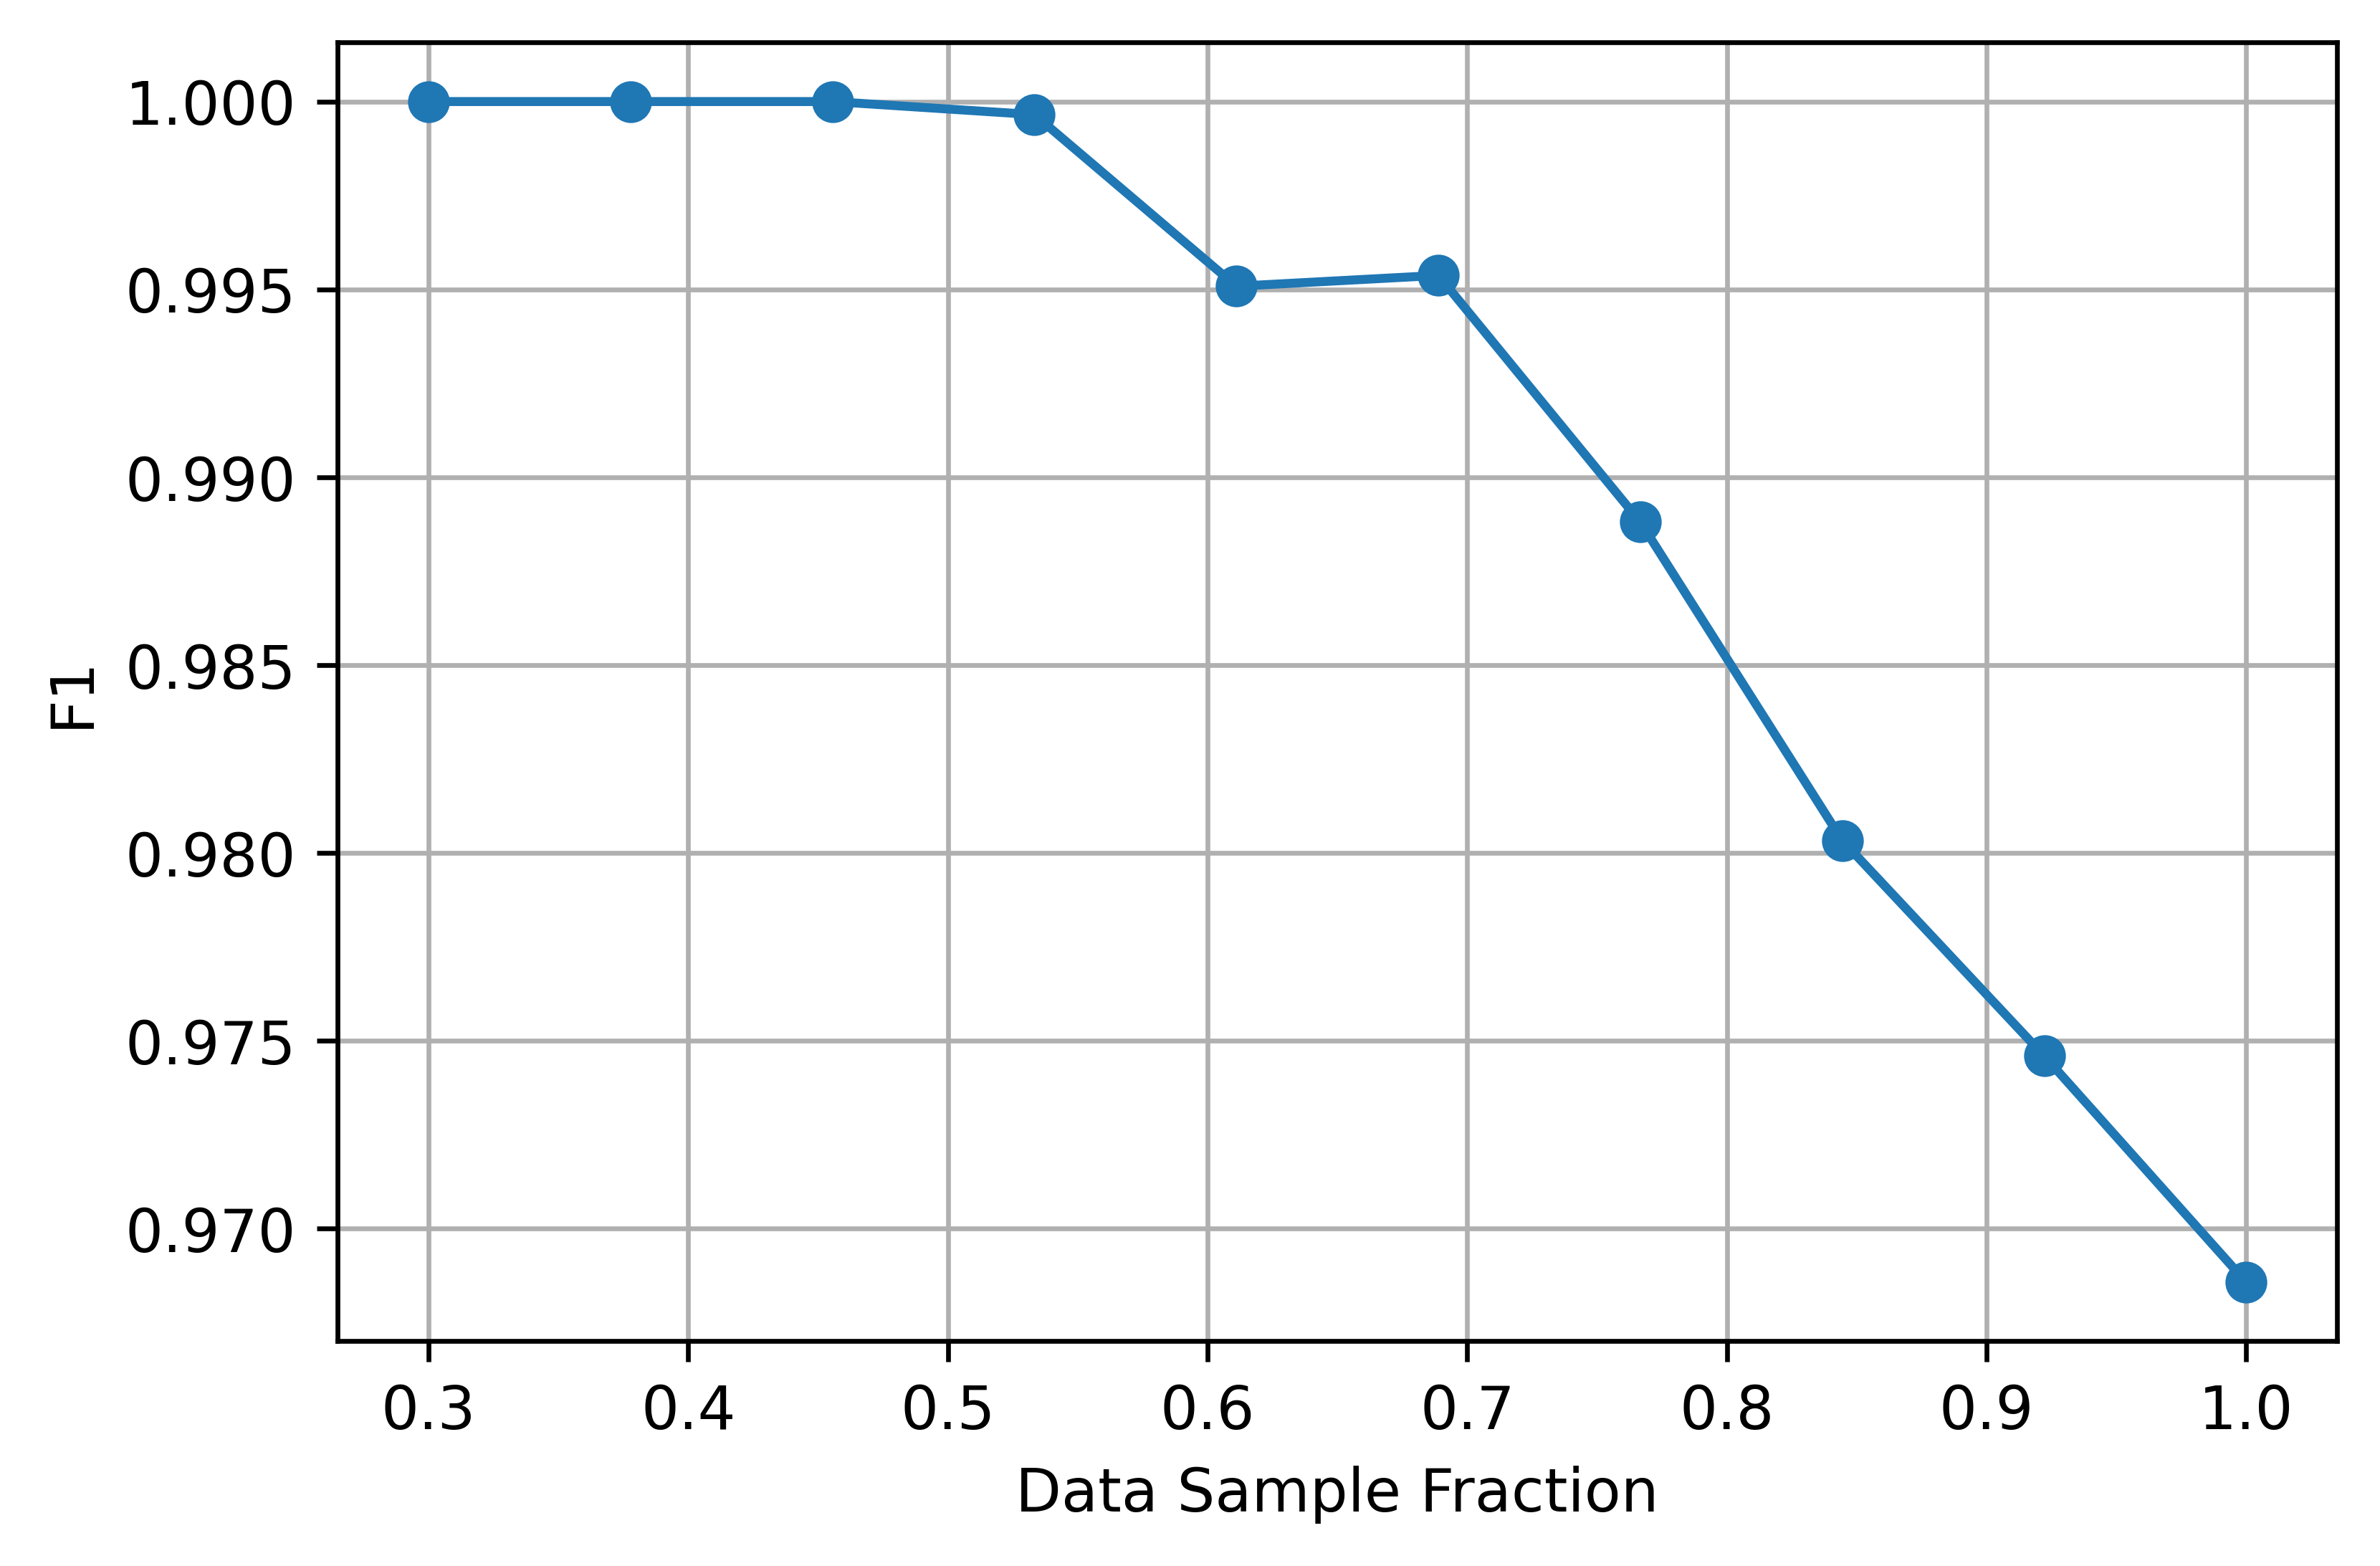

In [34]:
# Custom learning curve Catboost
from sklearn.metrics import f1_score
plt.figure(dpi=600)
plt.grid()
dist = np.linspace(0.3, 1.0, 10)
score_sets = []
params_lc = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'AUC',
    'loss_function': 'MultiClass'
}
for frac in dist:
    X_subset = X.sample(frac=frac)
    y_subset = y.sample(frac=frac)
    clf_lc = CatBoostClassifier(**params_lc)
    clf_lc.fit(X_subset, y_subset)

    ypredict = clf_lc.predict(X_subset)
    f1_weighted_score=f1_score(y_subset, ypredict, average='weighted')
    score_sets.append(f1_weighted_score)

# Plot learningcurve catboost
plt.plot(dist,score_sets, marker='o')
plt.ylabel('F1')
plt.xlabel('Data Sample Fraction')
plt.savefig(os.path.join(model_dir, f"{ml_method}_learningcurve.png"))
plt.show()


Params are set to: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.2, 'custom_loss': 'AUC', 'loss_function': 'MultiClass'}
0:	learn: 0.9657324	total: 7ms	remaining: 7s
1:	learn: 0.7124155	total: 16.1ms	remaining: 8.05s
2:	learn: 0.5329852	total: 24.1ms	remaining: 8.01s
3:	learn: 0.4130375	total: 32.2ms	remaining: 8.01s
4:	learn: 0.3300022	total: 40.7ms	remaining: 8.1s
5:	learn: 0.2686701	total: 51.6ms	remaining: 8.54s
6:	learn: 0.2185668	total: 59.5ms	remaining: 8.44s
7:	learn: 0.1803104	total: 68.1ms	remaining: 8.44s
8:	learn: 0.1491246	total: 75.9ms	remaining: 8.35s
9:	learn: 0.1244349	total: 84.5ms	remaining: 8.37s
10:	learn: 0.1051728	total: 92.7ms	remaining: 8.34s
11:	learn: 0.0890101	total: 101ms	remaining: 8.34s
12:	learn: 0.0768026	total: 109ms	remaining: 8.29s
13:	learn: 0.0666603	total: 118ms	remaining: 8.3s
14:	learn: 0.0576918	total: 127ms	remaining: 8.36s
15:	learn: 0.0507309	total: 136ms	remaining: 8.37s
16:	learn: 0.0452032	total: 144ms	remaining: 8.34s
17:	learn: 0.

166:	learn: 0.0033658	total: 1.37s	remaining: 6.85s
167:	learn: 0.0033471	total: 1.38s	remaining: 6.84s
168:	learn: 0.0033110	total: 1.39s	remaining: 6.84s
169:	learn: 0.0032991	total: 1.4s	remaining: 6.83s
170:	learn: 0.0032912	total: 1.41s	remaining: 6.82s
171:	learn: 0.0032367	total: 1.41s	remaining: 6.81s
172:	learn: 0.0031954	total: 1.42s	remaining: 6.8s
173:	learn: 0.0031713	total: 1.43s	remaining: 6.8s
174:	learn: 0.0031643	total: 1.44s	remaining: 6.79s
175:	learn: 0.0031506	total: 1.45s	remaining: 6.79s
176:	learn: 0.0031320	total: 1.46s	remaining: 6.78s
177:	learn: 0.0031022	total: 1.47s	remaining: 6.78s
178:	learn: 0.0030831	total: 1.48s	remaining: 6.77s
179:	learn: 0.0030624	total: 1.48s	remaining: 6.76s
180:	learn: 0.0030328	total: 1.49s	remaining: 6.75s
181:	learn: 0.0030187	total: 1.5s	remaining: 6.75s
182:	learn: 0.0030051	total: 1.51s	remaining: 6.73s
183:	learn: 0.0029833	total: 1.51s	remaining: 6.72s
184:	learn: 0.0029523	total: 1.52s	remaining: 6.71s
185:	learn: 0.00

333:	learn: 0.0012871	total: 2.75s	remaining: 5.49s
334:	learn: 0.0012744	total: 2.76s	remaining: 5.49s
335:	learn: 0.0012557	total: 2.77s	remaining: 5.48s
336:	learn: 0.0012538	total: 2.78s	remaining: 5.47s
337:	learn: 0.0012520	total: 2.79s	remaining: 5.46s
338:	learn: 0.0012482	total: 2.79s	remaining: 5.45s
339:	learn: 0.0012451	total: 2.8s	remaining: 5.44s
340:	learn: 0.0012434	total: 2.81s	remaining: 5.43s
341:	learn: 0.0012399	total: 2.82s	remaining: 5.42s
342:	learn: 0.0012383	total: 2.82s	remaining: 5.41s
343:	learn: 0.0012342	total: 2.83s	remaining: 5.4s
344:	learn: 0.0012313	total: 2.84s	remaining: 5.39s
345:	learn: 0.0012270	total: 2.85s	remaining: 5.38s
346:	learn: 0.0012244	total: 2.86s	remaining: 5.38s
347:	learn: 0.0012223	total: 2.87s	remaining: 5.37s
348:	learn: 0.0012156	total: 2.88s	remaining: 5.36s
349:	learn: 0.0012080	total: 2.88s	remaining: 5.35s
350:	learn: 0.0012033	total: 2.89s	remaining: 5.34s
351:	learn: 0.0011983	total: 2.9s	remaining: 5.33s
352:	learn: 0.0

497:	learn: 0.0007586	total: 4.13s	remaining: 4.17s
498:	learn: 0.0007572	total: 4.14s	remaining: 4.16s
499:	learn: 0.0007552	total: 4.15s	remaining: 4.15s
500:	learn: 0.0007540	total: 4.16s	remaining: 4.14s
501:	learn: 0.0007514	total: 4.16s	remaining: 4.13s
502:	learn: 0.0007500	total: 4.17s	remaining: 4.12s
503:	learn: 0.0007488	total: 4.18s	remaining: 4.11s
504:	learn: 0.0007469	total: 4.18s	remaining: 4.1s
505:	learn: 0.0007447	total: 4.19s	remaining: 4.09s
506:	learn: 0.0007412	total: 4.2s	remaining: 4.08s
507:	learn: 0.0007369	total: 4.21s	remaining: 4.07s
508:	learn: 0.0007347	total: 4.21s	remaining: 4.07s
509:	learn: 0.0007333	total: 4.22s	remaining: 4.06s
510:	learn: 0.0007326	total: 4.23s	remaining: 4.05s
511:	learn: 0.0007315	total: 4.24s	remaining: 4.04s
512:	learn: 0.0007293	total: 4.24s	remaining: 4.03s
513:	learn: 0.0007281	total: 4.25s	remaining: 4.02s
514:	learn: 0.0007273	total: 4.26s	remaining: 4.01s
515:	learn: 0.0007258	total: 4.26s	remaining: 4s
516:	learn: 0.000

679:	learn: 0.0005230	total: 5.54s	remaining: 2.61s
680:	learn: 0.0005215	total: 5.55s	remaining: 2.6s
681:	learn: 0.0005200	total: 5.56s	remaining: 2.59s
682:	learn: 0.0005194	total: 5.57s	remaining: 2.58s
683:	learn: 0.0005185	total: 5.58s	remaining: 2.58s
684:	learn: 0.0005159	total: 5.58s	remaining: 2.57s
685:	learn: 0.0005153	total: 5.59s	remaining: 2.56s
686:	learn: 0.0005145	total: 5.6s	remaining: 2.55s
687:	learn: 0.0005143	total: 5.61s	remaining: 2.54s
688:	learn: 0.0005138	total: 5.62s	remaining: 2.54s
689:	learn: 0.0005132	total: 5.63s	remaining: 2.53s
690:	learn: 0.0005129	total: 5.64s	remaining: 2.52s
691:	learn: 0.0005119	total: 5.65s	remaining: 2.51s
692:	learn: 0.0005111	total: 5.66s	remaining: 2.51s
693:	learn: 0.0005103	total: 5.67s	remaining: 2.5s
694:	learn: 0.0005101	total: 5.67s	remaining: 2.49s
695:	learn: 0.0005091	total: 5.68s	remaining: 2.48s
696:	learn: 0.0005087	total: 5.69s	remaining: 2.47s
697:	learn: 0.0005077	total: 5.7s	remaining: 2.47s
698:	learn: 0.00

843:	learn: 0.0004038	total: 6.94s	remaining: 1.28s
844:	learn: 0.0004032	total: 6.94s	remaining: 1.27s
845:	learn: 0.0004026	total: 6.95s	remaining: 1.26s
846:	learn: 0.0004022	total: 6.96s	remaining: 1.26s
847:	learn: 0.0004019	total: 6.97s	remaining: 1.25s
848:	learn: 0.0004014	total: 6.98s	remaining: 1.24s
849:	learn: 0.0004010	total: 6.98s	remaining: 1.23s
850:	learn: 0.0004006	total: 6.99s	remaining: 1.22s
851:	learn: 0.0004000	total: 7s	remaining: 1.22s
852:	learn: 0.0003997	total: 7.01s	remaining: 1.21s
853:	learn: 0.0003991	total: 7.02s	remaining: 1.2s
854:	learn: 0.0003988	total: 7.02s	remaining: 1.19s
855:	learn: 0.0003986	total: 7.03s	remaining: 1.18s
856:	learn: 0.0003980	total: 7.04s	remaining: 1.17s
857:	learn: 0.0003975	total: 7.05s	remaining: 1.17s
858:	learn: 0.0003973	total: 7.05s	remaining: 1.16s
859:	learn: 0.0003970	total: 7.06s	remaining: 1.15s
860:	learn: 0.0003964	total: 7.07s	remaining: 1.14s
861:	learn: 0.0003961	total: 7.08s	remaining: 1.13s
862:	learn: 0.00

18:	learn: 0.0404029	total: 145ms	remaining: 7.47s
19:	learn: 0.0372899	total: 153ms	remaining: 7.49s
20:	learn: 0.0348668	total: 162ms	remaining: 7.55s
21:	learn: 0.0324642	total: 169ms	remaining: 7.52s
22:	learn: 0.0306159	total: 183ms	remaining: 7.76s
23:	learn: 0.0292196	total: 192ms	remaining: 7.8s
24:	learn: 0.0279436	total: 200ms	remaining: 7.81s
25:	learn: 0.0265246	total: 209ms	remaining: 7.84s
26:	learn: 0.0256814	total: 217ms	remaining: 7.84s
27:	learn: 0.0246246	total: 226ms	remaining: 7.84s
28:	learn: 0.0239922	total: 236ms	remaining: 7.89s
29:	learn: 0.0232683	total: 246ms	remaining: 7.96s
30:	learn: 0.0224870	total: 256ms	remaining: 7.99s
31:	learn: 0.0218100	total: 268ms	remaining: 8.1s
32:	learn: 0.0210932	total: 278ms	remaining: 8.14s
33:	learn: 0.0204363	total: 286ms	remaining: 8.13s
34:	learn: 0.0197757	total: 298ms	remaining: 8.2s
35:	learn: 0.0193755	total: 311ms	remaining: 8.32s
36:	learn: 0.0189053	total: 320ms	remaining: 8.32s
37:	learn: 0.0184751	total: 329ms	

181:	learn: 0.0033382	total: 1.51s	remaining: 6.8s
182:	learn: 0.0033066	total: 1.52s	remaining: 6.79s
183:	learn: 0.0032988	total: 1.53s	remaining: 6.78s
184:	learn: 0.0032717	total: 1.54s	remaining: 6.77s
185:	learn: 0.0032623	total: 1.54s	remaining: 6.76s
186:	learn: 0.0032378	total: 1.55s	remaining: 6.75s
187:	learn: 0.0032071	total: 1.56s	remaining: 6.74s
188:	learn: 0.0031929	total: 1.57s	remaining: 6.73s
189:	learn: 0.0031609	total: 1.58s	remaining: 6.72s
190:	learn: 0.0031480	total: 1.58s	remaining: 6.71s
191:	learn: 0.0031272	total: 1.59s	remaining: 6.71s
192:	learn: 0.0030920	total: 1.61s	remaining: 6.72s
193:	learn: 0.0030648	total: 1.62s	remaining: 6.71s
194:	learn: 0.0030323	total: 1.62s	remaining: 6.7s
195:	learn: 0.0030078	total: 1.63s	remaining: 6.69s
196:	learn: 0.0029757	total: 1.64s	remaining: 6.69s
197:	learn: 0.0029637	total: 1.65s	remaining: 6.68s
198:	learn: 0.0029504	total: 1.66s	remaining: 6.67s
199:	learn: 0.0029250	total: 1.67s	remaining: 6.66s
200:	learn: 0.

351:	learn: 0.0013646	total: 2.91s	remaining: 5.36s
352:	learn: 0.0013614	total: 2.92s	remaining: 5.36s
353:	learn: 0.0013566	total: 2.93s	remaining: 5.35s
354:	learn: 0.0013510	total: 2.94s	remaining: 5.34s
355:	learn: 0.0013462	total: 2.95s	remaining: 5.33s
356:	learn: 0.0013382	total: 2.96s	remaining: 5.32s
357:	learn: 0.0013360	total: 2.96s	remaining: 5.31s
358:	learn: 0.0013318	total: 2.97s	remaining: 5.3s
359:	learn: 0.0013262	total: 2.98s	remaining: 5.29s
360:	learn: 0.0013210	total: 2.98s	remaining: 5.28s
361:	learn: 0.0013168	total: 2.99s	remaining: 5.27s
362:	learn: 0.0013123	total: 3s	remaining: 5.26s
363:	learn: 0.0013075	total: 3.01s	remaining: 5.25s
364:	learn: 0.0013030	total: 3.01s	remaining: 5.24s
365:	learn: 0.0013003	total: 3.02s	remaining: 5.23s
366:	learn: 0.0012977	total: 3.03s	remaining: 5.22s
367:	learn: 0.0012930	total: 3.04s	remaining: 5.21s
368:	learn: 0.0012896	total: 3.04s	remaining: 5.2s
369:	learn: 0.0012849	total: 3.05s	remaining: 5.19s
370:	learn: 0.001

525:	learn: 0.0008311	total: 4.31s	remaining: 3.88s
526:	learn: 0.0008286	total: 4.32s	remaining: 3.87s
527:	learn: 0.0008274	total: 4.32s	remaining: 3.87s
528:	learn: 0.0008254	total: 4.33s	remaining: 3.86s
529:	learn: 0.0008243	total: 4.34s	remaining: 3.85s
530:	learn: 0.0008228	total: 4.35s	remaining: 3.84s
531:	learn: 0.0008215	total: 4.35s	remaining: 3.83s
532:	learn: 0.0008203	total: 4.36s	remaining: 3.82s
533:	learn: 0.0008185	total: 4.38s	remaining: 3.82s
534:	learn: 0.0008175	total: 4.38s	remaining: 3.81s
535:	learn: 0.0008155	total: 4.39s	remaining: 3.8s
536:	learn: 0.0008132	total: 4.4s	remaining: 3.79s
537:	learn: 0.0008122	total: 4.41s	remaining: 3.78s
538:	learn: 0.0008108	total: 4.41s	remaining: 3.77s
539:	learn: 0.0008097	total: 4.42s	remaining: 3.77s
540:	learn: 0.0008081	total: 4.43s	remaining: 3.76s
541:	learn: 0.0008069	total: 4.44s	remaining: 3.75s
542:	learn: 0.0008058	total: 4.45s	remaining: 3.74s
543:	learn: 0.0008044	total: 4.45s	remaining: 3.73s
544:	learn: 0.

692:	learn: 0.0005984	total: 5.72s	remaining: 2.53s
693:	learn: 0.0005975	total: 5.73s	remaining: 2.52s
694:	learn: 0.0005963	total: 5.74s	remaining: 2.52s
695:	learn: 0.0005955	total: 5.75s	remaining: 2.51s
696:	learn: 0.0005946	total: 5.75s	remaining: 2.5s
697:	learn: 0.0005923	total: 5.76s	remaining: 2.49s
698:	learn: 0.0005914	total: 5.77s	remaining: 2.48s
699:	learn: 0.0005904	total: 5.78s	remaining: 2.48s
700:	learn: 0.0005891	total: 5.78s	remaining: 2.47s
701:	learn: 0.0005882	total: 5.79s	remaining: 2.46s
702:	learn: 0.0005871	total: 5.8s	remaining: 2.45s
703:	learn: 0.0005866	total: 5.81s	remaining: 2.44s
704:	learn: 0.0005850	total: 5.81s	remaining: 2.43s
705:	learn: 0.0005839	total: 5.82s	remaining: 2.42s
706:	learn: 0.0005830	total: 5.83s	remaining: 2.42s
707:	learn: 0.0005825	total: 5.83s	remaining: 2.41s
708:	learn: 0.0005817	total: 5.84s	remaining: 2.4s
709:	learn: 0.0005812	total: 5.85s	remaining: 2.39s
710:	learn: 0.0005804	total: 5.86s	remaining: 2.38s
711:	learn: 0.0

876:	learn: 0.0004558	total: 7.13s	remaining: 1s
877:	learn: 0.0004553	total: 7.14s	remaining: 992ms
878:	learn: 0.0004545	total: 7.15s	remaining: 984ms
879:	learn: 0.0004543	total: 7.16s	remaining: 976ms
880:	learn: 0.0004536	total: 7.16s	remaining: 968ms
881:	learn: 0.0004530	total: 7.17s	remaining: 960ms
882:	learn: 0.0004524	total: 7.18s	remaining: 952ms
883:	learn: 0.0004515	total: 7.19s	remaining: 943ms
884:	learn: 0.0004509	total: 7.2s	remaining: 935ms
885:	learn: 0.0004506	total: 7.2s	remaining: 927ms
886:	learn: 0.0004500	total: 7.21s	remaining: 919ms
887:	learn: 0.0004493	total: 7.22s	remaining: 910ms
888:	learn: 0.0004484	total: 7.22s	remaining: 902ms
889:	learn: 0.0004482	total: 7.23s	remaining: 894ms
890:	learn: 0.0004475	total: 7.24s	remaining: 886ms
891:	learn: 0.0004469	total: 7.25s	remaining: 878ms
892:	learn: 0.0004457	total: 7.25s	remaining: 869ms
893:	learn: 0.0004445	total: 7.26s	remaining: 861ms
894:	learn: 0.0004438	total: 7.27s	remaining: 853ms
895:	learn: 0.000

55:	learn: 0.0123663	total: 533ms	remaining: 8.98s
56:	learn: 0.0121723	total: 541ms	remaining: 8.96s
57:	learn: 0.0119558	total: 550ms	remaining: 8.93s
58:	learn: 0.0118100	total: 558ms	remaining: 8.89s
59:	learn: 0.0117773	total: 565ms	remaining: 8.85s
60:	learn: 0.0115727	total: 572ms	remaining: 8.8s
61:	learn: 0.0113183	total: 580ms	remaining: 8.77s
62:	learn: 0.0112345	total: 587ms	remaining: 8.73s
63:	learn: 0.0110922	total: 596ms	remaining: 8.72s
64:	learn: 0.0110424	total: 604ms	remaining: 8.69s
65:	learn: 0.0108623	total: 612ms	remaining: 8.66s
66:	learn: 0.0106911	total: 619ms	remaining: 8.61s
67:	learn: 0.0106227	total: 624ms	remaining: 8.54s
68:	learn: 0.0104534	total: 632ms	remaining: 8.52s
69:	learn: 0.0103296	total: 640ms	remaining: 8.51s
70:	learn: 0.0102331	total: 650ms	remaining: 8.5s
71:	learn: 0.0101238	total: 660ms	remaining: 8.5s
72:	learn: 0.0099362	total: 670ms	remaining: 8.51s
73:	learn: 0.0098177	total: 678ms	remaining: 8.48s
74:	learn: 0.0096991	total: 688ms	

236:	learn: 0.0021688	total: 2.14s	remaining: 6.89s
237:	learn: 0.0021581	total: 2.15s	remaining: 6.88s
238:	learn: 0.0021449	total: 2.16s	remaining: 6.87s
239:	learn: 0.0021264	total: 2.17s	remaining: 6.86s
240:	learn: 0.0021115	total: 2.17s	remaining: 6.84s
241:	learn: 0.0021058	total: 2.18s	remaining: 6.83s
242:	learn: 0.0020897	total: 2.19s	remaining: 6.82s
243:	learn: 0.0020799	total: 2.19s	remaining: 6.8s
244:	learn: 0.0020684	total: 2.2s	remaining: 6.79s
245:	learn: 0.0020557	total: 2.21s	remaining: 6.77s
246:	learn: 0.0020371	total: 2.22s	remaining: 6.76s
247:	learn: 0.0020347	total: 2.22s	remaining: 6.75s
248:	learn: 0.0020303	total: 2.23s	remaining: 6.73s
249:	learn: 0.0020069	total: 2.24s	remaining: 6.72s
250:	learn: 0.0019957	total: 2.25s	remaining: 6.71s
251:	learn: 0.0019757	total: 2.25s	remaining: 6.69s
252:	learn: 0.0019693	total: 2.26s	remaining: 6.68s
253:	learn: 0.0019609	total: 2.27s	remaining: 6.66s
254:	learn: 0.0019547	total: 2.27s	remaining: 6.65s
255:	learn: 0.

419:	learn: 0.0010196	total: 3.53s	remaining: 4.88s
420:	learn: 0.0010158	total: 3.54s	remaining: 4.87s
421:	learn: 0.0010079	total: 3.54s	remaining: 4.86s
422:	learn: 0.0010023	total: 3.55s	remaining: 4.85s
423:	learn: 0.0009990	total: 3.56s	remaining: 4.84s
424:	learn: 0.0009964	total: 3.57s	remaining: 4.83s
425:	learn: 0.0009941	total: 3.58s	remaining: 4.82s
426:	learn: 0.0009908	total: 3.58s	remaining: 4.81s
427:	learn: 0.0009845	total: 3.59s	remaining: 4.8s
428:	learn: 0.0009821	total: 3.6s	remaining: 4.79s
429:	learn: 0.0009806	total: 3.6s	remaining: 4.78s
430:	learn: 0.0009775	total: 3.61s	remaining: 4.77s
431:	learn: 0.0009758	total: 3.62s	remaining: 4.76s
432:	learn: 0.0009712	total: 3.63s	remaining: 4.75s
433:	learn: 0.0009673	total: 3.64s	remaining: 4.75s
434:	learn: 0.0009661	total: 3.65s	remaining: 4.74s
435:	learn: 0.0009638	total: 3.66s	remaining: 4.73s
436:	learn: 0.0009612	total: 3.67s	remaining: 4.72s
437:	learn: 0.0009596	total: 3.67s	remaining: 4.71s
438:	learn: 0.0

595:	learn: 0.0006583	total: 4.93s	remaining: 3.34s
596:	learn: 0.0006567	total: 4.93s	remaining: 3.33s
597:	learn: 0.0006555	total: 4.94s	remaining: 3.32s
598:	learn: 0.0006542	total: 4.95s	remaining: 3.31s
599:	learn: 0.0006521	total: 4.96s	remaining: 3.31s
600:	learn: 0.0006507	total: 4.97s	remaining: 3.3s
601:	learn: 0.0006486	total: 4.98s	remaining: 3.29s
602:	learn: 0.0006473	total: 4.99s	remaining: 3.29s
603:	learn: 0.0006457	total: 5s	remaining: 3.28s
604:	learn: 0.0006435	total: 5s	remaining: 3.27s
605:	learn: 0.0006419	total: 5.01s	remaining: 3.26s
606:	learn: 0.0006409	total: 5.02s	remaining: 3.25s
607:	learn: 0.0006381	total: 5.03s	remaining: 3.24s
608:	learn: 0.0006359	total: 5.04s	remaining: 3.23s
609:	learn: 0.0006349	total: 5.05s	remaining: 3.23s
610:	learn: 0.0006337	total: 5.05s	remaining: 3.22s
611:	learn: 0.0006325	total: 5.06s	remaining: 3.21s
612:	learn: 0.0006317	total: 5.07s	remaining: 3.2s
613:	learn: 0.0006307	total: 5.08s	remaining: 3.19s
614:	learn: 0.000629

764:	learn: 0.0004827	total: 6.32s	remaining: 1.94s
765:	learn: 0.0004823	total: 6.33s	remaining: 1.93s
766:	learn: 0.0004816	total: 6.34s	remaining: 1.93s
767:	learn: 0.0004809	total: 6.35s	remaining: 1.92s
768:	learn: 0.0004803	total: 6.36s	remaining: 1.91s
769:	learn: 0.0004797	total: 6.36s	remaining: 1.9s
770:	learn: 0.0004789	total: 6.37s	remaining: 1.89s
771:	learn: 0.0004785	total: 6.38s	remaining: 1.88s
772:	learn: 0.0004773	total: 6.39s	remaining: 1.88s
773:	learn: 0.0004763	total: 6.39s	remaining: 1.87s
774:	learn: 0.0004757	total: 6.4s	remaining: 1.86s
775:	learn: 0.0004750	total: 6.41s	remaining: 1.85s
776:	learn: 0.0004743	total: 6.42s	remaining: 1.84s
777:	learn: 0.0004737	total: 6.43s	remaining: 1.83s
778:	learn: 0.0004731	total: 6.44s	remaining: 1.83s
779:	learn: 0.0004726	total: 6.45s	remaining: 1.82s
780:	learn: 0.0004723	total: 6.45s	remaining: 1.81s
781:	learn: 0.0004714	total: 6.46s	remaining: 1.8s
782:	learn: 0.0004709	total: 6.47s	remaining: 1.79s
783:	learn: 0.0

933:	learn: 0.0003838	total: 7.72s	remaining: 546ms
934:	learn: 0.0003831	total: 7.73s	remaining: 537ms
935:	learn: 0.0003828	total: 7.74s	remaining: 529ms
936:	learn: 0.0003822	total: 7.75s	remaining: 521ms
937:	learn: 0.0003818	total: 7.75s	remaining: 513ms
938:	learn: 0.0003811	total: 7.76s	remaining: 504ms
939:	learn: 0.0003805	total: 7.77s	remaining: 496ms
940:	learn: 0.0003800	total: 7.78s	remaining: 488ms
941:	learn: 0.0003796	total: 7.79s	remaining: 480ms
942:	learn: 0.0003788	total: 7.8s	remaining: 472ms
943:	learn: 0.0003783	total: 7.81s	remaining: 464ms
944:	learn: 0.0003779	total: 7.82s	remaining: 455ms
945:	learn: 0.0003775	total: 7.83s	remaining: 447ms
946:	learn: 0.0003764	total: 7.84s	remaining: 439ms
947:	learn: 0.0003760	total: 7.84s	remaining: 430ms
948:	learn: 0.0003757	total: 7.85s	remaining: 422ms
949:	learn: 0.0003751	total: 7.86s	remaining: 414ms
950:	learn: 0.0003747	total: 7.87s	remaining: 405ms
951:	learn: 0.0003743	total: 7.88s	remaining: 397ms
952:	learn: 0

105:	learn: 0.0067192	total: 840ms	remaining: 7.09s
106:	learn: 0.0066255	total: 848ms	remaining: 7.08s
107:	learn: 0.0065820	total: 855ms	remaining: 7.07s
108:	learn: 0.0064662	total: 863ms	remaining: 7.06s
109:	learn: 0.0064347	total: 871ms	remaining: 7.04s
110:	learn: 0.0063492	total: 879ms	remaining: 7.04s
111:	learn: 0.0062905	total: 888ms	remaining: 7.04s
112:	learn: 0.0062542	total: 896ms	remaining: 7.03s
113:	learn: 0.0062038	total: 904ms	remaining: 7.03s
114:	learn: 0.0061253	total: 912ms	remaining: 7.02s
115:	learn: 0.0060875	total: 919ms	remaining: 7.01s
116:	learn: 0.0059617	total: 927ms	remaining: 6.99s
117:	learn: 0.0059261	total: 934ms	remaining: 6.98s
118:	learn: 0.0058351	total: 942ms	remaining: 6.97s
119:	learn: 0.0058092	total: 949ms	remaining: 6.96s
120:	learn: 0.0057799	total: 958ms	remaining: 6.96s
121:	learn: 0.0057345	total: 966ms	remaining: 6.95s
122:	learn: 0.0056650	total: 975ms	remaining: 6.95s
123:	learn: 0.0055871	total: 983ms	remaining: 6.95s
124:	learn: 

277:	learn: 0.0017692	total: 2.67s	remaining: 6.93s
278:	learn: 0.0017612	total: 2.68s	remaining: 6.92s
279:	learn: 0.0017559	total: 2.69s	remaining: 6.91s
280:	learn: 0.0017496	total: 2.7s	remaining: 6.9s
281:	learn: 0.0017409	total: 2.71s	remaining: 6.9s
282:	learn: 0.0017281	total: 2.72s	remaining: 6.89s
283:	learn: 0.0017189	total: 2.73s	remaining: 6.88s
284:	learn: 0.0017089	total: 2.74s	remaining: 6.87s
285:	learn: 0.0016970	total: 2.75s	remaining: 6.86s
286:	learn: 0.0016891	total: 2.76s	remaining: 6.85s
287:	learn: 0.0016823	total: 2.77s	remaining: 6.84s
288:	learn: 0.0016755	total: 2.77s	remaining: 6.83s
289:	learn: 0.0016661	total: 2.78s	remaining: 6.82s
290:	learn: 0.0016538	total: 2.79s	remaining: 6.81s
291:	learn: 0.0016508	total: 2.8s	remaining: 6.8s
292:	learn: 0.0016451	total: 2.81s	remaining: 6.79s
293:	learn: 0.0016377	total: 2.82s	remaining: 6.78s
294:	learn: 0.0016278	total: 2.83s	remaining: 6.76s
295:	learn: 0.0016207	total: 2.84s	remaining: 6.75s
296:	learn: 0.001

441:	learn: 0.0009479	total: 4.06s	remaining: 5.12s
442:	learn: 0.0009460	total: 4.09s	remaining: 5.14s
443:	learn: 0.0009438	total: 4.1s	remaining: 5.13s
444:	learn: 0.0009427	total: 4.11s	remaining: 5.13s
445:	learn: 0.0009399	total: 4.12s	remaining: 5.12s
446:	learn: 0.0009378	total: 4.13s	remaining: 5.11s
447:	learn: 0.0009353	total: 4.14s	remaining: 5.1s
448:	learn: 0.0009321	total: 4.14s	remaining: 5.09s
449:	learn: 0.0009290	total: 4.16s	remaining: 5.08s
450:	learn: 0.0009264	total: 4.17s	remaining: 5.07s
451:	learn: 0.0009231	total: 4.18s	remaining: 5.06s
452:	learn: 0.0009203	total: 4.18s	remaining: 5.05s
453:	learn: 0.0009180	total: 4.19s	remaining: 5.04s
454:	learn: 0.0009145	total: 4.2s	remaining: 5.03s
455:	learn: 0.0009126	total: 4.21s	remaining: 5.02s
456:	learn: 0.0009082	total: 4.22s	remaining: 5.01s
457:	learn: 0.0009075	total: 4.23s	remaining: 5s
458:	learn: 0.0009055	total: 4.24s	remaining: 4.99s
459:	learn: 0.0009027	total: 4.24s	remaining: 4.98s
460:	learn: 0.0009

606:	learn: 0.0006400	total: 5.45s	remaining: 3.53s
607:	learn: 0.0006392	total: 5.46s	remaining: 3.52s
608:	learn: 0.0006383	total: 5.46s	remaining: 3.51s
609:	learn: 0.0006375	total: 5.47s	remaining: 3.5s
610:	learn: 0.0006364	total: 5.48s	remaining: 3.49s
611:	learn: 0.0006351	total: 5.49s	remaining: 3.48s
612:	learn: 0.0006333	total: 5.5s	remaining: 3.47s
613:	learn: 0.0006320	total: 5.5s	remaining: 3.46s
614:	learn: 0.0006304	total: 5.51s	remaining: 3.45s
615:	learn: 0.0006292	total: 5.52s	remaining: 3.44s
616:	learn: 0.0006286	total: 5.53s	remaining: 3.43s
617:	learn: 0.0006272	total: 5.54s	remaining: 3.42s
618:	learn: 0.0006268	total: 5.55s	remaining: 3.42s
619:	learn: 0.0006260	total: 5.56s	remaining: 3.4s
620:	learn: 0.0006241	total: 5.56s	remaining: 3.4s
621:	learn: 0.0006233	total: 5.57s	remaining: 3.39s
622:	learn: 0.0006225	total: 5.58s	remaining: 3.38s
623:	learn: 0.0006218	total: 5.59s	remaining: 3.37s
624:	learn: 0.0006202	total: 5.59s	remaining: 3.36s
625:	learn: 0.000

777:	learn: 0.0004882	total: 6.85s	remaining: 1.95s
778:	learn: 0.0004878	total: 6.86s	remaining: 1.95s
779:	learn: 0.0004870	total: 6.87s	remaining: 1.94s
780:	learn: 0.0004854	total: 6.88s	remaining: 1.93s
781:	learn: 0.0004845	total: 6.89s	remaining: 1.92s
782:	learn: 0.0004838	total: 6.89s	remaining: 1.91s
783:	learn: 0.0004830	total: 6.9s	remaining: 1.9s
784:	learn: 0.0004825	total: 6.91s	remaining: 1.89s
785:	learn: 0.0004816	total: 6.92s	remaining: 1.88s
786:	learn: 0.0004804	total: 6.92s	remaining: 1.87s
787:	learn: 0.0004801	total: 6.93s	remaining: 1.86s
788:	learn: 0.0004797	total: 6.94s	remaining: 1.86s
789:	learn: 0.0004790	total: 6.95s	remaining: 1.85s
790:	learn: 0.0004782	total: 6.96s	remaining: 1.84s
791:	learn: 0.0004774	total: 6.97s	remaining: 1.83s
792:	learn: 0.0004766	total: 6.98s	remaining: 1.82s
793:	learn: 0.0004756	total: 6.99s	remaining: 1.81s
794:	learn: 0.0004750	total: 7s	remaining: 1.8s
795:	learn: 0.0004744	total: 7s	remaining: 1.79s
796:	learn: 0.0004738

952:	learn: 0.0003876	total: 8.25s	remaining: 407ms
953:	learn: 0.0003872	total: 8.26s	remaining: 398ms
954:	learn: 0.0003867	total: 8.27s	remaining: 390ms
955:	learn: 0.0003862	total: 8.27s	remaining: 381ms
956:	learn: 0.0003857	total: 8.28s	remaining: 372ms
957:	learn: 0.0003853	total: 8.29s	remaining: 363ms
958:	learn: 0.0003848	total: 8.3s	remaining: 355ms
959:	learn: 0.0003845	total: 8.3s	remaining: 346ms
960:	learn: 0.0003837	total: 8.31s	remaining: 337ms
961:	learn: 0.0003834	total: 8.32s	remaining: 329ms
962:	learn: 0.0003830	total: 8.33s	remaining: 320ms
963:	learn: 0.0003825	total: 8.33s	remaining: 311ms
964:	learn: 0.0003821	total: 8.34s	remaining: 303ms
965:	learn: 0.0003817	total: 8.35s	remaining: 294ms
966:	learn: 0.0003816	total: 8.36s	remaining: 285ms
967:	learn: 0.0003813	total: 8.36s	remaining: 276ms
968:	learn: 0.0003806	total: 8.37s	remaining: 268ms
969:	learn: 0.0003802	total: 8.38s	remaining: 259ms
970:	learn: 0.0003798	total: 8.39s	remaining: 250ms
971:	learn: 0.

134:	learn: 0.0036199	total: 1.21s	remaining: 7.73s
135:	learn: 0.0035809	total: 1.23s	remaining: 7.81s
136:	learn: 0.0035657	total: 1.25s	remaining: 7.86s
137:	learn: 0.0035401	total: 1.27s	remaining: 7.94s
138:	learn: 0.0035114	total: 1.28s	remaining: 7.95s
139:	learn: 0.0034866	total: 1.29s	remaining: 7.95s
140:	learn: 0.0034760	total: 1.31s	remaining: 7.98s
141:	learn: 0.0034539	total: 1.32s	remaining: 7.97s
142:	learn: 0.0034045	total: 1.33s	remaining: 7.99s
143:	learn: 0.0033800	total: 1.34s	remaining: 7.99s
144:	learn: 0.0033327	total: 1.35s	remaining: 7.97s
145:	learn: 0.0032900	total: 1.36s	remaining: 7.97s
146:	learn: 0.0032727	total: 1.37s	remaining: 7.97s
147:	learn: 0.0032524	total: 1.38s	remaining: 7.97s
148:	learn: 0.0032375	total: 1.4s	remaining: 7.99s
149:	learn: 0.0031941	total: 1.41s	remaining: 7.98s
150:	learn: 0.0031755	total: 1.42s	remaining: 7.97s
151:	learn: 0.0031469	total: 1.43s	remaining: 7.95s
152:	learn: 0.0031290	total: 1.44s	remaining: 7.97s
153:	learn: 0

310:	learn: 0.0012039	total: 2.81s	remaining: 6.22s
311:	learn: 0.0011996	total: 2.82s	remaining: 6.21s
312:	learn: 0.0011918	total: 2.83s	remaining: 6.21s
313:	learn: 0.0011814	total: 2.84s	remaining: 6.2s
314:	learn: 0.0011775	total: 2.85s	remaining: 6.19s
315:	learn: 0.0011742	total: 2.85s	remaining: 6.18s
316:	learn: 0.0011726	total: 2.86s	remaining: 6.16s
317:	learn: 0.0011655	total: 2.87s	remaining: 6.15s
318:	learn: 0.0011615	total: 2.88s	remaining: 6.14s
319:	learn: 0.0011575	total: 2.88s	remaining: 6.13s
320:	learn: 0.0011529	total: 2.89s	remaining: 6.12s
321:	learn: 0.0011427	total: 2.9s	remaining: 6.11s
322:	learn: 0.0011372	total: 2.91s	remaining: 6.09s
323:	learn: 0.0011332	total: 2.92s	remaining: 6.09s
324:	learn: 0.0011280	total: 2.92s	remaining: 6.07s
325:	learn: 0.0011233	total: 2.93s	remaining: 6.06s
326:	learn: 0.0011174	total: 2.94s	remaining: 6.06s
327:	learn: 0.0011158	total: 2.95s	remaining: 6.05s
328:	learn: 0.0011053	total: 2.96s	remaining: 6.03s
329:	learn: 0.

484:	learn: 0.0006901	total: 4.21s	remaining: 4.46s
485:	learn: 0.0006885	total: 4.21s	remaining: 4.46s
486:	learn: 0.0006874	total: 4.22s	remaining: 4.45s
487:	learn: 0.0006861	total: 4.23s	remaining: 4.44s
488:	learn: 0.0006850	total: 4.24s	remaining: 4.43s
489:	learn: 0.0006843	total: 4.25s	remaining: 4.42s
490:	learn: 0.0006831	total: 4.26s	remaining: 4.42s
491:	learn: 0.0006803	total: 4.27s	remaining: 4.41s
492:	learn: 0.0006781	total: 4.28s	remaining: 4.4s
493:	learn: 0.0006777	total: 4.29s	remaining: 4.39s
494:	learn: 0.0006765	total: 4.3s	remaining: 4.39s
495:	learn: 0.0006746	total: 4.31s	remaining: 4.38s
496:	learn: 0.0006725	total: 4.32s	remaining: 4.37s
497:	learn: 0.0006708	total: 4.33s	remaining: 4.36s
498:	learn: 0.0006699	total: 4.34s	remaining: 4.35s
499:	learn: 0.0006683	total: 4.34s	remaining: 4.34s
500:	learn: 0.0006669	total: 4.35s	remaining: 4.33s
501:	learn: 0.0006650	total: 4.36s	remaining: 4.33s
502:	learn: 0.0006635	total: 4.37s	remaining: 4.32s
503:	learn: 0.

650:	learn: 0.0004943	total: 5.62s	remaining: 3.01s
651:	learn: 0.0004939	total: 5.63s	remaining: 3s
652:	learn: 0.0004928	total: 5.63s	remaining: 2.99s
653:	learn: 0.0004922	total: 5.64s	remaining: 2.98s
654:	learn: 0.0004913	total: 5.65s	remaining: 2.98s
655:	learn: 0.0004907	total: 5.66s	remaining: 2.97s
656:	learn: 0.0004901	total: 5.67s	remaining: 2.96s
657:	learn: 0.0004891	total: 5.67s	remaining: 2.95s
658:	learn: 0.0004877	total: 5.68s	remaining: 2.94s
659:	learn: 0.0004873	total: 5.69s	remaining: 2.93s
660:	learn: 0.0004862	total: 5.7s	remaining: 2.92s
661:	learn: 0.0004859	total: 5.7s	remaining: 2.91s
662:	learn: 0.0004855	total: 5.71s	remaining: 2.9s
663:	learn: 0.0004845	total: 5.72s	remaining: 2.89s
664:	learn: 0.0004836	total: 5.73s	remaining: 2.88s
665:	learn: 0.0004832	total: 5.74s	remaining: 2.88s
666:	learn: 0.0004825	total: 5.74s	remaining: 2.87s
667:	learn: 0.0004824	total: 5.75s	remaining: 2.86s
668:	learn: 0.0004805	total: 5.76s	remaining: 2.85s
669:	learn: 0.0004

809:	learn: 0.0003823	total: 7.02s	remaining: 1.65s
810:	learn: 0.0003821	total: 7.03s	remaining: 1.64s
811:	learn: 0.0003818	total: 7.03s	remaining: 1.63s
812:	learn: 0.0003814	total: 7.04s	remaining: 1.62s
813:	learn: 0.0003810	total: 7.05s	remaining: 1.61s
814:	learn: 0.0003805	total: 7.06s	remaining: 1.6s
815:	learn: 0.0003798	total: 7.07s	remaining: 1.59s
816:	learn: 0.0003792	total: 7.07s	remaining: 1.58s
817:	learn: 0.0003789	total: 7.08s	remaining: 1.57s
818:	learn: 0.0003786	total: 7.09s	remaining: 1.57s
819:	learn: 0.0003771	total: 7.1s	remaining: 1.56s
820:	learn: 0.0003761	total: 7.1s	remaining: 1.55s
821:	learn: 0.0003755	total: 7.11s	remaining: 1.54s
822:	learn: 0.0003747	total: 7.12s	remaining: 1.53s
823:	learn: 0.0003741	total: 7.13s	remaining: 1.52s
824:	learn: 0.0003738	total: 7.13s	remaining: 1.51s
825:	learn: 0.0003737	total: 7.14s	remaining: 1.5s
826:	learn: 0.0003733	total: 7.15s	remaining: 1.5s
827:	learn: 0.0003729	total: 7.16s	remaining: 1.49s
828:	learn: 0.000

980:	learn: 0.0003079	total: 8.42s	remaining: 163ms
981:	learn: 0.0003078	total: 8.43s	remaining: 155ms
982:	learn: 0.0003071	total: 8.44s	remaining: 146ms
983:	learn: 0.0003067	total: 8.45s	remaining: 137ms
984:	learn: 0.0003064	total: 8.45s	remaining: 129ms
985:	learn: 0.0003061	total: 8.46s	remaining: 120ms
986:	learn: 0.0003057	total: 8.47s	remaining: 112ms
987:	learn: 0.0003053	total: 8.48s	remaining: 103ms
988:	learn: 0.0003049	total: 8.49s	remaining: 94.4ms
989:	learn: 0.0003046	total: 8.49s	remaining: 85.8ms
990:	learn: 0.0003044	total: 8.5s	remaining: 77.2ms
991:	learn: 0.0003042	total: 8.51s	remaining: 68.6ms
992:	learn: 0.0003039	total: 8.52s	remaining: 60ms
993:	learn: 0.0003037	total: 8.53s	remaining: 51.5ms
994:	learn: 0.0003032	total: 8.53s	remaining: 42.9ms
995:	learn: 0.0003025	total: 8.54s	remaining: 34.3ms
996:	learn: 0.0003017	total: 8.55s	remaining: 25.7ms
997:	learn: 0.0003015	total: 8.56s	remaining: 17.1ms
998:	learn: 0.0003013	total: 8.56s	remaining: 8.57ms
999:

154:	learn: 0.0037779	total: 1.22s	remaining: 6.65s
155:	learn: 0.0037406	total: 1.23s	remaining: 6.67s
156:	learn: 0.0037057	total: 1.24s	remaining: 6.66s
157:	learn: 0.0036819	total: 1.25s	remaining: 6.66s
158:	learn: 0.0036276	total: 1.26s	remaining: 6.65s
159:	learn: 0.0035560	total: 1.27s	remaining: 6.65s
160:	learn: 0.0035209	total: 1.27s	remaining: 6.65s
161:	learn: 0.0035037	total: 1.28s	remaining: 6.64s
162:	learn: 0.0034974	total: 1.29s	remaining: 6.64s
163:	learn: 0.0034581	total: 1.3s	remaining: 6.63s
164:	learn: 0.0034207	total: 1.31s	remaining: 6.62s
165:	learn: 0.0033952	total: 1.32s	remaining: 6.62s
166:	learn: 0.0033658	total: 1.33s	remaining: 6.62s
167:	learn: 0.0033471	total: 1.33s	remaining: 6.61s
168:	learn: 0.0033110	total: 1.34s	remaining: 6.6s
169:	learn: 0.0032991	total: 1.35s	remaining: 6.6s
170:	learn: 0.0032912	total: 1.36s	remaining: 6.59s
171:	learn: 0.0032367	total: 1.37s	remaining: 6.59s
172:	learn: 0.0031954	total: 1.38s	remaining: 6.58s
173:	learn: 0.0

338:	learn: 0.0012482	total: 2.64s	remaining: 5.15s
339:	learn: 0.0012451	total: 2.65s	remaining: 5.15s
340:	learn: 0.0012434	total: 2.66s	remaining: 5.14s
341:	learn: 0.0012399	total: 2.67s	remaining: 5.13s
342:	learn: 0.0012383	total: 2.67s	remaining: 5.12s
343:	learn: 0.0012342	total: 2.68s	remaining: 5.12s
344:	learn: 0.0012313	total: 2.69s	remaining: 5.11s
345:	learn: 0.0012270	total: 2.7s	remaining: 5.1s
346:	learn: 0.0012244	total: 2.71s	remaining: 5.09s
347:	learn: 0.0012223	total: 2.71s	remaining: 5.08s
348:	learn: 0.0012156	total: 2.72s	remaining: 5.08s
349:	learn: 0.0012080	total: 2.73s	remaining: 5.07s
350:	learn: 0.0012033	total: 2.73s	remaining: 5.06s
351:	learn: 0.0011983	total: 2.74s	remaining: 5.05s
352:	learn: 0.0011952	total: 2.75s	remaining: 5.04s
353:	learn: 0.0011914	total: 2.76s	remaining: 5.03s
354:	learn: 0.0011870	total: 2.77s	remaining: 5.02s
355:	learn: 0.0011778	total: 2.77s	remaining: 5.02s
356:	learn: 0.0011737	total: 2.78s	remaining: 5.01s
357:	learn: 0.

519:	learn: 0.0007189	total: 4.03s	remaining: 3.72s
520:	learn: 0.0007179	total: 4.04s	remaining: 3.71s
521:	learn: 0.0007155	total: 4.05s	remaining: 3.71s
522:	learn: 0.0007146	total: 4.06s	remaining: 3.7s
523:	learn: 0.0007141	total: 4.06s	remaining: 3.69s
524:	learn: 0.0007130	total: 4.07s	remaining: 3.68s
525:	learn: 0.0007114	total: 4.08s	remaining: 3.68s
526:	learn: 0.0007100	total: 4.09s	remaining: 3.67s
527:	learn: 0.0007092	total: 4.09s	remaining: 3.66s
528:	learn: 0.0007084	total: 4.1s	remaining: 3.65s
529:	learn: 0.0007079	total: 4.11s	remaining: 3.64s
530:	learn: 0.0007062	total: 4.12s	remaining: 3.63s
531:	learn: 0.0007045	total: 4.12s	remaining: 3.63s
532:	learn: 0.0007041	total: 4.13s	remaining: 3.62s
533:	learn: 0.0007015	total: 4.14s	remaining: 3.61s
534:	learn: 0.0007001	total: 4.14s	remaining: 3.6s
535:	learn: 0.0006980	total: 4.15s	remaining: 3.59s
536:	learn: 0.0006947	total: 4.16s	remaining: 3.59s
537:	learn: 0.0006939	total: 4.17s	remaining: 3.58s
538:	learn: 0.0

681:	learn: 0.0005200	total: 5.24s	remaining: 2.44s
682:	learn: 0.0005194	total: 5.25s	remaining: 2.43s
683:	learn: 0.0005185	total: 5.25s	remaining: 2.43s
684:	learn: 0.0005159	total: 5.26s	remaining: 2.42s
685:	learn: 0.0005153	total: 5.27s	remaining: 2.41s
686:	learn: 0.0005145	total: 5.28s	remaining: 2.4s
687:	learn: 0.0005143	total: 5.28s	remaining: 2.4s
688:	learn: 0.0005138	total: 5.29s	remaining: 2.39s
689:	learn: 0.0005132	total: 5.3s	remaining: 2.38s
690:	learn: 0.0005129	total: 5.3s	remaining: 2.37s
691:	learn: 0.0005119	total: 5.31s	remaining: 2.36s
692:	learn: 0.0005111	total: 5.32s	remaining: 2.36s
693:	learn: 0.0005103	total: 5.33s	remaining: 2.35s
694:	learn: 0.0005101	total: 5.33s	remaining: 2.34s
695:	learn: 0.0005091	total: 5.34s	remaining: 2.33s
696:	learn: 0.0005087	total: 5.35s	remaining: 2.33s
697:	learn: 0.0005077	total: 5.36s	remaining: 2.32s
698:	learn: 0.0005071	total: 5.36s	remaining: 2.31s
699:	learn: 0.0005065	total: 5.37s	remaining: 2.3s
700:	learn: 0.000

840:	learn: 0.0004050	total: 6.43s	remaining: 1.22s
841:	learn: 0.0004047	total: 6.45s	remaining: 1.21s
842:	learn: 0.0004045	total: 6.46s	remaining: 1.2s
843:	learn: 0.0004038	total: 6.46s	remaining: 1.19s
844:	learn: 0.0004032	total: 6.47s	remaining: 1.19s
845:	learn: 0.0004026	total: 6.48s	remaining: 1.18s
846:	learn: 0.0004022	total: 6.49s	remaining: 1.17s
847:	learn: 0.0004019	total: 6.49s	remaining: 1.16s
848:	learn: 0.0004014	total: 6.5s	remaining: 1.16s
849:	learn: 0.0004010	total: 6.51s	remaining: 1.15s
850:	learn: 0.0004006	total: 6.51s	remaining: 1.14s
851:	learn: 0.0004000	total: 6.52s	remaining: 1.13s
852:	learn: 0.0003997	total: 6.53s	remaining: 1.13s
853:	learn: 0.0003991	total: 6.54s	remaining: 1.12s
854:	learn: 0.0003988	total: 6.55s	remaining: 1.11s
855:	learn: 0.0003986	total: 6.55s	remaining: 1.1s
856:	learn: 0.0003980	total: 6.56s	remaining: 1.09s
857:	learn: 0.0003975	total: 6.57s	remaining: 1.09s
858:	learn: 0.0003973	total: 6.58s	remaining: 1.08s
859:	learn: 0.0

17:	learn: 0.0444409	total: 131ms	remaining: 7.15s
18:	learn: 0.0404029	total: 140ms	remaining: 7.23s
19:	learn: 0.0372899	total: 148ms	remaining: 7.24s
20:	learn: 0.0348668	total: 155ms	remaining: 7.22s
21:	learn: 0.0324642	total: 163ms	remaining: 7.26s
22:	learn: 0.0306159	total: 171ms	remaining: 7.26s
23:	learn: 0.0292196	total: 178ms	remaining: 7.24s
24:	learn: 0.0279436	total: 185ms	remaining: 7.23s
25:	learn: 0.0265246	total: 193ms	remaining: 7.21s
26:	learn: 0.0256814	total: 199ms	remaining: 7.19s
27:	learn: 0.0246246	total: 206ms	remaining: 7.16s
28:	learn: 0.0239922	total: 214ms	remaining: 7.16s
29:	learn: 0.0232683	total: 221ms	remaining: 7.16s
30:	learn: 0.0224870	total: 229ms	remaining: 7.15s
31:	learn: 0.0218100	total: 236ms	remaining: 7.14s
32:	learn: 0.0210932	total: 244ms	remaining: 7.14s
33:	learn: 0.0204363	total: 252ms	remaining: 7.15s
34:	learn: 0.0197757	total: 259ms	remaining: 7.14s
35:	learn: 0.0193755	total: 266ms	remaining: 7.13s
36:	learn: 0.0189053	total: 274

202:	learn: 0.0028464	total: 1.54s	remaining: 6.05s
203:	learn: 0.0028267	total: 1.55s	remaining: 6.04s
204:	learn: 0.0028171	total: 1.56s	remaining: 6.04s
205:	learn: 0.0027780	total: 1.56s	remaining: 6.03s
206:	learn: 0.0027654	total: 1.57s	remaining: 6.02s
207:	learn: 0.0027425	total: 1.58s	remaining: 6.01s
208:	learn: 0.0027292	total: 1.59s	remaining: 6s
209:	learn: 0.0027072	total: 1.59s	remaining: 6s
210:	learn: 0.0026914	total: 1.6s	remaining: 5.99s
211:	learn: 0.0026791	total: 1.61s	remaining: 5.98s
212:	learn: 0.0026523	total: 1.62s	remaining: 5.97s
213:	learn: 0.0026265	total: 1.62s	remaining: 5.96s
214:	learn: 0.0026079	total: 1.63s	remaining: 5.95s
215:	learn: 0.0025984	total: 1.64s	remaining: 5.94s
216:	learn: 0.0025885	total: 1.64s	remaining: 5.93s
217:	learn: 0.0025841	total: 1.65s	remaining: 5.92s
218:	learn: 0.0025671	total: 1.66s	remaining: 5.92s
219:	learn: 0.0025316	total: 1.67s	remaining: 5.91s
220:	learn: 0.0025115	total: 1.67s	remaining: 5.9s
221:	learn: 0.002494

364:	learn: 0.0013030	total: 2.74s	remaining: 4.77s
365:	learn: 0.0013003	total: 2.75s	remaining: 4.77s
366:	learn: 0.0012977	total: 2.76s	remaining: 4.76s
367:	learn: 0.0012930	total: 2.77s	remaining: 4.75s
368:	learn: 0.0012896	total: 2.77s	remaining: 4.75s
369:	learn: 0.0012849	total: 2.78s	remaining: 4.74s
370:	learn: 0.0012812	total: 2.79s	remaining: 4.73s
371:	learn: 0.0012789	total: 2.8s	remaining: 4.72s
372:	learn: 0.0012771	total: 2.8s	remaining: 4.71s
373:	learn: 0.0012736	total: 2.81s	remaining: 4.71s
374:	learn: 0.0012690	total: 2.82s	remaining: 4.7s
375:	learn: 0.0012643	total: 2.83s	remaining: 4.69s
376:	learn: 0.0012626	total: 2.83s	remaining: 4.68s
377:	learn: 0.0012598	total: 2.84s	remaining: 4.67s
378:	learn: 0.0012544	total: 2.85s	remaining: 4.67s
379:	learn: 0.0012502	total: 2.85s	remaining: 4.66s
380:	learn: 0.0012456	total: 2.86s	remaining: 4.65s
381:	learn: 0.0012415	total: 2.87s	remaining: 4.64s
382:	learn: 0.0012371	total: 2.88s	remaining: 4.64s
383:	learn: 0.0

524:	learn: 0.0008336	total: 3.94s	remaining: 3.57s
525:	learn: 0.0008311	total: 3.95s	remaining: 3.56s
526:	learn: 0.0008286	total: 3.96s	remaining: 3.55s
527:	learn: 0.0008274	total: 3.97s	remaining: 3.55s
528:	learn: 0.0008254	total: 3.98s	remaining: 3.54s
529:	learn: 0.0008243	total: 3.98s	remaining: 3.53s
530:	learn: 0.0008228	total: 3.99s	remaining: 3.52s
531:	learn: 0.0008215	total: 4s	remaining: 3.52s
532:	learn: 0.0008203	total: 4s	remaining: 3.51s
533:	learn: 0.0008185	total: 4.01s	remaining: 3.5s
534:	learn: 0.0008175	total: 4.02s	remaining: 3.49s
535:	learn: 0.0008155	total: 4.03s	remaining: 3.48s
536:	learn: 0.0008132	total: 4.03s	remaining: 3.48s
537:	learn: 0.0008122	total: 4.04s	remaining: 3.47s
538:	learn: 0.0008108	total: 4.05s	remaining: 3.46s
539:	learn: 0.0008097	total: 4.05s	remaining: 3.45s
540:	learn: 0.0008081	total: 4.06s	remaining: 3.45s
541:	learn: 0.0008069	total: 4.07s	remaining: 3.44s
542:	learn: 0.0008058	total: 4.08s	remaining: 3.43s
543:	learn: 0.00080

686:	learn: 0.0006047	total: 5.15s	remaining: 2.35s
687:	learn: 0.0006038	total: 5.16s	remaining: 2.34s
688:	learn: 0.0006029	total: 5.17s	remaining: 2.33s
689:	learn: 0.0006014	total: 5.17s	remaining: 2.33s
690:	learn: 0.0006010	total: 5.18s	remaining: 2.32s
691:	learn: 0.0005997	total: 5.19s	remaining: 2.31s
692:	learn: 0.0005984	total: 5.2s	remaining: 2.3s
693:	learn: 0.0005975	total: 5.2s	remaining: 2.29s
694:	learn: 0.0005963	total: 5.21s	remaining: 2.29s
695:	learn: 0.0005955	total: 5.22s	remaining: 2.28s
696:	learn: 0.0005946	total: 5.22s	remaining: 2.27s
697:	learn: 0.0005923	total: 5.23s	remaining: 2.26s
698:	learn: 0.0005914	total: 5.24s	remaining: 2.26s
699:	learn: 0.0005904	total: 5.25s	remaining: 2.25s
700:	learn: 0.0005891	total: 5.25s	remaining: 2.24s
701:	learn: 0.0005882	total: 5.26s	remaining: 2.23s
702:	learn: 0.0005871	total: 5.27s	remaining: 2.23s
703:	learn: 0.0005866	total: 5.28s	remaining: 2.22s
704:	learn: 0.0005850	total: 5.29s	remaining: 2.21s
705:	learn: 0.0

869:	learn: 0.0004595	total: 6.56s	remaining: 980ms
870:	learn: 0.0004587	total: 6.57s	remaining: 973ms
871:	learn: 0.0004585	total: 6.58s	remaining: 965ms
872:	learn: 0.0004580	total: 6.58s	remaining: 958ms
873:	learn: 0.0004574	total: 6.59s	remaining: 950ms
874:	learn: 0.0004569	total: 6.6s	remaining: 943ms
875:	learn: 0.0004564	total: 6.61s	remaining: 935ms
876:	learn: 0.0004558	total: 6.61s	remaining: 927ms
877:	learn: 0.0004553	total: 6.62s	remaining: 920ms
878:	learn: 0.0004545	total: 6.63s	remaining: 912ms
879:	learn: 0.0004543	total: 6.63s	remaining: 905ms
880:	learn: 0.0004536	total: 6.64s	remaining: 897ms
881:	learn: 0.0004530	total: 6.65s	remaining: 890ms
882:	learn: 0.0004524	total: 6.66s	remaining: 882ms
883:	learn: 0.0004515	total: 6.66s	remaining: 875ms
884:	learn: 0.0004509	total: 6.67s	remaining: 867ms
885:	learn: 0.0004506	total: 6.68s	remaining: 859ms
886:	learn: 0.0004500	total: 6.69s	remaining: 852ms
887:	learn: 0.0004493	total: 6.69s	remaining: 844ms
888:	learn: 0

54:	learn: 0.0125360	total: 409ms	remaining: 7.02s
55:	learn: 0.0123663	total: 417ms	remaining: 7.03s
56:	learn: 0.0121723	total: 424ms	remaining: 7.02s
57:	learn: 0.0119558	total: 433ms	remaining: 7.03s
58:	learn: 0.0118100	total: 441ms	remaining: 7.04s
59:	learn: 0.0117773	total: 448ms	remaining: 7.02s
60:	learn: 0.0115727	total: 455ms	remaining: 7.01s
61:	learn: 0.0113183	total: 463ms	remaining: 7s
62:	learn: 0.0112345	total: 470ms	remaining: 6.99s
63:	learn: 0.0110922	total: 478ms	remaining: 6.99s
64:	learn: 0.0110424	total: 485ms	remaining: 6.98s
65:	learn: 0.0108623	total: 492ms	remaining: 6.96s
66:	learn: 0.0106911	total: 499ms	remaining: 6.95s
67:	learn: 0.0106227	total: 503ms	remaining: 6.9s
68:	learn: 0.0104534	total: 511ms	remaining: 6.89s
69:	learn: 0.0103296	total: 518ms	remaining: 6.88s
70:	learn: 0.0102331	total: 525ms	remaining: 6.87s
71:	learn: 0.0101238	total: 532ms	remaining: 6.86s
72:	learn: 0.0099362	total: 540ms	remaining: 6.85s
73:	learn: 0.0098177	total: 547ms	r

215:	learn: 0.0024616	total: 1.61s	remaining: 5.87s
216:	learn: 0.0024403	total: 1.62s	remaining: 5.86s
217:	learn: 0.0024210	total: 1.63s	remaining: 5.85s
218:	learn: 0.0023998	total: 1.64s	remaining: 5.84s
219:	learn: 0.0023864	total: 1.65s	remaining: 5.84s
220:	learn: 0.0023767	total: 1.65s	remaining: 5.83s
221:	learn: 0.0023662	total: 1.66s	remaining: 5.82s
222:	learn: 0.0023519	total: 1.67s	remaining: 5.81s
223:	learn: 0.0023367	total: 1.68s	remaining: 5.8s
224:	learn: 0.0023267	total: 1.68s	remaining: 5.8s
225:	learn: 0.0023138	total: 1.69s	remaining: 5.79s
226:	learn: 0.0022937	total: 1.7s	remaining: 5.78s
227:	learn: 0.0022906	total: 1.7s	remaining: 5.77s
228:	learn: 0.0022825	total: 1.71s	remaining: 5.76s
229:	learn: 0.0022674	total: 1.72s	remaining: 5.75s
230:	learn: 0.0022547	total: 1.73s	remaining: 5.74s
231:	learn: 0.0022332	total: 1.73s	remaining: 5.74s
232:	learn: 0.0022287	total: 1.74s	remaining: 5.73s
233:	learn: 0.0022145	total: 1.75s	remaining: 5.72s
234:	learn: 0.00

377:	learn: 0.0011707	total: 2.82s	remaining: 4.64s
378:	learn: 0.0011692	total: 2.83s	remaining: 4.64s
379:	learn: 0.0011639	total: 2.84s	remaining: 4.63s
380:	learn: 0.0011609	total: 2.85s	remaining: 4.62s
381:	learn: 0.0011554	total: 2.85s	remaining: 4.62s
382:	learn: 0.0011517	total: 2.86s	remaining: 4.61s
383:	learn: 0.0011476	total: 2.87s	remaining: 4.6s
384:	learn: 0.0011427	total: 2.88s	remaining: 4.6s
385:	learn: 0.0011384	total: 2.88s	remaining: 4.59s
386:	learn: 0.0011352	total: 2.89s	remaining: 4.58s
387:	learn: 0.0011272	total: 2.9s	remaining: 4.57s
388:	learn: 0.0011223	total: 2.91s	remaining: 4.57s
389:	learn: 0.0011186	total: 2.92s	remaining: 4.56s
390:	learn: 0.0011142	total: 2.92s	remaining: 4.55s
391:	learn: 0.0011095	total: 2.93s	remaining: 4.54s
392:	learn: 0.0011035	total: 2.94s	remaining: 4.53s
393:	learn: 0.0011021	total: 2.94s	remaining: 4.53s
394:	learn: 0.0010993	total: 2.95s	remaining: 4.52s
395:	learn: 0.0010961	total: 2.96s	remaining: 4.51s
396:	learn: 0.0

561:	learn: 0.0007020	total: 4.22s	remaining: 3.29s
562:	learn: 0.0007005	total: 4.23s	remaining: 3.28s
563:	learn: 0.0007000	total: 4.24s	remaining: 3.28s
564:	learn: 0.0006983	total: 4.24s	remaining: 3.27s
565:	learn: 0.0006966	total: 4.25s	remaining: 3.26s
566:	learn: 0.0006955	total: 4.26s	remaining: 3.25s
567:	learn: 0.0006934	total: 4.27s	remaining: 3.25s
568:	learn: 0.0006918	total: 4.28s	remaining: 3.24s
569:	learn: 0.0006911	total: 4.28s	remaining: 3.23s
570:	learn: 0.0006897	total: 4.29s	remaining: 3.22s
571:	learn: 0.0006880	total: 4.3s	remaining: 3.22s
572:	learn: 0.0006858	total: 4.31s	remaining: 3.21s
573:	learn: 0.0006852	total: 4.31s	remaining: 3.2s
574:	learn: 0.0006839	total: 4.32s	remaining: 3.19s
575:	learn: 0.0006830	total: 4.33s	remaining: 3.19s
576:	learn: 0.0006818	total: 4.33s	remaining: 3.18s
577:	learn: 0.0006809	total: 4.34s	remaining: 3.17s
578:	learn: 0.0006801	total: 4.35s	remaining: 3.16s
579:	learn: 0.0006795	total: 4.36s	remaining: 3.15s
580:	learn: 0.

722:	learn: 0.0005149	total: 5.42s	remaining: 2.08s
723:	learn: 0.0005141	total: 5.43s	remaining: 2.07s
724:	learn: 0.0005135	total: 5.43s	remaining: 2.06s
725:	learn: 0.0005125	total: 5.44s	remaining: 2.05s
726:	learn: 0.0005117	total: 5.45s	remaining: 2.05s
727:	learn: 0.0005111	total: 5.46s	remaining: 2.04s
728:	learn: 0.0005103	total: 5.46s	remaining: 2.03s
729:	learn: 0.0005099	total: 5.47s	remaining: 2.02s
730:	learn: 0.0005093	total: 5.48s	remaining: 2.02s
731:	learn: 0.0005086	total: 5.49s	remaining: 2.01s
732:	learn: 0.0005078	total: 5.49s	remaining: 2s
733:	learn: 0.0005064	total: 5.5s	remaining: 1.99s
734:	learn: 0.0005053	total: 5.51s	remaining: 1.99s
735:	learn: 0.0005049	total: 5.52s	remaining: 1.98s
736:	learn: 0.0005043	total: 5.52s	remaining: 1.97s
737:	learn: 0.0005040	total: 5.53s	remaining: 1.96s
738:	learn: 0.0005034	total: 5.54s	remaining: 1.96s
739:	learn: 0.0005019	total: 5.54s	remaining: 1.95s
740:	learn: 0.0005010	total: 5.55s	remaining: 1.94s
741:	learn: 0.00

882:	learn: 0.0004088	total: 6.62s	remaining: 877ms
883:	learn: 0.0004084	total: 6.63s	remaining: 870ms
884:	learn: 0.0004079	total: 6.64s	remaining: 862ms
885:	learn: 0.0004073	total: 6.64s	remaining: 855ms
886:	learn: 0.0004067	total: 6.65s	remaining: 848ms
887:	learn: 0.0004062	total: 6.66s	remaining: 840ms
888:	learn: 0.0004052	total: 6.67s	remaining: 833ms
889:	learn: 0.0004049	total: 6.68s	remaining: 825ms
890:	learn: 0.0004042	total: 6.68s	remaining: 818ms
891:	learn: 0.0004038	total: 6.69s	remaining: 810ms
892:	learn: 0.0004034	total: 6.7s	remaining: 803ms
893:	learn: 0.0004025	total: 6.71s	remaining: 795ms
894:	learn: 0.0004022	total: 6.71s	remaining: 788ms
895:	learn: 0.0004017	total: 6.72s	remaining: 780ms
896:	learn: 0.0004012	total: 6.73s	remaining: 773ms
897:	learn: 0.0004010	total: 6.74s	remaining: 765ms
898:	learn: 0.0003996	total: 6.74s	remaining: 758ms
899:	learn: 0.0003992	total: 6.75s	remaining: 750ms
900:	learn: 0.0003988	total: 6.76s	remaining: 743ms
901:	learn: 0

65:	learn: 0.0112662	total: 488ms	remaining: 6.91s
66:	learn: 0.0111028	total: 497ms	remaining: 6.92s
67:	learn: 0.0109953	total: 504ms	remaining: 6.91s
68:	learn: 0.0108220	total: 512ms	remaining: 6.91s
69:	learn: 0.0106943	total: 521ms	remaining: 6.92s
70:	learn: 0.0105182	total: 528ms	remaining: 6.91s
71:	learn: 0.0103478	total: 536ms	remaining: 6.91s
72:	learn: 0.0101794	total: 543ms	remaining: 6.89s
73:	learn: 0.0100664	total: 550ms	remaining: 6.88s
74:	learn: 0.0099754	total: 557ms	remaining: 6.86s
75:	learn: 0.0098369	total: 564ms	remaining: 6.86s
76:	learn: 0.0098062	total: 571ms	remaining: 6.84s
77:	learn: 0.0096215	total: 578ms	remaining: 6.84s
78:	learn: 0.0095080	total: 586ms	remaining: 6.83s
79:	learn: 0.0093688	total: 594ms	remaining: 6.83s
80:	learn: 0.0093172	total: 601ms	remaining: 6.82s
81:	learn: 0.0091929	total: 608ms	remaining: 6.81s
82:	learn: 0.0089974	total: 617ms	remaining: 6.81s
83:	learn: 0.0088521	total: 624ms	remaining: 6.8s
84:	learn: 0.0087671	total: 631m

247:	learn: 0.0020667	total: 1.88s	remaining: 5.71s
248:	learn: 0.0020560	total: 1.89s	remaining: 5.71s
249:	learn: 0.0020351	total: 1.9s	remaining: 5.7s
250:	learn: 0.0020235	total: 1.91s	remaining: 5.69s
251:	learn: 0.0020188	total: 1.91s	remaining: 5.68s
252:	learn: 0.0020024	total: 1.92s	remaining: 5.68s
253:	learn: 0.0019889	total: 1.93s	remaining: 5.67s
254:	learn: 0.0019756	total: 1.94s	remaining: 5.66s
255:	learn: 0.0019633	total: 1.94s	remaining: 5.65s
256:	learn: 0.0019506	total: 1.95s	remaining: 5.64s
257:	learn: 0.0019413	total: 1.96s	remaining: 5.64s
258:	learn: 0.0019324	total: 1.97s	remaining: 5.63s
259:	learn: 0.0019202	total: 1.98s	remaining: 5.62s
260:	learn: 0.0019096	total: 1.98s	remaining: 5.61s
261:	learn: 0.0019065	total: 1.99s	remaining: 5.6s
262:	learn: 0.0018965	total: 2s	remaining: 5.6s
263:	learn: 0.0018891	total: 2s	remaining: 5.59s
264:	learn: 0.0018830	total: 2.01s	remaining: 5.58s
265:	learn: 0.0018743	total: 2.02s	remaining: 5.57s
266:	learn: 0.0018631	

406:	learn: 0.0010539	total: 3.08s	remaining: 4.48s
407:	learn: 0.0010513	total: 3.08s	remaining: 4.47s
408:	learn: 0.0010469	total: 3.09s	remaining: 4.47s
409:	learn: 0.0010454	total: 3.1s	remaining: 4.46s
410:	learn: 0.0010416	total: 3.11s	remaining: 4.45s
411:	learn: 0.0010387	total: 3.11s	remaining: 4.44s
412:	learn: 0.0010357	total: 3.12s	remaining: 4.44s
413:	learn: 0.0010334	total: 3.13s	remaining: 4.43s
414:	learn: 0.0010295	total: 3.13s	remaining: 4.42s
415:	learn: 0.0010275	total: 3.14s	remaining: 4.41s
416:	learn: 0.0010201	total: 3.15s	remaining: 4.4s
417:	learn: 0.0010173	total: 3.16s	remaining: 4.4s
418:	learn: 0.0010129	total: 3.17s	remaining: 4.39s
419:	learn: 0.0010100	total: 3.17s	remaining: 4.38s
420:	learn: 0.0010084	total: 3.18s	remaining: 4.37s
421:	learn: 0.0010061	total: 3.19s	remaining: 4.36s
422:	learn: 0.0010025	total: 3.19s	remaining: 4.36s
423:	learn: 0.0009989	total: 3.2s	remaining: 4.35s
424:	learn: 0.0009963	total: 3.21s	remaining: 4.34s
425:	learn: 0.00

568:	learn: 0.0006930	total: 4.28s	remaining: 3.24s
569:	learn: 0.0006921	total: 4.29s	remaining: 3.24s
570:	learn: 0.0006905	total: 4.3s	remaining: 3.23s
571:	learn: 0.0006894	total: 4.31s	remaining: 3.22s
572:	learn: 0.0006873	total: 4.32s	remaining: 3.21s
573:	learn: 0.0006856	total: 4.32s	remaining: 3.21s
574:	learn: 0.0006842	total: 4.33s	remaining: 3.2s
575:	learn: 0.0006813	total: 4.34s	remaining: 3.19s
576:	learn: 0.0006793	total: 4.35s	remaining: 3.19s
577:	learn: 0.0006785	total: 4.35s	remaining: 3.18s
578:	learn: 0.0006770	total: 4.36s	remaining: 3.17s
579:	learn: 0.0006747	total: 4.37s	remaining: 3.16s
580:	learn: 0.0006728	total: 4.38s	remaining: 3.16s
581:	learn: 0.0006716	total: 4.38s	remaining: 3.15s
582:	learn: 0.0006699	total: 4.39s	remaining: 3.14s
583:	learn: 0.0006688	total: 4.4s	remaining: 3.13s
584:	learn: 0.0006672	total: 4.41s	remaining: 3.13s
585:	learn: 0.0006658	total: 4.41s	remaining: 3.12s
586:	learn: 0.0006646	total: 4.42s	remaining: 3.11s
587:	learn: 0.0

751:	learn: 0.0005081	total: 5.69s	remaining: 1.88s
752:	learn: 0.0005074	total: 5.7s	remaining: 1.87s
753:	learn: 0.0005067	total: 5.71s	remaining: 1.86s
754:	learn: 0.0005059	total: 5.71s	remaining: 1.85s
755:	learn: 0.0005051	total: 5.72s	remaining: 1.85s
756:	learn: 0.0005043	total: 5.73s	remaining: 1.84s
757:	learn: 0.0005037	total: 5.74s	remaining: 1.83s
758:	learn: 0.0005031	total: 5.74s	remaining: 1.82s
759:	learn: 0.0005025	total: 5.75s	remaining: 1.82s
760:	learn: 0.0005019	total: 5.76s	remaining: 1.81s
761:	learn: 0.0005011	total: 5.77s	remaining: 1.8s
762:	learn: 0.0005003	total: 5.77s	remaining: 1.79s
763:	learn: 0.0005001	total: 5.78s	remaining: 1.78s
764:	learn: 0.0004986	total: 5.79s	remaining: 1.78s
765:	learn: 0.0004974	total: 5.8s	remaining: 1.77s
766:	learn: 0.0004965	total: 5.8s	remaining: 1.76s
767:	learn: 0.0004959	total: 5.81s	remaining: 1.75s
768:	learn: 0.0004950	total: 5.82s	remaining: 1.75s
769:	learn: 0.0004944	total: 5.83s	remaining: 1.74s
770:	learn: 0.00

932:	learn: 0.0003954	total: 7.06s	remaining: 507ms
933:	learn: 0.0003952	total: 7.07s	remaining: 500ms
934:	learn: 0.0003950	total: 7.08s	remaining: 492ms
935:	learn: 0.0003946	total: 7.09s	remaining: 485ms
936:	learn: 0.0003941	total: 7.09s	remaining: 477ms
937:	learn: 0.0003938	total: 7.1s	remaining: 469ms
938:	learn: 0.0003933	total: 7.11s	remaining: 462ms
939:	learn: 0.0003926	total: 7.12s	remaining: 454ms
940:	learn: 0.0003923	total: 7.12s	remaining: 447ms
941:	learn: 0.0003921	total: 7.13s	remaining: 439ms
942:	learn: 0.0003915	total: 7.14s	remaining: 431ms
943:	learn: 0.0003913	total: 7.15s	remaining: 424ms
944:	learn: 0.0003907	total: 7.15s	remaining: 416ms
945:	learn: 0.0003899	total: 7.16s	remaining: 409ms
946:	learn: 0.0003891	total: 7.17s	remaining: 401ms
947:	learn: 0.0003889	total: 7.18s	remaining: 394ms
948:	learn: 0.0003886	total: 7.18s	remaining: 386ms
949:	learn: 0.0003884	total: 7.19s	remaining: 378ms
950:	learn: 0.0003881	total: 7.2s	remaining: 371ms
951:	learn: 0.

115:	learn: 0.0045719	total: 869ms	remaining: 6.63s
116:	learn: 0.0045432	total: 877ms	remaining: 6.62s
117:	learn: 0.0044893	total: 884ms	remaining: 6.61s
118:	learn: 0.0044211	total: 893ms	remaining: 6.61s
119:	learn: 0.0043743	total: 900ms	remaining: 6.6s
120:	learn: 0.0043248	total: 907ms	remaining: 6.59s
121:	learn: 0.0042912	total: 914ms	remaining: 6.58s
122:	learn: 0.0042404	total: 921ms	remaining: 6.57s
123:	learn: 0.0042144	total: 928ms	remaining: 6.56s
124:	learn: 0.0041523	total: 936ms	remaining: 6.55s
125:	learn: 0.0041018	total: 943ms	remaining: 6.54s
126:	learn: 0.0040570	total: 956ms	remaining: 6.57s
127:	learn: 0.0039529	total: 963ms	remaining: 6.56s
128:	learn: 0.0039255	total: 973ms	remaining: 6.57s
129:	learn: 0.0038739	total: 980ms	remaining: 6.55s
130:	learn: 0.0037955	total: 987ms	remaining: 6.55s
131:	learn: 0.0037404	total: 995ms	remaining: 6.54s
132:	learn: 0.0036975	total: 1s	remaining: 6.53s
133:	learn: 0.0036496	total: 1.01s	remaining: 6.52s
134:	learn: 0.00

276:	learn: 0.0013966	total: 2.08s	remaining: 5.42s
277:	learn: 0.0013931	total: 2.08s	remaining: 5.42s
278:	learn: 0.0013900	total: 2.09s	remaining: 5.41s
279:	learn: 0.0013853	total: 2.1s	remaining: 5.4s
280:	learn: 0.0013797	total: 2.11s	remaining: 5.39s
281:	learn: 0.0013692	total: 2.12s	remaining: 5.38s
282:	learn: 0.0013650	total: 2.12s	remaining: 5.38s
283:	learn: 0.0013598	total: 2.13s	remaining: 5.37s
284:	learn: 0.0013547	total: 2.14s	remaining: 5.37s
285:	learn: 0.0013484	total: 2.15s	remaining: 5.36s
286:	learn: 0.0013390	total: 2.15s	remaining: 5.35s
287:	learn: 0.0013360	total: 2.16s	remaining: 5.35s
288:	learn: 0.0013317	total: 2.17s	remaining: 5.34s
289:	learn: 0.0013286	total: 2.18s	remaining: 5.33s
290:	learn: 0.0013270	total: 2.19s	remaining: 5.32s
291:	learn: 0.0013257	total: 2.19s	remaining: 5.32s
292:	learn: 0.0013114	total: 2.2s	remaining: 5.31s
293:	learn: 0.0013067	total: 2.21s	remaining: 5.3s
294:	learn: 0.0012981	total: 2.22s	remaining: 5.3s
295:	learn: 0.001

436:	learn: 0.0007855	total: 3.28s	remaining: 4.22s
437:	learn: 0.0007840	total: 3.29s	remaining: 4.22s
438:	learn: 0.0007830	total: 3.29s	remaining: 4.21s
439:	learn: 0.0007816	total: 3.3s	remaining: 4.2s
440:	learn: 0.0007792	total: 3.31s	remaining: 4.2s
441:	learn: 0.0007772	total: 3.32s	remaining: 4.19s
442:	learn: 0.0007735	total: 3.33s	remaining: 4.18s
443:	learn: 0.0007708	total: 3.33s	remaining: 4.17s
444:	learn: 0.0007690	total: 3.34s	remaining: 4.17s
445:	learn: 0.0007674	total: 3.35s	remaining: 4.16s
446:	learn: 0.0007649	total: 3.35s	remaining: 4.15s
447:	learn: 0.0007616	total: 3.36s	remaining: 4.14s
448:	learn: 0.0007598	total: 3.37s	remaining: 4.13s
449:	learn: 0.0007575	total: 3.38s	remaining: 4.13s
450:	learn: 0.0007562	total: 3.38s	remaining: 4.12s
451:	learn: 0.0007552	total: 3.39s	remaining: 4.11s
452:	learn: 0.0007539	total: 3.4s	remaining: 4.1s
453:	learn: 0.0007509	total: 3.41s	remaining: 4.1s
454:	learn: 0.0007487	total: 3.41s	remaining: 4.09s
455:	learn: 0.0007

597:	learn: 0.0005407	total: 4.47s	remaining: 3.01s
598:	learn: 0.0005396	total: 4.48s	remaining: 3s
599:	learn: 0.0005383	total: 4.49s	remaining: 2.99s
600:	learn: 0.0005378	total: 4.5s	remaining: 2.99s
601:	learn: 0.0005371	total: 4.5s	remaining: 2.98s
602:	learn: 0.0005365	total: 4.51s	remaining: 2.97s
603:	learn: 0.0005358	total: 4.52s	remaining: 2.96s
604:	learn: 0.0005347	total: 4.53s	remaining: 2.96s
605:	learn: 0.0005336	total: 4.53s	remaining: 2.95s
606:	learn: 0.0005322	total: 4.54s	remaining: 2.94s
607:	learn: 0.0005320	total: 4.55s	remaining: 2.93s
608:	learn: 0.0005314	total: 4.56s	remaining: 2.92s
609:	learn: 0.0005311	total: 4.56s	remaining: 2.92s
610:	learn: 0.0005298	total: 4.57s	remaining: 2.91s
611:	learn: 0.0005289	total: 4.58s	remaining: 2.9s
612:	learn: 0.0005285	total: 4.59s	remaining: 2.9s
613:	learn: 0.0005277	total: 4.59s	remaining: 2.89s
614:	learn: 0.0005271	total: 4.6s	remaining: 2.88s
615:	learn: 0.0005263	total: 4.61s	remaining: 2.87s
616:	learn: 0.000525

777:	learn: 0.0004007	total: 5.85s	remaining: 1.67s
778:	learn: 0.0004000	total: 5.86s	remaining: 1.66s
779:	learn: 0.0003990	total: 5.86s	remaining: 1.65s
780:	learn: 0.0003987	total: 5.87s	remaining: 1.65s
781:	learn: 0.0003981	total: 5.88s	remaining: 1.64s
782:	learn: 0.0003976	total: 5.89s	remaining: 1.63s
783:	learn: 0.0003971	total: 5.89s	remaining: 1.62s
784:	learn: 0.0003967	total: 5.9s	remaining: 1.62s
785:	learn: 0.0003959	total: 5.91s	remaining: 1.61s
786:	learn: 0.0003955	total: 5.92s	remaining: 1.6s
787:	learn: 0.0003950	total: 5.92s	remaining: 1.59s
788:	learn: 0.0003944	total: 5.93s	remaining: 1.59s
789:	learn: 0.0003935	total: 5.94s	remaining: 1.58s
790:	learn: 0.0003926	total: 5.95s	remaining: 1.57s
791:	learn: 0.0003918	total: 5.95s	remaining: 1.56s
792:	learn: 0.0003914	total: 5.96s	remaining: 1.56s
793:	learn: 0.0003911	total: 5.96s	remaining: 1.55s
794:	learn: 0.0003907	total: 5.97s	remaining: 1.54s
795:	learn: 0.0003901	total: 5.97s	remaining: 1.53s
796:	learn: 0.

938:	learn: 0.0003246	total: 7.05s	remaining: 458ms
939:	learn: 0.0003243	total: 7.06s	remaining: 451ms
940:	learn: 0.0003240	total: 7.07s	remaining: 443ms
941:	learn: 0.0003236	total: 7.07s	remaining: 436ms
942:	learn: 0.0003231	total: 7.08s	remaining: 428ms
943:	learn: 0.0003227	total: 7.09s	remaining: 421ms
944:	learn: 0.0003222	total: 7.1s	remaining: 413ms
945:	learn: 0.0003218	total: 7.1s	remaining: 406ms
946:	learn: 0.0003214	total: 7.11s	remaining: 398ms
947:	learn: 0.0003205	total: 7.12s	remaining: 390ms
948:	learn: 0.0003203	total: 7.13s	remaining: 383ms
949:	learn: 0.0003190	total: 7.13s	remaining: 375ms
950:	learn: 0.0003186	total: 7.14s	remaining: 368ms
951:	learn: 0.0003181	total: 7.15s	remaining: 360ms
952:	learn: 0.0003176	total: 7.16s	remaining: 353ms
953:	learn: 0.0003173	total: 7.16s	remaining: 345ms
954:	learn: 0.0003168	total: 7.17s	remaining: 338ms
955:	learn: 0.0003165	total: 7.18s	remaining: 330ms
956:	learn: 0.0003160	total: 7.18s	remaining: 323ms
957:	learn: 0.

97:	learn: 0.0070893	total: 715ms	remaining: 6.58s
98:	learn: 0.0069958	total: 725ms	remaining: 6.59s
99:	learn: 0.0069044	total: 732ms	remaining: 6.58s
100:	learn: 0.0068685	total: 739ms	remaining: 6.58s
101:	learn: 0.0068328	total: 746ms	remaining: 6.57s
102:	learn: 0.0066766	total: 753ms	remaining: 6.56s
103:	learn: 0.0065755	total: 760ms	remaining: 6.55s
104:	learn: 0.0065268	total: 767ms	remaining: 6.54s
105:	learn: 0.0065095	total: 775ms	remaining: 6.53s
106:	learn: 0.0064559	total: 781ms	remaining: 6.52s
107:	learn: 0.0063927	total: 789ms	remaining: 6.51s
108:	learn: 0.0062670	total: 796ms	remaining: 6.5s
109:	learn: 0.0062080	total: 802ms	remaining: 6.49s
110:	learn: 0.0061533	total: 810ms	remaining: 6.49s
111:	learn: 0.0060841	total: 818ms	remaining: 6.48s
112:	learn: 0.0059961	total: 825ms	remaining: 6.47s
113:	learn: 0.0058879	total: 832ms	remaining: 6.47s
114:	learn: 0.0057824	total: 839ms	remaining: 6.46s
115:	learn: 0.0057353	total: 848ms	remaining: 6.46s
116:	learn: 0.00

259:	learn: 0.0017924	total: 1.92s	remaining: 5.47s
260:	learn: 0.0017882	total: 1.93s	remaining: 5.47s
261:	learn: 0.0017755	total: 1.94s	remaining: 5.46s
262:	learn: 0.0017629	total: 1.95s	remaining: 5.45s
263:	learn: 0.0017566	total: 1.95s	remaining: 5.44s
264:	learn: 0.0017489	total: 1.96s	remaining: 5.43s
265:	learn: 0.0017441	total: 1.97s	remaining: 5.43s
266:	learn: 0.0017391	total: 1.97s	remaining: 5.42s
267:	learn: 0.0017287	total: 1.98s	remaining: 5.41s
268:	learn: 0.0017218	total: 1.99s	remaining: 5.4s
269:	learn: 0.0017113	total: 1.99s	remaining: 5.39s
270:	learn: 0.0017079	total: 2s	remaining: 5.38s
271:	learn: 0.0017005	total: 2.01s	remaining: 5.38s
272:	learn: 0.0016905	total: 2.02s	remaining: 5.37s
273:	learn: 0.0016812	total: 2.02s	remaining: 5.35s
274:	learn: 0.0016758	total: 2.03s	remaining: 5.34s
275:	learn: 0.0016637	total: 2.03s	remaining: 5.33s
276:	learn: 0.0016542	total: 2.04s	remaining: 5.33s
277:	learn: 0.0016441	total: 2.05s	remaining: 5.32s
278:	learn: 0.00

443:	learn: 0.0008639	total: 3.33s	remaining: 4.17s
444:	learn: 0.0008600	total: 3.34s	remaining: 4.16s
445:	learn: 0.0008506	total: 3.35s	remaining: 4.16s
446:	learn: 0.0008489	total: 3.35s	remaining: 4.15s
447:	learn: 0.0008476	total: 3.36s	remaining: 4.14s
448:	learn: 0.0008456	total: 3.37s	remaining: 4.13s
449:	learn: 0.0008433	total: 3.38s	remaining: 4.13s
450:	learn: 0.0008405	total: 3.38s	remaining: 4.12s
451:	learn: 0.0008379	total: 3.39s	remaining: 4.11s
452:	learn: 0.0008367	total: 3.4s	remaining: 4.1s
453:	learn: 0.0008349	total: 3.41s	remaining: 4.1s
454:	learn: 0.0008325	total: 3.42s	remaining: 4.09s
455:	learn: 0.0008310	total: 3.42s	remaining: 4.08s
456:	learn: 0.0008305	total: 3.43s	remaining: 4.08s
457:	learn: 0.0008282	total: 3.44s	remaining: 4.07s
458:	learn: 0.0008257	total: 3.44s	remaining: 4.06s
459:	learn: 0.0008228	total: 3.45s	remaining: 4.05s
460:	learn: 0.0008208	total: 3.46s	remaining: 4.04s
461:	learn: 0.0008203	total: 3.47s	remaining: 4.04s
462:	learn: 0.0

605:	learn: 0.0005933	total: 4.53s	remaining: 2.95s
606:	learn: 0.0005918	total: 4.54s	remaining: 2.94s
607:	learn: 0.0005913	total: 4.55s	remaining: 2.93s
608:	learn: 0.0005903	total: 4.55s	remaining: 2.92s
609:	learn: 0.0005890	total: 4.56s	remaining: 2.92s
610:	learn: 0.0005886	total: 4.57s	remaining: 2.91s
611:	learn: 0.0005877	total: 4.58s	remaining: 2.9s
612:	learn: 0.0005872	total: 4.58s	remaining: 2.89s
613:	learn: 0.0005867	total: 4.59s	remaining: 2.89s
614:	learn: 0.0005855	total: 4.6s	remaining: 2.88s
615:	learn: 0.0005850	total: 4.61s	remaining: 2.87s
616:	learn: 0.0005838	total: 4.61s	remaining: 2.86s
617:	learn: 0.0005832	total: 4.62s	remaining: 2.85s
618:	learn: 0.0005801	total: 4.63s	remaining: 2.85s
619:	learn: 0.0005799	total: 4.63s	remaining: 2.84s
620:	learn: 0.0005792	total: 4.64s	remaining: 2.83s
621:	learn: 0.0005782	total: 4.65s	remaining: 2.82s
622:	learn: 0.0005775	total: 4.66s	remaining: 2.82s
623:	learn: 0.0005769	total: 4.66s	remaining: 2.81s
624:	learn: 0.

765:	learn: 0.0004506	total: 5.73s	remaining: 1.75s
766:	learn: 0.0004502	total: 5.74s	remaining: 1.74s
767:	learn: 0.0004500	total: 5.75s	remaining: 1.74s
768:	learn: 0.0004495	total: 5.75s	remaining: 1.73s
769:	learn: 0.0004489	total: 5.76s	remaining: 1.72s
770:	learn: 0.0004484	total: 5.77s	remaining: 1.71s
771:	learn: 0.0004479	total: 5.78s	remaining: 1.71s
772:	learn: 0.0004470	total: 5.79s	remaining: 1.7s
773:	learn: 0.0004465	total: 5.79s	remaining: 1.69s
774:	learn: 0.0004456	total: 5.8s	remaining: 1.68s
775:	learn: 0.0004449	total: 5.81s	remaining: 1.68s
776:	learn: 0.0004442	total: 5.82s	remaining: 1.67s
777:	learn: 0.0004440	total: 5.82s	remaining: 1.66s
778:	learn: 0.0004437	total: 5.83s	remaining: 1.65s
779:	learn: 0.0004435	total: 5.84s	remaining: 1.65s
780:	learn: 0.0004431	total: 5.84s	remaining: 1.64s
781:	learn: 0.0004423	total: 5.85s	remaining: 1.63s
782:	learn: 0.0004418	total: 5.86s	remaining: 1.62s
783:	learn: 0.0004416	total: 5.87s	remaining: 1.62s
784:	learn: 0.

927:	learn: 0.0003623	total: 6.93s	remaining: 537ms
928:	learn: 0.0003618	total: 6.93s	remaining: 530ms
929:	learn: 0.0003613	total: 6.94s	remaining: 522ms
930:	learn: 0.0003609	total: 6.95s	remaining: 515ms
931:	learn: 0.0003604	total: 6.96s	remaining: 508ms
932:	learn: 0.0003601	total: 6.96s	remaining: 500ms
933:	learn: 0.0003597	total: 6.97s	remaining: 493ms
934:	learn: 0.0003593	total: 6.98s	remaining: 485ms
935:	learn: 0.0003591	total: 6.99s	remaining: 478ms
936:	learn: 0.0003590	total: 6.99s	remaining: 470ms
937:	learn: 0.0003588	total: 7s	remaining: 463ms
938:	learn: 0.0003582	total: 7.01s	remaining: 455ms
939:	learn: 0.0003579	total: 7.01s	remaining: 448ms
940:	learn: 0.0003575	total: 7.02s	remaining: 440ms
941:	learn: 0.0003572	total: 7.03s	remaining: 433ms
942:	learn: 0.0003570	total: 7.04s	remaining: 425ms
943:	learn: 0.0003566	total: 7.04s	remaining: 418ms
944:	learn: 0.0003562	total: 7.05s	remaining: 410ms
945:	learn: 0.0003557	total: 7.06s	remaining: 403ms
946:	learn: 0.0

107:	learn: 0.0070716	total: 831ms	remaining: 6.86s
108:	learn: 0.0069772	total: 838ms	remaining: 6.85s
109:	learn: 0.0068536	total: 845ms	remaining: 6.84s
110:	learn: 0.0067828	total: 853ms	remaining: 6.83s
111:	learn: 0.0067484	total: 861ms	remaining: 6.83s
112:	learn: 0.0067105	total: 869ms	remaining: 6.82s
113:	learn: 0.0066102	total: 877ms	remaining: 6.81s
114:	learn: 0.0065174	total: 885ms	remaining: 6.81s
115:	learn: 0.0063881	total: 892ms	remaining: 6.8s
116:	learn: 0.0063187	total: 899ms	remaining: 6.79s
117:	learn: 0.0062641	total: 907ms	remaining: 6.78s
118:	learn: 0.0062014	total: 915ms	remaining: 6.78s
119:	learn: 0.0061139	total: 923ms	remaining: 6.77s
120:	learn: 0.0060598	total: 930ms	remaining: 6.76s
121:	learn: 0.0059952	total: 937ms	remaining: 6.75s
122:	learn: 0.0059361	total: 944ms	remaining: 6.73s
123:	learn: 0.0058670	total: 952ms	remaining: 6.72s
124:	learn: 0.0057788	total: 959ms	remaining: 6.71s
125:	learn: 0.0057206	total: 967ms	remaining: 6.71s
126:	learn: 0

292:	learn: 0.0017433	total: 2.23s	remaining: 5.37s
293:	learn: 0.0017309	total: 2.23s	remaining: 5.37s
294:	learn: 0.0017144	total: 2.24s	remaining: 5.36s
295:	learn: 0.0017092	total: 2.25s	remaining: 5.35s
296:	learn: 0.0017046	total: 2.26s	remaining: 5.34s
297:	learn: 0.0016924	total: 2.27s	remaining: 5.34s
298:	learn: 0.0016825	total: 2.27s	remaining: 5.33s
299:	learn: 0.0016767	total: 2.28s	remaining: 5.33s
300:	learn: 0.0016666	total: 2.29s	remaining: 5.32s
301:	learn: 0.0016629	total: 2.3s	remaining: 5.31s
302:	learn: 0.0016573	total: 2.31s	remaining: 5.3s
303:	learn: 0.0016504	total: 2.31s	remaining: 5.29s
304:	learn: 0.0016423	total: 2.32s	remaining: 5.29s
305:	learn: 0.0016306	total: 2.33s	remaining: 5.28s
306:	learn: 0.0016287	total: 2.33s	remaining: 5.27s
307:	learn: 0.0016223	total: 2.34s	remaining: 5.26s
308:	learn: 0.0016168	total: 2.35s	remaining: 5.25s
309:	learn: 0.0016085	total: 2.36s	remaining: 5.25s
310:	learn: 0.0016024	total: 2.36s	remaining: 5.24s
311:	learn: 0.

452:	learn: 0.0010009	total: 3.43s	remaining: 4.14s
453:	learn: 0.0009974	total: 3.44s	remaining: 4.14s
454:	learn: 0.0009952	total: 3.45s	remaining: 4.13s
455:	learn: 0.0009940	total: 3.46s	remaining: 4.12s
456:	learn: 0.0009918	total: 3.46s	remaining: 4.12s
457:	learn: 0.0009894	total: 3.47s	remaining: 4.11s
458:	learn: 0.0009849	total: 3.48s	remaining: 4.1s
459:	learn: 0.0009834	total: 3.48s	remaining: 4.09s
460:	learn: 0.0009825	total: 3.49s	remaining: 4.08s
461:	learn: 0.0009793	total: 3.5s	remaining: 4.08s
462:	learn: 0.0009762	total: 3.51s	remaining: 4.07s
463:	learn: 0.0009748	total: 3.52s	remaining: 4.06s
464:	learn: 0.0009719	total: 3.52s	remaining: 4.05s
465:	learn: 0.0009697	total: 3.53s	remaining: 4.04s
466:	learn: 0.0009668	total: 3.54s	remaining: 4.04s
467:	learn: 0.0009632	total: 3.54s	remaining: 4.03s
468:	learn: 0.0009613	total: 3.55s	remaining: 4.02s
469:	learn: 0.0009603	total: 3.56s	remaining: 4.01s
470:	learn: 0.0009572	total: 3.56s	remaining: 4s
471:	learn: 0.000

614:	learn: 0.0006907	total: 4.64s	remaining: 2.9s
615:	learn: 0.0006903	total: 4.64s	remaining: 2.9s
616:	learn: 0.0006885	total: 4.65s	remaining: 2.89s
617:	learn: 0.0006871	total: 4.66s	remaining: 2.88s
618:	learn: 0.0006860	total: 4.67s	remaining: 2.87s
619:	learn: 0.0006855	total: 4.67s	remaining: 2.87s
620:	learn: 0.0006834	total: 4.68s	remaining: 2.86s
621:	learn: 0.0006826	total: 4.69s	remaining: 2.85s
622:	learn: 0.0006809	total: 4.7s	remaining: 2.84s
623:	learn: 0.0006800	total: 4.71s	remaining: 2.84s
624:	learn: 0.0006780	total: 4.71s	remaining: 2.83s
625:	learn: 0.0006776	total: 4.72s	remaining: 2.82s
626:	learn: 0.0006761	total: 4.73s	remaining: 2.81s
627:	learn: 0.0006754	total: 4.74s	remaining: 2.81s
628:	learn: 0.0006742	total: 4.75s	remaining: 2.8s
629:	learn: 0.0006732	total: 4.75s	remaining: 2.79s
630:	learn: 0.0006723	total: 4.76s	remaining: 2.78s
631:	learn: 0.0006708	total: 4.77s	remaining: 2.78s
632:	learn: 0.0006699	total: 4.78s	remaining: 2.77s
633:	learn: 0.00

796:	learn: 0.0005101	total: 6.03s	remaining: 1.54s
797:	learn: 0.0005091	total: 6.04s	remaining: 1.53s
798:	learn: 0.0005084	total: 6.05s	remaining: 1.52s
799:	learn: 0.0005076	total: 6.06s	remaining: 1.51s
800:	learn: 0.0005063	total: 6.07s	remaining: 1.51s
801:	learn: 0.0005058	total: 6.07s	remaining: 1.5s
802:	learn: 0.0005052	total: 6.08s	remaining: 1.49s
803:	learn: 0.0005049	total: 6.09s	remaining: 1.48s
804:	learn: 0.0005037	total: 6.09s	remaining: 1.48s
805:	learn: 0.0005028	total: 6.1s	remaining: 1.47s
806:	learn: 0.0005013	total: 6.11s	remaining: 1.46s
807:	learn: 0.0005008	total: 6.12s	remaining: 1.45s
808:	learn: 0.0005006	total: 6.12s	remaining: 1.45s
809:	learn: 0.0005003	total: 6.13s	remaining: 1.44s
810:	learn: 0.0004996	total: 6.14s	remaining: 1.43s
811:	learn: 0.0004994	total: 6.14s	remaining: 1.42s
812:	learn: 0.0004992	total: 6.15s	remaining: 1.42s
813:	learn: 0.0004982	total: 6.16s	remaining: 1.41s
814:	learn: 0.0004975	total: 6.17s	remaining: 1.4s
815:	learn: 0.0

957:	learn: 0.0004118	total: 7.24s	remaining: 317ms
958:	learn: 0.0004111	total: 7.25s	remaining: 310ms
959:	learn: 0.0004107	total: 7.26s	remaining: 302ms
960:	learn: 0.0004102	total: 7.26s	remaining: 295ms
961:	learn: 0.0004097	total: 7.27s	remaining: 287ms
962:	learn: 0.0004091	total: 7.28s	remaining: 280ms
963:	learn: 0.0004090	total: 7.29s	remaining: 272ms
964:	learn: 0.0004088	total: 7.29s	remaining: 265ms
965:	learn: 0.0004082	total: 7.3s	remaining: 257ms
966:	learn: 0.0004078	total: 7.31s	remaining: 249ms
967:	learn: 0.0004073	total: 7.32s	remaining: 242ms
968:	learn: 0.0004067	total: 7.32s	remaining: 234ms
969:	learn: 0.0004061	total: 7.33s	remaining: 227ms
970:	learn: 0.0004058	total: 7.34s	remaining: 219ms
971:	learn: 0.0004054	total: 7.35s	remaining: 212ms
972:	learn: 0.0004048	total: 7.35s	remaining: 204ms
973:	learn: 0.0004043	total: 7.36s	remaining: 196ms
974:	learn: 0.0004037	total: 7.37s	remaining: 189ms
975:	learn: 0.0004032	total: 7.38s	remaining: 181ms
976:	learn: 0

138:	learn: 0.0046789	total: 1.05s	remaining: 6.53s
139:	learn: 0.0046361	total: 1.06s	remaining: 6.53s
140:	learn: 0.0046207	total: 1.07s	remaining: 6.51s
141:	learn: 0.0045830	total: 1.08s	remaining: 6.51s
142:	learn: 0.0045146	total: 1.08s	remaining: 6.5s
143:	learn: 0.0044675	total: 1.09s	remaining: 6.49s
144:	learn: 0.0044129	total: 1.1s	remaining: 6.48s
145:	learn: 0.0043577	total: 1.11s	remaining: 6.47s
146:	learn: 0.0043052	total: 1.11s	remaining: 6.46s
147:	learn: 0.0042752	total: 1.12s	remaining: 6.45s
148:	learn: 0.0042286	total: 1.13s	remaining: 6.45s
149:	learn: 0.0041982	total: 1.14s	remaining: 6.44s
150:	learn: 0.0041534	total: 1.14s	remaining: 6.43s
151:	learn: 0.0041372	total: 1.15s	remaining: 6.42s
152:	learn: 0.0040970	total: 1.16s	remaining: 6.42s
153:	learn: 0.0040547	total: 1.17s	remaining: 6.41s
154:	learn: 0.0040102	total: 1.18s	remaining: 6.41s
155:	learn: 0.0039874	total: 1.18s	remaining: 6.4s
156:	learn: 0.0039585	total: 1.19s	remaining: 6.39s
157:	learn: 0.0

317:	learn: 0.0014591	total: 2.42s	remaining: 5.18s
318:	learn: 0.0014534	total: 2.42s	remaining: 5.17s
319:	learn: 0.0014470	total: 2.43s	remaining: 5.17s
320:	learn: 0.0014416	total: 2.44s	remaining: 5.16s
321:	learn: 0.0014363	total: 2.45s	remaining: 5.15s
322:	learn: 0.0014270	total: 2.45s	remaining: 5.14s
323:	learn: 0.0014212	total: 2.46s	remaining: 5.14s
324:	learn: 0.0014178	total: 2.47s	remaining: 5.13s
325:	learn: 0.0014153	total: 2.48s	remaining: 5.12s
326:	learn: 0.0014058	total: 2.49s	remaining: 5.12s
327:	learn: 0.0013972	total: 2.5s	remaining: 5.11s
328:	learn: 0.0013900	total: 2.5s	remaining: 5.11s
329:	learn: 0.0013835	total: 2.51s	remaining: 5.1s
330:	learn: 0.0013800	total: 2.52s	remaining: 5.09s
331:	learn: 0.0013743	total: 2.52s	remaining: 5.08s
332:	learn: 0.0013719	total: 2.53s	remaining: 5.07s
333:	learn: 0.0013655	total: 2.54s	remaining: 5.07s
334:	learn: 0.0013591	total: 2.55s	remaining: 5.06s
335:	learn: 0.0013538	total: 2.55s	remaining: 5.05s
336:	learn: 0.0

482:	learn: 0.0008563	total: 3.8s	remaining: 4.07s
483:	learn: 0.0008544	total: 3.81s	remaining: 4.06s
484:	learn: 0.0008529	total: 3.82s	remaining: 4.05s
485:	learn: 0.0008499	total: 3.83s	remaining: 4.05s
486:	learn: 0.0008465	total: 3.83s	remaining: 4.04s
487:	learn: 0.0008443	total: 3.84s	remaining: 4.03s
488:	learn: 0.0008437	total: 3.85s	remaining: 4.02s
489:	learn: 0.0008423	total: 3.85s	remaining: 4.01s
490:	learn: 0.0008402	total: 3.86s	remaining: 4s
491:	learn: 0.0008386	total: 3.87s	remaining: 4s
492:	learn: 0.0008364	total: 3.88s	remaining: 3.99s
493:	learn: 0.0008348	total: 3.88s	remaining: 3.98s
494:	learn: 0.0008313	total: 3.89s	remaining: 3.97s
495:	learn: 0.0008277	total: 3.9s	remaining: 3.96s
496:	learn: 0.0008250	total: 3.91s	remaining: 3.96s
497:	learn: 0.0008217	total: 3.92s	remaining: 3.95s
498:	learn: 0.0008181	total: 3.92s	remaining: 3.94s
499:	learn: 0.0008165	total: 3.93s	remaining: 3.93s
500:	learn: 0.0008148	total: 3.94s	remaining: 3.92s
501:	learn: 0.000812

643:	learn: 0.0005967	total: 5.01s	remaining: 2.77s
644:	learn: 0.0005955	total: 5.01s	remaining: 2.76s
645:	learn: 0.0005943	total: 5.02s	remaining: 2.75s
646:	learn: 0.0005923	total: 5.03s	remaining: 2.75s
647:	learn: 0.0005910	total: 5.04s	remaining: 2.74s
648:	learn: 0.0005896	total: 5.05s	remaining: 2.73s
649:	learn: 0.0005879	total: 5.05s	remaining: 2.72s
650:	learn: 0.0005870	total: 5.06s	remaining: 2.71s
651:	learn: 0.0005858	total: 5.07s	remaining: 2.7s
652:	learn: 0.0005850	total: 5.07s	remaining: 2.7s
653:	learn: 0.0005834	total: 5.08s	remaining: 2.69s
654:	learn: 0.0005815	total: 5.09s	remaining: 2.68s
655:	learn: 0.0005807	total: 5.1s	remaining: 2.67s
656:	learn: 0.0005797	total: 5.1s	remaining: 2.66s
657:	learn: 0.0005776	total: 5.11s	remaining: 2.66s
658:	learn: 0.0005771	total: 5.12s	remaining: 2.65s
659:	learn: 0.0005764	total: 5.13s	remaining: 2.64s
660:	learn: 0.0005749	total: 5.13s	remaining: 2.63s
661:	learn: 0.0005736	total: 5.14s	remaining: 2.62s
662:	learn: 0.00

805:	learn: 0.0004569	total: 6.21s	remaining: 1.5s
806:	learn: 0.0004560	total: 6.22s	remaining: 1.49s
807:	learn: 0.0004541	total: 6.23s	remaining: 1.48s
808:	learn: 0.0004531	total: 6.24s	remaining: 1.47s
809:	learn: 0.0004525	total: 6.25s	remaining: 1.46s
810:	learn: 0.0004521	total: 6.25s	remaining: 1.46s
811:	learn: 0.0004517	total: 6.26s	remaining: 1.45s
812:	learn: 0.0004509	total: 6.27s	remaining: 1.44s
813:	learn: 0.0004502	total: 6.27s	remaining: 1.43s
814:	learn: 0.0004497	total: 6.28s	remaining: 1.43s
815:	learn: 0.0004492	total: 6.29s	remaining: 1.42s
816:	learn: 0.0004488	total: 6.29s	remaining: 1.41s
817:	learn: 0.0004484	total: 6.3s	remaining: 1.4s
818:	learn: 0.0004477	total: 6.31s	remaining: 1.39s
819:	learn: 0.0004473	total: 6.32s	remaining: 1.39s
820:	learn: 0.0004471	total: 6.32s	remaining: 1.38s
821:	learn: 0.0004466	total: 6.33s	remaining: 1.37s
822:	learn: 0.0004448	total: 6.34s	remaining: 1.36s
823:	learn: 0.0004440	total: 6.34s	remaining: 1.35s
824:	learn: 0.0

966:	learn: 0.0003671	total: 7.42s	remaining: 253ms
967:	learn: 0.0003666	total: 7.42s	remaining: 245ms
968:	learn: 0.0003658	total: 7.43s	remaining: 238ms
969:	learn: 0.0003655	total: 7.44s	remaining: 230ms
970:	learn: 0.0003653	total: 7.45s	remaining: 222ms
971:	learn: 0.0003649	total: 7.46s	remaining: 215ms
972:	learn: 0.0003645	total: 7.46s	remaining: 207ms
973:	learn: 0.0003643	total: 7.47s	remaining: 199ms
974:	learn: 0.0003638	total: 7.48s	remaining: 192ms
975:	learn: 0.0003634	total: 7.48s	remaining: 184ms
976:	learn: 0.0003628	total: 7.49s	remaining: 176ms
977:	learn: 0.0003625	total: 7.5s	remaining: 169ms
978:	learn: 0.0003619	total: 7.51s	remaining: 161ms
979:	learn: 0.0003615	total: 7.51s	remaining: 153ms
980:	learn: 0.0003611	total: 7.52s	remaining: 146ms
981:	learn: 0.0003606	total: 7.53s	remaining: 138ms
982:	learn: 0.0003600	total: 7.54s	remaining: 130ms
983:	learn: 0.0003596	total: 7.54s	remaining: 123ms
984:	learn: 0.0003591	total: 7.55s	remaining: 115ms
985:	learn: 0

145:	learn: 0.0044226	total: 1.12s	remaining: 6.55s
146:	learn: 0.0043423	total: 1.13s	remaining: 6.55s
147:	learn: 0.0042610	total: 1.14s	remaining: 6.54s
148:	learn: 0.0042433	total: 1.15s	remaining: 6.54s
149:	learn: 0.0042019	total: 1.15s	remaining: 6.53s
150:	learn: 0.0041451	total: 1.16s	remaining: 6.52s
151:	learn: 0.0040958	total: 1.17s	remaining: 6.52s
152:	learn: 0.0040406	total: 1.18s	remaining: 6.51s
153:	learn: 0.0039956	total: 1.18s	remaining: 6.5s
154:	learn: 0.0039433	total: 1.19s	remaining: 6.49s
155:	learn: 0.0039077	total: 1.2s	remaining: 6.48s
156:	learn: 0.0038583	total: 1.21s	remaining: 6.47s
157:	learn: 0.0038350	total: 1.21s	remaining: 6.47s
158:	learn: 0.0037879	total: 1.22s	remaining: 6.46s
159:	learn: 0.0037299	total: 1.23s	remaining: 6.45s
160:	learn: 0.0037012	total: 1.24s	remaining: 6.44s
161:	learn: 0.0036715	total: 1.24s	remaining: 6.43s
162:	learn: 0.0036248	total: 1.25s	remaining: 6.42s
163:	learn: 0.0036144	total: 1.26s	remaining: 6.41s
164:	learn: 0.

329:	learn: 0.0013790	total: 2.51s	remaining: 5.09s
330:	learn: 0.0013758	total: 2.52s	remaining: 5.09s
331:	learn: 0.0013694	total: 2.52s	remaining: 5.08s
332:	learn: 0.0013625	total: 2.53s	remaining: 5.07s
333:	learn: 0.0013563	total: 2.54s	remaining: 5.06s
334:	learn: 0.0013513	total: 2.55s	remaining: 5.06s
335:	learn: 0.0013451	total: 2.55s	remaining: 5.05s
336:	learn: 0.0013415	total: 2.56s	remaining: 5.04s
337:	learn: 0.0013347	total: 2.57s	remaining: 5.03s
338:	learn: 0.0013327	total: 2.58s	remaining: 5.02s
339:	learn: 0.0013290	total: 2.59s	remaining: 5.02s
340:	learn: 0.0013248	total: 2.59s	remaining: 5.01s
341:	learn: 0.0013170	total: 2.6s	remaining: 5.01s
342:	learn: 0.0013078	total: 2.61s	remaining: 5s
343:	learn: 0.0013012	total: 2.62s	remaining: 4.99s
344:	learn: 0.0012974	total: 2.63s	remaining: 4.99s
345:	learn: 0.0012943	total: 2.63s	remaining: 4.97s
346:	learn: 0.0012922	total: 2.64s	remaining: 4.97s
347:	learn: 0.0012843	total: 2.65s	remaining: 4.96s
348:	learn: 0.00

488:	learn: 0.0008347	total: 3.7s	remaining: 3.87s
489:	learn: 0.0008333	total: 3.71s	remaining: 3.87s
490:	learn: 0.0008309	total: 3.72s	remaining: 3.86s
491:	learn: 0.0008282	total: 3.73s	remaining: 3.86s
492:	learn: 0.0008265	total: 3.74s	remaining: 3.85s
493:	learn: 0.0008243	total: 3.75s	remaining: 3.84s
494:	learn: 0.0008211	total: 3.76s	remaining: 3.83s
495:	learn: 0.0008186	total: 3.77s	remaining: 3.83s
496:	learn: 0.0008158	total: 3.78s	remaining: 3.82s
497:	learn: 0.0008121	total: 3.78s	remaining: 3.81s
498:	learn: 0.0008111	total: 3.79s	remaining: 3.81s
499:	learn: 0.0008096	total: 3.8s	remaining: 3.8s
500:	learn: 0.0008072	total: 3.81s	remaining: 3.79s
501:	learn: 0.0008058	total: 3.81s	remaining: 3.78s
502:	learn: 0.0008026	total: 3.82s	remaining: 3.77s
503:	learn: 0.0008019	total: 3.83s	remaining: 3.77s
504:	learn: 0.0007993	total: 3.83s	remaining: 3.76s
505:	learn: 0.0007980	total: 3.84s	remaining: 3.75s
506:	learn: 0.0007966	total: 3.85s	remaining: 3.74s
507:	learn: 0.0

668:	learn: 0.0005727	total: 5.08s	remaining: 2.51s
669:	learn: 0.0005721	total: 5.09s	remaining: 2.51s
670:	learn: 0.0005718	total: 5.1s	remaining: 2.5s
671:	learn: 0.0005711	total: 5.1s	remaining: 2.49s
672:	learn: 0.0005700	total: 5.11s	remaining: 2.48s
673:	learn: 0.0005685	total: 5.12s	remaining: 2.48s
674:	learn: 0.0005675	total: 5.13s	remaining: 2.47s
675:	learn: 0.0005666	total: 5.13s	remaining: 2.46s
676:	learn: 0.0005654	total: 5.14s	remaining: 2.45s
677:	learn: 0.0005642	total: 5.15s	remaining: 2.44s
678:	learn: 0.0005636	total: 5.16s	remaining: 2.44s
679:	learn: 0.0005625	total: 5.16s	remaining: 2.43s
680:	learn: 0.0005623	total: 5.17s	remaining: 2.42s
681:	learn: 0.0005618	total: 5.18s	remaining: 2.41s
682:	learn: 0.0005610	total: 5.19s	remaining: 2.41s
683:	learn: 0.0005604	total: 5.19s	remaining: 2.4s
684:	learn: 0.0005595	total: 5.2s	remaining: 2.39s
685:	learn: 0.0005585	total: 5.21s	remaining: 2.38s
686:	learn: 0.0005574	total: 5.22s	remaining: 2.38s
687:	learn: 0.000

852:	learn: 0.0004385	total: 6.49s	remaining: 1.12s
853:	learn: 0.0004380	total: 6.5s	remaining: 1.11s
854:	learn: 0.0004374	total: 6.51s	remaining: 1.1s
855:	learn: 0.0004370	total: 6.52s	remaining: 1.1s
856:	learn: 0.0004362	total: 6.53s	remaining: 1.09s
857:	learn: 0.0004354	total: 6.53s	remaining: 1.08s
858:	learn: 0.0004347	total: 6.54s	remaining: 1.07s
859:	learn: 0.0004344	total: 6.55s	remaining: 1.06s
860:	learn: 0.0004340	total: 6.55s	remaining: 1.06s
861:	learn: 0.0004338	total: 6.56s	remaining: 1.05s
862:	learn: 0.0004334	total: 6.57s	remaining: 1.04s
863:	learn: 0.0004328	total: 6.57s	remaining: 1.03s
864:	learn: 0.0004318	total: 6.58s	remaining: 1.03s
865:	learn: 0.0004312	total: 6.59s	remaining: 1.02s
866:	learn: 0.0004307	total: 6.59s	remaining: 1.01s
867:	learn: 0.0004302	total: 6.6s	remaining: 1s
868:	learn: 0.0004299	total: 6.61s	remaining: 996ms
869:	learn: 0.0004293	total: 6.62s	remaining: 989ms
870:	learn: 0.0004285	total: 6.63s	remaining: 981ms
871:	learn: 0.00042

35:	learn: 0.0162255	total: 266ms	remaining: 7.13s
36:	learn: 0.0156418	total: 275ms	remaining: 7.16s
37:	learn: 0.0152512	total: 282ms	remaining: 7.14s
38:	learn: 0.0151317	total: 290ms	remaining: 7.14s
39:	learn: 0.0147282	total: 298ms	remaining: 7.14s
40:	learn: 0.0143842	total: 305ms	remaining: 7.13s
41:	learn: 0.0141154	total: 312ms	remaining: 7.11s
42:	learn: 0.0137807	total: 319ms	remaining: 7.11s
43:	learn: 0.0136418	total: 327ms	remaining: 7.1s
44:	learn: 0.0133327	total: 334ms	remaining: 7.08s
45:	learn: 0.0130394	total: 341ms	remaining: 7.07s
46:	learn: 0.0128287	total: 348ms	remaining: 7.05s
47:	learn: 0.0126331	total: 355ms	remaining: 7.04s
48:	learn: 0.0124417	total: 362ms	remaining: 7.03s
49:	learn: 0.0123306	total: 369ms	remaining: 7.01s
50:	learn: 0.0121576	total: 377ms	remaining: 7.02s
51:	learn: 0.0119029	total: 384ms	remaining: 7.01s
52:	learn: 0.0117486	total: 392ms	remaining: 7.01s
53:	learn: 0.0113921	total: 399ms	remaining: 7s
54:	learn: 0.0111878	total: 407ms	r

196:	learn: 0.0021458	total: 1.47s	remaining: 6s
197:	learn: 0.0021396	total: 1.48s	remaining: 5.99s
198:	learn: 0.0021122	total: 1.49s	remaining: 5.99s
199:	learn: 0.0021000	total: 1.49s	remaining: 5.98s
200:	learn: 0.0020859	total: 1.5s	remaining: 5.97s
201:	learn: 0.0020755	total: 1.51s	remaining: 5.96s
202:	learn: 0.0020618	total: 1.52s	remaining: 5.95s
203:	learn: 0.0020506	total: 1.52s	remaining: 5.95s
204:	learn: 0.0020433	total: 1.53s	remaining: 5.94s
205:	learn: 0.0020301	total: 1.54s	remaining: 5.93s
206:	learn: 0.0020171	total: 1.55s	remaining: 5.92s
207:	learn: 0.0019955	total: 1.55s	remaining: 5.92s
208:	learn: 0.0019865	total: 1.56s	remaining: 5.91s
209:	learn: 0.0019788	total: 1.57s	remaining: 5.9s
210:	learn: 0.0019757	total: 1.58s	remaining: 5.89s
211:	learn: 0.0019625	total: 1.58s	remaining: 5.89s
212:	learn: 0.0019552	total: 1.59s	remaining: 5.88s
213:	learn: 0.0019459	total: 1.6s	remaining: 5.87s
214:	learn: 0.0019281	total: 1.6s	remaining: 5.86s
215:	learn: 0.00191

359:	learn: 0.0009945	total: 2.68s	remaining: 4.77s
360:	learn: 0.0009918	total: 2.69s	remaining: 4.76s
361:	learn: 0.0009902	total: 2.7s	remaining: 4.76s
362:	learn: 0.0009867	total: 2.71s	remaining: 4.75s
363:	learn: 0.0009818	total: 2.71s	remaining: 4.74s
364:	learn: 0.0009792	total: 2.72s	remaining: 4.74s
365:	learn: 0.0009732	total: 2.73s	remaining: 4.73s
366:	learn: 0.0009656	total: 2.74s	remaining: 4.72s
367:	learn: 0.0009635	total: 2.74s	remaining: 4.71s
368:	learn: 0.0009601	total: 2.75s	remaining: 4.7s
369:	learn: 0.0009576	total: 2.76s	remaining: 4.7s
370:	learn: 0.0009562	total: 2.76s	remaining: 4.69s
371:	learn: 0.0009551	total: 2.77s	remaining: 4.68s
372:	learn: 0.0009527	total: 2.78s	remaining: 4.67s
373:	learn: 0.0009489	total: 2.79s	remaining: 4.67s
374:	learn: 0.0009464	total: 2.79s	remaining: 4.66s
375:	learn: 0.0009433	total: 2.8s	remaining: 4.65s
376:	learn: 0.0009417	total: 2.81s	remaining: 4.64s
377:	learn: 0.0009385	total: 2.82s	remaining: 4.64s
378:	learn: 0.00

519:	learn: 0.0006370	total: 3.89s	remaining: 3.59s
520:	learn: 0.0006361	total: 3.9s	remaining: 3.58s
521:	learn: 0.0006353	total: 3.91s	remaining: 3.58s
522:	learn: 0.0006343	total: 3.92s	remaining: 3.57s
523:	learn: 0.0006331	total: 3.92s	remaining: 3.56s
524:	learn: 0.0006315	total: 3.93s	remaining: 3.56s
525:	learn: 0.0006297	total: 3.94s	remaining: 3.55s
526:	learn: 0.0006291	total: 3.95s	remaining: 3.55s
527:	learn: 0.0006275	total: 3.96s	remaining: 3.54s
528:	learn: 0.0006247	total: 3.97s	remaining: 3.53s
529:	learn: 0.0006237	total: 3.97s	remaining: 3.52s
530:	learn: 0.0006226	total: 3.98s	remaining: 3.52s
531:	learn: 0.0006215	total: 3.99s	remaining: 3.51s
532:	learn: 0.0006207	total: 4.05s	remaining: 3.55s
533:	learn: 0.0006196	total: 4.07s	remaining: 3.55s
534:	learn: 0.0006178	total: 4.1s	remaining: 3.56s
535:	learn: 0.0006172	total: 4.11s	remaining: 3.55s
536:	learn: 0.0006150	total: 4.11s	remaining: 3.55s
537:	learn: 0.0006145	total: 4.12s	remaining: 3.54s
538:	learn: 0.

695:	learn: 0.0004576	total: 5.29s	remaining: 2.31s
696:	learn: 0.0004566	total: 5.3s	remaining: 2.31s
697:	learn: 0.0004561	total: 5.31s	remaining: 2.3s
698:	learn: 0.0004541	total: 5.32s	remaining: 2.29s
699:	learn: 0.0004537	total: 5.33s	remaining: 2.28s
700:	learn: 0.0004532	total: 5.33s	remaining: 2.27s
701:	learn: 0.0004529	total: 5.34s	remaining: 2.27s
702:	learn: 0.0004525	total: 5.35s	remaining: 2.26s
703:	learn: 0.0004521	total: 5.36s	remaining: 2.25s
704:	learn: 0.0004513	total: 5.36s	remaining: 2.24s
705:	learn: 0.0004504	total: 5.37s	remaining: 2.24s
706:	learn: 0.0004498	total: 5.38s	remaining: 2.23s
707:	learn: 0.0004491	total: 5.38s	remaining: 2.22s
708:	learn: 0.0004487	total: 5.39s	remaining: 2.21s
709:	learn: 0.0004475	total: 5.4s	remaining: 2.21s
710:	learn: 0.0004462	total: 5.41s	remaining: 2.2s
711:	learn: 0.0004452	total: 5.41s	remaining: 2.19s
712:	learn: 0.0004446	total: 5.42s	remaining: 2.18s
713:	learn: 0.0004440	total: 5.43s	remaining: 2.17s
714:	learn: 0.00

856:	learn: 0.0003611	total: 6.49s	remaining: 1.08s
857:	learn: 0.0003606	total: 6.5s	remaining: 1.07s
858:	learn: 0.0003602	total: 6.5s	remaining: 1.07s
859:	learn: 0.0003599	total: 6.51s	remaining: 1.06s
860:	learn: 0.0003593	total: 6.52s	remaining: 1.05s
861:	learn: 0.0003588	total: 6.53s	remaining: 1.04s
862:	learn: 0.0003585	total: 6.53s	remaining: 1.04s
863:	learn: 0.0003583	total: 6.54s	remaining: 1.03s
864:	learn: 0.0003579	total: 6.55s	remaining: 1.02s
865:	learn: 0.0003572	total: 6.56s	remaining: 1.01s
866:	learn: 0.0003568	total: 6.56s	remaining: 1.01s
867:	learn: 0.0003564	total: 6.57s	remaining: 999ms
868:	learn: 0.0003553	total: 6.58s	remaining: 992ms
869:	learn: 0.0003551	total: 6.59s	remaining: 984ms
870:	learn: 0.0003549	total: 6.59s	remaining: 977ms
871:	learn: 0.0003547	total: 6.6s	remaining: 969ms
872:	learn: 0.0003536	total: 6.61s	remaining: 961ms
873:	learn: 0.0003534	total: 6.62s	remaining: 954ms
874:	learn: 0.0003527	total: 6.62s	remaining: 946ms
875:	learn: 0.0

13:	learn: 0.0666603	total: 103ms	remaining: 7.27s
14:	learn: 0.0576918	total: 113ms	remaining: 7.4s
15:	learn: 0.0507309	total: 120ms	remaining: 7.37s
16:	learn: 0.0452032	total: 127ms	remaining: 7.37s
17:	learn: 0.0405865	total: 135ms	remaining: 7.37s
18:	learn: 0.0365855	total: 143ms	remaining: 7.36s
19:	learn: 0.0341141	total: 150ms	remaining: 7.35s
20:	learn: 0.0316742	total: 157ms	remaining: 7.34s
21:	learn: 0.0297200	total: 165ms	remaining: 7.36s
22:	learn: 0.0280553	total: 173ms	remaining: 7.34s
23:	learn: 0.0264853	total: 180ms	remaining: 7.32s
24:	learn: 0.0254653	total: 187ms	remaining: 7.28s
25:	learn: 0.0243727	total: 194ms	remaining: 7.26s
26:	learn: 0.0237520	total: 201ms	remaining: 7.23s
27:	learn: 0.0226041	total: 208ms	remaining: 7.23s
28:	learn: 0.0220356	total: 215ms	remaining: 7.21s
29:	learn: 0.0209236	total: 223ms	remaining: 7.21s
30:	learn: 0.0203858	total: 231ms	remaining: 7.22s
31:	learn: 0.0198617	total: 238ms	remaining: 7.19s
32:	learn: 0.0191758	total: 245m

177:	learn: 0.0031022	total: 1.3s	remaining: 6.03s
178:	learn: 0.0030831	total: 1.31s	remaining: 6.03s
179:	learn: 0.0030624	total: 1.32s	remaining: 6.02s
180:	learn: 0.0030328	total: 1.33s	remaining: 6.02s
181:	learn: 0.0030187	total: 1.34s	remaining: 6.02s
182:	learn: 0.0030051	total: 1.35s	remaining: 6.01s
183:	learn: 0.0029833	total: 1.35s	remaining: 6.01s
184:	learn: 0.0029523	total: 1.36s	remaining: 6s
185:	learn: 0.0029343	total: 1.37s	remaining: 6s
186:	learn: 0.0029260	total: 1.38s	remaining: 5.99s
187:	learn: 0.0029161	total: 1.38s	remaining: 5.98s
188:	learn: 0.0028917	total: 1.39s	remaining: 5.97s
189:	learn: 0.0028754	total: 1.4s	remaining: 5.97s
190:	learn: 0.0028443	total: 1.41s	remaining: 5.96s
191:	learn: 0.0028225	total: 1.41s	remaining: 5.95s
192:	learn: 0.0028027	total: 1.42s	remaining: 5.94s
193:	learn: 0.0027975	total: 1.43s	remaining: 5.94s
194:	learn: 0.0027797	total: 1.44s	remaining: 5.93s
195:	learn: 0.0027683	total: 1.44s	remaining: 5.92s
196:	learn: 0.002760

338:	learn: 0.0012482	total: 2.52s	remaining: 4.91s
339:	learn: 0.0012451	total: 2.52s	remaining: 4.9s
340:	learn: 0.0012434	total: 2.53s	remaining: 4.9s
341:	learn: 0.0012399	total: 2.54s	remaining: 4.89s
342:	learn: 0.0012383	total: 2.55s	remaining: 4.88s
343:	learn: 0.0012342	total: 2.56s	remaining: 4.88s
344:	learn: 0.0012313	total: 2.56s	remaining: 4.87s
345:	learn: 0.0012270	total: 2.57s	remaining: 4.86s
346:	learn: 0.0012244	total: 2.58s	remaining: 4.85s
347:	learn: 0.0012223	total: 2.59s	remaining: 4.85s
348:	learn: 0.0012156	total: 2.59s	remaining: 4.84s
349:	learn: 0.0012080	total: 2.6s	remaining: 4.83s
350:	learn: 0.0012033	total: 2.61s	remaining: 4.82s
351:	learn: 0.0011983	total: 2.62s	remaining: 4.82s
352:	learn: 0.0011952	total: 2.62s	remaining: 4.81s
353:	learn: 0.0011914	total: 2.63s	remaining: 4.8s
354:	learn: 0.0011870	total: 2.64s	remaining: 4.79s
355:	learn: 0.0011778	total: 2.65s	remaining: 4.79s
356:	learn: 0.0011737	total: 2.65s	remaining: 4.78s
357:	learn: 0.00

498:	learn: 0.0007572	total: 3.72s	remaining: 3.74s
499:	learn: 0.0007552	total: 3.73s	remaining: 3.73s
500:	learn: 0.0007540	total: 3.74s	remaining: 3.72s
501:	learn: 0.0007514	total: 3.75s	remaining: 3.72s
502:	learn: 0.0007500	total: 3.75s	remaining: 3.71s
503:	learn: 0.0007488	total: 3.76s	remaining: 3.7s
504:	learn: 0.0007469	total: 3.77s	remaining: 3.69s
505:	learn: 0.0007447	total: 3.78s	remaining: 3.69s
506:	learn: 0.0007412	total: 3.78s	remaining: 3.68s
507:	learn: 0.0007369	total: 3.79s	remaining: 3.67s
508:	learn: 0.0007347	total: 3.8s	remaining: 3.66s
509:	learn: 0.0007333	total: 3.81s	remaining: 3.66s
510:	learn: 0.0007326	total: 3.81s	remaining: 3.65s
511:	learn: 0.0007315	total: 3.82s	remaining: 3.64s
512:	learn: 0.0007293	total: 3.83s	remaining: 3.63s
513:	learn: 0.0007281	total: 3.84s	remaining: 3.63s
514:	learn: 0.0007273	total: 3.84s	remaining: 3.62s
515:	learn: 0.0007258	total: 3.85s	remaining: 3.61s
516:	learn: 0.0007226	total: 3.86s	remaining: 3.6s
517:	learn: 0.0

662:	learn: 0.0005398	total: 4.93s	remaining: 2.5s
663:	learn: 0.0005383	total: 4.93s	remaining: 2.5s
664:	learn: 0.0005368	total: 4.94s	remaining: 2.49s
665:	learn: 0.0005363	total: 4.95s	remaining: 2.48s
666:	learn: 0.0005353	total: 4.96s	remaining: 2.47s
667:	learn: 0.0005346	total: 4.96s	remaining: 2.47s
668:	learn: 0.0005333	total: 4.97s	remaining: 2.46s
669:	learn: 0.0005320	total: 4.98s	remaining: 2.45s
670:	learn: 0.0005311	total: 4.99s	remaining: 2.44s
671:	learn: 0.0005300	total: 4.99s	remaining: 2.44s
672:	learn: 0.0005289	total: 5s	remaining: 2.43s
673:	learn: 0.0005281	total: 5.01s	remaining: 2.42s
674:	learn: 0.0005272	total: 5.02s	remaining: 2.42s
675:	learn: 0.0005268	total: 5.02s	remaining: 2.41s
676:	learn: 0.0005257	total: 5.03s	remaining: 2.4s
677:	learn: 0.0005251	total: 5.04s	remaining: 2.39s
678:	learn: 0.0005241	total: 5.05s	remaining: 2.38s
679:	learn: 0.0005230	total: 5.05s	remaining: 2.38s
680:	learn: 0.0005215	total: 5.06s	remaining: 2.37s
681:	learn: 0.0005

824:	learn: 0.0004139	total: 6.13s	remaining: 1.3s
825:	learn: 0.0004133	total: 6.14s	remaining: 1.29s
826:	learn: 0.0004123	total: 6.16s	remaining: 1.29s
827:	learn: 0.0004121	total: 6.17s	remaining: 1.28s
828:	learn: 0.0004118	total: 6.17s	remaining: 1.27s
829:	learn: 0.0004113	total: 6.18s	remaining: 1.27s
830:	learn: 0.0004109	total: 6.19s	remaining: 1.26s
831:	learn: 0.0004104	total: 6.2s	remaining: 1.25s
832:	learn: 0.0004097	total: 6.2s	remaining: 1.24s
833:	learn: 0.0004093	total: 6.21s	remaining: 1.24s
834:	learn: 0.0004088	total: 6.22s	remaining: 1.23s
835:	learn: 0.0004072	total: 6.23s	remaining: 1.22s
836:	learn: 0.0004068	total: 6.23s	remaining: 1.21s
837:	learn: 0.0004064	total: 6.24s	remaining: 1.21s
838:	learn: 0.0004061	total: 6.25s	remaining: 1.2s
839:	learn: 0.0004057	total: 6.25s	remaining: 1.19s
840:	learn: 0.0004050	total: 6.26s	remaining: 1.18s
841:	learn: 0.0004047	total: 6.27s	remaining: 1.18s
842:	learn: 0.0004045	total: 6.28s	remaining: 1.17s
843:	learn: 0.00

996:	learn: 0.0003301	total: 7.74s	remaining: 23.3ms
997:	learn: 0.0003298	total: 7.75s	remaining: 15.5ms
998:	learn: 0.0003293	total: 7.75s	remaining: 7.76ms
999:	learn: 0.0003289	total: 7.76s	remaining: 0us
0:	learn: 0.9700427	total: 6.93ms	remaining: 6.92s
1:	learn: 0.7037517	total: 14.8ms	remaining: 7.36s
2:	learn: 0.5329200	total: 22.1ms	remaining: 7.35s
3:	learn: 0.4177039	total: 30.4ms	remaining: 7.57s
4:	learn: 0.3340725	total: 38ms	remaining: 7.57s
5:	learn: 0.2730548	total: 45.8ms	remaining: 7.59s
6:	learn: 0.2228426	total: 53.8ms	remaining: 7.64s
7:	learn: 0.1842814	total: 61.3ms	remaining: 7.6s
8:	learn: 0.1543663	total: 69.7ms	remaining: 7.67s
9:	learn: 0.1295932	total: 76.7ms	remaining: 7.6s
10:	learn: 0.1099094	total: 83.8ms	remaining: 7.53s
11:	learn: 0.0937506	total: 91.2ms	remaining: 7.51s
12:	learn: 0.0812650	total: 98.9ms	remaining: 7.51s
13:	learn: 0.0704464	total: 106ms	remaining: 7.5s
14:	learn: 0.0616512	total: 114ms	remaining: 7.47s
15:	learn: 0.0543369	total: 

168:	learn: 0.0038643	total: 1.29s	remaining: 6.33s
169:	learn: 0.0037889	total: 1.29s	remaining: 6.32s
170:	learn: 0.0037442	total: 1.3s	remaining: 6.31s
171:	learn: 0.0037026	total: 1.31s	remaining: 6.3s
172:	learn: 0.0036546	total: 1.31s	remaining: 6.29s
173:	learn: 0.0036228	total: 1.32s	remaining: 6.28s
174:	learn: 0.0035837	total: 1.33s	remaining: 6.27s
175:	learn: 0.0035434	total: 1.34s	remaining: 6.27s
176:	learn: 0.0035231	total: 1.34s	remaining: 6.26s
177:	learn: 0.0034875	total: 1.35s	remaining: 6.25s
178:	learn: 0.0034409	total: 1.36s	remaining: 6.24s
179:	learn: 0.0034217	total: 1.37s	remaining: 6.23s
180:	learn: 0.0033808	total: 1.38s	remaining: 6.23s
181:	learn: 0.0033382	total: 1.38s	remaining: 6.22s
182:	learn: 0.0033066	total: 1.39s	remaining: 6.21s
183:	learn: 0.0032988	total: 1.4s	remaining: 6.2s
184:	learn: 0.0032717	total: 1.41s	remaining: 6.2s
185:	learn: 0.0032623	total: 1.41s	remaining: 6.19s
186:	learn: 0.0032378	total: 1.42s	remaining: 6.18s
187:	learn: 0.003

342:	learn: 0.0014113	total: 2.65s	remaining: 5.08s
343:	learn: 0.0014072	total: 2.66s	remaining: 5.07s
344:	learn: 0.0014019	total: 2.67s	remaining: 5.06s
345:	learn: 0.0013957	total: 2.67s	remaining: 5.05s
346:	learn: 0.0013929	total: 2.68s	remaining: 5.05s
347:	learn: 0.0013870	total: 2.69s	remaining: 5.04s
348:	learn: 0.0013809	total: 2.7s	remaining: 5.03s
349:	learn: 0.0013747	total: 2.71s	remaining: 5.02s
350:	learn: 0.0013660	total: 2.71s	remaining: 5.02s
351:	learn: 0.0013646	total: 2.72s	remaining: 5.01s
352:	learn: 0.0013614	total: 2.73s	remaining: 5s
353:	learn: 0.0013566	total: 2.74s	remaining: 5s
354:	learn: 0.0013510	total: 2.75s	remaining: 4.99s
355:	learn: 0.0013462	total: 2.75s	remaining: 4.98s
356:	learn: 0.0013382	total: 2.76s	remaining: 4.97s
357:	learn: 0.0013360	total: 2.77s	remaining: 4.96s
358:	learn: 0.0013318	total: 2.77s	remaining: 4.96s
359:	learn: 0.0013262	total: 2.78s	remaining: 4.95s
360:	learn: 0.0013210	total: 2.79s	remaining: 4.94s
361:	learn: 0.00131

516:	learn: 0.0008492	total: 3.99s	remaining: 3.73s
517:	learn: 0.0008475	total: 4s	remaining: 3.72s
518:	learn: 0.0008449	total: 4.01s	remaining: 3.71s
519:	learn: 0.0008430	total: 4.02s	remaining: 3.71s
520:	learn: 0.0008419	total: 4.02s	remaining: 3.7s
521:	learn: 0.0008401	total: 4.03s	remaining: 3.69s
522:	learn: 0.0008383	total: 4.04s	remaining: 3.68s
523:	learn: 0.0008369	total: 4.04s	remaining: 3.67s
524:	learn: 0.0008336	total: 4.06s	remaining: 3.67s
525:	learn: 0.0008311	total: 4.06s	remaining: 3.66s
526:	learn: 0.0008286	total: 4.07s	remaining: 3.65s
527:	learn: 0.0008274	total: 4.08s	remaining: 3.65s
528:	learn: 0.0008254	total: 4.09s	remaining: 3.64s
529:	learn: 0.0008243	total: 4.09s	remaining: 3.63s
530:	learn: 0.0008228	total: 4.1s	remaining: 3.62s
531:	learn: 0.0008215	total: 4.11s	remaining: 3.62s
532:	learn: 0.0008203	total: 4.12s	remaining: 3.61s
533:	learn: 0.0008185	total: 4.13s	remaining: 3.6s
534:	learn: 0.0008175	total: 4.13s	remaining: 3.59s
535:	learn: 0.0008

678:	learn: 0.0006129	total: 5.38s	remaining: 2.54s
679:	learn: 0.0006119	total: 5.39s	remaining: 2.54s
680:	learn: 0.0006106	total: 5.4s	remaining: 2.53s
681:	learn: 0.0006095	total: 5.41s	remaining: 2.52s
682:	learn: 0.0006083	total: 5.42s	remaining: 2.51s
683:	learn: 0.0006077	total: 5.42s	remaining: 2.5s
684:	learn: 0.0006066	total: 5.43s	remaining: 2.5s
685:	learn: 0.0006058	total: 5.44s	remaining: 2.49s
686:	learn: 0.0006047	total: 5.45s	remaining: 2.48s
687:	learn: 0.0006038	total: 5.45s	remaining: 2.47s
688:	learn: 0.0006029	total: 5.46s	remaining: 2.46s
689:	learn: 0.0006014	total: 5.47s	remaining: 2.46s
690:	learn: 0.0006010	total: 5.47s	remaining: 2.45s
691:	learn: 0.0005997	total: 5.48s	remaining: 2.44s
692:	learn: 0.0005984	total: 5.49s	remaining: 2.43s
693:	learn: 0.0005975	total: 5.5s	remaining: 2.42s
694:	learn: 0.0005963	total: 5.51s	remaining: 2.42s
695:	learn: 0.0005955	total: 5.51s	remaining: 2.41s
696:	learn: 0.0005946	total: 5.52s	remaining: 2.4s
697:	learn: 0.000

845:	learn: 0.0004743	total: 6.74s	remaining: 1.23s
846:	learn: 0.0004730	total: 6.75s	remaining: 1.22s
847:	learn: 0.0004721	total: 6.76s	remaining: 1.21s
848:	learn: 0.0004717	total: 6.77s	remaining: 1.2s
849:	learn: 0.0004710	total: 6.78s	remaining: 1.2s
850:	learn: 0.0004707	total: 6.79s	remaining: 1.19s
851:	learn: 0.0004704	total: 6.79s	remaining: 1.18s
852:	learn: 0.0004703	total: 6.8s	remaining: 1.17s
853:	learn: 0.0004688	total: 6.81s	remaining: 1.16s
854:	learn: 0.0004683	total: 6.82s	remaining: 1.16s
855:	learn: 0.0004675	total: 6.83s	remaining: 1.15s
856:	learn: 0.0004672	total: 6.84s	remaining: 1.14s
857:	learn: 0.0004665	total: 6.84s	remaining: 1.13s
858:	learn: 0.0004660	total: 6.85s	remaining: 1.13s
859:	learn: 0.0004653	total: 6.86s	remaining: 1.12s
860:	learn: 0.0004646	total: 6.87s	remaining: 1.11s
861:	learn: 0.0004641	total: 6.88s	remaining: 1.1s
862:	learn: 0.0004634	total: 6.88s	remaining: 1.09s
863:	learn: 0.0004627	total: 6.89s	remaining: 1.08s
864:	learn: 0.00

22:	learn: 0.0285484	total: 208ms	remaining: 8.84s
23:	learn: 0.0269336	total: 218ms	remaining: 8.87s
24:	learn: 0.0254881	total: 227ms	remaining: 8.85s
25:	learn: 0.0242604	total: 236ms	remaining: 8.83s
26:	learn: 0.0231789	total: 246ms	remaining: 8.86s
27:	learn: 0.0222580	total: 256ms	remaining: 8.88s
28:	learn: 0.0214805	total: 264ms	remaining: 8.85s
29:	learn: 0.0204662	total: 273ms	remaining: 8.83s
30:	learn: 0.0199991	total: 282ms	remaining: 8.82s
31:	learn: 0.0195349	total: 289ms	remaining: 8.76s
32:	learn: 0.0189875	total: 297ms	remaining: 8.71s
33:	learn: 0.0185332	total: 310ms	remaining: 8.81s
34:	learn: 0.0181812	total: 321ms	remaining: 8.85s
35:	learn: 0.0175209	total: 329ms	remaining: 8.81s
36:	learn: 0.0170851	total: 343ms	remaining: 8.94s
37:	learn: 0.0168189	total: 353ms	remaining: 8.94s
38:	learn: 0.0164820	total: 361ms	remaining: 8.9s
39:	learn: 0.0162584	total: 371ms	remaining: 8.91s
40:	learn: 0.0159173	total: 382ms	remaining: 8.93s
41:	learn: 0.0156933	total: 392m

190:	learn: 0.0029121	total: 1.55s	remaining: 6.58s
191:	learn: 0.0028876	total: 1.56s	remaining: 6.57s
192:	learn: 0.0028740	total: 1.57s	remaining: 6.55s
193:	learn: 0.0028581	total: 1.57s	remaining: 6.54s
194:	learn: 0.0028238	total: 1.58s	remaining: 6.54s
195:	learn: 0.0028004	total: 1.59s	remaining: 6.53s
196:	learn: 0.0027882	total: 1.6s	remaining: 6.51s
197:	learn: 0.0027506	total: 1.6s	remaining: 6.5s
198:	learn: 0.0027333	total: 1.61s	remaining: 6.49s
199:	learn: 0.0027164	total: 1.62s	remaining: 6.48s
200:	learn: 0.0026943	total: 1.63s	remaining: 6.47s
201:	learn: 0.0026740	total: 1.64s	remaining: 6.46s
202:	learn: 0.0026566	total: 1.64s	remaining: 6.45s
203:	learn: 0.0026415	total: 1.65s	remaining: 6.45s
204:	learn: 0.0026225	total: 1.66s	remaining: 6.44s
205:	learn: 0.0026013	total: 1.67s	remaining: 6.43s
206:	learn: 0.0025828	total: 1.68s	remaining: 6.42s
207:	learn: 0.0025652	total: 1.68s	remaining: 6.41s
208:	learn: 0.0025499	total: 1.69s	remaining: 6.4s
209:	learn: 0.00

369:	learn: 0.0011982	total: 2.96s	remaining: 5.04s
370:	learn: 0.0011945	total: 2.97s	remaining: 5.03s
371:	learn: 0.0011933	total: 2.97s	remaining: 5.02s
372:	learn: 0.0011922	total: 2.98s	remaining: 5.01s
373:	learn: 0.0011888	total: 2.99s	remaining: 5.01s
374:	learn: 0.0011819	total: 3s	remaining: 5s
375:	learn: 0.0011794	total: 3.01s	remaining: 4.99s
376:	learn: 0.0011748	total: 3.02s	remaining: 4.98s
377:	learn: 0.0011707	total: 3.02s	remaining: 4.97s
378:	learn: 0.0011692	total: 3.03s	remaining: 4.96s
379:	learn: 0.0011639	total: 3.04s	remaining: 4.96s
380:	learn: 0.0011609	total: 3.04s	remaining: 4.95s
381:	learn: 0.0011554	total: 3.05s	remaining: 4.94s
382:	learn: 0.0011517	total: 3.06s	remaining: 4.93s
383:	learn: 0.0011476	total: 3.07s	remaining: 4.92s
384:	learn: 0.0011427	total: 3.07s	remaining: 4.91s
385:	learn: 0.0011384	total: 3.08s	remaining: 4.9s
386:	learn: 0.0011352	total: 3.09s	remaining: 4.89s
387:	learn: 0.0011272	total: 3.1s	remaining: 4.88s
388:	learn: 0.001122

528:	learn: 0.0007542	total: 4.13s	remaining: 3.68s
529:	learn: 0.0007523	total: 4.14s	remaining: 3.67s
530:	learn: 0.0007514	total: 4.15s	remaining: 3.67s
531:	learn: 0.0007498	total: 4.16s	remaining: 3.66s
532:	learn: 0.0007467	total: 4.16s	remaining: 3.65s
533:	learn: 0.0007462	total: 4.17s	remaining: 3.64s
534:	learn: 0.0007437	total: 4.18s	remaining: 3.63s
535:	learn: 0.0007424	total: 4.19s	remaining: 3.63s
536:	learn: 0.0007407	total: 4.2s	remaining: 3.62s
537:	learn: 0.0007385	total: 4.2s	remaining: 3.61s
538:	learn: 0.0007371	total: 4.21s	remaining: 3.6s
539:	learn: 0.0007363	total: 4.22s	remaining: 3.59s
540:	learn: 0.0007343	total: 4.22s	remaining: 3.58s
541:	learn: 0.0007307	total: 4.23s	remaining: 3.58s
542:	learn: 0.0007298	total: 4.24s	remaining: 3.57s
543:	learn: 0.0007284	total: 4.25s	remaining: 3.56s
544:	learn: 0.0007254	total: 4.25s	remaining: 3.55s
545:	learn: 0.0007235	total: 4.26s	remaining: 3.54s
546:	learn: 0.0007227	total: 4.27s	remaining: 3.54s
547:	learn: 0.0

691:	learn: 0.0005421	total: 5.34s	remaining: 2.38s
692:	learn: 0.0005415	total: 5.35s	remaining: 2.37s
693:	learn: 0.0005405	total: 5.36s	remaining: 2.36s
694:	learn: 0.0005390	total: 5.37s	remaining: 2.35s
695:	learn: 0.0005366	total: 5.38s	remaining: 2.35s
696:	learn: 0.0005357	total: 5.38s	remaining: 2.34s
697:	learn: 0.0005351	total: 5.39s	remaining: 2.33s
698:	learn: 0.0005347	total: 5.4s	remaining: 2.32s
699:	learn: 0.0005341	total: 5.41s	remaining: 2.32s
700:	learn: 0.0005336	total: 5.41s	remaining: 2.31s
701:	learn: 0.0005320	total: 5.42s	remaining: 2.3s
702:	learn: 0.0005313	total: 5.43s	remaining: 2.29s
703:	learn: 0.0005304	total: 5.43s	remaining: 2.29s
704:	learn: 0.0005295	total: 5.44s	remaining: 2.28s
705:	learn: 0.0005290	total: 5.45s	remaining: 2.27s
706:	learn: 0.0005286	total: 5.46s	remaining: 2.26s
707:	learn: 0.0005276	total: 5.47s	remaining: 2.25s
708:	learn: 0.0005271	total: 5.47s	remaining: 2.25s
709:	learn: 0.0005263	total: 5.48s	remaining: 2.24s
710:	learn: 0.

852:	learn: 0.0004261	total: 6.54s	remaining: 1.13s
853:	learn: 0.0004251	total: 6.55s	remaining: 1.12s
854:	learn: 0.0004247	total: 6.56s	remaining: 1.11s
855:	learn: 0.0004240	total: 6.57s	remaining: 1.1s
856:	learn: 0.0004234	total: 6.58s	remaining: 1.1s
857:	learn: 0.0004230	total: 6.58s	remaining: 1.09s
858:	learn: 0.0004224	total: 6.59s	remaining: 1.08s
859:	learn: 0.0004223	total: 6.6s	remaining: 1.07s
860:	learn: 0.0004219	total: 6.61s	remaining: 1.07s
861:	learn: 0.0004210	total: 6.62s	remaining: 1.06s
862:	learn: 0.0004203	total: 6.63s	remaining: 1.05s
863:	learn: 0.0004198	total: 6.63s	remaining: 1.04s
864:	learn: 0.0004195	total: 6.64s	remaining: 1.04s
865:	learn: 0.0004193	total: 6.65s	remaining: 1.03s
866:	learn: 0.0004187	total: 6.66s	remaining: 1.02s
867:	learn: 0.0004179	total: 6.67s	remaining: 1.01s
868:	learn: 0.0004177	total: 6.67s	remaining: 1.01s
869:	learn: 0.0004171	total: 6.68s	remaining: 998ms
870:	learn: 0.0004166	total: 6.69s	remaining: 991ms
871:	learn: 0.0

23:	learn: 0.0279514	total: 208ms	remaining: 8.44s
24:	learn: 0.0261287	total: 216ms	remaining: 8.41s
25:	learn: 0.0249432	total: 223ms	remaining: 8.35s
26:	learn: 0.0240465	total: 231ms	remaining: 8.32s
27:	learn: 0.0232707	total: 238ms	remaining: 8.26s
28:	learn: 0.0226687	total: 245ms	remaining: 8.2s
29:	learn: 0.0222088	total: 252ms	remaining: 8.14s
30:	learn: 0.0217100	total: 259ms	remaining: 8.09s
31:	learn: 0.0212554	total: 267ms	remaining: 8.07s
32:	learn: 0.0208411	total: 274ms	remaining: 8.04s
33:	learn: 0.0203985	total: 283ms	remaining: 8.03s
34:	learn: 0.0196807	total: 290ms	remaining: 8s
35:	learn: 0.0191336	total: 297ms	remaining: 7.96s
36:	learn: 0.0187352	total: 305ms	remaining: 7.95s
37:	learn: 0.0180655	total: 313ms	remaining: 7.92s
38:	learn: 0.0177756	total: 320ms	remaining: 7.89s
39:	learn: 0.0173875	total: 379ms	remaining: 9.1s
40:	learn: 0.0171312	total: 388ms	remaining: 9.08s
41:	learn: 0.0169972	total: 396ms	remaining: 9.03s
42:	learn: 0.0166784	total: 403ms	re

196:	learn: 0.0027611	total: 1.62s	remaining: 6.6s
197:	learn: 0.0027549	total: 1.63s	remaining: 6.59s
198:	learn: 0.0027430	total: 1.63s	remaining: 6.58s
199:	learn: 0.0027211	total: 1.64s	remaining: 6.57s
200:	learn: 0.0027121	total: 1.65s	remaining: 6.55s
201:	learn: 0.0027046	total: 1.66s	remaining: 6.54s
202:	learn: 0.0026942	total: 1.66s	remaining: 6.53s
203:	learn: 0.0026777	total: 1.67s	remaining: 6.52s
204:	learn: 0.0026684	total: 1.68s	remaining: 6.5s
205:	learn: 0.0026540	total: 1.69s	remaining: 6.5s
206:	learn: 0.0026359	total: 1.69s	remaining: 6.49s
207:	learn: 0.0026188	total: 1.7s	remaining: 6.47s
208:	learn: 0.0025895	total: 1.71s	remaining: 6.47s
209:	learn: 0.0025780	total: 1.72s	remaining: 6.46s
210:	learn: 0.0025671	total: 1.73s	remaining: 6.45s
211:	learn: 0.0025446	total: 1.73s	remaining: 6.44s
212:	learn: 0.0025340	total: 1.74s	remaining: 6.43s
213:	learn: 0.0025243	total: 1.75s	remaining: 6.42s
214:	learn: 0.0025052	total: 1.75s	remaining: 6.41s
215:	learn: 0.00

369:	learn: 0.0011814	total: 2.99s	remaining: 5.09s
370:	learn: 0.0011774	total: 2.99s	remaining: 5.08s
371:	learn: 0.0011723	total: 3s	remaining: 5.07s
372:	learn: 0.0011685	total: 3.01s	remaining: 5.06s
373:	learn: 0.0011651	total: 3.02s	remaining: 5.05s
374:	learn: 0.0011622	total: 3.02s	remaining: 5.04s
375:	learn: 0.0011574	total: 3.03s	remaining: 5.03s
376:	learn: 0.0011552	total: 3.04s	remaining: 5.02s
377:	learn: 0.0011520	total: 3.05s	remaining: 5.01s
378:	learn: 0.0011470	total: 3.05s	remaining: 5s
379:	learn: 0.0011445	total: 3.06s	remaining: 5s
380:	learn: 0.0011436	total: 3.07s	remaining: 4.99s
381:	learn: 0.0011391	total: 3.08s	remaining: 4.98s
382:	learn: 0.0011347	total: 3.08s	remaining: 4.97s
383:	learn: 0.0011318	total: 3.09s	remaining: 4.96s
384:	learn: 0.0011307	total: 3.1s	remaining: 4.95s
385:	learn: 0.0011246	total: 3.1s	remaining: 4.94s
386:	learn: 0.0011216	total: 3.11s	remaining: 4.93s
387:	learn: 0.0011162	total: 3.12s	remaining: 4.92s
388:	learn: 0.0011153	t

549:	learn: 0.0007233	total: 4.4s	remaining: 3.6s
550:	learn: 0.0007201	total: 4.41s	remaining: 3.59s
551:	learn: 0.0007179	total: 4.42s	remaining: 3.59s
552:	learn: 0.0007166	total: 4.43s	remaining: 3.58s
553:	learn: 0.0007154	total: 4.44s	remaining: 3.57s
554:	learn: 0.0007153	total: 4.45s	remaining: 3.56s
555:	learn: 0.0007141	total: 4.46s	remaining: 3.56s
556:	learn: 0.0007131	total: 4.46s	remaining: 3.55s
557:	learn: 0.0007115	total: 4.47s	remaining: 3.54s
558:	learn: 0.0007107	total: 4.48s	remaining: 3.53s
559:	learn: 0.0007081	total: 4.49s	remaining: 3.52s
560:	learn: 0.0007053	total: 4.49s	remaining: 3.52s
561:	learn: 0.0007043	total: 4.5s	remaining: 3.51s
562:	learn: 0.0007010	total: 4.51s	remaining: 3.5s
563:	learn: 0.0006995	total: 4.52s	remaining: 3.5s
564:	learn: 0.0006989	total: 4.53s	remaining: 3.49s
565:	learn: 0.0006975	total: 4.54s	remaining: 3.48s
566:	learn: 0.0006965	total: 4.55s	remaining: 3.47s
567:	learn: 0.0006951	total: 4.55s	remaining: 3.46s
568:	learn: 0.000

729:	learn: 0.0005223	total: 6.03s	remaining: 2.23s
730:	learn: 0.0005216	total: 6.04s	remaining: 2.22s
731:	learn: 0.0005209	total: 6.05s	remaining: 2.21s
732:	learn: 0.0005206	total: 6.06s	remaining: 2.21s
733:	learn: 0.0005201	total: 6.07s	remaining: 2.2s
734:	learn: 0.0005194	total: 6.08s	remaining: 2.19s
735:	learn: 0.0005188	total: 6.09s	remaining: 2.18s
736:	learn: 0.0005184	total: 6.1s	remaining: 2.18s
737:	learn: 0.0005177	total: 6.11s	remaining: 2.17s
738:	learn: 0.0005171	total: 6.12s	remaining: 2.16s
739:	learn: 0.0005167	total: 6.12s	remaining: 2.15s
740:	learn: 0.0005159	total: 6.13s	remaining: 2.14s
741:	learn: 0.0005152	total: 6.14s	remaining: 2.13s
742:	learn: 0.0005148	total: 6.15s	remaining: 2.13s
743:	learn: 0.0005144	total: 6.16s	remaining: 2.12s
744:	learn: 0.0005128	total: 6.17s	remaining: 2.11s
745:	learn: 0.0005114	total: 6.18s	remaining: 2.1s
746:	learn: 0.0005111	total: 6.18s	remaining: 2.09s
747:	learn: 0.0005106	total: 6.19s	remaining: 2.09s
748:	learn: 0.0

909:	learn: 0.0004059	total: 7.64s	remaining: 756ms
910:	learn: 0.0004056	total: 7.65s	remaining: 748ms
911:	learn: 0.0004051	total: 7.66s	remaining: 739ms
912:	learn: 0.0004046	total: 7.67s	remaining: 731ms
913:	learn: 0.0004040	total: 7.68s	remaining: 722ms
914:	learn: 0.0004037	total: 7.68s	remaining: 714ms
915:	learn: 0.0004032	total: 7.69s	remaining: 706ms
916:	learn: 0.0004028	total: 7.7s	remaining: 697ms
917:	learn: 0.0004023	total: 7.71s	remaining: 689ms
918:	learn: 0.0004020	total: 7.72s	remaining: 680ms
919:	learn: 0.0004016	total: 7.73s	remaining: 672ms
920:	learn: 0.0004008	total: 7.74s	remaining: 664ms
921:	learn: 0.0004005	total: 7.74s	remaining: 655ms
922:	learn: 0.0004002	total: 7.75s	remaining: 647ms
923:	learn: 0.0003997	total: 7.76s	remaining: 638ms
924:	learn: 0.0003989	total: 7.77s	remaining: 630ms
925:	learn: 0.0003984	total: 7.78s	remaining: 622ms
926:	learn: 0.0003978	total: 7.79s	remaining: 613ms
927:	learn: 0.0003972	total: 7.79s	remaining: 605ms
928:	learn: 0

79:	learn: 0.0073065	total: 763ms	remaining: 8.78s
80:	learn: 0.0071688	total: 773ms	remaining: 8.77s
81:	learn: 0.0070263	total: 784ms	remaining: 8.77s
82:	learn: 0.0068860	total: 795ms	remaining: 8.78s
83:	learn: 0.0068239	total: 804ms	remaining: 8.77s
84:	learn: 0.0066864	total: 812ms	remaining: 8.74s
85:	learn: 0.0066026	total: 822ms	remaining: 8.74s
86:	learn: 0.0065214	total: 831ms	remaining: 8.72s
87:	learn: 0.0064054	total: 839ms	remaining: 8.7s
88:	learn: 0.0062840	total: 848ms	remaining: 8.68s
89:	learn: 0.0062195	total: 856ms	remaining: 8.65s
90:	learn: 0.0061871	total: 862ms	remaining: 8.62s
91:	learn: 0.0061177	total: 870ms	remaining: 8.59s
92:	learn: 0.0060134	total: 877ms	remaining: 8.55s
93:	learn: 0.0059255	total: 884ms	remaining: 8.52s
94:	learn: 0.0058187	total: 892ms	remaining: 8.49s
95:	learn: 0.0057514	total: 899ms	remaining: 8.46s
96:	learn: 0.0056948	total: 906ms	remaining: 8.44s
97:	learn: 0.0055940	total: 914ms	remaining: 8.41s
98:	learn: 0.0055021	total: 922m

258:	learn: 0.0015104	total: 2.16s	remaining: 6.18s
259:	learn: 0.0015016	total: 2.17s	remaining: 6.17s
260:	learn: 0.0014997	total: 2.17s	remaining: 6.16s
261:	learn: 0.0014969	total: 2.18s	remaining: 6.15s
262:	learn: 0.0014844	total: 2.19s	remaining: 6.14s
263:	learn: 0.0014796	total: 2.2s	remaining: 6.13s
264:	learn: 0.0014655	total: 2.21s	remaining: 6.12s
265:	learn: 0.0014535	total: 2.21s	remaining: 6.11s
266:	learn: 0.0014456	total: 2.22s	remaining: 6.09s
267:	learn: 0.0014424	total: 2.23s	remaining: 6.08s
268:	learn: 0.0014330	total: 2.23s	remaining: 6.07s
269:	learn: 0.0014298	total: 2.24s	remaining: 6.06s
270:	learn: 0.0014252	total: 2.25s	remaining: 6.04s
271:	learn: 0.0014203	total: 2.25s	remaining: 6.03s
272:	learn: 0.0014154	total: 2.26s	remaining: 6.02s
273:	learn: 0.0014066	total: 2.27s	remaining: 6.01s
274:	learn: 0.0014034	total: 2.28s	remaining: 6s
275:	learn: 0.0014004	total: 2.28s	remaining: 5.99s
276:	learn: 0.0013966	total: 2.29s	remaining: 5.98s
277:	learn: 0.00

441:	learn: 0.0007772	total: 3.56s	remaining: 4.5s
442:	learn: 0.0007735	total: 3.57s	remaining: 4.49s
443:	learn: 0.0007708	total: 3.58s	remaining: 4.48s
444:	learn: 0.0007690	total: 3.58s	remaining: 4.47s
445:	learn: 0.0007674	total: 3.59s	remaining: 4.46s
446:	learn: 0.0007649	total: 3.6s	remaining: 4.45s
447:	learn: 0.0007616	total: 3.61s	remaining: 4.44s
448:	learn: 0.0007598	total: 3.61s	remaining: 4.44s
449:	learn: 0.0007575	total: 3.62s	remaining: 4.43s
450:	learn: 0.0007562	total: 3.63s	remaining: 4.42s
451:	learn: 0.0007552	total: 3.64s	remaining: 4.41s
452:	learn: 0.0007539	total: 3.64s	remaining: 4.4s
453:	learn: 0.0007509	total: 3.65s	remaining: 4.39s
454:	learn: 0.0007487	total: 3.66s	remaining: 4.38s
455:	learn: 0.0007478	total: 3.67s	remaining: 4.37s
456:	learn: 0.0007452	total: 3.67s	remaining: 4.36s
457:	learn: 0.0007415	total: 3.68s	remaining: 4.36s
458:	learn: 0.0007368	total: 3.69s	remaining: 4.35s
459:	learn: 0.0007360	total: 3.7s	remaining: 4.34s
460:	learn: 0.00

603:	learn: 0.0005358	total: 4.76s	remaining: 3.12s
604:	learn: 0.0005347	total: 4.77s	remaining: 3.11s
605:	learn: 0.0005336	total: 4.78s	remaining: 3.1s
606:	learn: 0.0005322	total: 4.78s	remaining: 3.1s
607:	learn: 0.0005320	total: 4.79s	remaining: 3.09s
608:	learn: 0.0005314	total: 4.8s	remaining: 3.08s
609:	learn: 0.0005311	total: 4.81s	remaining: 3.07s
610:	learn: 0.0005298	total: 4.81s	remaining: 3.06s
611:	learn: 0.0005289	total: 4.82s	remaining: 3.06s
612:	learn: 0.0005285	total: 4.83s	remaining: 3.05s
613:	learn: 0.0005277	total: 4.84s	remaining: 3.04s
614:	learn: 0.0005271	total: 4.84s	remaining: 3.03s
615:	learn: 0.0005263	total: 4.85s	remaining: 3.02s
616:	learn: 0.0005257	total: 4.86s	remaining: 3.02s
617:	learn: 0.0005248	total: 4.87s	remaining: 3.01s
618:	learn: 0.0005236	total: 4.87s	remaining: 3s
619:	learn: 0.0005231	total: 4.88s	remaining: 2.99s
620:	learn: 0.0005223	total: 4.89s	remaining: 2.98s
621:	learn: 0.0005214	total: 4.9s	remaining: 2.98s
622:	learn: 0.00052

763:	learn: 0.0004081	total: 5.95s	remaining: 1.84s
764:	learn: 0.0004077	total: 5.96s	remaining: 1.83s
765:	learn: 0.0004071	total: 5.97s	remaining: 1.82s
766:	learn: 0.0004066	total: 5.98s	remaining: 1.81s
767:	learn: 0.0004062	total: 5.98s	remaining: 1.81s
768:	learn: 0.0004059	total: 5.99s	remaining: 1.8s
769:	learn: 0.0004054	total: 6s	remaining: 1.79s
770:	learn: 0.0004046	total: 6.01s	remaining: 1.78s
771:	learn: 0.0004041	total: 6.01s	remaining: 1.78s
772:	learn: 0.0004035	total: 6.02s	remaining: 1.77s
773:	learn: 0.0004032	total: 6.03s	remaining: 1.76s
774:	learn: 0.0004025	total: 6.04s	remaining: 1.75s
775:	learn: 0.0004019	total: 6.04s	remaining: 1.74s
776:	learn: 0.0004016	total: 6.05s	remaining: 1.74s
777:	learn: 0.0004007	total: 6.06s	remaining: 1.73s
778:	learn: 0.0004000	total: 6.07s	remaining: 1.72s
779:	learn: 0.0003990	total: 6.07s	remaining: 1.71s
780:	learn: 0.0003987	total: 6.08s	remaining: 1.71s
781:	learn: 0.0003981	total: 6.09s	remaining: 1.7s
782:	learn: 0.000

938:	learn: 0.0003246	total: 7.32s	remaining: 476ms
939:	learn: 0.0003243	total: 7.33s	remaining: 468ms
940:	learn: 0.0003240	total: 7.33s	remaining: 460ms
941:	learn: 0.0003236	total: 7.34s	remaining: 452ms
942:	learn: 0.0003231	total: 7.35s	remaining: 444ms
943:	learn: 0.0003227	total: 7.36s	remaining: 436ms
944:	learn: 0.0003222	total: 7.36s	remaining: 429ms
945:	learn: 0.0003218	total: 7.37s	remaining: 421ms
946:	learn: 0.0003214	total: 7.38s	remaining: 413ms
947:	learn: 0.0003205	total: 7.39s	remaining: 405ms
948:	learn: 0.0003203	total: 7.4s	remaining: 398ms
949:	learn: 0.0003190	total: 7.42s	remaining: 390ms
950:	learn: 0.0003186	total: 7.43s	remaining: 383ms
951:	learn: 0.0003181	total: 7.44s	remaining: 375ms
952:	learn: 0.0003176	total: 7.45s	remaining: 368ms
953:	learn: 0.0003173	total: 7.46s	remaining: 360ms
954:	learn: 0.0003168	total: 7.47s	remaining: 352ms
955:	learn: 0.0003165	total: 7.48s	remaining: 344ms
956:	learn: 0.0003160	total: 7.49s	remaining: 337ms
957:	learn: 0

110:	learn: 0.0061533	total: 851ms	remaining: 6.81s
111:	learn: 0.0060841	total: 858ms	remaining: 6.81s
112:	learn: 0.0059961	total: 866ms	remaining: 6.79s
113:	learn: 0.0058879	total: 872ms	remaining: 6.78s
114:	learn: 0.0057824	total: 880ms	remaining: 6.77s
115:	learn: 0.0057353	total: 888ms	remaining: 6.76s
116:	learn: 0.0056561	total: 894ms	remaining: 6.75s
117:	learn: 0.0055538	total: 902ms	remaining: 6.74s
118:	learn: 0.0055171	total: 910ms	remaining: 6.74s
119:	learn: 0.0053970	total: 919ms	remaining: 6.74s
120:	learn: 0.0053711	total: 926ms	remaining: 6.72s
121:	learn: 0.0052855	total: 934ms	remaining: 6.72s
122:	learn: 0.0052421	total: 942ms	remaining: 6.71s
123:	learn: 0.0052141	total: 950ms	remaining: 6.71s
124:	learn: 0.0051732	total: 956ms	remaining: 6.69s
125:	learn: 0.0051436	total: 964ms	remaining: 6.68s
126:	learn: 0.0050348	total: 971ms	remaining: 6.67s
127:	learn: 0.0049886	total: 978ms	remaining: 6.66s
128:	learn: 0.0049161	total: 985ms	remaining: 6.65s
129:	learn: 

279:	learn: 0.0016302	total: 2.26s	remaining: 5.82s
280:	learn: 0.0016227	total: 2.27s	remaining: 5.81s
281:	learn: 0.0016140	total: 2.28s	remaining: 5.8s
282:	learn: 0.0015951	total: 2.29s	remaining: 5.79s
283:	learn: 0.0015788	total: 2.29s	remaining: 5.78s
284:	learn: 0.0015739	total: 2.3s	remaining: 5.77s
285:	learn: 0.0015676	total: 2.31s	remaining: 5.76s
286:	learn: 0.0015645	total: 2.31s	remaining: 5.75s
287:	learn: 0.0015578	total: 2.32s	remaining: 5.74s
288:	learn: 0.0015501	total: 2.33s	remaining: 5.73s
289:	learn: 0.0015337	total: 2.34s	remaining: 5.72s
290:	learn: 0.0015240	total: 2.35s	remaining: 5.71s
291:	learn: 0.0015153	total: 2.35s	remaining: 5.71s
292:	learn: 0.0015121	total: 2.36s	remaining: 5.7s
293:	learn: 0.0015038	total: 2.37s	remaining: 5.69s
294:	learn: 0.0014861	total: 2.38s	remaining: 5.68s
295:	learn: 0.0014847	total: 2.38s	remaining: 5.67s
296:	learn: 0.0014789	total: 2.39s	remaining: 5.66s
297:	learn: 0.0014740	total: 2.4s	remaining: 5.66s
298:	learn: 0.00

463:	learn: 0.0008160	total: 3.66s	remaining: 4.23s
464:	learn: 0.0008121	total: 3.67s	remaining: 4.22s
465:	learn: 0.0008092	total: 3.68s	remaining: 4.22s
466:	learn: 0.0008068	total: 3.69s	remaining: 4.21s
467:	learn: 0.0008044	total: 3.69s	remaining: 4.2s
468:	learn: 0.0008039	total: 3.7s	remaining: 4.19s
469:	learn: 0.0008021	total: 3.71s	remaining: 4.18s
470:	learn: 0.0008001	total: 3.71s	remaining: 4.17s
471:	learn: 0.0007978	total: 3.72s	remaining: 4.16s
472:	learn: 0.0007960	total: 3.73s	remaining: 4.16s
473:	learn: 0.0007936	total: 3.74s	remaining: 4.15s
474:	learn: 0.0007923	total: 3.75s	remaining: 4.14s
475:	learn: 0.0007906	total: 3.75s	remaining: 4.13s
476:	learn: 0.0007897	total: 3.76s	remaining: 4.12s
477:	learn: 0.0007882	total: 3.77s	remaining: 4.12s
478:	learn: 0.0007865	total: 3.78s	remaining: 4.11s
479:	learn: 0.0007853	total: 3.79s	remaining: 4.1s
480:	learn: 0.0007833	total: 3.79s	remaining: 4.09s
481:	learn: 0.0007824	total: 3.8s	remaining: 4.08s
482:	learn: 0.00

642:	learn: 0.0005580	total: 5.07s	remaining: 2.81s
643:	learn: 0.0005570	total: 5.07s	remaining: 2.8s
644:	learn: 0.0005559	total: 5.08s	remaining: 2.79s
645:	learn: 0.0005550	total: 5.09s	remaining: 2.79s
646:	learn: 0.0005537	total: 5.09s	remaining: 2.78s
647:	learn: 0.0005523	total: 5.1s	remaining: 2.77s
648:	learn: 0.0005514	total: 5.11s	remaining: 2.76s
649:	learn: 0.0005508	total: 5.12s	remaining: 2.75s
650:	learn: 0.0005494	total: 5.12s	remaining: 2.75s
651:	learn: 0.0005488	total: 5.13s	remaining: 2.74s
652:	learn: 0.0005483	total: 5.14s	remaining: 2.73s
653:	learn: 0.0005478	total: 5.15s	remaining: 2.72s
654:	learn: 0.0005468	total: 5.15s	remaining: 2.71s
655:	learn: 0.0005455	total: 5.16s	remaining: 2.71s
656:	learn: 0.0005444	total: 5.17s	remaining: 2.7s
657:	learn: 0.0005434	total: 5.17s	remaining: 2.69s
658:	learn: 0.0005426	total: 5.18s	remaining: 2.68s
659:	learn: 0.0005417	total: 5.19s	remaining: 2.67s
660:	learn: 0.0005409	total: 5.2s	remaining: 2.67s
661:	learn: 0.00

825:	learn: 0.0004133	total: 6.48s	remaining: 1.36s
826:	learn: 0.0004123	total: 6.49s	remaining: 1.36s
827:	learn: 0.0004121	total: 6.5s	remaining: 1.35s
828:	learn: 0.0004118	total: 6.5s	remaining: 1.34s
829:	learn: 0.0004113	total: 6.51s	remaining: 1.33s
830:	learn: 0.0004109	total: 6.52s	remaining: 1.32s
831:	learn: 0.0004104	total: 6.53s	remaining: 1.32s
832:	learn: 0.0004097	total: 6.53s	remaining: 1.31s
833:	learn: 0.0004093	total: 6.54s	remaining: 1.3s
834:	learn: 0.0004088	total: 6.55s	remaining: 1.29s
835:	learn: 0.0004072	total: 6.55s	remaining: 1.29s
836:	learn: 0.0004068	total: 6.56s	remaining: 1.28s
837:	learn: 0.0004064	total: 6.57s	remaining: 1.27s
838:	learn: 0.0004061	total: 6.58s	remaining: 1.26s
839:	learn: 0.0004057	total: 6.58s	remaining: 1.25s
840:	learn: 0.0004050	total: 6.59s	remaining: 1.25s
841:	learn: 0.0004047	total: 6.6s	remaining: 1.24s
842:	learn: 0.0004045	total: 6.61s	remaining: 1.23s
843:	learn: 0.0004038	total: 6.61s	remaining: 1.22s
844:	learn: 0.00

2:	learn: 0.5329200	total: 21.7ms	remaining: 7.2s
3:	learn: 0.4177039	total: 29ms	remaining: 7.22s
4:	learn: 0.3340725	total: 37.2ms	remaining: 7.39s
5:	learn: 0.2730548	total: 44.6ms	remaining: 7.38s
6:	learn: 0.2228426	total: 53ms	remaining: 7.52s
7:	learn: 0.1842814	total: 62.1ms	remaining: 7.69s
8:	learn: 0.1543663	total: 69.3ms	remaining: 7.63s
9:	learn: 0.1295932	total: 77.8ms	remaining: 7.7s
10:	learn: 0.1099094	total: 85ms	remaining: 7.64s
11:	learn: 0.0937506	total: 92.1ms	remaining: 7.58s
12:	learn: 0.0812650	total: 98.9ms	remaining: 7.51s
13:	learn: 0.0704464	total: 106ms	remaining: 7.47s
14:	learn: 0.0616512	total: 113ms	remaining: 7.42s
15:	learn: 0.0543369	total: 121ms	remaining: 7.43s
16:	learn: 0.0486393	total: 128ms	remaining: 7.42s
17:	learn: 0.0444409	total: 136ms	remaining: 7.43s
18:	learn: 0.0404029	total: 144ms	remaining: 7.44s
19:	learn: 0.0372899	total: 152ms	remaining: 7.46s
20:	learn: 0.0348668	total: 160ms	remaining: 7.45s
21:	learn: 0.0324642	total: 171ms	re

179:	learn: 0.0034217	total: 1.42s	remaining: 6.46s
180:	learn: 0.0033808	total: 1.43s	remaining: 6.45s
181:	learn: 0.0033382	total: 1.43s	remaining: 6.44s
182:	learn: 0.0033066	total: 1.44s	remaining: 6.43s
183:	learn: 0.0032988	total: 1.45s	remaining: 6.42s
184:	learn: 0.0032717	total: 1.45s	remaining: 6.41s
185:	learn: 0.0032623	total: 1.46s	remaining: 6.4s
186:	learn: 0.0032378	total: 1.47s	remaining: 6.39s
187:	learn: 0.0032071	total: 1.48s	remaining: 6.38s
188:	learn: 0.0031929	total: 1.48s	remaining: 6.37s
189:	learn: 0.0031609	total: 1.49s	remaining: 6.36s
190:	learn: 0.0031480	total: 1.5s	remaining: 6.36s
191:	learn: 0.0031272	total: 1.51s	remaining: 6.35s
192:	learn: 0.0030920	total: 1.52s	remaining: 6.34s
193:	learn: 0.0030648	total: 1.52s	remaining: 6.33s
194:	learn: 0.0030323	total: 1.53s	remaining: 6.32s
195:	learn: 0.0030078	total: 1.54s	remaining: 6.31s
196:	learn: 0.0029757	total: 1.55s	remaining: 6.3s
197:	learn: 0.0029637	total: 1.55s	remaining: 6.29s
198:	learn: 0.0

354:	learn: 0.0013510	total: 2.83s	remaining: 5.13s
355:	learn: 0.0013462	total: 2.83s	remaining: 5.13s
356:	learn: 0.0013382	total: 2.84s	remaining: 5.12s
357:	learn: 0.0013360	total: 2.85s	remaining: 5.11s
358:	learn: 0.0013318	total: 2.85s	remaining: 5.1s
359:	learn: 0.0013262	total: 2.86s	remaining: 5.09s
360:	learn: 0.0013210	total: 2.87s	remaining: 5.08s
361:	learn: 0.0013168	total: 2.88s	remaining: 5.07s
362:	learn: 0.0013123	total: 2.88s	remaining: 5.06s
363:	learn: 0.0013075	total: 2.89s	remaining: 5.05s
364:	learn: 0.0013030	total: 2.9s	remaining: 5.05s
365:	learn: 0.0013003	total: 2.91s	remaining: 5.04s
366:	learn: 0.0012977	total: 2.92s	remaining: 5.03s
367:	learn: 0.0012930	total: 2.92s	remaining: 5.02s
368:	learn: 0.0012896	total: 2.93s	remaining: 5.01s
369:	learn: 0.0012849	total: 2.94s	remaining: 5.01s
370:	learn: 0.0012812	total: 2.95s	remaining: 5s
371:	learn: 0.0012789	total: 2.96s	remaining: 4.99s
372:	learn: 0.0012771	total: 2.96s	remaining: 4.98s
373:	learn: 0.001

523:	learn: 0.0008369	total: 4.21s	remaining: 3.83s
524:	learn: 0.0008336	total: 4.22s	remaining: 3.82s
525:	learn: 0.0008311	total: 4.23s	remaining: 3.81s
526:	learn: 0.0008286	total: 4.24s	remaining: 3.8s
527:	learn: 0.0008274	total: 4.24s	remaining: 3.79s
528:	learn: 0.0008254	total: 4.25s	remaining: 3.79s
529:	learn: 0.0008243	total: 4.26s	remaining: 3.78s
530:	learn: 0.0008228	total: 4.27s	remaining: 3.77s
531:	learn: 0.0008215	total: 4.28s	remaining: 3.76s
532:	learn: 0.0008203	total: 4.28s	remaining: 3.75s
533:	learn: 0.0008185	total: 4.29s	remaining: 3.74s
534:	learn: 0.0008175	total: 4.3s	remaining: 3.73s
535:	learn: 0.0008155	total: 4.3s	remaining: 3.73s
536:	learn: 0.0008132	total: 4.31s	remaining: 3.72s
537:	learn: 0.0008122	total: 4.32s	remaining: 3.71s
538:	learn: 0.0008108	total: 4.32s	remaining: 3.7s
539:	learn: 0.0008097	total: 4.33s	remaining: 3.69s
540:	learn: 0.0008081	total: 4.34s	remaining: 3.68s
541:	learn: 0.0008069	total: 4.34s	remaining: 3.67s
542:	learn: 0.00

704:	learn: 0.0005850	total: 5.61s	remaining: 2.35s
705:	learn: 0.0005839	total: 5.61s	remaining: 2.34s
706:	learn: 0.0005830	total: 5.62s	remaining: 2.33s
707:	learn: 0.0005825	total: 5.63s	remaining: 2.32s
708:	learn: 0.0005817	total: 5.64s	remaining: 2.31s
709:	learn: 0.0005812	total: 5.64s	remaining: 2.31s
710:	learn: 0.0005804	total: 5.65s	remaining: 2.3s
711:	learn: 0.0005792	total: 5.66s	remaining: 2.29s
712:	learn: 0.0005783	total: 5.67s	remaining: 2.28s
713:	learn: 0.0005779	total: 5.67s	remaining: 2.27s
714:	learn: 0.0005772	total: 5.68s	remaining: 2.26s
715:	learn: 0.0005766	total: 5.69s	remaining: 2.26s
716:	learn: 0.0005759	total: 5.69s	remaining: 2.25s
717:	learn: 0.0005747	total: 5.7s	remaining: 2.24s
718:	learn: 0.0005743	total: 5.71s	remaining: 2.23s
719:	learn: 0.0005729	total: 5.72s	remaining: 2.22s
720:	learn: 0.0005714	total: 5.72s	remaining: 2.21s
721:	learn: 0.0005707	total: 5.73s	remaining: 2.21s
722:	learn: 0.0005696	total: 5.74s	remaining: 2.2s
723:	learn: 0.0

883:	learn: 0.0004515	total: 7.02s	remaining: 921ms
884:	learn: 0.0004509	total: 7.03s	remaining: 913ms
885:	learn: 0.0004506	total: 7.03s	remaining: 905ms
886:	learn: 0.0004500	total: 7.04s	remaining: 897ms
887:	learn: 0.0004493	total: 7.05s	remaining: 889ms
888:	learn: 0.0004484	total: 7.06s	remaining: 881ms
889:	learn: 0.0004482	total: 7.07s	remaining: 873ms
890:	learn: 0.0004475	total: 7.07s	remaining: 865ms
891:	learn: 0.0004469	total: 7.08s	remaining: 857ms
892:	learn: 0.0004457	total: 7.09s	remaining: 849ms
893:	learn: 0.0004445	total: 7.09s	remaining: 841ms
894:	learn: 0.0004438	total: 7.1s	remaining: 833ms
895:	learn: 0.0004433	total: 7.11s	remaining: 825ms
896:	learn: 0.0004429	total: 7.12s	remaining: 818ms
897:	learn: 0.0004421	total: 7.13s	remaining: 810ms
898:	learn: 0.0004417	total: 7.17s	remaining: 806ms
899:	learn: 0.0004409	total: 7.18s	remaining: 798ms
900:	learn: 0.0004399	total: 7.19s	remaining: 790ms
901:	learn: 0.0004396	total: 7.2s	remaining: 782ms
902:	learn: 0.

55:	learn: 0.0123663	total: 418ms	remaining: 7.04s
56:	learn: 0.0121723	total: 427ms	remaining: 7.06s
57:	learn: 0.0119558	total: 436ms	remaining: 7.08s
58:	learn: 0.0118100	total: 444ms	remaining: 7.08s
59:	learn: 0.0117773	total: 452ms	remaining: 7.07s
60:	learn: 0.0115727	total: 461ms	remaining: 7.09s
61:	learn: 0.0113183	total: 469ms	remaining: 7.1s
62:	learn: 0.0112345	total: 477ms	remaining: 7.1s
63:	learn: 0.0110922	total: 485ms	remaining: 7.09s
64:	learn: 0.0110424	total: 492ms	remaining: 7.08s
65:	learn: 0.0108623	total: 500ms	remaining: 7.08s
66:	learn: 0.0106911	total: 509ms	remaining: 7.09s
67:	learn: 0.0106227	total: 514ms	remaining: 7.05s
68:	learn: 0.0104534	total: 522ms	remaining: 7.04s
69:	learn: 0.0103296	total: 532ms	remaining: 7.06s
70:	learn: 0.0102331	total: 540ms	remaining: 7.06s
71:	learn: 0.0101238	total: 548ms	remaining: 7.06s
72:	learn: 0.0099362	total: 560ms	remaining: 7.11s
73:	learn: 0.0098177	total: 567ms	remaining: 7.1s
74:	learn: 0.0096991	total: 575ms	

232:	learn: 0.0022287	total: 1.82s	remaining: 6.01s
233:	learn: 0.0022145	total: 1.83s	remaining: 6s
234:	learn: 0.0022019	total: 1.84s	remaining: 5.99s
235:	learn: 0.0021872	total: 1.85s	remaining: 5.98s
236:	learn: 0.0021688	total: 1.86s	remaining: 5.97s
237:	learn: 0.0021581	total: 1.86s	remaining: 5.97s
238:	learn: 0.0021449	total: 1.87s	remaining: 5.96s
239:	learn: 0.0021264	total: 1.88s	remaining: 5.95s
240:	learn: 0.0021115	total: 1.88s	remaining: 5.94s
241:	learn: 0.0021058	total: 1.89s	remaining: 5.93s
242:	learn: 0.0020897	total: 1.9s	remaining: 5.92s
243:	learn: 0.0020799	total: 1.91s	remaining: 5.91s
244:	learn: 0.0020684	total: 1.92s	remaining: 5.9s
245:	learn: 0.0020557	total: 1.92s	remaining: 5.89s
246:	learn: 0.0020371	total: 1.93s	remaining: 5.88s
247:	learn: 0.0020347	total: 1.94s	remaining: 5.87s
248:	learn: 0.0020303	total: 1.94s	remaining: 5.86s
249:	learn: 0.0020069	total: 1.95s	remaining: 5.85s
250:	learn: 0.0019957	total: 1.96s	remaining: 5.84s
251:	learn: 0.001

391:	learn: 0.0011095	total: 3.03s	remaining: 4.7s
392:	learn: 0.0011035	total: 3.04s	remaining: 4.69s
393:	learn: 0.0011021	total: 3.04s	remaining: 4.68s
394:	learn: 0.0010993	total: 3.05s	remaining: 4.67s
395:	learn: 0.0010961	total: 3.06s	remaining: 4.67s
396:	learn: 0.0010916	total: 3.07s	remaining: 4.66s
397:	learn: 0.0010895	total: 3.07s	remaining: 4.65s
398:	learn: 0.0010873	total: 3.08s	remaining: 4.64s
399:	learn: 0.0010845	total: 3.09s	remaining: 4.63s
400:	learn: 0.0010822	total: 3.1s	remaining: 4.62s
401:	learn: 0.0010802	total: 3.1s	remaining: 4.62s
402:	learn: 0.0010776	total: 3.11s	remaining: 4.61s
403:	learn: 0.0010747	total: 3.12s	remaining: 4.6s
404:	learn: 0.0010709	total: 3.13s	remaining: 4.59s
405:	learn: 0.0010685	total: 3.13s	remaining: 4.58s
406:	learn: 0.0010669	total: 3.14s	remaining: 4.58s
407:	learn: 0.0010627	total: 3.15s	remaining: 4.57s
408:	learn: 0.0010590	total: 3.15s	remaining: 4.56s
409:	learn: 0.0010550	total: 3.16s	remaining: 4.55s
410:	learn: 0.00

565:	learn: 0.0006966	total: 4.45s	remaining: 3.41s
566:	learn: 0.0006955	total: 4.49s	remaining: 3.42s
567:	learn: 0.0006934	total: 4.49s	remaining: 3.42s
568:	learn: 0.0006918	total: 4.5s	remaining: 3.41s
569:	learn: 0.0006911	total: 4.51s	remaining: 3.4s
570:	learn: 0.0006897	total: 4.52s	remaining: 3.39s
571:	learn: 0.0006880	total: 4.52s	remaining: 3.38s
572:	learn: 0.0006858	total: 4.53s	remaining: 3.38s
573:	learn: 0.0006852	total: 4.55s	remaining: 3.38s
574:	learn: 0.0006839	total: 4.61s	remaining: 3.41s
575:	learn: 0.0006830	total: 4.67s	remaining: 3.44s
576:	learn: 0.0006818	total: 4.74s	remaining: 3.48s
577:	learn: 0.0006809	total: 4.79s	remaining: 3.5s
578:	learn: 0.0006801	total: 4.8s	remaining: 3.49s
579:	learn: 0.0006795	total: 4.81s	remaining: 3.48s
580:	learn: 0.0006785	total: 4.82s	remaining: 3.47s
581:	learn: 0.0006774	total: 4.83s	remaining: 3.47s
582:	learn: 0.0006763	total: 4.84s	remaining: 3.46s
583:	learn: 0.0006740	total: 4.85s	remaining: 3.46s
584:	learn: 0.00

726:	learn: 0.0005117	total: 6.72s	remaining: 2.52s
727:	learn: 0.0005111	total: 6.76s	remaining: 2.52s
728:	learn: 0.0005103	total: 6.82s	remaining: 2.54s
729:	learn: 0.0005099	total: 6.85s	remaining: 2.53s
730:	learn: 0.0005093	total: 6.87s	remaining: 2.53s
731:	learn: 0.0005086	total: 6.9s	remaining: 2.52s
732:	learn: 0.0005078	total: 6.93s	remaining: 2.52s
733:	learn: 0.0005064	total: 6.99s	remaining: 2.53s
734:	learn: 0.0005053	total: 7.02s	remaining: 2.53s
735:	learn: 0.0005049	total: 7.04s	remaining: 2.52s
736:	learn: 0.0005043	total: 7.06s	remaining: 2.52s
737:	learn: 0.0005040	total: 7.07s	remaining: 2.51s
738:	learn: 0.0005034	total: 7.08s	remaining: 2.5s
739:	learn: 0.0005019	total: 7.09s	remaining: 2.49s
740:	learn: 0.0005010	total: 7.1s	remaining: 2.48s
741:	learn: 0.0005006	total: 7.1s	remaining: 2.47s
742:	learn: 0.0004994	total: 7.11s	remaining: 2.46s
743:	learn: 0.0004983	total: 7.12s	remaining: 2.45s
744:	learn: 0.0004979	total: 7.13s	remaining: 2.44s
745:	learn: 0.00

888:	learn: 0.0004052	total: 8.75s	remaining: 1.09s
889:	learn: 0.0004049	total: 8.76s	remaining: 1.08s
890:	learn: 0.0004042	total: 8.76s	remaining: 1.07s
891:	learn: 0.0004038	total: 8.77s	remaining: 1.06s
892:	learn: 0.0004034	total: 8.78s	remaining: 1.05s
893:	learn: 0.0004025	total: 8.79s	remaining: 1.04s
894:	learn: 0.0004022	total: 8.79s	remaining: 1.03s
895:	learn: 0.0004017	total: 8.8s	remaining: 1.02s
896:	learn: 0.0004012	total: 8.81s	remaining: 1.01s
897:	learn: 0.0004010	total: 8.81s	remaining: 1s
898:	learn: 0.0003996	total: 8.82s	remaining: 991ms
899:	learn: 0.0003992	total: 8.83s	remaining: 981ms
900:	learn: 0.0003988	total: 8.84s	remaining: 971ms
901:	learn: 0.0003982	total: 8.85s	remaining: 961ms
902:	learn: 0.0003977	total: 8.85s	remaining: 951ms
903:	learn: 0.0003973	total: 8.86s	remaining: 941ms
904:	learn: 0.0003971	total: 8.87s	remaining: 931ms
905:	learn: 0.0003959	total: 8.88s	remaining: 921ms
906:	learn: 0.0003955	total: 8.89s	remaining: 911ms
907:	learn: 0.00

72:	learn: 0.0101794	total: 606ms	remaining: 7.7s
73:	learn: 0.0100664	total: 613ms	remaining: 7.67s
74:	learn: 0.0099754	total: 620ms	remaining: 7.64s
75:	learn: 0.0098369	total: 627ms	remaining: 7.63s
76:	learn: 0.0098062	total: 634ms	remaining: 7.6s
77:	learn: 0.0096215	total: 641ms	remaining: 7.58s
78:	learn: 0.0095080	total: 649ms	remaining: 7.56s
79:	learn: 0.0093688	total: 656ms	remaining: 7.55s
80:	learn: 0.0093172	total: 663ms	remaining: 7.53s
81:	learn: 0.0091929	total: 672ms	remaining: 7.52s
82:	learn: 0.0089974	total: 680ms	remaining: 7.51s
83:	learn: 0.0088521	total: 689ms	remaining: 7.51s
84:	learn: 0.0087671	total: 698ms	remaining: 7.51s
85:	learn: 0.0086334	total: 705ms	remaining: 7.5s
86:	learn: 0.0084842	total: 714ms	remaining: 7.49s
87:	learn: 0.0083401	total: 722ms	remaining: 7.48s
88:	learn: 0.0082321	total: 729ms	remaining: 7.46s
89:	learn: 0.0081734	total: 736ms	remaining: 7.44s
90:	learn: 0.0080469	total: 743ms	remaining: 7.42s
91:	learn: 0.0079506	total: 751ms	

244:	learn: 0.0021032	total: 2.02s	remaining: 6.22s
245:	learn: 0.0020930	total: 2.03s	remaining: 6.21s
246:	learn: 0.0020761	total: 2.03s	remaining: 6.2s
247:	learn: 0.0020667	total: 2.04s	remaining: 6.19s
248:	learn: 0.0020560	total: 2.05s	remaining: 6.19s
249:	learn: 0.0020351	total: 2.06s	remaining: 6.18s
250:	learn: 0.0020235	total: 2.07s	remaining: 6.17s
251:	learn: 0.0020188	total: 2.07s	remaining: 6.15s
252:	learn: 0.0020024	total: 2.08s	remaining: 6.14s
253:	learn: 0.0019889	total: 2.09s	remaining: 6.13s
254:	learn: 0.0019756	total: 2.1s	remaining: 6.12s
255:	learn: 0.0019633	total: 2.1s	remaining: 6.11s
256:	learn: 0.0019506	total: 2.11s	remaining: 6.11s
257:	learn: 0.0019413	total: 2.12s	remaining: 6.09s
258:	learn: 0.0019324	total: 2.13s	remaining: 6.09s
259:	learn: 0.0019202	total: 2.14s	remaining: 6.08s
260:	learn: 0.0019096	total: 2.14s	remaining: 6.07s
261:	learn: 0.0019065	total: 2.15s	remaining: 6.06s
262:	learn: 0.0018965	total: 2.16s	remaining: 6.05s
263:	learn: 0.0

421:	learn: 0.0010061	total: 3.41s	remaining: 4.67s
422:	learn: 0.0010025	total: 3.42s	remaining: 4.67s
423:	learn: 0.0009989	total: 3.43s	remaining: 4.66s
424:	learn: 0.0009963	total: 3.44s	remaining: 4.65s
425:	learn: 0.0009903	total: 3.44s	remaining: 4.64s
426:	learn: 0.0009875	total: 3.45s	remaining: 4.63s
427:	learn: 0.0009856	total: 3.46s	remaining: 4.62s
428:	learn: 0.0009836	total: 3.47s	remaining: 4.61s
429:	learn: 0.0009820	total: 3.47s	remaining: 4.61s
430:	learn: 0.0009793	total: 3.48s	remaining: 4.6s
431:	learn: 0.0009769	total: 3.49s	remaining: 4.59s
432:	learn: 0.0009730	total: 3.5s	remaining: 4.58s
433:	learn: 0.0009716	total: 3.5s	remaining: 4.57s
434:	learn: 0.0009689	total: 3.51s	remaining: 4.56s
435:	learn: 0.0009649	total: 3.52s	remaining: 4.55s
436:	learn: 0.0009622	total: 3.53s	remaining: 4.54s
437:	learn: 0.0009598	total: 3.53s	remaining: 4.53s
438:	learn: 0.0009571	total: 3.54s	remaining: 4.53s
439:	learn: 0.0009532	total: 3.55s	remaining: 4.52s
440:	learn: 0.0

606:	learn: 0.0006400	total: 4.82s	remaining: 3.12s
607:	learn: 0.0006392	total: 4.83s	remaining: 3.11s
608:	learn: 0.0006383	total: 4.83s	remaining: 3.1s
609:	learn: 0.0006375	total: 4.84s	remaining: 3.1s
610:	learn: 0.0006364	total: 4.85s	remaining: 3.09s
611:	learn: 0.0006351	total: 4.86s	remaining: 3.08s
612:	learn: 0.0006333	total: 4.87s	remaining: 3.07s
613:	learn: 0.0006320	total: 4.88s	remaining: 3.07s
614:	learn: 0.0006304	total: 4.89s	remaining: 3.06s
615:	learn: 0.0006292	total: 4.9s	remaining: 3.05s
616:	learn: 0.0006286	total: 4.91s	remaining: 3.04s
617:	learn: 0.0006272	total: 4.91s	remaining: 3.04s
618:	learn: 0.0006268	total: 4.92s	remaining: 3.03s
619:	learn: 0.0006260	total: 4.93s	remaining: 3.02s
620:	learn: 0.0006241	total: 4.94s	remaining: 3.02s
621:	learn: 0.0006233	total: 4.95s	remaining: 3.01s
622:	learn: 0.0006225	total: 4.96s	remaining: 3s
623:	learn: 0.0006218	total: 4.96s	remaining: 2.99s
624:	learn: 0.0006202	total: 4.97s	remaining: 2.98s
625:	learn: 0.0006

783:	learn: 0.0004830	total: 6.23s	remaining: 1.72s
784:	learn: 0.0004825	total: 6.24s	remaining: 1.71s
785:	learn: 0.0004816	total: 6.25s	remaining: 1.7s
786:	learn: 0.0004804	total: 6.25s	remaining: 1.69s
787:	learn: 0.0004801	total: 6.26s	remaining: 1.68s
788:	learn: 0.0004797	total: 6.27s	remaining: 1.68s
789:	learn: 0.0004790	total: 6.28s	remaining: 1.67s
790:	learn: 0.0004782	total: 6.28s	remaining: 1.66s
791:	learn: 0.0004774	total: 6.29s	remaining: 1.65s
792:	learn: 0.0004766	total: 6.3s	remaining: 1.64s
793:	learn: 0.0004756	total: 6.31s	remaining: 1.64s
794:	learn: 0.0004750	total: 6.31s	remaining: 1.63s
795:	learn: 0.0004744	total: 6.32s	remaining: 1.62s
796:	learn: 0.0004738	total: 6.33s	remaining: 1.61s
797:	learn: 0.0004731	total: 6.33s	remaining: 1.6s
798:	learn: 0.0004728	total: 6.34s	remaining: 1.59s
799:	learn: 0.0004720	total: 6.35s	remaining: 1.59s
800:	learn: 0.0004713	total: 6.36s	remaining: 1.58s
801:	learn: 0.0004707	total: 6.37s	remaining: 1.57s
802:	learn: 0.0

967:	learn: 0.0003813	total: 7.63s	remaining: 252ms
968:	learn: 0.0003806	total: 7.64s	remaining: 244ms
969:	learn: 0.0003802	total: 7.65s	remaining: 236ms
970:	learn: 0.0003798	total: 7.65s	remaining: 229ms
971:	learn: 0.0003794	total: 7.66s	remaining: 221ms
972:	learn: 0.0003789	total: 7.67s	remaining: 213ms
973:	learn: 0.0003783	total: 7.68s	remaining: 205ms
974:	learn: 0.0003777	total: 7.68s	remaining: 197ms
975:	learn: 0.0003772	total: 7.69s	remaining: 189ms
976:	learn: 0.0003767	total: 7.7s	remaining: 181ms
977:	learn: 0.0003761	total: 7.71s	remaining: 173ms
978:	learn: 0.0003754	total: 7.71s	remaining: 166ms
979:	learn: 0.0003752	total: 7.72s	remaining: 158ms
980:	learn: 0.0003750	total: 7.73s	remaining: 150ms
981:	learn: 0.0003748	total: 7.74s	remaining: 142ms
982:	learn: 0.0003743	total: 7.75s	remaining: 134ms
983:	learn: 0.0003740	total: 7.75s	remaining: 126ms
984:	learn: 0.0003737	total: 7.76s	remaining: 118ms
985:	learn: 0.0003733	total: 7.77s	remaining: 110ms
986:	learn: 0

149:	learn: 0.0031941	total: 1.13s	remaining: 6.41s
150:	learn: 0.0031755	total: 1.14s	remaining: 6.41s
151:	learn: 0.0031469	total: 1.15s	remaining: 6.4s
152:	learn: 0.0031290	total: 1.15s	remaining: 6.39s
153:	learn: 0.0031186	total: 1.16s	remaining: 6.38s
154:	learn: 0.0030813	total: 1.17s	remaining: 6.38s
155:	learn: 0.0030625	total: 1.18s	remaining: 6.37s
156:	learn: 0.0030507	total: 1.18s	remaining: 6.36s
157:	learn: 0.0030268	total: 1.19s	remaining: 6.35s
158:	learn: 0.0029723	total: 1.2s	remaining: 6.34s
159:	learn: 0.0029548	total: 1.21s	remaining: 6.34s
160:	learn: 0.0029403	total: 1.21s	remaining: 6.33s
161:	learn: 0.0029133	total: 1.22s	remaining: 6.32s
162:	learn: 0.0028892	total: 1.23s	remaining: 6.31s
163:	learn: 0.0028753	total: 1.24s	remaining: 6.31s
164:	learn: 0.0028601	total: 1.25s	remaining: 6.3s
165:	learn: 0.0028288	total: 1.25s	remaining: 6.3s
166:	learn: 0.0027830	total: 1.26s	remaining: 6.29s
167:	learn: 0.0027668	total: 1.27s	remaining: 6.28s
168:	learn: 0.00

334:	learn: 0.0010773	total: 2.52s	remaining: 5s
335:	learn: 0.0010683	total: 2.53s	remaining: 5s
336:	learn: 0.0010663	total: 2.55s	remaining: 5.01s
337:	learn: 0.0010620	total: 2.55s	remaining: 5s
338:	learn: 0.0010588	total: 2.56s	remaining: 4.99s
339:	learn: 0.0010541	total: 2.57s	remaining: 4.98s
340:	learn: 0.0010511	total: 2.58s	remaining: 4.98s
341:	learn: 0.0010451	total: 2.58s	remaining: 4.97s
342:	learn: 0.0010434	total: 2.59s	remaining: 4.96s
343:	learn: 0.0010366	total: 2.6s	remaining: 4.95s
344:	learn: 0.0010327	total: 2.6s	remaining: 4.94s
345:	learn: 0.0010293	total: 2.61s	remaining: 4.94s
346:	learn: 0.0010278	total: 2.62s	remaining: 4.93s
347:	learn: 0.0010243	total: 2.63s	remaining: 4.92s
348:	learn: 0.0010194	total: 2.63s	remaining: 4.91s
349:	learn: 0.0010172	total: 2.64s	remaining: 4.9s
350:	learn: 0.0010156	total: 2.65s	remaining: 4.9s
351:	learn: 0.0010135	total: 2.65s	remaining: 4.89s
352:	learn: 0.0010117	total: 2.66s	remaining: 4.88s
353:	learn: 0.0010085	tot

517:	learn: 0.0006407	total: 3.92s	remaining: 3.65s
518:	learn: 0.0006380	total: 3.93s	remaining: 3.64s
519:	learn: 0.0006370	total: 3.94s	remaining: 3.64s
520:	learn: 0.0006361	total: 3.95s	remaining: 3.63s
521:	learn: 0.0006353	total: 3.96s	remaining: 3.62s
522:	learn: 0.0006343	total: 3.96s	remaining: 3.62s
523:	learn: 0.0006331	total: 3.97s	remaining: 3.61s
524:	learn: 0.0006315	total: 3.98s	remaining: 3.6s
525:	learn: 0.0006297	total: 3.99s	remaining: 3.59s
526:	learn: 0.0006291	total: 3.99s	remaining: 3.58s
527:	learn: 0.0006275	total: 4s	remaining: 3.58s
528:	learn: 0.0006247	total: 4.01s	remaining: 3.57s
529:	learn: 0.0006237	total: 4.01s	remaining: 3.56s
530:	learn: 0.0006226	total: 4.02s	remaining: 3.55s
531:	learn: 0.0006215	total: 4.03s	remaining: 3.54s
532:	learn: 0.0006207	total: 4.04s	remaining: 3.54s
533:	learn: 0.0006196	total: 4.05s	remaining: 3.53s
534:	learn: 0.0006178	total: 4.05s	remaining: 3.52s
535:	learn: 0.0006172	total: 4.06s	remaining: 3.51s
536:	learn: 0.00

702:	learn: 0.0004525	total: 5.33s	remaining: 2.25s
703:	learn: 0.0004521	total: 5.33s	remaining: 2.24s
704:	learn: 0.0004513	total: 5.34s	remaining: 2.23s
705:	learn: 0.0004504	total: 5.35s	remaining: 2.23s
706:	learn: 0.0004498	total: 5.36s	remaining: 2.22s
707:	learn: 0.0004491	total: 5.36s	remaining: 2.21s
708:	learn: 0.0004487	total: 5.37s	remaining: 2.2s
709:	learn: 0.0004475	total: 5.38s	remaining: 2.2s
710:	learn: 0.0004462	total: 5.38s	remaining: 2.19s
711:	learn: 0.0004452	total: 5.39s	remaining: 2.18s
712:	learn: 0.0004446	total: 5.4s	remaining: 2.17s
713:	learn: 0.0004440	total: 5.41s	remaining: 2.17s
714:	learn: 0.0004437	total: 5.41s	remaining: 2.16s
715:	learn: 0.0004430	total: 5.42s	remaining: 2.15s
716:	learn: 0.0004426	total: 5.43s	remaining: 2.14s
717:	learn: 0.0004419	total: 5.43s	remaining: 2.13s
718:	learn: 0.0004412	total: 5.44s	remaining: 2.13s
719:	learn: 0.0004401	total: 5.45s	remaining: 2.12s
720:	learn: 0.0004398	total: 5.46s	remaining: 2.11s
721:	learn: 0.0

866:	learn: 0.0003568	total: 6.53s	remaining: 1s
867:	learn: 0.0003564	total: 6.54s	remaining: 994ms
868:	learn: 0.0003553	total: 6.54s	remaining: 986ms
869:	learn: 0.0003551	total: 6.55s	remaining: 979ms
870:	learn: 0.0003549	total: 6.56s	remaining: 971ms
871:	learn: 0.0003547	total: 6.56s	remaining: 964ms
872:	learn: 0.0003536	total: 6.57s	remaining: 956ms
873:	learn: 0.0003534	total: 6.58s	remaining: 948ms
874:	learn: 0.0003527	total: 6.59s	remaining: 941ms
875:	learn: 0.0003524	total: 6.59s	remaining: 933ms
876:	learn: 0.0003521	total: 6.6s	remaining: 926ms
877:	learn: 0.0003517	total: 6.61s	remaining: 918ms
878:	learn: 0.0003502	total: 6.62s	remaining: 911ms
879:	learn: 0.0003493	total: 6.62s	remaining: 903ms
880:	learn: 0.0003482	total: 6.63s	remaining: 896ms
881:	learn: 0.0003478	total: 6.64s	remaining: 888ms
882:	learn: 0.0003471	total: 6.64s	remaining: 881ms
883:	learn: 0.0003468	total: 6.65s	remaining: 873ms
884:	learn: 0.0003465	total: 6.66s	remaining: 865ms
885:	learn: 0.00

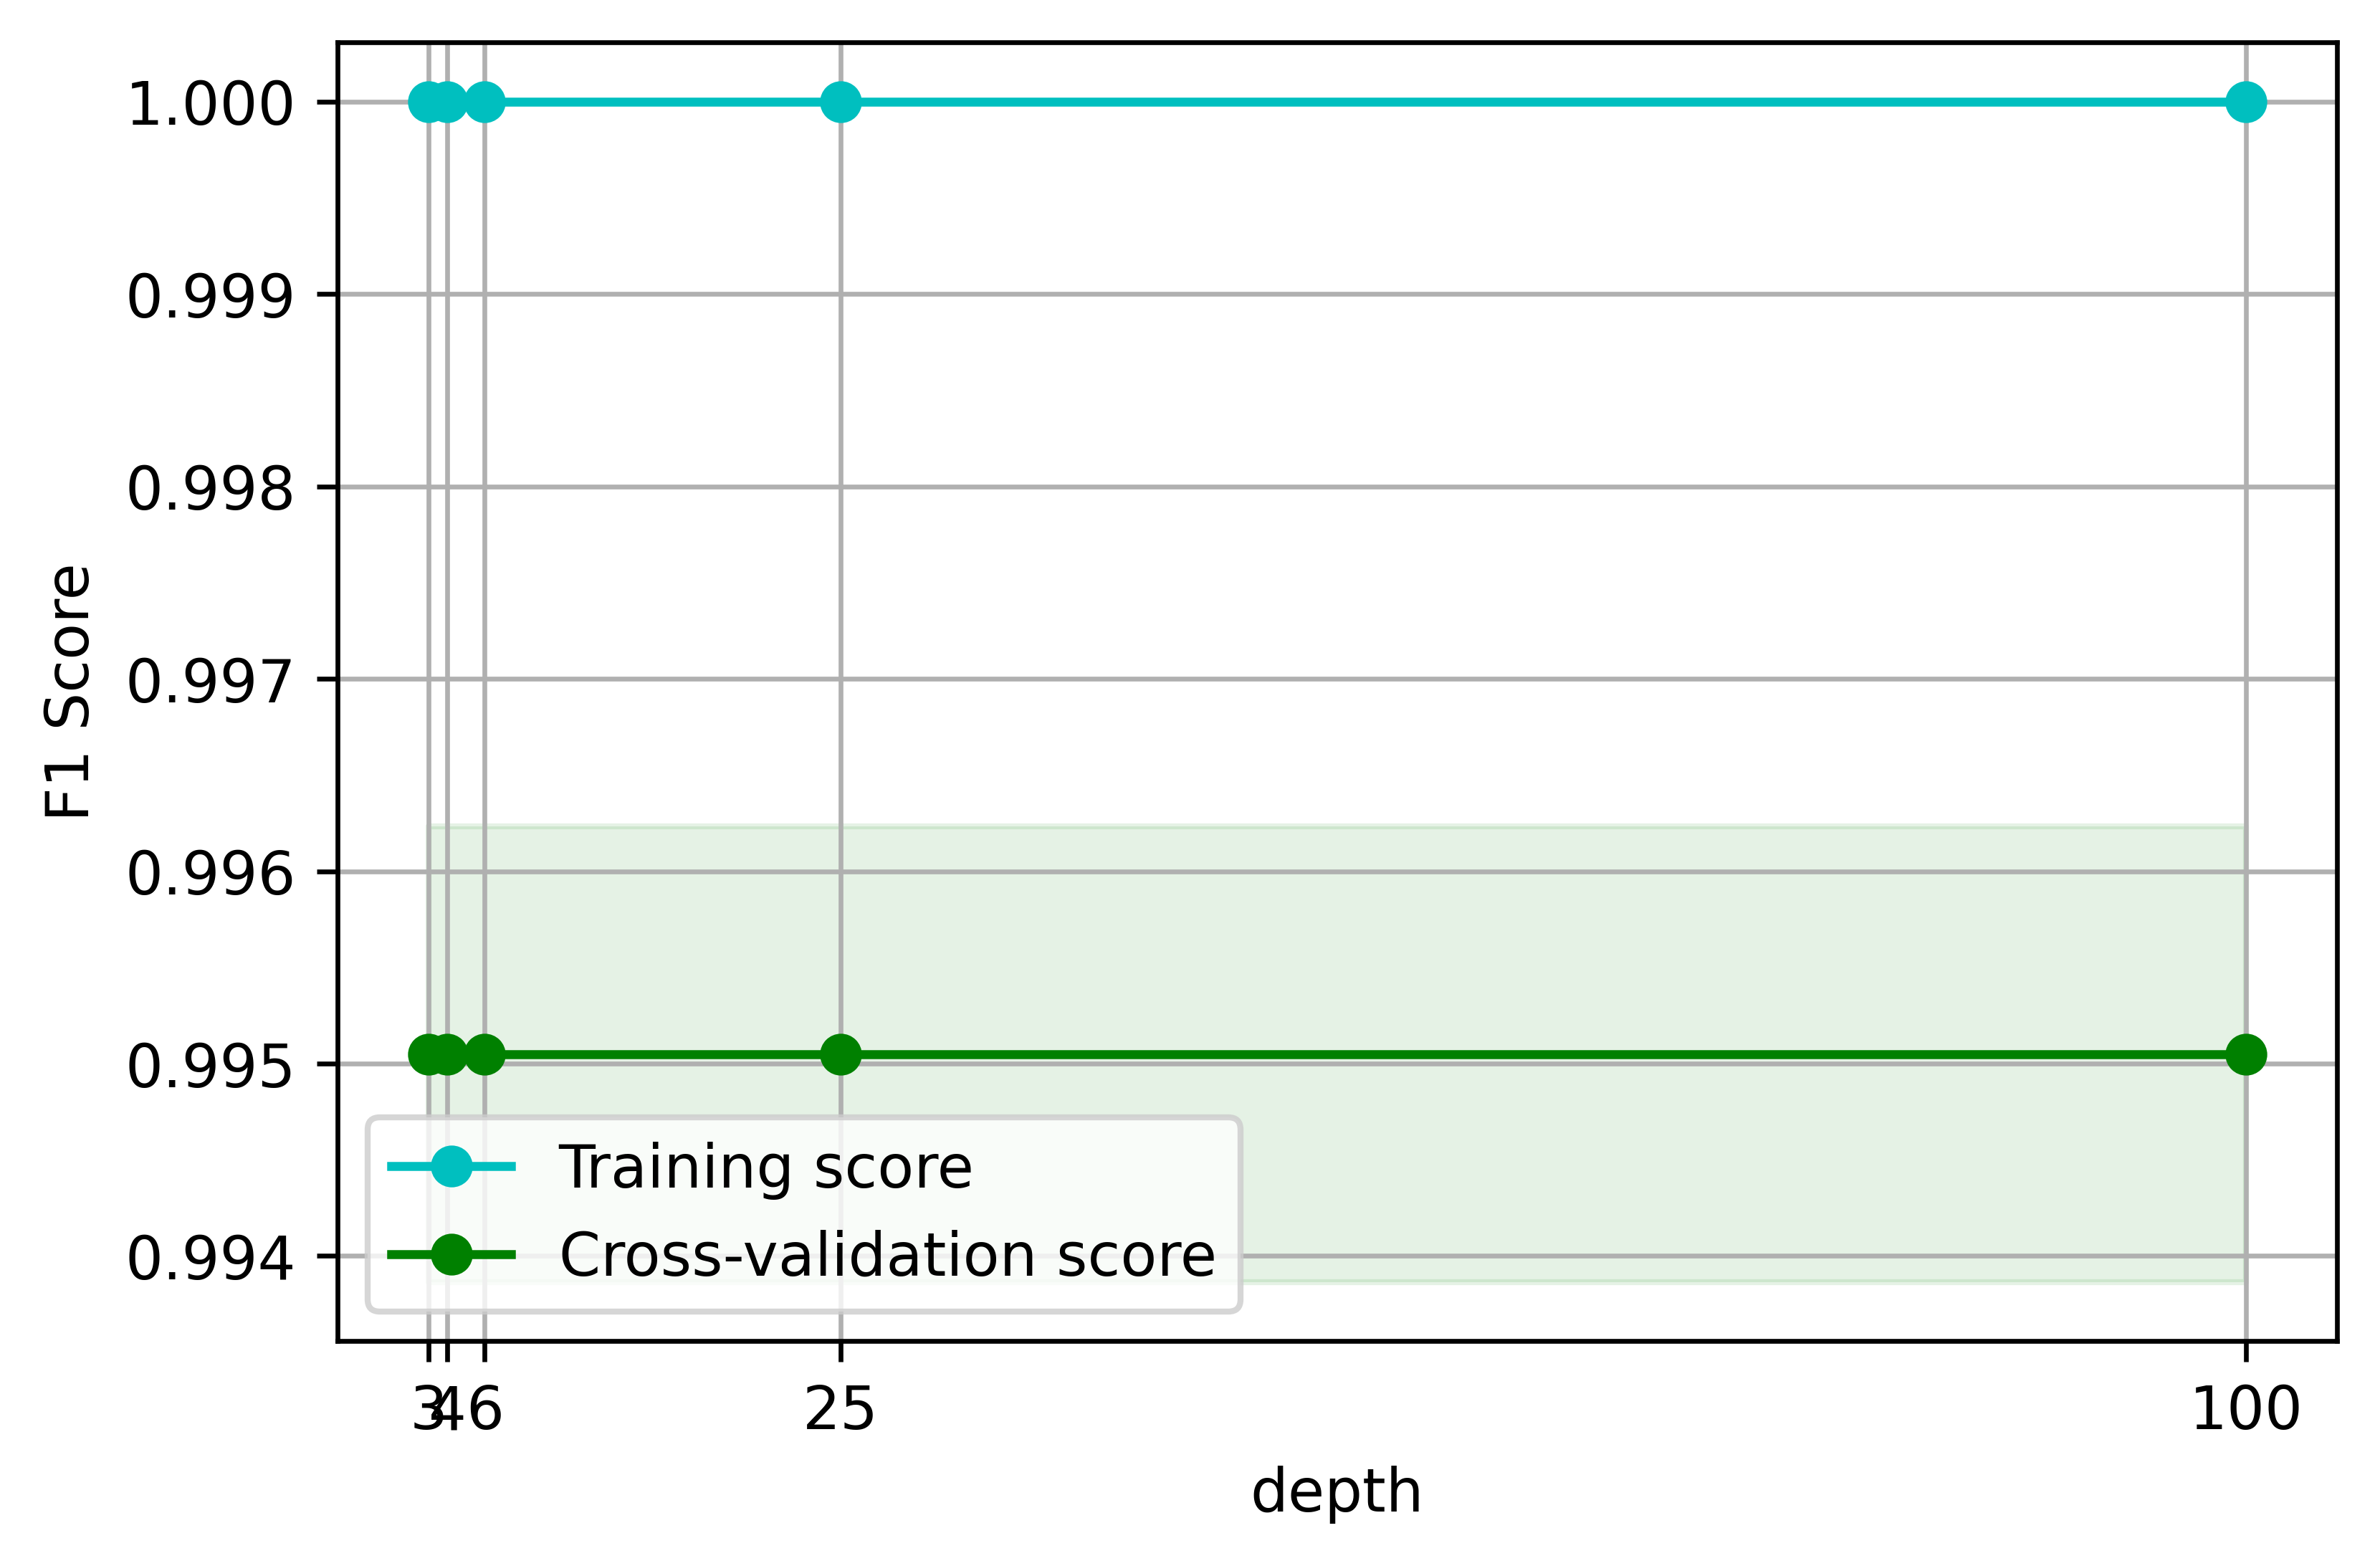

In [35]:
# Depth parameter
plt.figure(dpi=600)

param_range = [
    {"depth":3},
    {"depth":4},
    {"depth":6},
    {"depth":25},
    {"depth":100},
    ]

params = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'AUC',
    'loss_function': 'MultiClass'
}

score_sets = []

np_train_scores = np.empty((0, sss.n_splits))
np_test_scores = np.empty((0, sss.n_splits))

# Get param name and values
param_values = []
param_name = list(param_range[0].keys())[0]
for d in param_range:
    param_values.append(list(d.values())[0])
param_labels = param_values

# Check if param values have string type
if any(isinstance(item, str) for item in param_values):
    len_param_values = len(param_values)
    param_values = list(range(0,len_param_values))

for param in param_range:
    params.update(param)
    print(f"Params are set to: {params}")
    cv_scores_train = []
    cv_scores_test = []

    fold=1
    for train_index, test_index in sss.split(X, y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
        clf = CatBoostClassifier(**params_lc)
        clf.fit(Xtrain, ytrain)

        ypredict = clf.predict(Xtrain)
        f1_weighted_score_train=f1_score(ytrain, ypredict, average='weighted')

        ypredict_test = clf.predict(Xtest)
        f1_weighted_score_test=f1_score(ytest, ypredict_test, average='weighted')
        cv_scores_test.append(f1_weighted_score_test)
        cv_scores_train.append(f1_weighted_score_train)

    np_train_scores = np.append(np_train_scores,[cv_scores_train], axis=0)
    np_test_scores = np.append(np_test_scores,[cv_scores_test], axis=0)

# Compute for fill_between plot
np_train_scores_mean = np.mean(np_train_scores, axis=1)
np_train_scores_std = np.std(np_train_scores, axis=1)
np_test_scores_mean = np.mean(np_test_scores, axis=1)
np_test_scores_std = np.std(np_test_scores, axis=1)

# Plot
plt.grid()
plt.fill_between(param_values, np_train_scores_mean - np_train_scores_std,
             np_train_scores_mean + np_train_scores_std, alpha=0.1,
             color="c")
plt.fill_between(param_values, np_test_scores_mean - np_test_scores_std,
             np_test_scores_mean + np_test_scores_std, alpha=0.1, color="g")
plt.plot(param_values, np_train_scores_mean, 'o-', color="c",
     label="Training score")
plt.plot(param_values, np_test_scores_mean, 'o-', color="g",
     label="Cross-validation score")

# Labels and legends
plt.xticks(ticks=param_values, labels=param_labels)
plt.ylabel("F1 Score")
plt.xlabel(param_name)
# plt.legend(loc='upper right')
plt.legend(loc="best")
plt.savefig(os.path.join(model_dir, f"{ml_method}_depth_learningcurve.png"))
plt.show()

Starting params: {'depth': 6, 'n_estimators': 10, 'learning_rate': 0.2, 'custom_loss': 'AUC', 'loss_function': 'MultiClass'}
0:	learn: 0.9657324	total: 5.18ms	remaining: 46.6ms
1:	learn: 0.7124155	total: 19.6ms	remaining: 78.5ms
2:	learn: 0.5329852	total: 28.4ms	remaining: 66.2ms
3:	learn: 0.4130375	total: 37.1ms	remaining: 55.6ms
4:	learn: 0.3300022	total: 45ms	remaining: 45ms
5:	learn: 0.2686701	total: 53.2ms	remaining: 35.5ms
6:	learn: 0.2185668	total: 60.5ms	remaining: 25.9ms
7:	learn: 0.1803104	total: 68.2ms	remaining: 17ms
8:	learn: 0.1491246	total: 75.9ms	remaining: 8.43ms
9:	learn: 0.1244349	total: 83.1ms	remaining: 0us
0:	learn: 0.9700427	total: 7.11ms	remaining: 64ms
1:	learn: 0.7037517	total: 14.4ms	remaining: 57.8ms
2:	learn: 0.5329200	total: 21.7ms	remaining: 50.7ms
3:	learn: 0.4177039	total: 30ms	remaining: 45ms
4:	learn: 0.3340725	total: 38.1ms	remaining: 38.1ms
5:	learn: 0.2730548	total: 47.1ms	remaining: 31.4ms
6:	learn: 0.2228426	total: 55.1ms	remaining: 23.6ms
7:	lea

7:	learn: 0.1795358	total: 57.5ms	remaining: 302ms
8:	learn: 0.1494339	total: 65.3ms	remaining: 298ms
9:	learn: 0.1257207	total: 74.9ms	remaining: 300ms
10:	learn: 0.1064194	total: 82.3ms	remaining: 292ms
11:	learn: 0.0911177	total: 89.1ms	remaining: 282ms
12:	learn: 0.0785733	total: 97.3ms	remaining: 277ms
13:	learn: 0.0679032	total: 105ms	remaining: 271ms
14:	learn: 0.0601092	total: 112ms	remaining: 262ms
15:	learn: 0.0534682	total: 121ms	remaining: 257ms
16:	learn: 0.0479346	total: 128ms	remaining: 248ms
17:	learn: 0.0431121	total: 136ms	remaining: 242ms
18:	learn: 0.0388790	total: 143ms	remaining: 234ms
19:	learn: 0.0358574	total: 150ms	remaining: 226ms
20:	learn: 0.0330467	total: 157ms	remaining: 217ms
21:	learn: 0.0304955	total: 165ms	remaining: 211ms
22:	learn: 0.0285484	total: 173ms	remaining: 203ms
23:	learn: 0.0269336	total: 180ms	remaining: 195ms
24:	learn: 0.0254881	total: 188ms	remaining: 188ms
25:	learn: 0.0242604	total: 196ms	remaining: 181ms
26:	learn: 0.0231789	total: 

33:	learn: 0.0184039	total: 251ms	remaining: 487ms
34:	learn: 0.0175064	total: 258ms	remaining: 479ms
35:	learn: 0.0169743	total: 265ms	remaining: 472ms
36:	learn: 0.0164983	total: 274ms	remaining: 466ms
37:	learn: 0.0162074	total: 280ms	remaining: 458ms
38:	learn: 0.0160107	total: 289ms	remaining: 452ms
39:	learn: 0.0158326	total: 293ms	remaining: 440ms
40:	learn: 0.0157013	total: 300ms	remaining: 432ms
41:	learn: 0.0153904	total: 308ms	remaining: 425ms
42:	learn: 0.0150605	total: 315ms	remaining: 418ms
43:	learn: 0.0147010	total: 323ms	remaining: 411ms
44:	learn: 0.0144497	total: 330ms	remaining: 404ms
45:	learn: 0.0142876	total: 339ms	remaining: 398ms
46:	learn: 0.0141247	total: 346ms	remaining: 391ms
47:	learn: 0.0140101	total: 353ms	remaining: 383ms
48:	learn: 0.0139237	total: 360ms	remaining: 375ms
49:	learn: 0.0135616	total: 367ms	remaining: 367ms
50:	learn: 0.0133995	total: 375ms	remaining: 361ms
51:	learn: 0.0129319	total: 383ms	remaining: 354ms
52:	learn: 0.0126727	total: 391

16:	learn: 0.0479346	total: 127ms	remaining: 619ms
17:	learn: 0.0431121	total: 135ms	remaining: 616ms
18:	learn: 0.0388790	total: 143ms	remaining: 611ms
19:	learn: 0.0358574	total: 150ms	remaining: 602ms
20:	learn: 0.0330467	total: 158ms	remaining: 594ms
21:	learn: 0.0304955	total: 165ms	remaining: 586ms
22:	learn: 0.0285484	total: 172ms	remaining: 577ms
23:	learn: 0.0269336	total: 180ms	remaining: 571ms
24:	learn: 0.0254881	total: 188ms	remaining: 563ms
25:	learn: 0.0242604	total: 195ms	remaining: 556ms
26:	learn: 0.0231789	total: 202ms	remaining: 547ms
27:	learn: 0.0222580	total: 209ms	remaining: 538ms
28:	learn: 0.0214805	total: 217ms	remaining: 531ms
29:	learn: 0.0204662	total: 224ms	remaining: 523ms
30:	learn: 0.0199991	total: 232ms	remaining: 516ms
31:	learn: 0.0195349	total: 240ms	remaining: 510ms
32:	learn: 0.0189875	total: 248ms	remaining: 503ms
33:	learn: 0.0185332	total: 255ms	remaining: 496ms
34:	learn: 0.0181812	total: 263ms	remaining: 488ms
35:	learn: 0.0175209	total: 270

0:	learn: 0.9635183	total: 7.74ms	remaining: 767ms
1:	learn: 0.7082859	total: 17.4ms	remaining: 853ms
2:	learn: 0.5401235	total: 26.5ms	remaining: 857ms
3:	learn: 0.4193523	total: 34.8ms	remaining: 836ms
4:	learn: 0.3336194	total: 43ms	remaining: 816ms
5:	learn: 0.2682366	total: 51.5ms	remaining: 807ms
6:	learn: 0.2197335	total: 61.1ms	remaining: 811ms
7:	learn: 0.1796659	total: 73.8ms	remaining: 848ms
8:	learn: 0.1494288	total: 82.9ms	remaining: 838ms
9:	learn: 0.1248505	total: 90.7ms	remaining: 816ms
10:	learn: 0.1055421	total: 99.5ms	remaining: 805ms
11:	learn: 0.0896126	total: 106ms	remaining: 781ms
12:	learn: 0.0768512	total: 113ms	remaining: 758ms
13:	learn: 0.0675709	total: 121ms	remaining: 742ms
14:	learn: 0.0590131	total: 128ms	remaining: 725ms
15:	learn: 0.0519645	total: 135ms	remaining: 709ms
16:	learn: 0.0461875	total: 142ms	remaining: 694ms
17:	learn: 0.0407852	total: 150ms	remaining: 684ms
18:	learn: 0.0368914	total: 158ms	remaining: 672ms
19:	learn: 0.0334510	total: 165m

85:	learn: 0.0082903	total: 622ms	remaining: 824ms
86:	learn: 0.0082237	total: 629ms	remaining: 817ms
87:	learn: 0.0081064	total: 636ms	remaining: 809ms
88:	learn: 0.0079672	total: 644ms	remaining: 803ms
89:	learn: 0.0078291	total: 652ms	remaining: 796ms
90:	learn: 0.0077898	total: 659ms	remaining: 789ms
91:	learn: 0.0076822	total: 667ms	remaining: 783ms
92:	learn: 0.0076530	total: 674ms	remaining: 775ms
93:	learn: 0.0074657	total: 681ms	remaining: 768ms
94:	learn: 0.0073738	total: 688ms	remaining: 761ms
95:	learn: 0.0072744	total: 696ms	remaining: 754ms
96:	learn: 0.0072068	total: 703ms	remaining: 747ms
97:	learn: 0.0070893	total: 710ms	remaining: 739ms
98:	learn: 0.0069958	total: 717ms	remaining: 731ms
99:	learn: 0.0069044	total: 724ms	remaining: 724ms
100:	learn: 0.0068685	total: 731ms	remaining: 717ms
101:	learn: 0.0068328	total: 738ms	remaining: 709ms
102:	learn: 0.0066766	total: 747ms	remaining: 704ms
103:	learn: 0.0065755	total: 755ms	remaining: 697ms
104:	learn: 0.0065268	total

69:	learn: 0.0108020	total: 522ms	remaining: 969ms
70:	learn: 0.0106764	total: 529ms	remaining: 961ms
71:	learn: 0.0105026	total: 537ms	remaining: 954ms
72:	learn: 0.0104170	total: 544ms	remaining: 946ms
73:	learn: 0.0102744	total: 551ms	remaining: 938ms
74:	learn: 0.0101784	total: 558ms	remaining: 930ms
75:	learn: 0.0100666	total: 565ms	remaining: 922ms
76:	learn: 0.0099641	total: 572ms	remaining: 914ms
77:	learn: 0.0099156	total: 580ms	remaining: 907ms
78:	learn: 0.0097176	total: 587ms	remaining: 899ms
79:	learn: 0.0096006	total: 595ms	remaining: 893ms
80:	learn: 0.0094692	total: 603ms	remaining: 886ms
81:	learn: 0.0093778	total: 611ms	remaining: 879ms
82:	learn: 0.0092525	total: 618ms	remaining: 872ms
83:	learn: 0.0091809	total: 626ms	remaining: 864ms
84:	learn: 0.0091158	total: 633ms	remaining: 856ms
85:	learn: 0.0090300	total: 640ms	remaining: 848ms
86:	learn: 0.0088936	total: 647ms	remaining: 840ms
87:	learn: 0.0088018	total: 654ms	remaining: 832ms
88:	learn: 0.0087383	total: 662

53:	learn: 0.0128722	total: 405ms	remaining: 1.09s
54:	learn: 0.0125360	total: 412ms	remaining: 1.09s
55:	learn: 0.0123663	total: 420ms	remaining: 1.08s
56:	learn: 0.0121723	total: 427ms	remaining: 1.07s
57:	learn: 0.0119558	total: 434ms	remaining: 1.06s
58:	learn: 0.0118100	total: 441ms	remaining: 1.05s
59:	learn: 0.0117773	total: 449ms	remaining: 1.05s
60:	learn: 0.0115727	total: 456ms	remaining: 1.04s
61:	learn: 0.0113183	total: 464ms	remaining: 1.03s
62:	learn: 0.0112345	total: 471ms	remaining: 1.02s
63:	learn: 0.0110922	total: 480ms	remaining: 1.02s
64:	learn: 0.0110424	total: 488ms	remaining: 1.01s
65:	learn: 0.0108623	total: 494ms	remaining: 1s
66:	learn: 0.0106911	total: 502ms	remaining: 996ms
67:	learn: 0.0106227	total: 507ms	remaining: 984ms
68:	learn: 0.0104534	total: 514ms	remaining: 976ms
69:	learn: 0.0103296	total: 522ms	remaining: 969ms
70:	learn: 0.0102331	total: 528ms	remaining: 960ms
71:	learn: 0.0101238	total: 536ms	remaining: 953ms
72:	learn: 0.0099362	total: 544ms	

36:	learn: 0.0187352	total: 297ms	remaining: 1.31s
37:	learn: 0.0180655	total: 303ms	remaining: 1.29s
38:	learn: 0.0177756	total: 311ms	remaining: 1.28s
39:	learn: 0.0173875	total: 319ms	remaining: 1.27s
40:	learn: 0.0171312	total: 326ms	remaining: 1.26s
41:	learn: 0.0169972	total: 333ms	remaining: 1.25s
42:	learn: 0.0166784	total: 341ms	remaining: 1.24s
43:	learn: 0.0161858	total: 347ms	remaining: 1.23s
44:	learn: 0.0159335	total: 354ms	remaining: 1.22s
45:	learn: 0.0156199	total: 361ms	remaining: 1.21s
46:	learn: 0.0153447	total: 369ms	remaining: 1.2s
47:	learn: 0.0149716	total: 376ms	remaining: 1.19s
48:	learn: 0.0146421	total: 383ms	remaining: 1.18s
49:	learn: 0.0143250	total: 390ms	remaining: 1.17s
50:	learn: 0.0140101	total: 398ms	remaining: 1.16s
51:	learn: 0.0139059	total: 406ms	remaining: 1.16s
52:	learn: 0.0137468	total: 413ms	remaining: 1.15s
53:	learn: 0.0135226	total: 421ms	remaining: 1.14s
54:	learn: 0.0132785	total: 429ms	remaining: 1.13s
55:	learn: 0.0129257	total: 437m

196:	learn: 0.0027611	total: 1.49s	remaining: 22.8ms
197:	learn: 0.0027549	total: 1.5s	remaining: 15.2ms
198:	learn: 0.0027430	total: 1.51s	remaining: 7.58ms
199:	learn: 0.0027211	total: 1.51s	remaining: 0us
0:	learn: 0.9635183	total: 6.73ms	remaining: 1.34s
1:	learn: 0.7082859	total: 13.9ms	remaining: 1.37s
2:	learn: 0.5401235	total: 21.2ms	remaining: 1.39s
3:	learn: 0.4193523	total: 27.9ms	remaining: 1.36s
4:	learn: 0.3336194	total: 35.9ms	remaining: 1.4s
5:	learn: 0.2682366	total: 43ms	remaining: 1.39s
6:	learn: 0.2197335	total: 50.5ms	remaining: 1.39s
7:	learn: 0.1796659	total: 58.2ms	remaining: 1.4s
8:	learn: 0.1494288	total: 65.6ms	remaining: 1.39s
9:	learn: 0.1248505	total: 73ms	remaining: 1.39s
10:	learn: 0.1055421	total: 81.3ms	remaining: 1.4s
11:	learn: 0.0896126	total: 88.8ms	remaining: 1.39s
12:	learn: 0.0768512	total: 96ms	remaining: 1.38s
13:	learn: 0.0675709	total: 103ms	remaining: 1.37s
14:	learn: 0.0590131	total: 110ms	remaining: 1.36s
15:	learn: 0.0519645	total: 118ms

182:	learn: 0.0024705	total: 1.35s	remaining: 125ms
183:	learn: 0.0024304	total: 1.36s	remaining: 118ms
184:	learn: 0.0024124	total: 1.36s	remaining: 111ms
185:	learn: 0.0023925	total: 1.37s	remaining: 103ms
186:	learn: 0.0023595	total: 1.38s	remaining: 96ms
187:	learn: 0.0023459	total: 1.39s	remaining: 88.6ms
188:	learn: 0.0023168	total: 1.4s	remaining: 81.3ms
189:	learn: 0.0022812	total: 1.4s	remaining: 73.9ms
190:	learn: 0.0022670	total: 1.41s	remaining: 66.5ms
191:	learn: 0.0022503	total: 1.42s	remaining: 59.2ms
192:	learn: 0.0022274	total: 1.43s	remaining: 51.8ms
193:	learn: 0.0022166	total: 1.44s	remaining: 44.4ms
194:	learn: 0.0021928	total: 1.44s	remaining: 37ms
195:	learn: 0.0021633	total: 1.46s	remaining: 29.7ms
196:	learn: 0.0021458	total: 1.47s	remaining: 22.4ms
197:	learn: 0.0021396	total: 1.48s	remaining: 14.9ms
198:	learn: 0.0021122	total: 1.49s	remaining: 7.5ms
199:	learn: 0.0021000	total: 1.5s	remaining: 0us
Starting params: {'depth': 6, 'n_estimators': 300, 'learning_

165:	learn: 0.0033952	total: 1.21s	remaining: 980ms
166:	learn: 0.0033658	total: 1.22s	remaining: 972ms
167:	learn: 0.0033471	total: 1.23s	remaining: 966ms
168:	learn: 0.0033110	total: 1.24s	remaining: 958ms
169:	learn: 0.0032991	total: 1.24s	remaining: 950ms
170:	learn: 0.0032912	total: 1.25s	remaining: 943ms
171:	learn: 0.0032367	total: 1.26s	remaining: 936ms
172:	learn: 0.0031954	total: 1.26s	remaining: 929ms
173:	learn: 0.0031713	total: 1.27s	remaining: 921ms
174:	learn: 0.0031643	total: 1.28s	remaining: 914ms
175:	learn: 0.0031506	total: 1.29s	remaining: 908ms
176:	learn: 0.0031320	total: 1.29s	remaining: 900ms
177:	learn: 0.0031022	total: 1.3s	remaining: 893ms
178:	learn: 0.0030831	total: 1.31s	remaining: 885ms
179:	learn: 0.0030624	total: 1.32s	remaining: 878ms
180:	learn: 0.0030328	total: 1.32s	remaining: 871ms
181:	learn: 0.0030187	total: 1.33s	remaining: 864ms
182:	learn: 0.0030051	total: 1.34s	remaining: 856ms
183:	learn: 0.0029833	total: 1.35s	remaining: 849ms
184:	learn: 0

43:	learn: 0.0158739	total: 348ms	remaining: 2.02s
44:	learn: 0.0155630	total: 355ms	remaining: 2.01s
45:	learn: 0.0154127	total: 362ms	remaining: 2s
46:	learn: 0.0151863	total: 370ms	remaining: 1.99s
47:	learn: 0.0149683	total: 377ms	remaining: 1.98s
48:	learn: 0.0147611	total: 384ms	remaining: 1.97s
49:	learn: 0.0145897	total: 391ms	remaining: 1.95s
50:	learn: 0.0142442	total: 398ms	remaining: 1.94s
51:	learn: 0.0140561	total: 406ms	remaining: 1.94s
52:	learn: 0.0137069	total: 414ms	remaining: 1.93s
53:	learn: 0.0135066	total: 421ms	remaining: 1.92s
54:	learn: 0.0132783	total: 429ms	remaining: 1.91s
55:	learn: 0.0130329	total: 436ms	remaining: 1.9s
56:	learn: 0.0128931	total: 443ms	remaining: 1.89s
57:	learn: 0.0125979	total: 450ms	remaining: 1.88s
58:	learn: 0.0123697	total: 458ms	remaining: 1.87s
59:	learn: 0.0122156	total: 465ms	remaining: 1.86s
60:	learn: 0.0120532	total: 473ms	remaining: 1.85s
61:	learn: 0.0118994	total: 481ms	remaining: 1.85s
62:	learn: 0.0117187	total: 488ms	r

205:	learn: 0.0027780	total: 1.54s	remaining: 704ms
206:	learn: 0.0027654	total: 1.55s	remaining: 697ms
207:	learn: 0.0027425	total: 1.56s	remaining: 689ms
208:	learn: 0.0027292	total: 1.56s	remaining: 682ms
209:	learn: 0.0027072	total: 1.57s	remaining: 675ms
210:	learn: 0.0026914	total: 1.58s	remaining: 667ms
211:	learn: 0.0026791	total: 1.59s	remaining: 660ms
212:	learn: 0.0026523	total: 1.6s	remaining: 652ms
213:	learn: 0.0026265	total: 1.6s	remaining: 645ms
214:	learn: 0.0026079	total: 1.61s	remaining: 637ms
215:	learn: 0.0025984	total: 1.62s	remaining: 630ms
216:	learn: 0.0025885	total: 1.63s	remaining: 622ms
217:	learn: 0.0025841	total: 1.63s	remaining: 615ms
218:	learn: 0.0025671	total: 1.64s	remaining: 607ms
219:	learn: 0.0025316	total: 1.65s	remaining: 599ms
220:	learn: 0.0025115	total: 1.66s	remaining: 592ms
221:	learn: 0.0024940	total: 1.66s	remaining: 585ms
222:	learn: 0.0024781	total: 1.67s	remaining: 577ms
223:	learn: 0.0024674	total: 1.68s	remaining: 570ms
224:	learn: 0.

88:	learn: 0.0083505	total: 666ms	remaining: 1.58s
89:	learn: 0.0081539	total: 674ms	remaining: 1.57s
90:	learn: 0.0080194	total: 681ms	remaining: 1.56s
91:	learn: 0.0078783	total: 689ms	remaining: 1.56s
92:	learn: 0.0077687	total: 696ms	remaining: 1.55s
93:	learn: 0.0077128	total: 704ms	remaining: 1.54s
94:	learn: 0.0075963	total: 711ms	remaining: 1.53s
95:	learn: 0.0075317	total: 719ms	remaining: 1.53s
96:	learn: 0.0074686	total: 727ms	remaining: 1.52s
97:	learn: 0.0073731	total: 735ms	remaining: 1.51s
98:	learn: 0.0072515	total: 743ms	remaining: 1.51s
99:	learn: 0.0071482	total: 749ms	remaining: 1.5s
100:	learn: 0.0070619	total: 757ms	remaining: 1.49s
101:	learn: 0.0070368	total: 764ms	remaining: 1.48s
102:	learn: 0.0069836	total: 771ms	remaining: 1.48s
103:	learn: 0.0069034	total: 779ms	remaining: 1.47s
104:	learn: 0.0068163	total: 787ms	remaining: 1.46s
105:	learn: 0.0067212	total: 794ms	remaining: 1.45s
106:	learn: 0.0065915	total: 802ms	remaining: 1.45s
107:	learn: 0.0065396	tot

262:	learn: 0.0018603	total: 2.09s	remaining: 294ms
263:	learn: 0.0018519	total: 2.1s	remaining: 286ms
264:	learn: 0.0018474	total: 2.11s	remaining: 278ms
265:	learn: 0.0018371	total: 2.12s	remaining: 271ms
266:	learn: 0.0018295	total: 2.13s	remaining: 263ms
267:	learn: 0.0018254	total: 2.14s	remaining: 255ms
268:	learn: 0.0018092	total: 2.14s	remaining: 247ms
269:	learn: 0.0017977	total: 2.15s	remaining: 239ms
270:	learn: 0.0017850	total: 2.16s	remaining: 231ms
271:	learn: 0.0017804	total: 2.17s	remaining: 223ms
272:	learn: 0.0017714	total: 2.18s	remaining: 215ms
273:	learn: 0.0017624	total: 2.18s	remaining: 207ms
274:	learn: 0.0017549	total: 2.19s	remaining: 199ms
275:	learn: 0.0017452	total: 2.2s	remaining: 191ms
276:	learn: 0.0017374	total: 2.21s	remaining: 183ms
277:	learn: 0.0017325	total: 2.22s	remaining: 176ms
278:	learn: 0.0017257	total: 2.23s	remaining: 168ms
279:	learn: 0.0017161	total: 2.23s	remaining: 160ms
280:	learn: 0.0017112	total: 2.24s	remaining: 152ms
281:	learn: 0.

140:	learn: 0.0046144	total: 1.24s	remaining: 1.4s
141:	learn: 0.0045739	total: 1.25s	remaining: 1.39s
142:	learn: 0.0045364	total: 1.26s	remaining: 1.38s
143:	learn: 0.0045087	total: 1.26s	remaining: 1.37s
144:	learn: 0.0044630	total: 1.27s	remaining: 1.36s
145:	learn: 0.0044226	total: 1.28s	remaining: 1.35s
146:	learn: 0.0043423	total: 1.29s	remaining: 1.34s
147:	learn: 0.0042610	total: 1.3s	remaining: 1.33s
148:	learn: 0.0042433	total: 1.31s	remaining: 1.32s
149:	learn: 0.0042019	total: 1.31s	remaining: 1.31s
150:	learn: 0.0041451	total: 1.32s	remaining: 1.3s
151:	learn: 0.0040958	total: 1.33s	remaining: 1.3s
152:	learn: 0.0040406	total: 1.34s	remaining: 1.29s
153:	learn: 0.0039956	total: 1.35s	remaining: 1.28s
154:	learn: 0.0039433	total: 1.35s	remaining: 1.27s
155:	learn: 0.0039077	total: 1.36s	remaining: 1.26s
156:	learn: 0.0038583	total: 1.37s	remaining: 1.25s
157:	learn: 0.0038350	total: 1.38s	remaining: 1.24s
158:	learn: 0.0037879	total: 1.39s	remaining: 1.23s
159:	learn: 0.00

12:	learn: 0.0768512	total: 120ms	remaining: 2.65s
13:	learn: 0.0675709	total: 142ms	remaining: 2.9s
14:	learn: 0.0590131	total: 152ms	remaining: 2.88s
15:	learn: 0.0519645	total: 161ms	remaining: 2.85s
16:	learn: 0.0461875	total: 168ms	remaining: 2.79s
17:	learn: 0.0407852	total: 180ms	remaining: 2.81s
18:	learn: 0.0368914	total: 188ms	remaining: 2.79s
19:	learn: 0.0334510	total: 197ms	remaining: 2.76s
20:	learn: 0.0309593	total: 204ms	remaining: 2.71s
21:	learn: 0.0282889	total: 212ms	remaining: 2.68s
22:	learn: 0.0260541	total: 221ms	remaining: 2.65s
23:	learn: 0.0242891	total: 228ms	remaining: 2.62s
24:	learn: 0.0229043	total: 237ms	remaining: 2.6s
25:	learn: 0.0221365	total: 245ms	remaining: 2.58s
26:	learn: 0.0214958	total: 254ms	remaining: 2.57s
27:	learn: 0.0206955	total: 263ms	remaining: 2.55s
28:	learn: 0.0197856	total: 271ms	remaining: 2.53s
29:	learn: 0.0194196	total: 289ms	remaining: 2.6s
30:	learn: 0.0187302	total: 302ms	remaining: 2.62s
31:	learn: 0.0180761	total: 311ms	

181:	learn: 0.0025141	total: 1.91s	remaining: 1.24s
182:	learn: 0.0024705	total: 1.92s	remaining: 1.23s
183:	learn: 0.0024304	total: 1.94s	remaining: 1.22s
184:	learn: 0.0024124	total: 1.97s	remaining: 1.23s
185:	learn: 0.0023925	total: 1.99s	remaining: 1.22s
186:	learn: 0.0023595	total: 2s	remaining: 1.21s
187:	learn: 0.0023459	total: 2.02s	remaining: 1.2s
188:	learn: 0.0023168	total: 2.05s	remaining: 1.2s
189:	learn: 0.0022812	total: 2.08s	remaining: 1.2s
190:	learn: 0.0022670	total: 2.11s	remaining: 1.21s
191:	learn: 0.0022503	total: 2.14s	remaining: 1.2s
192:	learn: 0.0022274	total: 2.16s	remaining: 1.2s
193:	learn: 0.0022166	total: 2.18s	remaining: 1.19s
194:	learn: 0.0021928	total: 2.19s	remaining: 1.18s
195:	learn: 0.0021633	total: 2.21s	remaining: 1.17s
196:	learn: 0.0021458	total: 2.22s	remaining: 1.16s
197:	learn: 0.0021396	total: 2.23s	remaining: 1.15s
198:	learn: 0.0021122	total: 2.24s	remaining: 1.14s
199:	learn: 0.0021000	total: 2.25s	remaining: 1.13s
200:	learn: 0.002085

55:	learn: 0.0121176	total: 672ms	remaining: 5.33s
56:	learn: 0.0119828	total: 684ms	remaining: 5.32s
57:	learn: 0.0117823	total: 699ms	remaining: 5.33s
58:	learn: 0.0116862	total: 713ms	remaining: 5.33s
59:	learn: 0.0116211	total: 725ms	remaining: 5.32s
60:	learn: 0.0115478	total: 731ms	remaining: 5.26s
61:	learn: 0.0113691	total: 742ms	remaining: 5.24s
62:	learn: 0.0112520	total: 752ms	remaining: 5.22s
63:	learn: 0.0109377	total: 764ms	remaining: 5.21s
64:	learn: 0.0108347	total: 774ms	remaining: 5.18s
65:	learn: 0.0106848	total: 784ms	remaining: 5.16s
66:	learn: 0.0106181	total: 798ms	remaining: 5.16s
67:	learn: 0.0105334	total: 808ms	remaining: 5.13s
68:	learn: 0.0103591	total: 820ms	remaining: 5.12s
69:	learn: 0.0102419	total: 832ms	remaining: 5.11s
70:	learn: 0.0099711	total: 848ms	remaining: 5.13s
71:	learn: 0.0098878	total: 860ms	remaining: 5.11s
72:	learn: 0.0098117	total: 879ms	remaining: 5.14s
73:	learn: 0.0096123	total: 896ms	remaining: 5.16s
74:	learn: 0.0095521	total: 912

227:	learn: 0.0022186	total: 2.69s	remaining: 3.22s
228:	learn: 0.0022055	total: 2.71s	remaining: 3.2s
229:	learn: 0.0022031	total: 2.72s	remaining: 3.2s
230:	learn: 0.0021740	total: 2.73s	remaining: 3.18s
231:	learn: 0.0021475	total: 2.75s	remaining: 3.18s
232:	learn: 0.0021351	total: 2.76s	remaining: 3.17s
233:	learn: 0.0021304	total: 2.77s	remaining: 3.15s
234:	learn: 0.0021144	total: 2.79s	remaining: 3.14s
235:	learn: 0.0021003	total: 2.8s	remaining: 3.13s
236:	learn: 0.0020858	total: 2.81s	remaining: 3.12s
237:	learn: 0.0020442	total: 2.82s	remaining: 3.1s
238:	learn: 0.0020305	total: 2.83s	remaining: 3.09s
239:	learn: 0.0020251	total: 2.83s	remaining: 3.07s
240:	learn: 0.0020116	total: 2.84s	remaining: 3.06s
241:	learn: 0.0019939	total: 2.85s	remaining: 3.04s
242:	learn: 0.0019813	total: 2.86s	remaining: 3.02s
243:	learn: 0.0019650	total: 2.87s	remaining: 3.01s
244:	learn: 0.0019251	total: 2.87s	remaining: 2.99s
245:	learn: 0.0019219	total: 2.88s	remaining: 2.97s
246:	learn: 0.00

389:	learn: 0.0010180	total: 4.09s	remaining: 1.15s
390:	learn: 0.0010131	total: 4.1s	remaining: 1.14s
391:	learn: 0.0010099	total: 4.11s	remaining: 1.13s
392:	learn: 0.0010074	total: 4.12s	remaining: 1.12s
393:	learn: 0.0010044	total: 4.13s	remaining: 1.11s
394:	learn: 0.0009977	total: 4.13s	remaining: 1.1s
395:	learn: 0.0009934	total: 4.14s	remaining: 1.09s
396:	learn: 0.0009881	total: 4.15s	remaining: 1.08s
397:	learn: 0.0009826	total: 4.16s	remaining: 1.06s
398:	learn: 0.0009766	total: 4.17s	remaining: 1.05s
399:	learn: 0.0009760	total: 4.17s	remaining: 1.04s
400:	learn: 0.0009729	total: 4.18s	remaining: 1.03s
401:	learn: 0.0009715	total: 4.19s	remaining: 1.02s
402:	learn: 0.0009698	total: 4.2s	remaining: 1.01s
403:	learn: 0.0009689	total: 4.21s	remaining: 1s
404:	learn: 0.0009649	total: 4.22s	remaining: 989ms
405:	learn: 0.0009611	total: 4.23s	remaining: 978ms
406:	learn: 0.0009570	total: 4.24s	remaining: 969ms
407:	learn: 0.0009548	total: 4.25s	remaining: 959ms
408:	learn: 0.0009

64:	learn: 0.0114398	total: 492ms	remaining: 3.29s
65:	learn: 0.0112810	total: 499ms	remaining: 3.28s
66:	learn: 0.0111554	total: 507ms	remaining: 3.27s
67:	learn: 0.0110152	total: 513ms	remaining: 3.26s
68:	learn: 0.0108983	total: 520ms	remaining: 3.25s
69:	learn: 0.0108020	total: 527ms	remaining: 3.24s
70:	learn: 0.0106764	total: 534ms	remaining: 3.23s
71:	learn: 0.0105026	total: 542ms	remaining: 3.22s
72:	learn: 0.0104170	total: 549ms	remaining: 3.21s
73:	learn: 0.0102744	total: 557ms	remaining: 3.2s
74:	learn: 0.0101784	total: 563ms	remaining: 3.19s
75:	learn: 0.0100666	total: 571ms	remaining: 3.19s
76:	learn: 0.0099641	total: 579ms	remaining: 3.18s
77:	learn: 0.0099156	total: 586ms	remaining: 3.17s
78:	learn: 0.0097176	total: 593ms	remaining: 3.16s
79:	learn: 0.0096006	total: 601ms	remaining: 3.16s
80:	learn: 0.0094692	total: 608ms	remaining: 3.15s
81:	learn: 0.0093778	total: 616ms	remaining: 3.14s
82:	learn: 0.0092525	total: 623ms	remaining: 3.13s
83:	learn: 0.0091809	total: 631m

243:	learn: 0.0021988	total: 1.89s	remaining: 1.98s
244:	learn: 0.0021862	total: 1.9s	remaining: 1.98s
245:	learn: 0.0021799	total: 1.91s	remaining: 1.97s
246:	learn: 0.0021715	total: 1.92s	remaining: 1.96s
247:	learn: 0.0021642	total: 1.92s	remaining: 1.95s
248:	learn: 0.0021527	total: 1.93s	remaining: 1.95s
249:	learn: 0.0021450	total: 1.94s	remaining: 1.94s
250:	learn: 0.0021298	total: 1.95s	remaining: 1.93s
251:	learn: 0.0021226	total: 1.96s	remaining: 1.92s
252:	learn: 0.0021071	total: 1.96s	remaining: 1.92s
253:	learn: 0.0020960	total: 1.97s	remaining: 1.91s
254:	learn: 0.0020824	total: 1.98s	remaining: 1.9s
255:	learn: 0.0020764	total: 1.99s	remaining: 1.9s
256:	learn: 0.0020648	total: 2s	remaining: 1.89s
257:	learn: 0.0020557	total: 2.01s	remaining: 1.88s
258:	learn: 0.0020444	total: 2.02s	remaining: 1.88s
259:	learn: 0.0020358	total: 2.03s	remaining: 1.87s
260:	learn: 0.0020254	total: 2.04s	remaining: 1.86s
261:	learn: 0.0020125	total: 2.04s	remaining: 1.86s
262:	learn: 0.0020

418:	learn: 0.0011017	total: 3.3s	remaining: 638ms
419:	learn: 0.0010987	total: 3.31s	remaining: 630ms
420:	learn: 0.0010963	total: 3.32s	remaining: 623ms
421:	learn: 0.0010938	total: 3.32s	remaining: 614ms
422:	learn: 0.0010922	total: 3.33s	remaining: 607ms
423:	learn: 0.0010904	total: 3.34s	remaining: 599ms
424:	learn: 0.0010865	total: 3.35s	remaining: 591ms
425:	learn: 0.0010834	total: 3.36s	remaining: 583ms
426:	learn: 0.0010805	total: 3.36s	remaining: 575ms
427:	learn: 0.0010768	total: 3.37s	remaining: 567ms
428:	learn: 0.0010742	total: 3.38s	remaining: 559ms
429:	learn: 0.0010717	total: 3.39s	remaining: 552ms
430:	learn: 0.0010703	total: 3.4s	remaining: 544ms
431:	learn: 0.0010671	total: 3.4s	remaining: 536ms
432:	learn: 0.0010644	total: 3.41s	remaining: 528ms
433:	learn: 0.0010603	total: 3.42s	remaining: 520ms
434:	learn: 0.0010585	total: 3.43s	remaining: 512ms
435:	learn: 0.0010561	total: 3.44s	remaining: 504ms
436:	learn: 0.0010524	total: 3.44s	remaining: 497ms
437:	learn: 0.0

87:	learn: 0.0085300	total: 702ms	remaining: 3.29s
88:	learn: 0.0083505	total: 711ms	remaining: 3.28s
89:	learn: 0.0081539	total: 719ms	remaining: 3.27s
90:	learn: 0.0080194	total: 728ms	remaining: 3.27s
91:	learn: 0.0078783	total: 735ms	remaining: 3.26s
92:	learn: 0.0077687	total: 742ms	remaining: 3.25s
93:	learn: 0.0077128	total: 749ms	remaining: 3.24s
94:	learn: 0.0075963	total: 756ms	remaining: 3.22s
95:	learn: 0.0075317	total: 764ms	remaining: 3.22s
96:	learn: 0.0074686	total: 772ms	remaining: 3.21s
97:	learn: 0.0073731	total: 780ms	remaining: 3.2s
98:	learn: 0.0072515	total: 789ms	remaining: 3.2s
99:	learn: 0.0071482	total: 798ms	remaining: 3.19s
100:	learn: 0.0070619	total: 806ms	remaining: 3.18s
101:	learn: 0.0070368	total: 814ms	remaining: 3.18s
102:	learn: 0.0069836	total: 822ms	remaining: 3.17s
103:	learn: 0.0069034	total: 830ms	remaining: 3.16s
104:	learn: 0.0068163	total: 838ms	remaining: 3.15s
105:	learn: 0.0067212	total: 848ms	remaining: 3.15s
106:	learn: 0.0065915	total

255:	learn: 0.0019416	total: 2.13s	remaining: 2.02s
256:	learn: 0.0019319	total: 2.13s	remaining: 2.02s
257:	learn: 0.0019235	total: 2.14s	remaining: 2.01s
258:	learn: 0.0019105	total: 2.15s	remaining: 2s
259:	learn: 0.0019001	total: 2.16s	remaining: 1.99s
260:	learn: 0.0018826	total: 2.17s	remaining: 1.99s
261:	learn: 0.0018715	total: 2.17s	remaining: 1.98s
262:	learn: 0.0018603	total: 2.18s	remaining: 1.97s
263:	learn: 0.0018519	total: 2.19s	remaining: 1.96s
264:	learn: 0.0018474	total: 2.2s	remaining: 1.95s
265:	learn: 0.0018371	total: 2.21s	remaining: 1.94s
266:	learn: 0.0018295	total: 2.21s	remaining: 1.93s
267:	learn: 0.0018254	total: 2.22s	remaining: 1.92s
268:	learn: 0.0018092	total: 2.23s	remaining: 1.92s
269:	learn: 0.0017977	total: 2.24s	remaining: 1.91s
270:	learn: 0.0017850	total: 2.24s	remaining: 1.9s
271:	learn: 0.0017804	total: 2.25s	remaining: 1.89s
272:	learn: 0.0017714	total: 2.26s	remaining: 1.88s
273:	learn: 0.0017624	total: 2.27s	remaining: 1.87s
274:	learn: 0.001

434:	learn: 0.0009661	total: 3.55s	remaining: 530ms
435:	learn: 0.0009638	total: 3.55s	remaining: 522ms
436:	learn: 0.0009612	total: 3.56s	remaining: 514ms
437:	learn: 0.0009596	total: 3.57s	remaining: 506ms
438:	learn: 0.0009567	total: 3.58s	remaining: 497ms
439:	learn: 0.0009546	total: 3.59s	remaining: 489ms
440:	learn: 0.0009522	total: 3.6s	remaining: 481ms
441:	learn: 0.0009499	total: 3.6s	remaining: 473ms
442:	learn: 0.0009472	total: 3.61s	remaining: 465ms
443:	learn: 0.0009432	total: 3.62s	remaining: 456ms
444:	learn: 0.0009410	total: 3.63s	remaining: 448ms
445:	learn: 0.0009374	total: 3.63s	remaining: 440ms
446:	learn: 0.0009282	total: 3.64s	remaining: 432ms
447:	learn: 0.0009266	total: 3.65s	remaining: 424ms
448:	learn: 0.0009239	total: 3.66s	remaining: 416ms
449:	learn: 0.0009229	total: 3.67s	remaining: 408ms
450:	learn: 0.0009225	total: 3.67s	remaining: 399ms
451:	learn: 0.0009133	total: 3.68s	remaining: 391ms
452:	learn: 0.0009121	total: 3.69s	remaining: 383ms
453:	learn: 0.

103:	learn: 0.0068919	total: 840ms	remaining: 3.2s
104:	learn: 0.0067785	total: 848ms	remaining: 3.19s
105:	learn: 0.0067192	total: 855ms	remaining: 3.18s
106:	learn: 0.0066255	total: 865ms	remaining: 3.18s
107:	learn: 0.0065820	total: 873ms	remaining: 3.17s
108:	learn: 0.0064662	total: 881ms	remaining: 3.16s
109:	learn: 0.0064347	total: 888ms	remaining: 3.15s
110:	learn: 0.0063492	total: 896ms	remaining: 3.14s
111:	learn: 0.0062905	total: 903ms	remaining: 3.13s
112:	learn: 0.0062542	total: 911ms	remaining: 3.12s
113:	learn: 0.0062038	total: 919ms	remaining: 3.11s
114:	learn: 0.0061253	total: 928ms	remaining: 3.11s
115:	learn: 0.0060875	total: 938ms	remaining: 3.1s
116:	learn: 0.0059617	total: 946ms	remaining: 3.1s
117:	learn: 0.0059261	total: 956ms	remaining: 3.09s
118:	learn: 0.0058351	total: 964ms	remaining: 3.09s
119:	learn: 0.0058092	total: 973ms	remaining: 3.08s
120:	learn: 0.0057799	total: 981ms	remaining: 3.07s
121:	learn: 0.0057345	total: 991ms	remaining: 3.07s
122:	learn: 0.0

283:	learn: 0.0017189	total: 2.24s	remaining: 1.71s
284:	learn: 0.0017089	total: 2.25s	remaining: 1.7s
285:	learn: 0.0016970	total: 2.26s	remaining: 1.69s
286:	learn: 0.0016891	total: 2.27s	remaining: 1.68s
287:	learn: 0.0016823	total: 2.27s	remaining: 1.67s
288:	learn: 0.0016755	total: 2.28s	remaining: 1.67s
289:	learn: 0.0016661	total: 2.29s	remaining: 1.66s
290:	learn: 0.0016538	total: 2.3s	remaining: 1.65s
291:	learn: 0.0016508	total: 2.31s	remaining: 1.64s
292:	learn: 0.0016451	total: 2.31s	remaining: 1.64s
293:	learn: 0.0016377	total: 2.32s	remaining: 1.63s
294:	learn: 0.0016278	total: 2.33s	remaining: 1.62s
295:	learn: 0.0016207	total: 2.34s	remaining: 1.61s
296:	learn: 0.0016160	total: 2.35s	remaining: 1.61s
297:	learn: 0.0016004	total: 2.37s	remaining: 1.6s
298:	learn: 0.0015912	total: 2.39s	remaining: 1.61s
299:	learn: 0.0015846	total: 2.4s	remaining: 1.6s
300:	learn: 0.0015785	total: 2.41s	remaining: 1.59s
301:	learn: 0.0015714	total: 2.42s	remaining: 1.58s
302:	learn: 0.001

464:	learn: 0.0008900	total: 3.64s	remaining: 274ms
465:	learn: 0.0008870	total: 3.65s	remaining: 266ms
466:	learn: 0.0008841	total: 3.66s	remaining: 259ms
467:	learn: 0.0008813	total: 3.67s	remaining: 251ms
468:	learn: 0.0008778	total: 3.68s	remaining: 243ms
469:	learn: 0.0008756	total: 3.69s	remaining: 235ms
470:	learn: 0.0008738	total: 3.69s	remaining: 227ms
471:	learn: 0.0008719	total: 3.7s	remaining: 220ms
472:	learn: 0.0008691	total: 3.71s	remaining: 212ms
473:	learn: 0.0008679	total: 3.71s	remaining: 204ms
474:	learn: 0.0008658	total: 3.72s	remaining: 196ms
475:	learn: 0.0008636	total: 3.73s	remaining: 188ms
476:	learn: 0.0008611	total: 3.74s	remaining: 180ms
477:	learn: 0.0008595	total: 3.75s	remaining: 172ms
478:	learn: 0.0008564	total: 3.75s	remaining: 165ms
479:	learn: 0.0008535	total: 3.76s	remaining: 157ms
480:	learn: 0.0008508	total: 3.77s	remaining: 149ms
481:	learn: 0.0008496	total: 3.78s	remaining: 141ms
482:	learn: 0.0008478	total: 3.79s	remaining: 133ms
483:	learn: 0

141:	learn: 0.0034539	total: 1.07s	remaining: 2.7s
142:	learn: 0.0034045	total: 1.08s	remaining: 2.69s
143:	learn: 0.0033800	total: 1.08s	remaining: 2.68s
144:	learn: 0.0033327	total: 1.09s	remaining: 2.67s
145:	learn: 0.0032900	total: 1.1s	remaining: 2.67s
146:	learn: 0.0032727	total: 1.11s	remaining: 2.65s
147:	learn: 0.0032524	total: 1.11s	remaining: 2.65s
148:	learn: 0.0032375	total: 1.12s	remaining: 2.64s
149:	learn: 0.0031941	total: 1.13s	remaining: 2.63s
150:	learn: 0.0031755	total: 1.13s	remaining: 2.62s
151:	learn: 0.0031469	total: 1.14s	remaining: 2.62s
152:	learn: 0.0031290	total: 1.15s	remaining: 2.61s
153:	learn: 0.0031186	total: 1.16s	remaining: 2.6s
154:	learn: 0.0030813	total: 1.17s	remaining: 2.6s
155:	learn: 0.0030625	total: 1.17s	remaining: 2.59s
156:	learn: 0.0030507	total: 1.18s	remaining: 2.58s
157:	learn: 0.0030268	total: 1.19s	remaining: 2.57s
158:	learn: 0.0029723	total: 1.2s	remaining: 2.56s
159:	learn: 0.0029548	total: 1.2s	remaining: 2.56s
160:	learn: 0.0029

300:	learn: 0.0012684	total: 2.28s	remaining: 1.5s
301:	learn: 0.0012657	total: 2.29s	remaining: 1.5s
302:	learn: 0.0012557	total: 2.29s	remaining: 1.49s
303:	learn: 0.0012485	total: 2.3s	remaining: 1.48s
304:	learn: 0.0012422	total: 2.31s	remaining: 1.48s
305:	learn: 0.0012381	total: 2.32s	remaining: 1.47s
306:	learn: 0.0012310	total: 2.32s	remaining: 1.46s
307:	learn: 0.0012262	total: 2.33s	remaining: 1.45s
308:	learn: 0.0012182	total: 2.34s	remaining: 1.45s
309:	learn: 0.0012145	total: 2.35s	remaining: 1.44s
310:	learn: 0.0012039	total: 2.35s	remaining: 1.43s
311:	learn: 0.0011996	total: 2.36s	remaining: 1.42s
312:	learn: 0.0011918	total: 2.37s	remaining: 1.41s
313:	learn: 0.0011814	total: 2.37s	remaining: 1.41s
314:	learn: 0.0011775	total: 2.38s	remaining: 1.4s
315:	learn: 0.0011742	total: 2.39s	remaining: 1.39s
316:	learn: 0.0011726	total: 2.4s	remaining: 1.38s
317:	learn: 0.0011655	total: 2.4s	remaining: 1.38s
318:	learn: 0.0011615	total: 2.41s	remaining: 1.37s
319:	learn: 0.0011

484:	learn: 0.0006901	total: 3.67s	remaining: 114ms
485:	learn: 0.0006885	total: 3.69s	remaining: 106ms
486:	learn: 0.0006874	total: 3.69s	remaining: 98.6ms
487:	learn: 0.0006861	total: 3.7s	remaining: 91.1ms
488:	learn: 0.0006850	total: 3.71s	remaining: 83.5ms
489:	learn: 0.0006843	total: 3.72s	remaining: 75.9ms
490:	learn: 0.0006831	total: 3.73s	remaining: 68.4ms
491:	learn: 0.0006803	total: 3.74s	remaining: 60.8ms
492:	learn: 0.0006781	total: 3.75s	remaining: 53.2ms
493:	learn: 0.0006777	total: 3.76s	remaining: 45.6ms
494:	learn: 0.0006765	total: 3.76s	remaining: 38ms
495:	learn: 0.0006746	total: 3.77s	remaining: 30.4ms
496:	learn: 0.0006725	total: 3.78s	remaining: 22.8ms
497:	learn: 0.0006708	total: 3.79s	remaining: 15.2ms
498:	learn: 0.0006699	total: 3.79s	remaining: 7.6ms
499:	learn: 0.0006683	total: 3.8s	remaining: 0us
Starting params: {'depth': 6, 'n_estimators': 1000, 'learning_rate': 0.2, 'custom_loss': 'AUC', 'loss_function': 'MultiClass'}
0:	learn: 0.9657324	total: 4.18ms	r

142:	learn: 0.0042467	total: 1.05s	remaining: 6.3s
143:	learn: 0.0041975	total: 1.06s	remaining: 6.3s
144:	learn: 0.0041387	total: 1.07s	remaining: 6.29s
145:	learn: 0.0040962	total: 1.07s	remaining: 6.29s
146:	learn: 0.0040310	total: 1.08s	remaining: 6.28s
147:	learn: 0.0040110	total: 1.09s	remaining: 6.27s
148:	learn: 0.0039971	total: 1.1s	remaining: 6.27s
149:	learn: 0.0039398	total: 1.1s	remaining: 6.26s
150:	learn: 0.0039228	total: 1.11s	remaining: 6.25s
151:	learn: 0.0038862	total: 1.12s	remaining: 6.24s
152:	learn: 0.0038381	total: 1.13s	remaining: 6.24s
153:	learn: 0.0038169	total: 1.13s	remaining: 6.23s
154:	learn: 0.0037779	total: 1.14s	remaining: 6.22s
155:	learn: 0.0037406	total: 1.15s	remaining: 6.21s
156:	learn: 0.0037057	total: 1.16s	remaining: 6.21s
157:	learn: 0.0036819	total: 1.16s	remaining: 6.19s
158:	learn: 0.0036276	total: 1.17s	remaining: 6.18s
159:	learn: 0.0035560	total: 1.18s	remaining: 6.17s
160:	learn: 0.0035209	total: 1.18s	remaining: 6.17s
161:	learn: 0.00

304:	learn: 0.0014302	total: 2.25s	remaining: 5.13s
305:	learn: 0.0014288	total: 2.26s	remaining: 5.12s
306:	learn: 0.0014234	total: 2.27s	remaining: 5.12s
307:	learn: 0.0014204	total: 2.27s	remaining: 5.11s
308:	learn: 0.0014156	total: 2.28s	remaining: 5.11s
309:	learn: 0.0014093	total: 2.29s	remaining: 5.1s
310:	learn: 0.0014017	total: 2.3s	remaining: 5.09s
311:	learn: 0.0013985	total: 2.31s	remaining: 5.08s
312:	learn: 0.0013907	total: 2.31s	remaining: 5.08s
313:	learn: 0.0013861	total: 2.32s	remaining: 5.07s
314:	learn: 0.0013781	total: 2.33s	remaining: 5.06s
315:	learn: 0.0013719	total: 2.33s	remaining: 5.05s
316:	learn: 0.0013646	total: 2.34s	remaining: 5.04s
317:	learn: 0.0013582	total: 2.35s	remaining: 5.04s
318:	learn: 0.0013528	total: 2.36s	remaining: 5.03s
319:	learn: 0.0013482	total: 2.36s	remaining: 5.02s
320:	learn: 0.0013414	total: 2.37s	remaining: 5.02s
321:	learn: 0.0013320	total: 2.38s	remaining: 5.01s
322:	learn: 0.0013298	total: 2.39s	remaining: 5s
323:	learn: 0.001

466:	learn: 0.0008068	total: 3.46s	remaining: 3.94s
467:	learn: 0.0008044	total: 3.46s	remaining: 3.94s
468:	learn: 0.0008039	total: 3.47s	remaining: 3.93s
469:	learn: 0.0008021	total: 3.48s	remaining: 3.92s
470:	learn: 0.0008001	total: 3.49s	remaining: 3.92s
471:	learn: 0.0007978	total: 3.49s	remaining: 3.91s
472:	learn: 0.0007960	total: 3.5s	remaining: 3.9s
473:	learn: 0.0007936	total: 3.51s	remaining: 3.89s
474:	learn: 0.0007923	total: 3.52s	remaining: 3.89s
475:	learn: 0.0007906	total: 3.52s	remaining: 3.88s
476:	learn: 0.0007897	total: 3.53s	remaining: 3.87s
477:	learn: 0.0007882	total: 3.54s	remaining: 3.86s
478:	learn: 0.0007865	total: 3.54s	remaining: 3.86s
479:	learn: 0.0007853	total: 3.55s	remaining: 3.85s
480:	learn: 0.0007833	total: 3.56s	remaining: 3.84s
481:	learn: 0.0007824	total: 3.57s	remaining: 3.83s
482:	learn: 0.0007810	total: 3.57s	remaining: 3.83s
483:	learn: 0.0007795	total: 3.58s	remaining: 3.82s
484:	learn: 0.0007781	total: 3.59s	remaining: 3.81s
485:	learn: 0.

648:	learn: 0.0005514	total: 4.85s	remaining: 2.62s
649:	learn: 0.0005508	total: 4.86s	remaining: 2.61s
650:	learn: 0.0005494	total: 4.86s	remaining: 2.61s
651:	learn: 0.0005488	total: 4.87s	remaining: 2.6s
652:	learn: 0.0005483	total: 4.88s	remaining: 2.59s
653:	learn: 0.0005478	total: 4.88s	remaining: 2.58s
654:	learn: 0.0005468	total: 4.89s	remaining: 2.58s
655:	learn: 0.0005455	total: 4.9s	remaining: 2.57s
656:	learn: 0.0005444	total: 4.91s	remaining: 2.56s
657:	learn: 0.0005434	total: 4.91s	remaining: 2.55s
658:	learn: 0.0005426	total: 4.92s	remaining: 2.55s
659:	learn: 0.0005417	total: 4.93s	remaining: 2.54s
660:	learn: 0.0005409	total: 4.93s	remaining: 2.53s
661:	learn: 0.0005404	total: 4.94s	remaining: 2.52s
662:	learn: 0.0005398	total: 4.95s	remaining: 2.52s
663:	learn: 0.0005383	total: 4.96s	remaining: 2.51s
664:	learn: 0.0005368	total: 4.96s	remaining: 2.5s
665:	learn: 0.0005363	total: 4.97s	remaining: 2.49s
666:	learn: 0.0005353	total: 4.98s	remaining: 2.49s
667:	learn: 0.0

832:	learn: 0.0004097	total: 6.25s	remaining: 1.25s
833:	learn: 0.0004093	total: 6.25s	remaining: 1.24s
834:	learn: 0.0004088	total: 6.26s	remaining: 1.24s
835:	learn: 0.0004072	total: 6.27s	remaining: 1.23s
836:	learn: 0.0004068	total: 6.28s	remaining: 1.22s
837:	learn: 0.0004064	total: 6.28s	remaining: 1.21s
838:	learn: 0.0004061	total: 6.29s	remaining: 1.21s
839:	learn: 0.0004057	total: 6.3s	remaining: 1.2s
840:	learn: 0.0004050	total: 6.3s	remaining: 1.19s
841:	learn: 0.0004047	total: 6.31s	remaining: 1.18s
842:	learn: 0.0004045	total: 6.32s	remaining: 1.18s
843:	learn: 0.0004038	total: 6.33s	remaining: 1.17s
844:	learn: 0.0004032	total: 6.33s	remaining: 1.16s
845:	learn: 0.0004026	total: 6.34s	remaining: 1.15s
846:	learn: 0.0004022	total: 6.35s	remaining: 1.15s
847:	learn: 0.0004019	total: 6.36s	remaining: 1.14s
848:	learn: 0.0004014	total: 6.36s	remaining: 1.13s
849:	learn: 0.0004010	total: 6.37s	remaining: 1.12s
850:	learn: 0.0004006	total: 6.38s	remaining: 1.12s
851:	learn: 0.0

994:	learn: 0.0003309	total: 7.45s	remaining: 37.4ms
995:	learn: 0.0003306	total: 7.46s	remaining: 30ms
996:	learn: 0.0003301	total: 7.46s	remaining: 22.5ms
997:	learn: 0.0003298	total: 7.47s	remaining: 15ms
998:	learn: 0.0003293	total: 7.48s	remaining: 7.49ms
999:	learn: 0.0003289	total: 7.49s	remaining: 0us
0:	learn: 0.9700427	total: 6.5ms	remaining: 6.49s
1:	learn: 0.7037517	total: 13.3ms	remaining: 6.63s
2:	learn: 0.5329200	total: 20.7ms	remaining: 6.89s
3:	learn: 0.4177039	total: 28.5ms	remaining: 7.09s
4:	learn: 0.3340725	total: 35.5ms	remaining: 7.07s
5:	learn: 0.2730548	total: 42.5ms	remaining: 7.04s
6:	learn: 0.2228426	total: 50ms	remaining: 7.09s
7:	learn: 0.1842814	total: 58.3ms	remaining: 7.23s
8:	learn: 0.1543663	total: 65.5ms	remaining: 7.21s
9:	learn: 0.1295932	total: 72.5ms	remaining: 7.18s
10:	learn: 0.1099094	total: 81.3ms	remaining: 7.31s
11:	learn: 0.0937506	total: 89.2ms	remaining: 7.34s
12:	learn: 0.0812650	total: 96.5ms	remaining: 7.33s
13:	learn: 0.0704464	total

177:	learn: 0.0034875	total: 1.34s	remaining: 6.18s
178:	learn: 0.0034409	total: 1.35s	remaining: 6.17s
179:	learn: 0.0034217	total: 1.35s	remaining: 6.17s
180:	learn: 0.0033808	total: 1.36s	remaining: 6.17s
181:	learn: 0.0033382	total: 1.37s	remaining: 6.16s
182:	learn: 0.0033066	total: 1.38s	remaining: 6.15s
183:	learn: 0.0032988	total: 1.38s	remaining: 6.14s
184:	learn: 0.0032717	total: 1.39s	remaining: 6.13s
185:	learn: 0.0032623	total: 1.4s	remaining: 6.12s
186:	learn: 0.0032378	total: 1.41s	remaining: 6.11s
187:	learn: 0.0032071	total: 1.41s	remaining: 6.1s
188:	learn: 0.0031929	total: 1.42s	remaining: 6.09s
189:	learn: 0.0031609	total: 1.43s	remaining: 6.08s
190:	learn: 0.0031480	total: 1.44s	remaining: 6.08s
191:	learn: 0.0031272	total: 1.44s	remaining: 6.07s
192:	learn: 0.0030920	total: 1.45s	remaining: 6.06s
193:	learn: 0.0030648	total: 1.46s	remaining: 6.05s
194:	learn: 0.0030323	total: 1.46s	remaining: 6.04s
195:	learn: 0.0030078	total: 1.47s	remaining: 6.04s
196:	learn: 0.

360:	learn: 0.0013210	total: 2.73s	remaining: 4.83s
361:	learn: 0.0013168	total: 2.74s	remaining: 4.83s
362:	learn: 0.0013123	total: 2.75s	remaining: 4.82s
363:	learn: 0.0013075	total: 2.75s	remaining: 4.81s
364:	learn: 0.0013030	total: 2.76s	remaining: 4.81s
365:	learn: 0.0013003	total: 2.77s	remaining: 4.8s
366:	learn: 0.0012977	total: 2.78s	remaining: 4.79s
367:	learn: 0.0012930	total: 2.79s	remaining: 4.78s
368:	learn: 0.0012896	total: 2.79s	remaining: 4.78s
369:	learn: 0.0012849	total: 2.8s	remaining: 4.77s
370:	learn: 0.0012812	total: 2.81s	remaining: 4.76s
371:	learn: 0.0012789	total: 2.82s	remaining: 4.75s
372:	learn: 0.0012771	total: 2.82s	remaining: 4.75s
373:	learn: 0.0012736	total: 2.83s	remaining: 4.74s
374:	learn: 0.0012690	total: 2.84s	remaining: 4.73s
375:	learn: 0.0012643	total: 2.85s	remaining: 4.72s
376:	learn: 0.0012626	total: 2.85s	remaining: 4.72s
377:	learn: 0.0012598	total: 2.86s	remaining: 4.71s
378:	learn: 0.0012544	total: 2.87s	remaining: 4.7s
379:	learn: 0.0

544:	learn: 0.0008029	total: 4.15s	remaining: 3.46s
545:	learn: 0.0008022	total: 4.15s	remaining: 3.45s
546:	learn: 0.0007998	total: 4.16s	remaining: 3.44s
547:	learn: 0.0007983	total: 4.17s	remaining: 3.44s
548:	learn: 0.0007960	total: 4.17s	remaining: 3.43s
549:	learn: 0.0007951	total: 4.18s	remaining: 3.42s
550:	learn: 0.0007940	total: 4.19s	remaining: 3.41s
551:	learn: 0.0007915	total: 4.2s	remaining: 3.41s
552:	learn: 0.0007889	total: 4.2s	remaining: 3.4s
553:	learn: 0.0007878	total: 4.21s	remaining: 3.39s
554:	learn: 0.0007856	total: 4.22s	remaining: 3.38s
555:	learn: 0.0007842	total: 4.23s	remaining: 3.38s
556:	learn: 0.0007829	total: 4.23s	remaining: 3.37s
557:	learn: 0.0007805	total: 4.24s	remaining: 3.36s
558:	learn: 0.0007796	total: 4.25s	remaining: 3.35s
559:	learn: 0.0007771	total: 4.25s	remaining: 3.34s
560:	learn: 0.0007755	total: 4.26s	remaining: 3.33s
561:	learn: 0.0007735	total: 4.27s	remaining: 3.33s
562:	learn: 0.0007722	total: 4.28s	remaining: 3.32s
563:	learn: 0.0

704:	learn: 0.0005850	total: 5.34s	remaining: 2.23s
705:	learn: 0.0005839	total: 5.35s	remaining: 2.23s
706:	learn: 0.0005830	total: 5.36s	remaining: 2.22s
707:	learn: 0.0005825	total: 5.37s	remaining: 2.21s
708:	learn: 0.0005817	total: 5.38s	remaining: 2.21s
709:	learn: 0.0005812	total: 5.38s	remaining: 2.2s
710:	learn: 0.0005804	total: 5.39s	remaining: 2.19s
711:	learn: 0.0005792	total: 5.4s	remaining: 2.18s
712:	learn: 0.0005783	total: 5.41s	remaining: 2.18s
713:	learn: 0.0005779	total: 5.42s	remaining: 2.17s
714:	learn: 0.0005772	total: 5.42s	remaining: 2.16s
715:	learn: 0.0005766	total: 5.43s	remaining: 2.15s
716:	learn: 0.0005759	total: 5.44s	remaining: 2.15s
717:	learn: 0.0005747	total: 5.45s	remaining: 2.14s
718:	learn: 0.0005743	total: 5.45s	remaining: 2.13s
719:	learn: 0.0005729	total: 5.46s	remaining: 2.12s
720:	learn: 0.0005714	total: 5.47s	remaining: 2.12s
721:	learn: 0.0005707	total: 5.47s	remaining: 2.11s
722:	learn: 0.0005696	total: 5.48s	remaining: 2.1s
723:	learn: 0.0

863:	learn: 0.0004627	total: 6.55s	remaining: 1.03s
864:	learn: 0.0004621	total: 6.56s	remaining: 1.02s
865:	learn: 0.0004613	total: 6.56s	remaining: 1.01s
866:	learn: 0.0004609	total: 6.57s	remaining: 1.01s
867:	learn: 0.0004608	total: 6.58s	remaining: 1s
868:	learn: 0.0004603	total: 6.58s	remaining: 993ms
869:	learn: 0.0004595	total: 6.59s	remaining: 985ms
870:	learn: 0.0004587	total: 6.6s	remaining: 978ms
871:	learn: 0.0004585	total: 6.61s	remaining: 970ms
872:	learn: 0.0004580	total: 6.61s	remaining: 962ms
873:	learn: 0.0004574	total: 6.62s	remaining: 955ms
874:	learn: 0.0004569	total: 6.63s	remaining: 947ms
875:	learn: 0.0004564	total: 6.63s	remaining: 939ms
876:	learn: 0.0004558	total: 6.64s	remaining: 932ms
877:	learn: 0.0004553	total: 6.65s	remaining: 924ms
878:	learn: 0.0004545	total: 6.66s	remaining: 917ms
879:	learn: 0.0004543	total: 6.67s	remaining: 909ms
880:	learn: 0.0004536	total: 6.67s	remaining: 901ms
881:	learn: 0.0004530	total: 6.68s	remaining: 894ms
882:	learn: 0.00

44:	learn: 0.0148020	total: 339ms	remaining: 7.18s
45:	learn: 0.0144601	total: 346ms	remaining: 7.18s
46:	learn: 0.0142941	total: 353ms	remaining: 7.16s
47:	learn: 0.0140233	total: 364ms	remaining: 7.22s
48:	learn: 0.0137397	total: 371ms	remaining: 7.2s
49:	learn: 0.0136250	total: 378ms	remaining: 7.18s
50:	learn: 0.0134252	total: 385ms	remaining: 7.16s
51:	learn: 0.0131765	total: 392ms	remaining: 7.15s
52:	learn: 0.0130877	total: 399ms	remaining: 7.13s
53:	learn: 0.0128722	total: 406ms	remaining: 7.11s
54:	learn: 0.0125360	total: 413ms	remaining: 7.1s
55:	learn: 0.0123663	total: 421ms	remaining: 7.1s
56:	learn: 0.0121723	total: 429ms	remaining: 7.09s
57:	learn: 0.0119558	total: 436ms	remaining: 7.08s
58:	learn: 0.0118100	total: 443ms	remaining: 7.07s
59:	learn: 0.0117773	total: 450ms	remaining: 7.05s
60:	learn: 0.0115727	total: 458ms	remaining: 7.04s
61:	learn: 0.0113183	total: 465ms	remaining: 7.03s
62:	learn: 0.0112345	total: 472ms	remaining: 7.02s
63:	learn: 0.0110922	total: 479ms	

214:	learn: 0.0024847	total: 1.75s	remaining: 6.37s
215:	learn: 0.0024616	total: 1.75s	remaining: 6.36s
216:	learn: 0.0024403	total: 1.76s	remaining: 6.35s
217:	learn: 0.0024210	total: 1.77s	remaining: 6.34s
218:	learn: 0.0023998	total: 1.77s	remaining: 6.33s
219:	learn: 0.0023864	total: 1.78s	remaining: 6.32s
220:	learn: 0.0023767	total: 1.79s	remaining: 6.31s
221:	learn: 0.0023662	total: 1.8s	remaining: 6.3s
222:	learn: 0.0023519	total: 1.8s	remaining: 6.29s
223:	learn: 0.0023367	total: 1.81s	remaining: 6.28s
224:	learn: 0.0023267	total: 1.82s	remaining: 6.27s
225:	learn: 0.0023138	total: 1.83s	remaining: 6.25s
226:	learn: 0.0022937	total: 1.83s	remaining: 6.24s
227:	learn: 0.0022906	total: 1.84s	remaining: 6.23s
228:	learn: 0.0022825	total: 1.85s	remaining: 6.22s
229:	learn: 0.0022674	total: 1.85s	remaining: 6.21s
230:	learn: 0.0022547	total: 1.86s	remaining: 6.2s
231:	learn: 0.0022332	total: 1.87s	remaining: 6.18s
232:	learn: 0.0022287	total: 1.88s	remaining: 6.17s
233:	learn: 0.00

375:	learn: 0.0011794	total: 2.94s	remaining: 4.89s
376:	learn: 0.0011748	total: 2.95s	remaining: 4.88s
377:	learn: 0.0011707	total: 2.96s	remaining: 4.87s
378:	learn: 0.0011692	total: 2.97s	remaining: 4.86s
379:	learn: 0.0011639	total: 2.98s	remaining: 4.86s
380:	learn: 0.0011609	total: 2.98s	remaining: 4.85s
381:	learn: 0.0011554	total: 2.99s	remaining: 4.84s
382:	learn: 0.0011517	total: 3s	remaining: 4.83s
383:	learn: 0.0011476	total: 3.01s	remaining: 4.82s
384:	learn: 0.0011427	total: 3.01s	remaining: 4.81s
385:	learn: 0.0011384	total: 3.02s	remaining: 4.8s
386:	learn: 0.0011352	total: 3.03s	remaining: 4.8s
387:	learn: 0.0011272	total: 3.04s	remaining: 4.79s
388:	learn: 0.0011223	total: 3.04s	remaining: 4.78s
389:	learn: 0.0011186	total: 3.05s	remaining: 4.77s
390:	learn: 0.0011142	total: 3.06s	remaining: 4.76s
391:	learn: 0.0011095	total: 3.06s	remaining: 4.75s
392:	learn: 0.0011035	total: 3.07s	remaining: 4.75s
393:	learn: 0.0011021	total: 3.08s	remaining: 4.74s
394:	learn: 0.001

560:	learn: 0.0007032	total: 4.33s	remaining: 3.39s
561:	learn: 0.0007020	total: 4.34s	remaining: 3.38s
562:	learn: 0.0007005	total: 4.35s	remaining: 3.37s
563:	learn: 0.0007000	total: 4.36s	remaining: 3.37s
564:	learn: 0.0006983	total: 4.36s	remaining: 3.36s
565:	learn: 0.0006966	total: 4.37s	remaining: 3.35s
566:	learn: 0.0006955	total: 4.38s	remaining: 3.34s
567:	learn: 0.0006934	total: 4.38s	remaining: 3.33s
568:	learn: 0.0006918	total: 4.39s	remaining: 3.33s
569:	learn: 0.0006911	total: 4.4s	remaining: 3.32s
570:	learn: 0.0006897	total: 4.41s	remaining: 3.31s
571:	learn: 0.0006880	total: 4.41s	remaining: 3.3s
572:	learn: 0.0006858	total: 4.42s	remaining: 3.3s
573:	learn: 0.0006852	total: 4.43s	remaining: 3.29s
574:	learn: 0.0006839	total: 4.44s	remaining: 3.28s
575:	learn: 0.0006830	total: 4.44s	remaining: 3.27s
576:	learn: 0.0006818	total: 4.45s	remaining: 3.26s
577:	learn: 0.0006809	total: 4.46s	remaining: 3.25s
578:	learn: 0.0006801	total: 4.47s	remaining: 3.25s
579:	learn: 0.0

722:	learn: 0.0005149	total: 5.54s	remaining: 2.12s
723:	learn: 0.0005141	total: 5.54s	remaining: 2.11s
724:	learn: 0.0005135	total: 5.55s	remaining: 2.11s
725:	learn: 0.0005125	total: 5.56s	remaining: 2.1s
726:	learn: 0.0005117	total: 5.57s	remaining: 2.09s
727:	learn: 0.0005111	total: 5.58s	remaining: 2.08s
728:	learn: 0.0005103	total: 5.58s	remaining: 2.08s
729:	learn: 0.0005099	total: 5.59s	remaining: 2.07s
730:	learn: 0.0005093	total: 5.6s	remaining: 2.06s
731:	learn: 0.0005086	total: 5.61s	remaining: 2.05s
732:	learn: 0.0005078	total: 5.61s	remaining: 2.04s
733:	learn: 0.0005064	total: 5.62s	remaining: 2.04s
734:	learn: 0.0005053	total: 5.63s	remaining: 2.03s
735:	learn: 0.0005049	total: 5.63s	remaining: 2.02s
736:	learn: 0.0005043	total: 5.64s	remaining: 2.01s
737:	learn: 0.0005040	total: 5.65s	remaining: 2.01s
738:	learn: 0.0005034	total: 5.66s	remaining: 2s
739:	learn: 0.0005019	total: 5.66s	remaining: 1.99s
740:	learn: 0.0005010	total: 5.67s	remaining: 1.98s
741:	learn: 0.000

905:	learn: 0.0003959	total: 6.94s	remaining: 720ms
906:	learn: 0.0003955	total: 6.95s	remaining: 713ms
907:	learn: 0.0003950	total: 6.96s	remaining: 705ms
908:	learn: 0.0003947	total: 6.96s	remaining: 697ms
909:	learn: 0.0003941	total: 6.97s	remaining: 690ms
910:	learn: 0.0003940	total: 6.98s	remaining: 682ms
911:	learn: 0.0003936	total: 6.99s	remaining: 674ms
912:	learn: 0.0003931	total: 7s	remaining: 667ms
913:	learn: 0.0003928	total: 7s	remaining: 659ms
914:	learn: 0.0003922	total: 7.01s	remaining: 651ms
915:	learn: 0.0003919	total: 7.02s	remaining: 644ms
916:	learn: 0.0003916	total: 7.03s	remaining: 636ms
917:	learn: 0.0003913	total: 7.03s	remaining: 628ms
918:	learn: 0.0003910	total: 7.04s	remaining: 621ms
919:	learn: 0.0003904	total: 7.05s	remaining: 613ms
920:	learn: 0.0003897	total: 7.06s	remaining: 605ms
921:	learn: 0.0003894	total: 7.06s	remaining: 598ms
922:	learn: 0.0003888	total: 7.07s	remaining: 590ms
923:	learn: 0.0003884	total: 7.08s	remaining: 582ms
924:	learn: 0.0003

87:	learn: 0.0083401	total: 656ms	remaining: 6.8s
88:	learn: 0.0082321	total: 664ms	remaining: 6.79s
89:	learn: 0.0081734	total: 672ms	remaining: 6.8s
90:	learn: 0.0080469	total: 680ms	remaining: 6.79s
91:	learn: 0.0079506	total: 688ms	remaining: 6.79s
92:	learn: 0.0078588	total: 696ms	remaining: 6.78s
93:	learn: 0.0077951	total: 703ms	remaining: 6.78s
94:	learn: 0.0077331	total: 710ms	remaining: 6.76s
95:	learn: 0.0075851	total: 717ms	remaining: 6.75s
96:	learn: 0.0075250	total: 724ms	remaining: 6.74s
97:	learn: 0.0074423	total: 730ms	remaining: 6.72s
98:	learn: 0.0073238	total: 738ms	remaining: 6.72s
99:	learn: 0.0072454	total: 746ms	remaining: 6.71s
100:	learn: 0.0071969	total: 753ms	remaining: 6.71s
101:	learn: 0.0071041	total: 760ms	remaining: 6.69s
102:	learn: 0.0069997	total: 767ms	remaining: 6.68s
103:	learn: 0.0068919	total: 775ms	remaining: 6.67s
104:	learn: 0.0067785	total: 782ms	remaining: 6.66s
105:	learn: 0.0067192	total: 789ms	remaining: 6.65s
106:	learn: 0.0066255	total

246:	learn: 0.0020761	total: 1.86s	remaining: 5.68s
247:	learn: 0.0020667	total: 1.87s	remaining: 5.67s
248:	learn: 0.0020560	total: 1.88s	remaining: 5.66s
249:	learn: 0.0020351	total: 1.89s	remaining: 5.66s
250:	learn: 0.0020235	total: 1.89s	remaining: 5.65s
251:	learn: 0.0020188	total: 1.9s	remaining: 5.64s
252:	learn: 0.0020024	total: 1.91s	remaining: 5.63s
253:	learn: 0.0019889	total: 1.91s	remaining: 5.62s
254:	learn: 0.0019756	total: 1.92s	remaining: 5.61s
255:	learn: 0.0019633	total: 1.93s	remaining: 5.6s
256:	learn: 0.0019506	total: 1.94s	remaining: 5.59s
257:	learn: 0.0019413	total: 1.94s	remaining: 5.59s
258:	learn: 0.0019324	total: 1.95s	remaining: 5.58s
259:	learn: 0.0019202	total: 1.96s	remaining: 5.57s
260:	learn: 0.0019096	total: 1.97s	remaining: 5.57s
261:	learn: 0.0019065	total: 1.97s	remaining: 5.56s
262:	learn: 0.0018965	total: 1.98s	remaining: 5.55s
263:	learn: 0.0018891	total: 1.99s	remaining: 5.54s
264:	learn: 0.0018830	total: 1.99s	remaining: 5.53s
265:	learn: 0.

427:	learn: 0.0009856	total: 3.27s	remaining: 4.37s
428:	learn: 0.0009836	total: 3.28s	remaining: 4.37s
429:	learn: 0.0009820	total: 3.29s	remaining: 4.36s
430:	learn: 0.0009793	total: 3.3s	remaining: 4.35s
431:	learn: 0.0009769	total: 3.3s	remaining: 4.34s
432:	learn: 0.0009730	total: 3.31s	remaining: 4.34s
433:	learn: 0.0009716	total: 3.32s	remaining: 4.33s
434:	learn: 0.0009689	total: 3.33s	remaining: 4.32s
435:	learn: 0.0009649	total: 3.34s	remaining: 4.32s
436:	learn: 0.0009622	total: 3.34s	remaining: 4.31s
437:	learn: 0.0009598	total: 3.35s	remaining: 4.3s
438:	learn: 0.0009571	total: 3.36s	remaining: 4.29s
439:	learn: 0.0009532	total: 3.37s	remaining: 4.29s
440:	learn: 0.0009510	total: 3.38s	remaining: 4.29s
441:	learn: 0.0009479	total: 3.39s	remaining: 4.28s
442:	learn: 0.0009460	total: 3.4s	remaining: 4.27s
443:	learn: 0.0009438	total: 3.4s	remaining: 4.26s
444:	learn: 0.0009427	total: 3.41s	remaining: 4.26s
445:	learn: 0.0009399	total: 3.42s	remaining: 4.25s
446:	learn: 0.000

609:	learn: 0.0006375	total: 4.68s	remaining: 2.99s
610:	learn: 0.0006364	total: 4.69s	remaining: 2.98s
611:	learn: 0.0006351	total: 4.7s	remaining: 2.98s
612:	learn: 0.0006333	total: 4.7s	remaining: 2.97s
613:	learn: 0.0006320	total: 4.71s	remaining: 2.96s
614:	learn: 0.0006304	total: 4.72s	remaining: 2.95s
615:	learn: 0.0006292	total: 4.72s	remaining: 2.94s
616:	learn: 0.0006286	total: 4.73s	remaining: 2.94s
617:	learn: 0.0006272	total: 4.74s	remaining: 2.93s
618:	learn: 0.0006268	total: 4.75s	remaining: 2.92s
619:	learn: 0.0006260	total: 4.75s	remaining: 2.91s
620:	learn: 0.0006241	total: 4.76s	remaining: 2.9s
621:	learn: 0.0006233	total: 4.77s	remaining: 2.9s
622:	learn: 0.0006225	total: 4.78s	remaining: 2.89s
623:	learn: 0.0006218	total: 4.78s	remaining: 2.88s
624:	learn: 0.0006202	total: 4.79s	remaining: 2.87s
625:	learn: 0.0006194	total: 4.8s	remaining: 2.87s
626:	learn: 0.0006190	total: 4.8s	remaining: 2.86s
627:	learn: 0.0006170	total: 4.81s	remaining: 2.85s
628:	learn: 0.0006

771:	learn: 0.0004931	total: 5.89s	remaining: 1.74s
772:	learn: 0.0004920	total: 5.9s	remaining: 1.73s
773:	learn: 0.0004914	total: 5.91s	remaining: 1.72s
774:	learn: 0.0004901	total: 5.91s	remaining: 1.72s
775:	learn: 0.0004896	total: 5.92s	remaining: 1.71s
776:	learn: 0.0004890	total: 5.93s	remaining: 1.7s
777:	learn: 0.0004882	total: 5.93s	remaining: 1.69s
778:	learn: 0.0004878	total: 5.94s	remaining: 1.69s
779:	learn: 0.0004870	total: 5.95s	remaining: 1.68s
780:	learn: 0.0004854	total: 5.96s	remaining: 1.67s
781:	learn: 0.0004845	total: 5.97s	remaining: 1.66s
782:	learn: 0.0004838	total: 5.97s	remaining: 1.66s
783:	learn: 0.0004830	total: 5.98s	remaining: 1.65s
784:	learn: 0.0004825	total: 5.99s	remaining: 1.64s
785:	learn: 0.0004816	total: 6s	remaining: 1.63s
786:	learn: 0.0004804	total: 6s	remaining: 1.62s
787:	learn: 0.0004801	total: 6.01s	remaining: 1.62s
788:	learn: 0.0004797	total: 6.02s	remaining: 1.61s
789:	learn: 0.0004790	total: 6.03s	remaining: 1.6s
790:	learn: 0.0004782

952:	learn: 0.0003876	total: 7.29s	remaining: 359ms
953:	learn: 0.0003872	total: 7.3s	remaining: 352ms
954:	learn: 0.0003867	total: 7.3s	remaining: 344ms
955:	learn: 0.0003862	total: 7.31s	remaining: 337ms
956:	learn: 0.0003857	total: 7.32s	remaining: 329ms
957:	learn: 0.0003853	total: 7.33s	remaining: 321ms
958:	learn: 0.0003848	total: 7.33s	remaining: 314ms
959:	learn: 0.0003845	total: 7.34s	remaining: 306ms
960:	learn: 0.0003837	total: 7.35s	remaining: 298ms
961:	learn: 0.0003834	total: 7.36s	remaining: 291ms
962:	learn: 0.0003830	total: 7.37s	remaining: 283ms
963:	learn: 0.0003825	total: 7.37s	remaining: 275ms
964:	learn: 0.0003821	total: 7.38s	remaining: 268ms
965:	learn: 0.0003817	total: 7.39s	remaining: 260ms
966:	learn: 0.0003816	total: 7.39s	remaining: 252ms
967:	learn: 0.0003813	total: 7.4s	remaining: 245ms
968:	learn: 0.0003806	total: 7.41s	remaining: 237ms
969:	learn: 0.0003802	total: 7.42s	remaining: 229ms
970:	learn: 0.0003798	total: 7.42s	remaining: 222ms
971:	learn: 0.0

129:	learn: 0.0038739	total: 1.01s	remaining: 6.76s
130:	learn: 0.0037955	total: 1.02s	remaining: 6.76s
131:	learn: 0.0037404	total: 1.03s	remaining: 6.8s
132:	learn: 0.0036975	total: 1.04s	remaining: 6.81s
133:	learn: 0.0036496	total: 1.05s	remaining: 6.8s
134:	learn: 0.0036199	total: 1.06s	remaining: 6.79s
135:	learn: 0.0035809	total: 1.07s	remaining: 6.78s
136:	learn: 0.0035657	total: 1.07s	remaining: 6.77s
137:	learn: 0.0035401	total: 1.08s	remaining: 6.77s
138:	learn: 0.0035114	total: 1.09s	remaining: 6.76s
139:	learn: 0.0034866	total: 1.1s	remaining: 6.75s
140:	learn: 0.0034760	total: 1.11s	remaining: 6.74s
141:	learn: 0.0034539	total: 1.11s	remaining: 6.73s
142:	learn: 0.0034045	total: 1.12s	remaining: 6.72s
143:	learn: 0.0033800	total: 1.13s	remaining: 6.72s
144:	learn: 0.0033327	total: 1.14s	remaining: 6.71s
145:	learn: 0.0032900	total: 1.15s	remaining: 6.7s
146:	learn: 0.0032727	total: 1.15s	remaining: 6.69s
147:	learn: 0.0032524	total: 1.16s	remaining: 6.68s
148:	learn: 0.00

307:	learn: 0.0012262	total: 2.4s	remaining: 5.4s
308:	learn: 0.0012182	total: 2.41s	remaining: 5.4s
309:	learn: 0.0012145	total: 2.42s	remaining: 5.39s
310:	learn: 0.0012039	total: 2.43s	remaining: 5.38s
311:	learn: 0.0011996	total: 2.44s	remaining: 5.38s
312:	learn: 0.0011918	total: 2.45s	remaining: 5.37s
313:	learn: 0.0011814	total: 2.46s	remaining: 5.37s
314:	learn: 0.0011775	total: 2.46s	remaining: 5.36s
315:	learn: 0.0011742	total: 2.47s	remaining: 5.35s
316:	learn: 0.0011726	total: 2.48s	remaining: 5.34s
317:	learn: 0.0011655	total: 2.49s	remaining: 5.33s
318:	learn: 0.0011615	total: 2.5s	remaining: 5.33s
319:	learn: 0.0011575	total: 2.5s	remaining: 5.32s
320:	learn: 0.0011529	total: 2.51s	remaining: 5.31s
321:	learn: 0.0011427	total: 2.52s	remaining: 5.3s
322:	learn: 0.0011372	total: 2.53s	remaining: 5.3s
323:	learn: 0.0011332	total: 2.54s	remaining: 5.29s
324:	learn: 0.0011280	total: 2.54s	remaining: 5.28s
325:	learn: 0.0011233	total: 2.55s	remaining: 5.27s
326:	learn: 0.00111

481:	learn: 0.0006962	total: 3.8s	remaining: 4.08s
482:	learn: 0.0006947	total: 3.8s	remaining: 4.07s
483:	learn: 0.0006935	total: 3.81s	remaining: 4.06s
484:	learn: 0.0006901	total: 3.82s	remaining: 4.05s
485:	learn: 0.0006885	total: 3.83s	remaining: 4.05s
486:	learn: 0.0006874	total: 3.83s	remaining: 4.04s
487:	learn: 0.0006861	total: 3.84s	remaining: 4.03s
488:	learn: 0.0006850	total: 3.85s	remaining: 4.02s
489:	learn: 0.0006843	total: 3.86s	remaining: 4.01s
490:	learn: 0.0006831	total: 3.86s	remaining: 4.01s
491:	learn: 0.0006803	total: 3.87s	remaining: 4s
492:	learn: 0.0006781	total: 3.88s	remaining: 3.99s
493:	learn: 0.0006777	total: 3.89s	remaining: 3.98s
494:	learn: 0.0006765	total: 3.89s	remaining: 3.97s
495:	learn: 0.0006746	total: 3.9s	remaining: 3.96s
496:	learn: 0.0006725	total: 3.91s	remaining: 3.96s
497:	learn: 0.0006708	total: 3.92s	remaining: 3.95s
498:	learn: 0.0006699	total: 3.92s	remaining: 3.94s
499:	learn: 0.0006683	total: 3.93s	remaining: 3.93s
500:	learn: 0.0006

658:	learn: 0.0004877	total: 5.19s	remaining: 2.68s
659:	learn: 0.0004873	total: 5.19s	remaining: 2.67s
660:	learn: 0.0004862	total: 5.2s	remaining: 2.67s
661:	learn: 0.0004859	total: 5.21s	remaining: 2.66s
662:	learn: 0.0004855	total: 5.22s	remaining: 2.65s
663:	learn: 0.0004845	total: 5.22s	remaining: 2.64s
664:	learn: 0.0004836	total: 5.23s	remaining: 2.63s
665:	learn: 0.0004832	total: 5.24s	remaining: 2.63s
666:	learn: 0.0004825	total: 5.25s	remaining: 2.62s
667:	learn: 0.0004824	total: 5.25s	remaining: 2.61s
668:	learn: 0.0004805	total: 5.26s	remaining: 2.6s
669:	learn: 0.0004795	total: 5.27s	remaining: 2.6s
670:	learn: 0.0004785	total: 5.28s	remaining: 2.59s
671:	learn: 0.0004773	total: 5.28s	remaining: 2.58s
672:	learn: 0.0004759	total: 5.29s	remaining: 2.57s
673:	learn: 0.0004747	total: 5.3s	remaining: 2.56s
674:	learn: 0.0004743	total: 5.31s	remaining: 2.56s
675:	learn: 0.0004731	total: 5.32s	remaining: 2.55s
676:	learn: 0.0004724	total: 5.32s	remaining: 2.54s
677:	learn: 0.00

838:	learn: 0.0003686	total: 6.58s	remaining: 1.26s
839:	learn: 0.0003683	total: 6.59s	remaining: 1.25s
840:	learn: 0.0003680	total: 6.6s	remaining: 1.25s
841:	learn: 0.0003673	total: 6.61s	remaining: 1.24s
842:	learn: 0.0003672	total: 6.62s	remaining: 1.23s
843:	learn: 0.0003668	total: 6.62s	remaining: 1.22s
844:	learn: 0.0003665	total: 6.63s	remaining: 1.22s
845:	learn: 0.0003661	total: 6.64s	remaining: 1.21s
846:	learn: 0.0003658	total: 6.64s	remaining: 1.2s
847:	learn: 0.0003654	total: 6.65s	remaining: 1.19s
848:	learn: 0.0003652	total: 6.66s	remaining: 1.18s
849:	learn: 0.0003648	total: 6.67s	remaining: 1.18s
850:	learn: 0.0003638	total: 6.67s	remaining: 1.17s
851:	learn: 0.0003635	total: 6.68s	remaining: 1.16s
852:	learn: 0.0003633	total: 6.69s	remaining: 1.15s
853:	learn: 0.0003627	total: 6.7s	remaining: 1.14s
854:	learn: 0.0003624	total: 6.7s	remaining: 1.14s
855:	learn: 0.0003622	total: 6.71s	remaining: 1.13s
856:	learn: 0.0003611	total: 6.72s	remaining: 1.12s
857:	learn: 0.00

<Figure size 3600x2400 with 0 Axes>

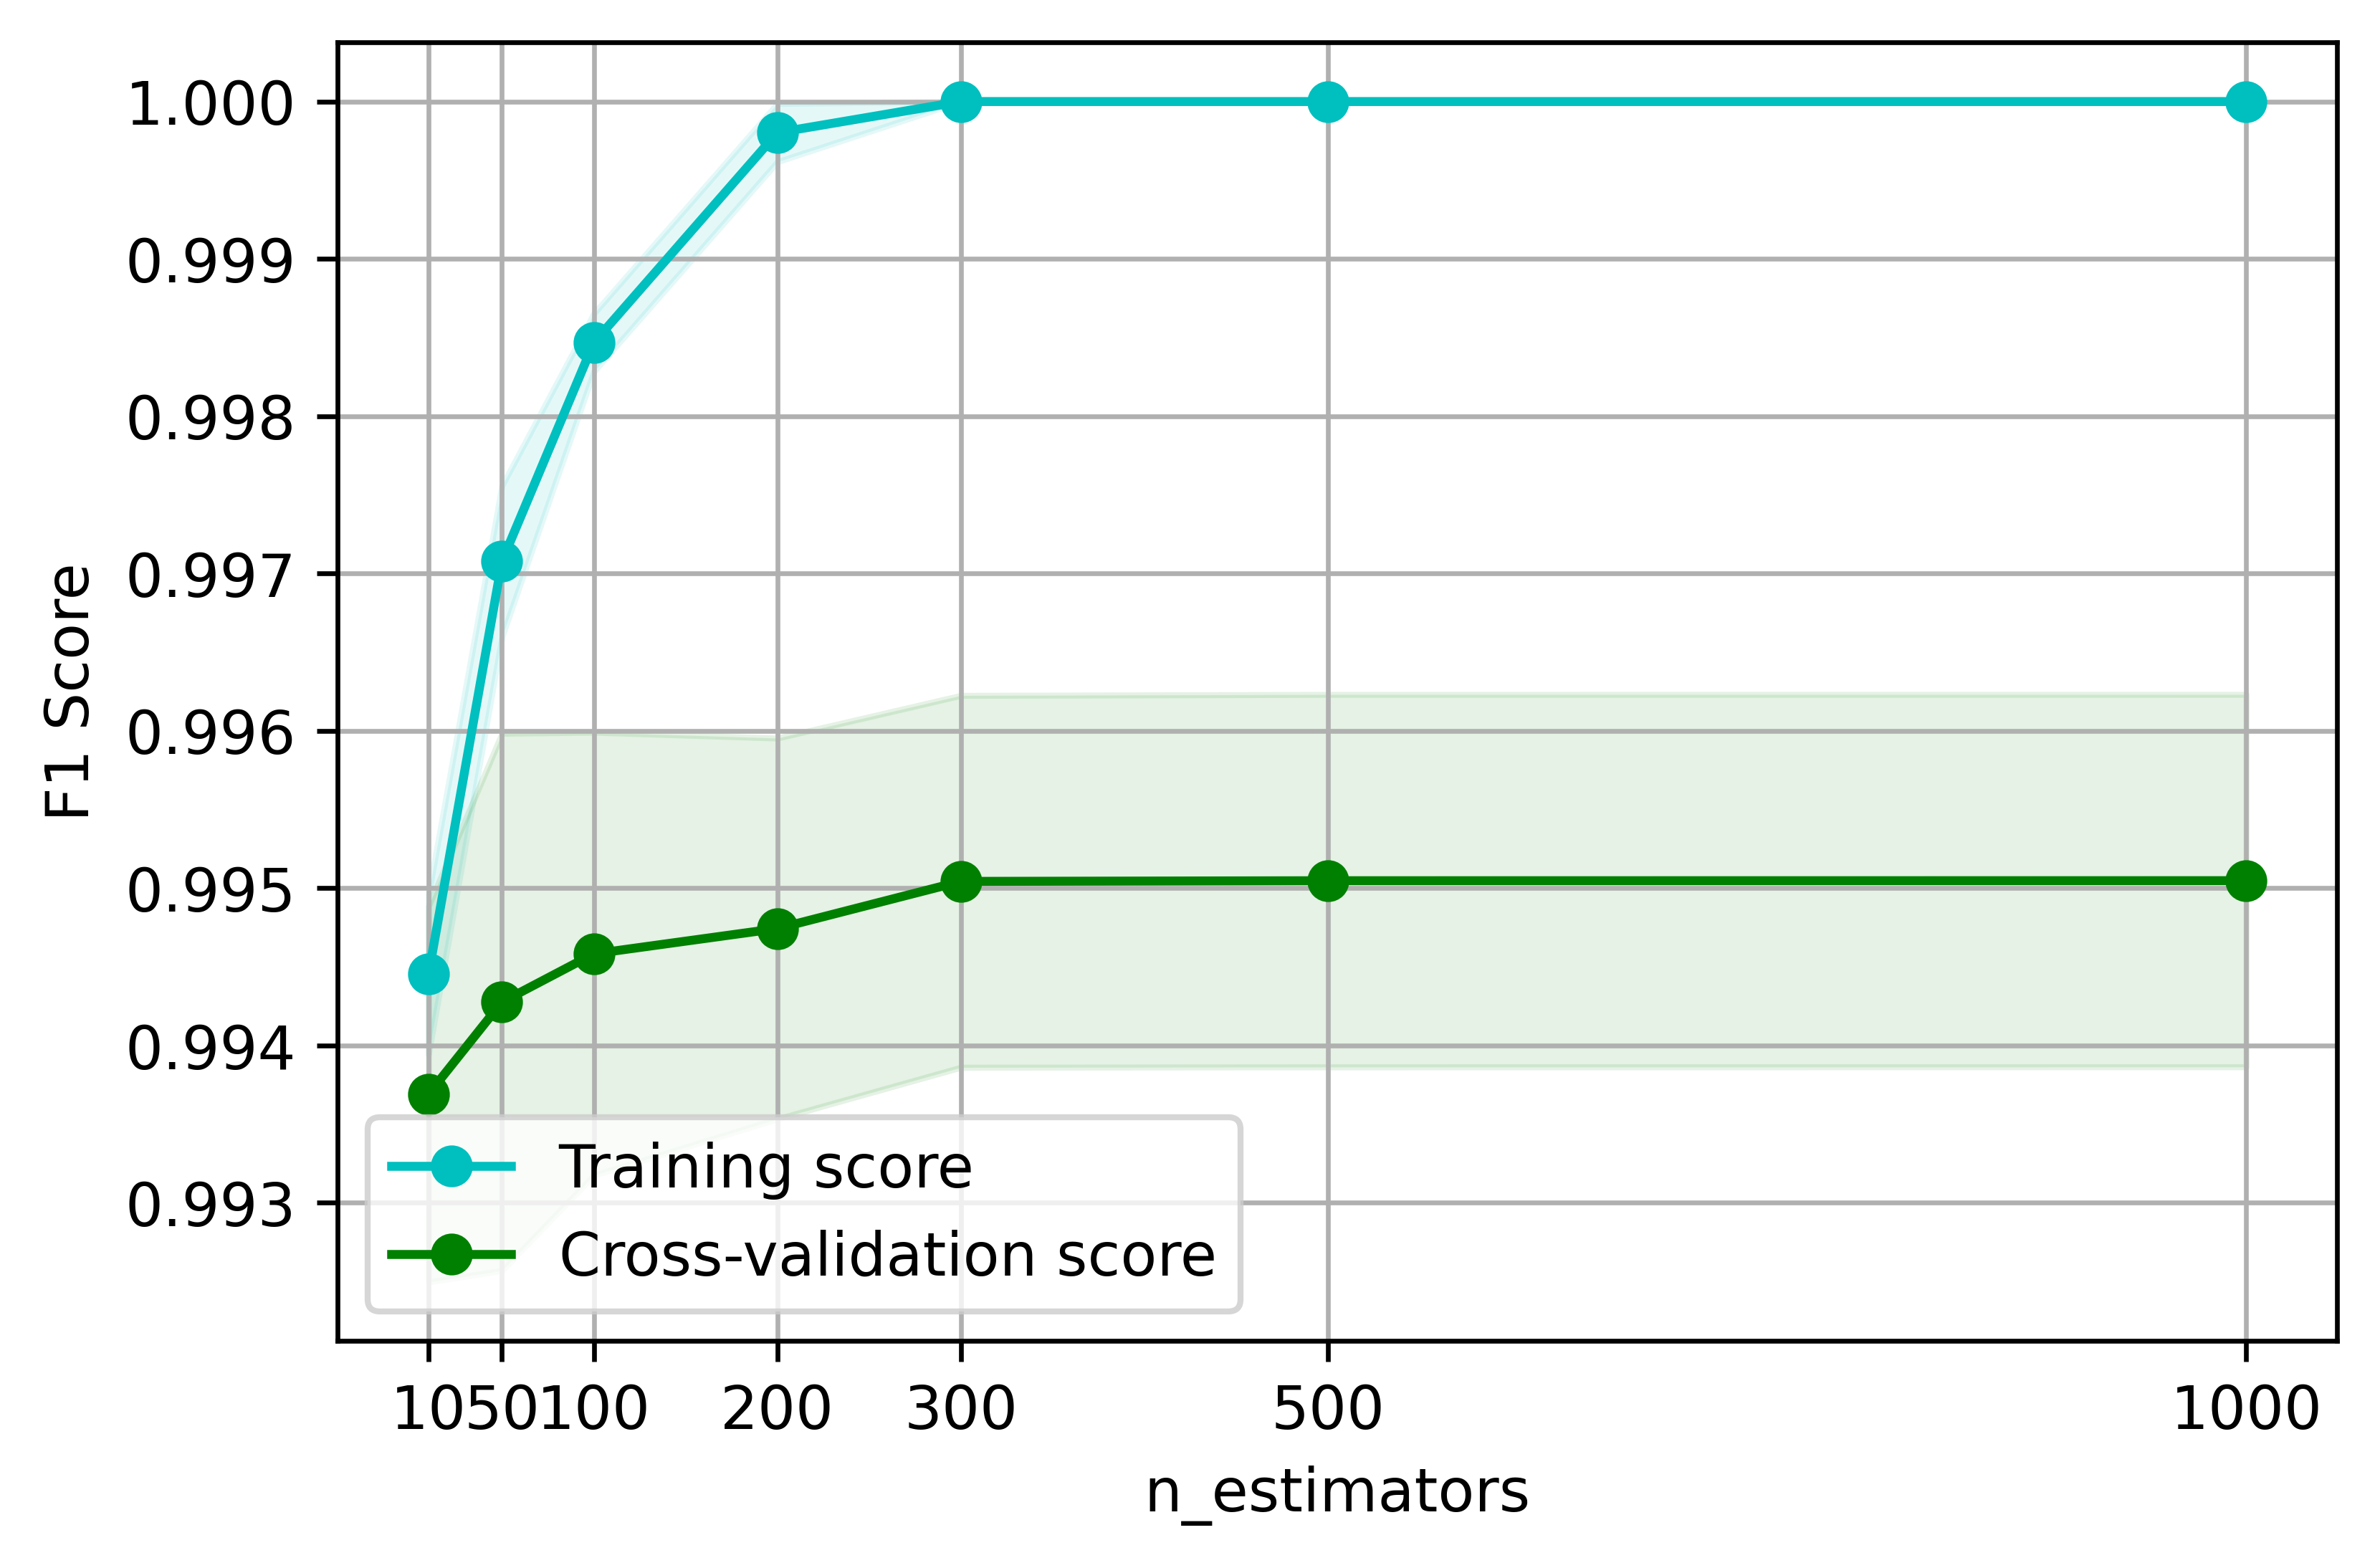

In [36]:
# Number of estimators
plt.figure(dpi=600)

param_range = [
    {"n_estimators":10},
    {"n_estimators":50},
    {"n_estimators":100},
    {"n_estimators":200},
    {"n_estimators":300},
    {"n_estimators":500},
    {"n_estimators":1000},
    ]

params = {
    'depth': 6,
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'AUC',
    'loss_function': 'MultiClass'
}


def param_learning_curve(X,
                         y,
                         params,
                         param_range,
                         ml_method,
                         cv):
    """
    :param X: Dataset for training
    :param y: Ground Truth of training data
    :param params: dictionary of DNN params
    :param param_range: parameter range for dict
    :param ml_method: ml_method unique identifier
    :param cv: cross validation instance to be used

    :return:
    """
    plt.figure(dpi=600)

    np_train_scores = np.empty((0, sss.n_splits))
    np_test_scores = np.empty((0, sss.n_splits))

    # Get param name and values
    param_values = []
    param_name = list(param_range[0].keys())[0]
    for d in param_range:
        param_values.append(list(d.values())[0])
    param_labels = param_values

    # Check if param values have string type
    if any(isinstance(item, str) for item in param_values):
        len_param_values = len(param_values)
        param_values = list(range(0,len_param_values))


    for param in param_range:
        params.update(param)
        print(f"Starting params: {params}")
        cv_scores_train = []
        cv_scores_test = []

        fold=1
        for train_index, test_index in cv.split(X, y):
            Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
            ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
            clf_param = CatBoostClassifier(**params)
            clf_param.fit(Xtrain, ytrain)


            ypred = clf_param.predict(Xtrain)
            f1_weighted_score_train=f1_score(ytrain, ypred, average='weighted')

            ypredict_test = clf_param.predict(Xtest)
            f1_weighted_score_test=f1_score(ytest, ypredict_test, average='weighted')

            cv_scores_test.append(f1_weighted_score_test)
            cv_scores_train.append(f1_weighted_score_train)
            fold+=1
        np_train_scores = np.append(np_train_scores,[cv_scores_train], axis=0)
        np_test_scores = np.append(np_test_scores,[cv_scores_test], axis=0)

    # Compute for fill_between plot
    np_train_scores_mean = np.mean(np_train_scores, axis=1)
    np_train_scores_std = np.std(np_train_scores, axis=1)
    np_test_scores_mean = np.mean(np_test_scores, axis=1)
    np_test_scores_std = np.std(np_test_scores, axis=1)


   # Plot
    plt.grid()
    plt.fill_between(param_values, np_train_scores_mean - np_train_scores_std,
                 np_train_scores_mean + np_train_scores_std, alpha=0.1,
                 color="c")
    plt.fill_between(param_values, np_test_scores_mean - np_test_scores_std,
                 np_test_scores_mean + np_test_scores_std, alpha=0.1, color="g")
    plt.plot(param_values, np_train_scores_mean, 'o-', color="c",
         label="Training score")
    plt.plot(param_values, np_test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

    # Labels and legends
    plt.xticks(ticks=param_values, labels=param_labels)
    plt.ylabel("F1 Score")
    plt.xlabel(param_name)
    # plt.legend(loc='upper right')
    plt.legend(loc="best")
    plt.savefig(os.path.join(model_dir, f"{ml_method}_optimizer_learningcurve.png"))
    plt.show()

param_learning_curve(X, y, params, param_range, ml_method, cv=sss)

In [ ]:
# Number of estimators
plt.figure(dpi=600)

param_range = [
    {"learning_rate":0.001},
    {"learning_rate":0.01},
    {"learning_rate":0.05},
    {"learning_rate":0.1},
    {"learning_rate":0.15},
    {"learning_rate":0.2},
    ]

params = {
    'depth': 6,
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'AUC',
    'loss_function': 'MultiClass'
}

param_learning_curve(X, y, params, param_range, ml_method, cv=sss)

Starting params: {'depth': 6, 'n_estimators': 1000, 'learning_rate': 0.001, 'custom_loss': 'AUC', 'loss_function': 'MultiClass'}
0:	learn: 1.6058008	total: 8.15ms	remaining: 8.14s
1:	learn: 1.6022219	total: 23.1ms	remaining: 11.5s
2:	learn: 1.5985563	total: 31.5ms	remaining: 10.5s
3:	learn: 1.5948476	total: 39.7ms	remaining: 9.9s
4:	learn: 1.5911353	total: 48ms	remaining: 9.55s
5:	learn: 1.5875751	total: 56.2ms	remaining: 9.31s
6:	learn: 1.5840061	total: 64ms	remaining: 9.08s
7:	learn: 1.5804895	total: 71ms	remaining: 8.81s
8:	learn: 1.5770170	total: 79.4ms	remaining: 8.74s
9:	learn: 1.5735175	total: 87.8ms	remaining: 8.69s
10:	learn: 1.5700196	total: 95.3ms	remaining: 8.57s
11:	learn: 1.5665378	total: 104ms	remaining: 8.55s
12:	learn: 1.5631356	total: 112ms	remaining: 8.47s
13:	learn: 1.5597844	total: 120ms	remaining: 8.42s
14:	learn: 1.5563849	total: 127ms	remaining: 8.35s
15:	learn: 1.5529114	total: 135ms	remaining: 8.29s
16:	learn: 1.5495454	total: 142ms	remaining: 8.23s
17:	learn:

179:	learn: 1.1358309	total: 1.54s	remaining: 7.04s
180:	learn: 1.1339460	total: 1.55s	remaining: 7.03s
181:	learn: 1.1320372	total: 1.56s	remaining: 7.02s
182:	learn: 1.1302180	total: 1.57s	remaining: 7.01s
183:	learn: 1.1283528	total: 1.58s	remaining: 7.02s
184:	learn: 1.1264759	total: 1.59s	remaining: 7.01s
185:	learn: 1.1245453	total: 1.6s	remaining: 7s
186:	learn: 1.1226225	total: 1.61s	remaining: 6.99s
187:	learn: 1.1207158	total: 1.61s	remaining: 6.98s
188:	learn: 1.1188591	total: 1.62s	remaining: 6.97s
189:	learn: 1.1169541	total: 1.63s	remaining: 6.96s
190:	learn: 1.1150761	total: 1.64s	remaining: 6.95s
191:	learn: 1.1132515	total: 1.65s	remaining: 6.94s
192:	learn: 1.1114424	total: 1.66s	remaining: 6.94s
193:	learn: 1.1095131	total: 1.67s	remaining: 6.93s
194:	learn: 1.1076912	total: 1.68s	remaining: 6.92s
195:	learn: 1.1058492	total: 1.68s	remaining: 6.91s
196:	learn: 1.1040243	total: 1.69s	remaining: 6.9s
197:	learn: 1.1021990	total: 1.7s	remaining: 6.88s
198:	learn: 1.1004

351:	learn: 0.8695490	total: 2.95s	remaining: 5.43s
352:	learn: 0.8682947	total: 2.96s	remaining: 5.42s
353:	learn: 0.8670650	total: 2.97s	remaining: 5.41s
354:	learn: 0.8658479	total: 2.98s	remaining: 5.41s
355:	learn: 0.8645700	total: 2.98s	remaining: 5.4s
356:	learn: 0.8633301	total: 2.99s	remaining: 5.39s
357:	learn: 0.8620811	total: 3s	remaining: 5.38s
358:	learn: 0.8608284	total: 3.01s	remaining: 5.37s
359:	learn: 0.8596070	total: 3.02s	remaining: 5.36s
360:	learn: 0.8583917	total: 3.02s	remaining: 5.35s
361:	learn: 0.8571423	total: 3.03s	remaining: 5.34s
362:	learn: 0.8559265	total: 3.04s	remaining: 5.33s
363:	learn: 0.8546926	total: 3.05s	remaining: 5.32s
364:	learn: 0.8534733	total: 3.06s	remaining: 5.32s
365:	learn: 0.8522756	total: 3.06s	remaining: 5.31s
366:	learn: 0.8510645	total: 3.07s	remaining: 5.3s
367:	learn: 0.8498049	total: 3.08s	remaining: 5.29s
368:	learn: 0.8485978	total: 3.09s	remaining: 5.28s
369:	learn: 0.8473644	total: 3.1s	remaining: 5.27s
370:	learn: 0.8461

515:	learn: 0.6944077	total: 4.36s	remaining: 4.08s
516:	learn: 0.6935032	total: 4.36s	remaining: 4.08s
517:	learn: 0.6925985	total: 4.37s	remaining: 4.07s
518:	learn: 0.6916934	total: 4.38s	remaining: 4.06s
519:	learn: 0.6907593	total: 4.39s	remaining: 4.05s
520:	learn: 0.6898739	total: 4.4s	remaining: 4.04s
521:	learn: 0.6889662	total: 4.41s	remaining: 4.04s
522:	learn: 0.6881013	total: 4.41s	remaining: 4.03s
523:	learn: 0.6872074	total: 4.42s	remaining: 4.02s
524:	learn: 0.6863457	total: 4.43s	remaining: 4.01s
525:	learn: 0.6854567	total: 4.44s	remaining: 4s
526:	learn: 0.6845870	total: 4.45s	remaining: 3.99s
527:	learn: 0.6837192	total: 4.45s	remaining: 3.98s
528:	learn: 0.6828520	total: 4.46s	remaining: 3.97s
529:	learn: 0.6819780	total: 4.47s	remaining: 3.96s
530:	learn: 0.6810932	total: 4.48s	remaining: 3.96s
531:	learn: 0.6802462	total: 4.49s	remaining: 3.95s
532:	learn: 0.6793919	total: 4.49s	remaining: 3.94s
533:	learn: 0.6785128	total: 4.5s	remaining: 3.93s
534:	learn: 0.677

689:	learn: 0.5583002	total: 5.76s	remaining: 2.59s
690:	learn: 0.5576397	total: 5.77s	remaining: 2.58s
691:	learn: 0.5569892	total: 5.78s	remaining: 2.57s
692:	learn: 0.5563281	total: 5.78s	remaining: 2.56s
693:	learn: 0.5556633	total: 5.79s	remaining: 2.55s
694:	learn: 0.5550074	total: 5.8s	remaining: 2.54s
695:	learn: 0.5543348	total: 5.81s	remaining: 2.54s
696:	learn: 0.5536685	total: 5.82s	remaining: 2.53s
697:	learn: 0.5530083	total: 5.82s	remaining: 2.52s
698:	learn: 0.5523552	total: 5.83s	remaining: 2.51s
699:	learn: 0.5516821	total: 5.84s	remaining: 2.5s
700:	learn: 0.5510229	total: 5.85s	remaining: 2.49s
701:	learn: 0.5503530	total: 5.86s	remaining: 2.48s
702:	learn: 0.5496832	total: 5.86s	remaining: 2.48s
703:	learn: 0.5490159	total: 5.87s	remaining: 2.47s
704:	learn: 0.5483565	total: 5.88s	remaining: 2.46s
705:	learn: 0.5476802	total: 5.88s	remaining: 2.45s
706:	learn: 0.5470392	total: 5.89s	remaining: 2.44s
707:	learn: 0.5463731	total: 5.9s	remaining: 2.43s
708:	learn: 0.5

867:	learn: 0.4533614	total: 7.16s	remaining: 1.09s
868:	learn: 0.4528359	total: 7.17s	remaining: 1.08s
869:	learn: 0.4523323	total: 7.18s	remaining: 1.07s
870:	learn: 0.4518190	total: 7.19s	remaining: 1.06s
871:	learn: 0.4513044	total: 7.19s	remaining: 1.05s
872:	learn: 0.4507811	total: 7.2s	remaining: 1.05s
873:	learn: 0.4502496	total: 7.21s	remaining: 1.04s
874:	learn: 0.4497305	total: 7.22s	remaining: 1.03s
875:	learn: 0.4492263	total: 7.23s	remaining: 1.02s
876:	learn: 0.4487137	total: 7.24s	remaining: 1.01s
877:	learn: 0.4482079	total: 7.24s	remaining: 1.01s
878:	learn: 0.4476924	total: 7.25s	remaining: 998ms
879:	learn: 0.4471874	total: 7.26s	remaining: 990ms
880:	learn: 0.4466709	total: 7.27s	remaining: 982ms
881:	learn: 0.4461546	total: 7.28s	remaining: 973ms
882:	learn: 0.4456527	total: 7.28s	remaining: 965ms
883:	learn: 0.4451431	total: 7.29s	remaining: 957ms
884:	learn: 0.4446355	total: 7.3s	remaining: 949ms
885:	learn: 0.4441357	total: 7.31s	remaining: 941ms
886:	learn: 0.

34:	learn: 1.4910012	total: 265ms	remaining: 7.32s
35:	learn: 1.4878491	total: 275ms	remaining: 7.35s
36:	learn: 1.4847397	total: 282ms	remaining: 7.35s
37:	learn: 1.4816193	total: 291ms	remaining: 7.36s
38:	learn: 1.4784553	total: 298ms	remaining: 7.34s
39:	learn: 1.4753677	total: 305ms	remaining: 7.32s
40:	learn: 1.4722097	total: 312ms	remaining: 7.3s
41:	learn: 1.4691162	total: 319ms	remaining: 7.28s
42:	learn: 1.4661078	total: 326ms	remaining: 7.26s
43:	learn: 1.4631371	total: 334ms	remaining: 7.26s
44:	learn: 1.4601597	total: 342ms	remaining: 7.25s
45:	learn: 1.4571534	total: 350ms	remaining: 7.25s
46:	learn: 1.4541496	total: 357ms	remaining: 7.24s
47:	learn: 1.4512171	total: 364ms	remaining: 7.22s
48:	learn: 1.4483086	total: 372ms	remaining: 7.21s
49:	learn: 1.4453411	total: 379ms	remaining: 7.21s
50:	learn: 1.4423471	total: 386ms	remaining: 7.19s
51:	learn: 1.4393112	total: 396ms	remaining: 7.22s
52:	learn: 1.4364136	total: 403ms	remaining: 7.2s
53:	learn: 1.4335784	total: 412ms

213:	learn: 1.0744757	total: 1.68s	remaining: 6.18s
214:	learn: 1.0727479	total: 1.69s	remaining: 6.17s
215:	learn: 1.0709727	total: 1.7s	remaining: 6.16s
216:	learn: 1.0692402	total: 1.71s	remaining: 6.16s
217:	learn: 1.0675273	total: 1.71s	remaining: 6.15s
218:	learn: 1.0658019	total: 1.72s	remaining: 6.14s
219:	learn: 1.0641362	total: 1.73s	remaining: 6.13s
220:	learn: 1.0624556	total: 1.74s	remaining: 6.12s
221:	learn: 1.0607221	total: 1.74s	remaining: 6.11s
222:	learn: 1.0589193	total: 1.75s	remaining: 6.1s
223:	learn: 1.0572242	total: 1.76s	remaining: 6.09s
224:	learn: 1.0555789	total: 1.77s	remaining: 6.08s
225:	learn: 1.0538607	total: 1.77s	remaining: 6.07s
226:	learn: 1.0521371	total: 1.78s	remaining: 6.06s
227:	learn: 1.0504565	total: 1.79s	remaining: 6.06s
228:	learn: 1.0487843	total: 1.79s	remaining: 6.04s
229:	learn: 1.0470759	total: 1.8s	remaining: 6.04s
230:	learn: 1.0454048	total: 1.81s	remaining: 6.03s
231:	learn: 1.0437808	total: 1.82s	remaining: 6.02s
232:	learn: 1.0

391:	learn: 0.8225053	total: 3.08s	remaining: 4.77s
392:	learn: 0.8213523	total: 3.08s	remaining: 4.76s
393:	learn: 0.8201948	total: 3.09s	remaining: 4.75s
394:	learn: 0.8190640	total: 3.1s	remaining: 4.75s
395:	learn: 0.8179300	total: 3.11s	remaining: 4.74s
396:	learn: 0.8167592	total: 3.12s	remaining: 4.73s
397:	learn: 0.8156142	total: 3.12s	remaining: 4.73s
398:	learn: 0.8144494	total: 3.13s	remaining: 4.72s
399:	learn: 0.8133166	total: 3.14s	remaining: 4.71s
400:	learn: 0.8121932	total: 3.15s	remaining: 4.7s
401:	learn: 0.8110447	total: 3.15s	remaining: 4.69s
402:	learn: 0.8099224	total: 3.16s	remaining: 4.68s
403:	learn: 0.8087620	total: 3.17s	remaining: 4.67s
404:	learn: 0.8076249	total: 3.17s	remaining: 4.67s
405:	learn: 0.8065464	total: 3.18s	remaining: 4.66s
406:	learn: 0.8054480	total: 3.19s	remaining: 4.65s
407:	learn: 0.8043458	total: 3.2s	remaining: 4.64s
408:	learn: 0.8032443	total: 3.21s	remaining: 4.63s
409:	learn: 0.8021102	total: 3.22s	remaining: 4.63s
410:	learn: 0.8

566:	learn: 0.6514599	total: 4.46s	remaining: 3.4s
567:	learn: 0.6506129	total: 4.47s	remaining: 3.4s
568:	learn: 0.6497721	total: 4.47s	remaining: 3.39s
569:	learn: 0.6489477	total: 4.48s	remaining: 3.38s
570:	learn: 0.6481092	total: 4.49s	remaining: 3.38s
571:	learn: 0.6472985	total: 4.5s	remaining: 3.37s
572:	learn: 0.6464465	total: 4.51s	remaining: 3.36s
573:	learn: 0.6455980	total: 4.52s	remaining: 3.35s
574:	learn: 0.6447940	total: 4.53s	remaining: 3.34s
575:	learn: 0.6439646	total: 4.53s	remaining: 3.34s
576:	learn: 0.6431264	total: 4.54s	remaining: 3.33s
577:	learn: 0.6423286	total: 4.55s	remaining: 3.32s
578:	learn: 0.6415161	total: 4.56s	remaining: 3.31s
579:	learn: 0.6406870	total: 4.57s	remaining: 3.31s
580:	learn: 0.6398873	total: 4.58s	remaining: 3.3s
581:	learn: 0.6390745	total: 4.58s	remaining: 3.29s
582:	learn: 0.6382737	total: 4.59s	remaining: 3.29s
583:	learn: 0.6374794	total: 4.6s	remaining: 3.28s
584:	learn: 0.6366669	total: 4.61s	remaining: 3.27s
585:	learn: 0.635

741:	learn: 0.5259640	total: 5.86s	remaining: 2.04s
742:	learn: 0.5253510	total: 5.87s	remaining: 2.03s
743:	learn: 0.5247339	total: 5.88s	remaining: 2.02s
744:	learn: 0.5240984	total: 5.89s	remaining: 2.02s
745:	learn: 0.5234855	total: 5.89s	remaining: 2.01s
746:	learn: 0.5228666	total: 5.9s	remaining: 2s
747:	learn: 0.5222458	total: 5.91s	remaining: 1.99s
748:	learn: 0.5216443	total: 5.92s	remaining: 1.98s
749:	learn: 0.5210264	total: 5.92s	remaining: 1.98s
750:	learn: 0.5204178	total: 5.93s	remaining: 1.97s
751:	learn: 0.5197881	total: 5.94s	remaining: 1.96s
752:	learn: 0.5191902	total: 5.95s	remaining: 1.95s
753:	learn: 0.5185778	total: 5.96s	remaining: 1.94s
754:	learn: 0.5179641	total: 5.97s	remaining: 1.94s
755:	learn: 0.5173752	total: 5.97s	remaining: 1.93s
756:	learn: 0.5167590	total: 5.98s	remaining: 1.92s
757:	learn: 0.5161360	total: 5.99s	remaining: 1.91s
758:	learn: 0.5155357	total: 6.01s	remaining: 1.91s
759:	learn: 0.5149152	total: 6.02s	remaining: 1.9s
760:	learn: 0.514

917:	learn: 0.4300552	total: 7.25s	remaining: 648ms
918:	learn: 0.4295813	total: 7.26s	remaining: 640ms
919:	learn: 0.4291004	total: 7.27s	remaining: 632ms
920:	learn: 0.4286377	total: 7.28s	remaining: 625ms
921:	learn: 0.4281710	total: 7.29s	remaining: 617ms
922:	learn: 0.4276929	total: 7.3s	remaining: 609ms
923:	learn: 0.4272170	total: 7.3s	remaining: 601ms
924:	learn: 0.4267559	total: 7.31s	remaining: 593ms
925:	learn: 0.4262763	total: 7.32s	remaining: 585ms
926:	learn: 0.4258248	total: 7.33s	remaining: 577ms
927:	learn: 0.4253503	total: 7.33s	remaining: 569ms
928:	learn: 0.4248922	total: 7.34s	remaining: 561ms
929:	learn: 0.4244195	total: 7.35s	remaining: 553ms
930:	learn: 0.4239653	total: 7.36s	remaining: 545ms
931:	learn: 0.4234802	total: 7.37s	remaining: 537ms
932:	learn: 0.4230056	total: 7.37s	remaining: 529ms
933:	learn: 0.4225450	total: 7.38s	remaining: 522ms
934:	learn: 0.4220829	total: 7.39s	remaining: 514ms
935:	learn: 0.4216327	total: 7.39s	remaining: 506ms
936:	learn: 0.

94:	learn: 1.3221554	total: 727ms	remaining: 6.92s
95:	learn: 1.3196941	total: 735ms	remaining: 6.92s
96:	learn: 1.3171965	total: 743ms	remaining: 6.92s
97:	learn: 1.3147688	total: 751ms	remaining: 6.91s
98:	learn: 1.3122638	total: 758ms	remaining: 6.9s
99:	learn: 1.3097746	total: 767ms	remaining: 6.9s
100:	learn: 1.3072936	total: 774ms	remaining: 6.89s
101:	learn: 1.3048973	total: 783ms	remaining: 6.89s
102:	learn: 1.3024712	total: 790ms	remaining: 6.88s
103:	learn: 1.3001268	total: 797ms	remaining: 6.87s
104:	learn: 1.2976983	total: 805ms	remaining: 6.86s
105:	learn: 1.2953130	total: 813ms	remaining: 6.86s
106:	learn: 1.2928581	total: 821ms	remaining: 6.85s
107:	learn: 1.2904875	total: 830ms	remaining: 6.85s
108:	learn: 1.2881316	total: 838ms	remaining: 6.85s
109:	learn: 1.2857785	total: 847ms	remaining: 6.85s
110:	learn: 1.2833717	total: 855ms	remaining: 6.84s
111:	learn: 1.2809584	total: 862ms	remaining: 6.84s
112:	learn: 1.2785833	total: 871ms	remaining: 6.84s
113:	learn: 1.276248

271:	learn: 0.9794394	total: 2.12s	remaining: 5.68s
272:	learn: 0.9779522	total: 2.13s	remaining: 5.67s
273:	learn: 0.9764643	total: 2.14s	remaining: 5.66s
274:	learn: 0.9749225	total: 2.15s	remaining: 5.66s
275:	learn: 0.9734445	total: 2.15s	remaining: 5.65s
276:	learn: 0.9719518	total: 2.16s	remaining: 5.64s
277:	learn: 0.9704371	total: 2.17s	remaining: 5.63s
278:	learn: 0.9689529	total: 2.18s	remaining: 5.62s
279:	learn: 0.9674591	total: 2.18s	remaining: 5.62s
280:	learn: 0.9659598	total: 2.19s	remaining: 5.61s
281:	learn: 0.9645016	total: 2.2s	remaining: 5.61s
282:	learn: 0.9629974	total: 2.21s	remaining: 5.6s
283:	learn: 0.9615464	total: 2.22s	remaining: 5.59s
284:	learn: 0.9600476	total: 2.22s	remaining: 5.58s
285:	learn: 0.9585874	total: 2.23s	remaining: 5.57s
286:	learn: 0.9570959	total: 2.24s	remaining: 5.56s
287:	learn: 0.9556048	total: 2.25s	remaining: 5.55s
288:	learn: 0.9541423	total: 2.25s	remaining: 5.54s
289:	learn: 0.9527058	total: 2.26s	remaining: 5.54s
290:	learn: 0.

434:	learn: 0.7735556	total: 3.53s	remaining: 4.58s
435:	learn: 0.7724879	total: 3.54s	remaining: 4.58s
436:	learn: 0.7714477	total: 3.55s	remaining: 4.57s
437:	learn: 0.7703948	total: 3.55s	remaining: 4.56s
438:	learn: 0.7693104	total: 3.56s	remaining: 4.55s
439:	learn: 0.7682879	total: 3.57s	remaining: 4.54s
440:	learn: 0.7672793	total: 3.58s	remaining: 4.53s
441:	learn: 0.7662200	total: 3.58s	remaining: 4.52s
442:	learn: 0.7651668	total: 3.59s	remaining: 4.52s
443:	learn: 0.7640996	total: 3.6s	remaining: 4.51s
444:	learn: 0.7630742	total: 3.61s	remaining: 4.5s
445:	learn: 0.7620469	total: 3.61s	remaining: 4.49s
446:	learn: 0.7610184	total: 3.62s	remaining: 4.48s
447:	learn: 0.7600057	total: 3.63s	remaining: 4.47s
448:	learn: 0.7589893	total: 3.64s	remaining: 4.46s
449:	learn: 0.7579722	total: 3.65s	remaining: 4.46s
450:	learn: 0.7569384	total: 3.65s	remaining: 4.45s
451:	learn: 0.7559129	total: 3.66s	remaining: 4.44s
452:	learn: 0.7549418	total: 3.67s	remaining: 4.43s
453:	learn: 0.

599:	learn: 0.6238131	total: 4.91s	remaining: 3.27s
600:	learn: 0.6230023	total: 4.92s	remaining: 3.26s
601:	learn: 0.6222325	total: 4.92s	remaining: 3.26s
602:	learn: 0.6214564	total: 4.93s	remaining: 3.25s
603:	learn: 0.6206965	total: 4.94s	remaining: 3.24s
604:	learn: 0.6199160	total: 4.95s	remaining: 3.23s
605:	learn: 0.6191159	total: 4.96s	remaining: 3.22s
606:	learn: 0.6183447	total: 4.97s	remaining: 3.21s
607:	learn: 0.6175684	total: 4.97s	remaining: 3.21s
608:	learn: 0.6168165	total: 4.98s	remaining: 3.2s
609:	learn: 0.6160582	total: 4.99s	remaining: 3.19s
610:	learn: 0.6152956	total: 5s	remaining: 3.18s
611:	learn: 0.6145238	total: 5.01s	remaining: 3.17s
612:	learn: 0.6137453	total: 5.01s	remaining: 3.17s
613:	learn: 0.6129819	total: 5.02s	remaining: 3.16s
614:	learn: 0.6122189	total: 5.03s	remaining: 3.15s
615:	learn: 0.6114412	total: 5.04s	remaining: 3.14s
616:	learn: 0.6106751	total: 5.04s	remaining: 3.13s
617:	learn: 0.6099334	total: 5.05s	remaining: 3.12s
618:	learn: 0.60

762:	learn: 0.5116132	total: 6.32s	remaining: 1.96s
763:	learn: 0.5110073	total: 6.33s	remaining: 1.96s
764:	learn: 0.5103834	total: 6.34s	remaining: 1.95s
765:	learn: 0.5098020	total: 6.37s	remaining: 1.95s
766:	learn: 0.5091915	total: 6.38s	remaining: 1.94s
767:	learn: 0.5085967	total: 6.39s	remaining: 1.93s
768:	learn: 0.5080119	total: 6.39s	remaining: 1.92s
769:	learn: 0.5074217	total: 6.4s	remaining: 1.91s
770:	learn: 0.5068361	total: 6.41s	remaining: 1.9s
771:	learn: 0.5062334	total: 6.42s	remaining: 1.9s
772:	learn: 0.5056476	total: 6.43s	remaining: 1.89s
773:	learn: 0.5050816	total: 6.44s	remaining: 1.88s
774:	learn: 0.5045095	total: 6.45s	remaining: 1.87s
775:	learn: 0.5039007	total: 6.46s	remaining: 1.86s
776:	learn: 0.5033271	total: 6.46s	remaining: 1.85s
777:	learn: 0.5027313	total: 6.47s	remaining: 1.85s
778:	learn: 0.5021385	total: 6.48s	remaining: 1.84s
779:	learn: 0.5015748	total: 6.49s	remaining: 1.83s
780:	learn: 0.5009796	total: 6.5s	remaining: 1.82s
781:	learn: 0.50

939:	learn: 0.4179589	total: 7.91s	remaining: 505ms
940:	learn: 0.4174984	total: 7.92s	remaining: 497ms
941:	learn: 0.4170265	total: 7.93s	remaining: 488ms
942:	learn: 0.4165561	total: 7.94s	remaining: 480ms
943:	learn: 0.4160987	total: 7.95s	remaining: 471ms
944:	learn: 0.4156438	total: 7.95s	remaining: 463ms
945:	learn: 0.4151843	total: 7.96s	remaining: 454ms
946:	learn: 0.4147322	total: 7.97s	remaining: 446ms
947:	learn: 0.4142975	total: 7.98s	remaining: 438ms
948:	learn: 0.4138255	total: 7.99s	remaining: 429ms
949:	learn: 0.4133709	total: 8s	remaining: 421ms
950:	learn: 0.4129261	total: 8.01s	remaining: 412ms
951:	learn: 0.4124696	total: 8.01s	remaining: 404ms
952:	learn: 0.4120131	total: 8.02s	remaining: 396ms
953:	learn: 0.4115656	total: 8.03s	remaining: 387ms
954:	learn: 0.4111054	total: 8.04s	remaining: 379ms
955:	learn: 0.4106482	total: 8.05s	remaining: 370ms
956:	learn: 0.4101821	total: 8.05s	remaining: 362ms
957:	learn: 0.4097117	total: 8.06s	remaining: 354ms
958:	learn: 0.4

105:	learn: 1.2949735	total: 879ms	remaining: 7.41s
106:	learn: 1.2925283	total: 886ms	remaining: 7.39s
107:	learn: 1.2901320	total: 893ms	remaining: 7.38s
108:	learn: 1.2877007	total: 901ms	remaining: 7.36s
109:	learn: 1.2853414	total: 908ms	remaining: 7.35s
110:	learn: 1.2829350	total: 916ms	remaining: 7.33s
111:	learn: 1.2806226	total: 924ms	remaining: 7.32s
112:	learn: 1.2782775	total: 931ms	remaining: 7.31s
113:	learn: 1.2758957	total: 939ms	remaining: 7.3s
114:	learn: 1.2735218	total: 947ms	remaining: 7.29s
115:	learn: 1.2711957	total: 955ms	remaining: 7.28s
116:	learn: 1.2689100	total: 963ms	remaining: 7.27s
117:	learn: 1.2665534	total: 971ms	remaining: 7.25s
118:	learn: 1.2642176	total: 978ms	remaining: 7.24s
119:	learn: 1.2619218	total: 985ms	remaining: 7.23s
120:	learn: 1.2596064	total: 993ms	remaining: 7.21s
121:	learn: 1.2573045	total: 1s	remaining: 7.2s
122:	learn: 1.2550303	total: 1.01s	remaining: 7.18s
123:	learn: 1.2526980	total: 1.01s	remaining: 7.17s
124:	learn: 1.250

268:	learn: 0.9844317	total: 2.28s	remaining: 6.21s
269:	learn: 0.9829494	total: 2.29s	remaining: 6.2s
270:	learn: 0.9813917	total: 2.3s	remaining: 6.19s
271:	learn: 0.9798660	total: 2.31s	remaining: 6.19s
272:	learn: 0.9783358	total: 2.32s	remaining: 6.18s
273:	learn: 0.9768554	total: 2.33s	remaining: 6.17s
274:	learn: 0.9753172	total: 2.34s	remaining: 6.17s
275:	learn: 0.9738262	total: 2.35s	remaining: 6.16s
276:	learn: 0.9723425	total: 2.35s	remaining: 6.15s
277:	learn: 0.9709017	total: 2.36s	remaining: 6.14s
278:	learn: 0.9694633	total: 2.37s	remaining: 6.13s
279:	learn: 0.9680315	total: 2.38s	remaining: 6.12s
280:	learn: 0.9665915	total: 2.39s	remaining: 6.11s
281:	learn: 0.9651518	total: 2.4s	remaining: 6.1s
282:	learn: 0.9637255	total: 2.4s	remaining: 6.09s
283:	learn: 0.9622874	total: 2.41s	remaining: 6.08s
284:	learn: 0.9607463	total: 2.42s	remaining: 6.07s
285:	learn: 0.9592731	total: 2.43s	remaining: 6.06s
286:	learn: 0.9578328	total: 2.44s	remaining: 6.06s
287:	learn: 0.956

429:	learn: 0.7807238	total: 4.58s	remaining: 6.07s
430:	learn: 0.7796496	total: 4.59s	remaining: 6.06s
431:	learn: 0.7785500	total: 4.6s	remaining: 6.05s
432:	learn: 0.7774527	total: 4.61s	remaining: 6.04s
433:	learn: 0.7764134	total: 4.63s	remaining: 6.03s
434:	learn: 0.7753761	total: 4.64s	remaining: 6.03s
435:	learn: 0.7743420	total: 4.66s	remaining: 6.02s
436:	learn: 0.7732540	total: 4.67s	remaining: 6.01s
437:	learn: 0.7721866	total: 4.67s	remaining: 6s
438:	learn: 0.7711503	total: 4.68s	remaining: 5.98s
439:	learn: 0.7701050	total: 4.69s	remaining: 5.97s
440:	learn: 0.7690439	total: 4.7s	remaining: 5.96s
441:	learn: 0.7680093	total: 4.71s	remaining: 5.94s
442:	learn: 0.7669273	total: 4.72s	remaining: 5.93s
443:	learn: 0.7658794	total: 4.73s	remaining: 5.92s
444:	learn: 0.7648785	total: 4.75s	remaining: 5.93s
445:	learn: 0.7638523	total: 4.76s	remaining: 5.92s
446:	learn: 0.7627903	total: 4.77s	remaining: 5.9s
447:	learn: 0.7617259	total: 4.78s	remaining: 5.89s
448:	learn: 0.7607

596:	learn: 0.6275701	total: 6.66s	remaining: 4.49s
597:	learn: 0.6267967	total: 6.67s	remaining: 4.48s
598:	learn: 0.6260400	total: 6.68s	remaining: 4.47s
599:	learn: 0.6252466	total: 6.68s	remaining: 4.46s
600:	learn: 0.6245096	total: 6.69s	remaining: 4.44s
601:	learn: 0.6237200	total: 6.7s	remaining: 4.43s
602:	learn: 0.6229756	total: 6.71s	remaining: 4.42s
603:	learn: 0.6221863	total: 6.72s	remaining: 4.4s
604:	learn: 0.6213967	total: 6.73s	remaining: 4.39s
605:	learn: 0.6206325	total: 6.74s	remaining: 4.38s
606:	learn: 0.6198682	total: 6.75s	remaining: 4.37s
607:	learn: 0.6190901	total: 6.76s	remaining: 4.36s
608:	learn: 0.6183399	total: 6.77s	remaining: 4.35s
609:	learn: 0.6176075	total: 6.78s	remaining: 4.34s
610:	learn: 0.6168442	total: 6.79s	remaining: 4.32s
611:	learn: 0.6160616	total: 6.8s	remaining: 4.31s
612:	learn: 0.6152992	total: 6.81s	remaining: 4.3s
613:	learn: 0.6145136	total: 6.82s	remaining: 4.29s
614:	learn: 0.6137595	total: 6.83s	remaining: 4.27s
615:	learn: 0.61

757:	learn: 0.5160399	total: 8.5s	remaining: 2.71s
758:	learn: 0.5154218	total: 8.51s	remaining: 2.7s
759:	learn: 0.5148313	total: 8.52s	remaining: 2.69s
760:	learn: 0.5142091	total: 8.53s	remaining: 2.68s
761:	learn: 0.5136243	total: 8.54s	remaining: 2.67s
762:	learn: 0.5130488	total: 8.55s	remaining: 2.65s
763:	learn: 0.5124441	total: 8.56s	remaining: 2.64s
764:	learn: 0.5118563	total: 8.56s	remaining: 2.63s
765:	learn: 0.5112339	total: 8.57s	remaining: 2.62s
766:	learn: 0.5106334	total: 8.58s	remaining: 2.61s
767:	learn: 0.5100278	total: 8.59s	remaining: 2.6s
768:	learn: 0.5094449	total: 8.6s	remaining: 2.58s
769:	learn: 0.5088348	total: 8.61s	remaining: 2.57s
770:	learn: 0.5082291	total: 8.63s	remaining: 2.56s
771:	learn: 0.5076489	total: 8.64s	remaining: 2.55s
772:	learn: 0.5070438	total: 8.66s	remaining: 2.54s
773:	learn: 0.5064466	total: 8.67s	remaining: 2.53s
774:	learn: 0.5058485	total: 8.69s	remaining: 2.52s
775:	learn: 0.5052617	total: 8.71s	remaining: 2.52s
776:	learn: 0.50

922:	learn: 0.4271286	total: 10.6s	remaining: 888ms
923:	learn: 0.4266500	total: 10.7s	remaining: 879ms
924:	learn: 0.4261761	total: 10.7s	remaining: 867ms
925:	learn: 0.4256932	total: 10.7s	remaining: 856ms
926:	learn: 0.4252382	total: 10.7s	remaining: 844ms
927:	learn: 0.4247692	total: 10.7s	remaining: 832ms
928:	learn: 0.4243011	total: 10.7s	remaining: 821ms
929:	learn: 0.4238140	total: 10.8s	remaining: 810ms
930:	learn: 0.4233603	total: 10.8s	remaining: 798ms
931:	learn: 0.4228972	total: 10.8s	remaining: 787ms
932:	learn: 0.4224199	total: 10.8s	remaining: 775ms
933:	learn: 0.4219444	total: 10.8s	remaining: 763ms
934:	learn: 0.4214890	total: 10.8s	remaining: 751ms
935:	learn: 0.4210168	total: 10.8s	remaining: 740ms
936:	learn: 0.4205427	total: 10.8s	remaining: 728ms
937:	learn: 0.4200756	total: 10.8s	remaining: 716ms
938:	learn: 0.4196032	total: 10.8s	remaining: 705ms
939:	learn: 0.4191452	total: 10.9s	remaining: 693ms
940:	learn: 0.4186753	total: 10.9s	remaining: 681ms
941:	learn: 

88:	learn: 1.3367153	total: 804ms	remaining: 8.22s
89:	learn: 1.3341061	total: 813ms	remaining: 8.22s
90:	learn: 1.3315631	total: 821ms	remaining: 8.2s
91:	learn: 1.3290423	total: 830ms	remaining: 8.19s
92:	learn: 1.3264629	total: 839ms	remaining: 8.18s
93:	learn: 1.3238987	total: 849ms	remaining: 8.18s
94:	learn: 1.3213627	total: 857ms	remaining: 8.16s
95:	learn: 1.3188330	total: 866ms	remaining: 8.16s
96:	learn: 1.3163139	total: 874ms	remaining: 8.14s
97:	learn: 1.3137661	total: 883ms	remaining: 8.13s
98:	learn: 1.3113334	total: 892ms	remaining: 8.12s
99:	learn: 1.3088346	total: 902ms	remaining: 8.11s
100:	learn: 1.3063780	total: 911ms	remaining: 8.11s
101:	learn: 1.3039061	total: 919ms	remaining: 8.09s
102:	learn: 1.3014716	total: 928ms	remaining: 8.08s
103:	learn: 1.2990390	total: 937ms	remaining: 8.07s
104:	learn: 1.2966350	total: 946ms	remaining: 8.06s
105:	learn: 1.2941990	total: 955ms	remaining: 8.05s
106:	learn: 1.2917957	total: 964ms	remaining: 8.04s
107:	learn: 1.2894690	tot

259:	learn: 0.9968951	total: 2.21s	remaining: 6.29s
260:	learn: 0.9953169	total: 2.22s	remaining: 6.28s
261:	learn: 0.9938129	total: 2.22s	remaining: 6.26s
262:	learn: 0.9922364	total: 2.23s	remaining: 6.25s
263:	learn: 0.9907157	total: 2.24s	remaining: 6.24s
264:	learn: 0.9892087	total: 2.25s	remaining: 6.24s
265:	learn: 0.9876635	total: 2.26s	remaining: 6.23s
266:	learn: 0.9861453	total: 2.27s	remaining: 6.22s
267:	learn: 0.9846294	total: 2.27s	remaining: 6.21s
268:	learn: 0.9831557	total: 2.29s	remaining: 6.21s
269:	learn: 0.9816566	total: 2.29s	remaining: 6.2s
270:	learn: 0.9801610	total: 2.3s	remaining: 6.19s
271:	learn: 0.9786390	total: 2.31s	remaining: 6.18s
272:	learn: 0.9771590	total: 2.32s	remaining: 6.17s
273:	learn: 0.9756204	total: 2.32s	remaining: 6.16s
274:	learn: 0.9740585	total: 2.33s	remaining: 6.15s
275:	learn: 0.9725901	total: 2.34s	remaining: 6.14s
276:	learn: 0.9710772	total: 2.35s	remaining: 6.13s
277:	learn: 0.9696218	total: 2.36s	remaining: 6.12s
278:	learn: 0.

439:	learn: 0.7680340	total: 3.62s	remaining: 4.6s
440:	learn: 0.7669985	total: 3.62s	remaining: 4.59s
441:	learn: 0.7659245	total: 3.63s	remaining: 4.58s
442:	learn: 0.7648895	total: 3.64s	remaining: 4.58s
443:	learn: 0.7638147	total: 3.65s	remaining: 4.57s
444:	learn: 0.7627771	total: 3.65s	remaining: 4.56s
445:	learn: 0.7617305	total: 3.66s	remaining: 4.55s
446:	learn: 0.7607066	total: 3.67s	remaining: 4.54s
447:	learn: 0.7596462	total: 3.68s	remaining: 4.53s
448:	learn: 0.7586099	total: 3.68s	remaining: 4.52s
449:	learn: 0.7575979	total: 3.69s	remaining: 4.51s
450:	learn: 0.7565634	total: 3.7s	remaining: 4.5s
451:	learn: 0.7555262	total: 3.71s	remaining: 4.49s
452:	learn: 0.7545381	total: 3.71s	remaining: 4.48s
453:	learn: 0.7535325	total: 3.72s	remaining: 4.47s
454:	learn: 0.7525227	total: 3.73s	remaining: 4.46s
455:	learn: 0.7515278	total: 3.73s	remaining: 4.46s
456:	learn: 0.7505155	total: 3.74s	remaining: 4.45s
457:	learn: 0.7494963	total: 3.75s	remaining: 4.44s
458:	learn: 0.7

619:	learn: 0.6076625	total: 5.01s	remaining: 3.07s
620:	learn: 0.6069279	total: 5.02s	remaining: 3.06s
621:	learn: 0.6061572	total: 5.03s	remaining: 3.06s
622:	learn: 0.6053783	total: 5.04s	remaining: 3.05s
623:	learn: 0.6046089	total: 5.04s	remaining: 3.04s
624:	learn: 0.6038732	total: 5.05s	remaining: 3.03s
625:	learn: 0.6031562	total: 5.06s	remaining: 3.02s
626:	learn: 0.6023955	total: 5.07s	remaining: 3.02s
627:	learn: 0.6016426	total: 5.08s	remaining: 3.01s
628:	learn: 0.6008614	total: 5.08s	remaining: 3s
629:	learn: 0.6001237	total: 5.09s	remaining: 2.99s
630:	learn: 0.5993567	total: 5.1s	remaining: 2.98s
631:	learn: 0.5986317	total: 5.11s	remaining: 2.97s
632:	learn: 0.5978845	total: 5.12s	remaining: 2.97s
633:	learn: 0.5971613	total: 5.12s	remaining: 2.96s
634:	learn: 0.5964502	total: 5.13s	remaining: 2.95s
635:	learn: 0.5957451	total: 5.14s	remaining: 2.94s
636:	learn: 0.5949821	total: 5.15s	remaining: 2.93s
637:	learn: 0.5942271	total: 5.15s	remaining: 2.92s
638:	learn: 0.59

803:	learn: 0.4867449	total: 6.41s	remaining: 1.56s
804:	learn: 0.4861743	total: 6.42s	remaining: 1.55s
805:	learn: 0.4856160	total: 6.43s	remaining: 1.55s
806:	learn: 0.4850388	total: 6.44s	remaining: 1.54s
807:	learn: 0.4844903	total: 6.44s	remaining: 1.53s
808:	learn: 0.4839072	total: 6.45s	remaining: 1.52s
809:	learn: 0.4833409	total: 6.46s	remaining: 1.51s
810:	learn: 0.4827853	total: 6.46s	remaining: 1.51s
811:	learn: 0.4822554	total: 6.47s	remaining: 1.5s
812:	learn: 0.4816789	total: 6.48s	remaining: 1.49s
813:	learn: 0.4811228	total: 6.49s	remaining: 1.48s
814:	learn: 0.4805584	total: 6.5s	remaining: 1.47s
815:	learn: 0.4799782	total: 6.5s	remaining: 1.47s
816:	learn: 0.4794237	total: 6.51s	remaining: 1.46s
817:	learn: 0.4788773	total: 6.52s	remaining: 1.45s
818:	learn: 0.4783080	total: 6.53s	remaining: 1.44s
819:	learn: 0.4777595	total: 6.54s	remaining: 1.43s
820:	learn: 0.4772059	total: 6.54s	remaining: 1.43s
821:	learn: 0.4766374	total: 6.55s	remaining: 1.42s
822:	learn: 0.4

977:	learn: 0.3995042	total: 7.78s	remaining: 175ms
978:	learn: 0.3990554	total: 7.78s	remaining: 167ms
979:	learn: 0.3986247	total: 7.79s	remaining: 159ms
980:	learn: 0.3981711	total: 7.8s	remaining: 151ms
981:	learn: 0.3977197	total: 7.81s	remaining: 143ms
982:	learn: 0.3972788	total: 7.81s	remaining: 135ms
983:	learn: 0.3968304	total: 7.82s	remaining: 127ms
984:	learn: 0.3963984	total: 7.83s	remaining: 119ms
985:	learn: 0.3959707	total: 7.84s	remaining: 111ms
986:	learn: 0.3955309	total: 7.84s	remaining: 103ms
987:	learn: 0.3950875	total: 7.85s	remaining: 95.4ms
988:	learn: 0.3946619	total: 7.86s	remaining: 87.4ms
989:	learn: 0.3942161	total: 7.87s	remaining: 79.5ms
990:	learn: 0.3937947	total: 7.88s	remaining: 71.5ms
991:	learn: 0.3933630	total: 7.88s	remaining: 63.6ms
992:	learn: 0.3929456	total: 7.89s	remaining: 55.6ms
993:	learn: 0.3925257	total: 7.9s	remaining: 47.7ms
994:	learn: 0.3920781	total: 7.91s	remaining: 39.7ms
995:	learn: 0.3916544	total: 7.91s	remaining: 31.8ms
996:	

158:	learn: 0.2126733	total: 1.37s	remaining: 7.27s
159:	learn: 0.2106082	total: 1.38s	remaining: 7.26s
160:	learn: 0.2085598	total: 1.39s	remaining: 7.24s
161:	learn: 0.2065103	total: 1.4s	remaining: 7.23s
162:	learn: 0.2045122	total: 1.41s	remaining: 7.22s
163:	learn: 0.2025552	total: 1.41s	remaining: 7.21s
164:	learn: 0.2005779	total: 1.42s	remaining: 7.2s
165:	learn: 0.1987207	total: 1.43s	remaining: 7.18s
166:	learn: 0.1968324	total: 1.44s	remaining: 7.17s
167:	learn: 0.1949722	total: 1.44s	remaining: 7.15s
168:	learn: 0.1931333	total: 1.45s	remaining: 7.14s
169:	learn: 0.1913398	total: 1.46s	remaining: 7.12s
170:	learn: 0.1895354	total: 1.47s	remaining: 7.11s
171:	learn: 0.1878385	total: 1.47s	remaining: 7.09s
172:	learn: 0.1860500	total: 1.48s	remaining: 7.09s
173:	learn: 0.1843142	total: 1.49s	remaining: 7.07s
174:	learn: 0.1825609	total: 1.5s	remaining: 7.06s
175:	learn: 0.1808427	total: 1.5s	remaining: 7.04s
176:	learn: 0.1792378	total: 1.51s	remaining: 7.04s
177:	learn: 0.17

338:	learn: 0.0507113	total: 2.76s	remaining: 5.38s
339:	learn: 0.0504151	total: 2.77s	remaining: 5.37s
340:	learn: 0.0501066	total: 2.77s	remaining: 5.36s
341:	learn: 0.0497920	total: 2.78s	remaining: 5.35s
342:	learn: 0.0495034	total: 2.79s	remaining: 5.34s
343:	learn: 0.0491955	total: 2.8s	remaining: 5.33s
344:	learn: 0.0488797	total: 2.8s	remaining: 5.32s
345:	learn: 0.0486023	total: 2.81s	remaining: 5.31s
346:	learn: 0.0483070	total: 2.82s	remaining: 5.3s
347:	learn: 0.0480219	total: 2.83s	remaining: 5.29s
348:	learn: 0.0477211	total: 2.83s	remaining: 5.28s
349:	learn: 0.0474573	total: 2.84s	remaining: 5.27s
350:	learn: 0.0471677	total: 2.85s	remaining: 5.26s
351:	learn: 0.0469035	total: 2.85s	remaining: 5.25s
352:	learn: 0.0466292	total: 2.86s	remaining: 5.25s
353:	learn: 0.0464152	total: 2.87s	remaining: 5.24s
354:	learn: 0.0461248	total: 2.88s	remaining: 5.22s
355:	learn: 0.0458639	total: 2.88s	remaining: 5.22s
356:	learn: 0.0455985	total: 2.89s	remaining: 5.21s
357:	learn: 0.0

498:	learn: 0.0259855	total: 3.95s	remaining: 3.97s
499:	learn: 0.0258919	total: 3.96s	remaining: 3.96s
500:	learn: 0.0258179	total: 3.97s	remaining: 3.95s
501:	learn: 0.0257343	total: 3.98s	remaining: 3.95s
502:	learn: 0.0256888	total: 3.98s	remaining: 3.94s
503:	learn: 0.0256405	total: 3.99s	remaining: 3.93s
504:	learn: 0.0255746	total: 4s	remaining: 3.92s
505:	learn: 0.0254991	total: 4.01s	remaining: 3.91s
506:	learn: 0.0254098	total: 4.02s	remaining: 3.9s
507:	learn: 0.0253319	total: 4.02s	remaining: 3.9s
508:	learn: 0.0252635	total: 4.03s	remaining: 3.89s
509:	learn: 0.0252223	total: 4.04s	remaining: 3.88s
510:	learn: 0.0251537	total: 4.04s	remaining: 3.87s
511:	learn: 0.0250891	total: 4.05s	remaining: 3.86s
512:	learn: 0.0250295	total: 4.06s	remaining: 3.85s
513:	learn: 0.0249828	total: 4.07s	remaining: 3.85s
514:	learn: 0.0249150	total: 4.07s	remaining: 3.84s
515:	learn: 0.0248455	total: 4.08s	remaining: 3.83s
516:	learn: 0.0247901	total: 4.09s	remaining: 3.82s
517:	learn: 0.024

676:	learn: 0.0186207	total: 5.35s	remaining: 2.55s
677:	learn: 0.0186090	total: 5.36s	remaining: 2.54s
678:	learn: 0.0185967	total: 5.37s	remaining: 2.54s
679:	learn: 0.0185485	total: 5.38s	remaining: 2.53s
680:	learn: 0.0185286	total: 5.38s	remaining: 2.52s
681:	learn: 0.0185024	total: 5.39s	remaining: 2.51s
682:	learn: 0.0184608	total: 5.4s	remaining: 2.5s
683:	learn: 0.0184205	total: 5.41s	remaining: 2.5s
684:	learn: 0.0183947	total: 5.41s	remaining: 2.49s
685:	learn: 0.0183891	total: 5.42s	remaining: 2.48s
686:	learn: 0.0183602	total: 5.43s	remaining: 2.47s
687:	learn: 0.0183201	total: 5.43s	remaining: 2.46s
688:	learn: 0.0182773	total: 5.44s	remaining: 2.46s
689:	learn: 0.0182632	total: 5.45s	remaining: 2.45s
690:	learn: 0.0182363	total: 5.46s	remaining: 2.44s
691:	learn: 0.0182080	total: 5.47s	remaining: 2.43s
692:	learn: 0.0181939	total: 5.48s	remaining: 2.43s
693:	learn: 0.0181629	total: 5.48s	remaining: 2.42s
694:	learn: 0.0181530	total: 5.49s	remaining: 2.41s
695:	learn: 0.0

851:	learn: 0.0150652	total: 6.74s	remaining: 1.17s
852:	learn: 0.0150381	total: 6.75s	remaining: 1.16s
853:	learn: 0.0150182	total: 6.76s	remaining: 1.16s
854:	learn: 0.0149991	total: 6.77s	remaining: 1.15s
855:	learn: 0.0149814	total: 6.78s	remaining: 1.14s
856:	learn: 0.0149566	total: 6.79s	remaining: 1.13s
857:	learn: 0.0149405	total: 6.8s	remaining: 1.12s
858:	learn: 0.0149203	total: 6.8s	remaining: 1.12s
859:	learn: 0.0149135	total: 6.81s	remaining: 1.11s
860:	learn: 0.0149013	total: 6.82s	remaining: 1.1s
861:	learn: 0.0148737	total: 6.83s	remaining: 1.09s
862:	learn: 0.0148572	total: 6.83s	remaining: 1.08s
863:	learn: 0.0148467	total: 6.84s	remaining: 1.08s
864:	learn: 0.0148289	total: 6.85s	remaining: 1.07s
865:	learn: 0.0148110	total: 6.86s	remaining: 1.06s
866:	learn: 0.0148005	total: 6.87s	remaining: 1.05s
867:	learn: 0.0147894	total: 6.87s	remaining: 1.04s
868:	learn: 0.0147780	total: 6.88s	remaining: 1.04s
869:	learn: 0.0147653	total: 6.89s	remaining: 1.03s
870:	learn: 0.0

26:	learn: 0.9791253	total: 206ms	remaining: 7.43s
27:	learn: 0.9645348	total: 216ms	remaining: 7.5s
28:	learn: 0.9505611	total: 224ms	remaining: 7.49s
29:	learn: 0.9362718	total: 231ms	remaining: 7.48s
30:	learn: 0.9227388	total: 239ms	remaining: 7.46s
31:	learn: 0.9098625	total: 248ms	remaining: 7.5s
32:	learn: 0.8965516	total: 256ms	remaining: 7.49s
33:	learn: 0.8834333	total: 263ms	remaining: 7.49s
34:	learn: 0.8704617	total: 271ms	remaining: 7.47s
35:	learn: 0.8579992	total: 278ms	remaining: 7.46s
36:	learn: 0.8455282	total: 288ms	remaining: 7.49s
37:	learn: 0.8337733	total: 296ms	remaining: 7.5s
38:	learn: 0.8215493	total: 303ms	remaining: 7.47s
39:	learn: 0.8101821	total: 311ms	remaining: 7.45s
40:	learn: 0.7985193	total: 318ms	remaining: 7.43s
41:	learn: 0.7875154	total: 326ms	remaining: 7.43s
42:	learn: 0.7770664	total: 333ms	remaining: 7.42s
43:	learn: 0.7666360	total: 341ms	remaining: 7.4s
44:	learn: 0.7566585	total: 348ms	remaining: 7.39s
45:	learn: 0.7466721	total: 355ms	r

209:	learn: 0.1370182	total: 1.61s	remaining: 6.04s
210:	learn: 0.1358401	total: 1.61s	remaining: 6.04s
211:	learn: 0.1346737	total: 1.62s	remaining: 6.03s
212:	learn: 0.1335564	total: 1.63s	remaining: 6.02s
213:	learn: 0.1324760	total: 1.64s	remaining: 6.01s
214:	learn: 0.1314066	total: 1.65s	remaining: 6.01s
215:	learn: 0.1303116	total: 1.65s	remaining: 6s
216:	learn: 0.1292251	total: 1.66s	remaining: 5.99s
217:	learn: 0.1281886	total: 1.67s	remaining: 5.98s
218:	learn: 0.1271308	total: 1.68s	remaining: 5.97s
219:	learn: 0.1260901	total: 1.68s	remaining: 5.97s
220:	learn: 0.1250503	total: 1.69s	remaining: 5.96s
221:	learn: 0.1240710	total: 1.7s	remaining: 5.95s
222:	learn: 0.1230724	total: 1.71s	remaining: 5.94s
223:	learn: 0.1220346	total: 1.71s	remaining: 5.93s
224:	learn: 0.1210329	total: 1.72s	remaining: 5.92s
225:	learn: 0.1200564	total: 1.73s	remaining: 5.91s
226:	learn: 0.1191134	total: 1.73s	remaining: 5.91s
227:	learn: 0.1181324	total: 1.74s	remaining: 5.89s
228:	learn: 0.11

368:	learn: 0.0472930	total: 2.81s	remaining: 4.81s
369:	learn: 0.0470604	total: 2.82s	remaining: 4.81s
370:	learn: 0.0468283	total: 2.83s	remaining: 4.8s
371:	learn: 0.0465913	total: 2.84s	remaining: 4.79s
372:	learn: 0.0463687	total: 2.85s	remaining: 4.78s
373:	learn: 0.0461509	total: 2.85s	remaining: 4.77s
374:	learn: 0.0459548	total: 2.86s	remaining: 4.77s
375:	learn: 0.0457428	total: 2.87s	remaining: 4.76s
376:	learn: 0.0455286	total: 2.88s	remaining: 4.75s
377:	learn: 0.0452879	total: 2.88s	remaining: 4.75s
378:	learn: 0.0450586	total: 2.89s	remaining: 4.74s
379:	learn: 0.0448734	total: 2.9s	remaining: 4.73s
380:	learn: 0.0446570	total: 2.91s	remaining: 4.73s
381:	learn: 0.0444527	total: 2.92s	remaining: 4.72s
382:	learn: 0.0442705	total: 2.92s	remaining: 4.71s
383:	learn: 0.0440643	total: 2.93s	remaining: 4.71s
384:	learn: 0.0438797	total: 2.94s	remaining: 4.7s
385:	learn: 0.0436744	total: 2.95s	remaining: 4.69s
386:	learn: 0.0434820	total: 2.96s	remaining: 4.68s
387:	learn: 0.0

551:	learn: 0.0265110	total: 4.22s	remaining: 3.42s
552:	learn: 0.0264659	total: 4.23s	remaining: 3.42s
553:	learn: 0.0264455	total: 4.23s	remaining: 3.41s
554:	learn: 0.0264032	total: 4.24s	remaining: 3.4s
555:	learn: 0.0263646	total: 4.25s	remaining: 3.39s
556:	learn: 0.0263297	total: 4.25s	remaining: 3.38s
557:	learn: 0.0262851	total: 4.26s	remaining: 3.38s
558:	learn: 0.0262297	total: 4.27s	remaining: 3.37s
559:	learn: 0.0261723	total: 4.28s	remaining: 3.36s
560:	learn: 0.0261408	total: 4.28s	remaining: 3.35s
561:	learn: 0.0260683	total: 4.29s	remaining: 3.34s
562:	learn: 0.0260143	total: 4.3s	remaining: 3.34s
563:	learn: 0.0259946	total: 4.31s	remaining: 3.33s
564:	learn: 0.0259553	total: 4.31s	remaining: 3.32s
565:	learn: 0.0258917	total: 4.32s	remaining: 3.31s
566:	learn: 0.0258637	total: 4.33s	remaining: 3.31s
567:	learn: 0.0258185	total: 4.34s	remaining: 3.3s
568:	learn: 0.0257748	total: 4.34s	remaining: 3.29s
569:	learn: 0.0257355	total: 4.35s	remaining: 3.28s
570:	learn: 0.0

735:	learn: 0.0202624	total: 5.62s	remaining: 2.02s
736:	learn: 0.0202388	total: 5.63s	remaining: 2.01s
737:	learn: 0.0202088	total: 5.64s	remaining: 2s
738:	learn: 0.0201883	total: 5.65s	remaining: 1.99s
739:	learn: 0.0201725	total: 5.66s	remaining: 1.99s
740:	learn: 0.0201485	total: 5.66s	remaining: 1.98s
741:	learn: 0.0201190	total: 5.67s	remaining: 1.97s
742:	learn: 0.0200967	total: 5.68s	remaining: 1.96s
743:	learn: 0.0200774	total: 5.68s	remaining: 1.96s
744:	learn: 0.0200642	total: 5.69s	remaining: 1.95s
745:	learn: 0.0200316	total: 5.7s	remaining: 1.94s
746:	learn: 0.0200108	total: 5.71s	remaining: 1.93s
747:	learn: 0.0199791	total: 5.71s	remaining: 1.93s
748:	learn: 0.0199586	total: 5.72s	remaining: 1.92s
749:	learn: 0.0199343	total: 5.73s	remaining: 1.91s
750:	learn: 0.0199188	total: 5.74s	remaining: 1.9s
751:	learn: 0.0198941	total: 5.75s	remaining: 1.9s
752:	learn: 0.0198777	total: 5.76s	remaining: 1.89s
753:	learn: 0.0198568	total: 5.76s	remaining: 1.88s
754:	learn: 0.0198

895:	learn: 0.0172885	total: 6.83s	remaining: 792ms
896:	learn: 0.0172739	total: 6.83s	remaining: 785ms
897:	learn: 0.0172592	total: 6.84s	remaining: 777ms
898:	learn: 0.0172445	total: 6.85s	remaining: 770ms
899:	learn: 0.0172284	total: 6.86s	remaining: 762ms
900:	learn: 0.0172143	total: 6.87s	remaining: 754ms
901:	learn: 0.0172013	total: 6.87s	remaining: 747ms
902:	learn: 0.0171836	total: 6.88s	remaining: 739ms
903:	learn: 0.0171679	total: 6.89s	remaining: 732ms
904:	learn: 0.0171529	total: 6.89s	remaining: 724ms
905:	learn: 0.0171329	total: 6.9s	remaining: 716ms
906:	learn: 0.0171162	total: 6.91s	remaining: 709ms
907:	learn: 0.0171034	total: 6.92s	remaining: 701ms
908:	learn: 0.0170864	total: 6.92s	remaining: 693ms
909:	learn: 0.0170710	total: 6.93s	remaining: 686ms
910:	learn: 0.0170526	total: 6.94s	remaining: 678ms
911:	learn: 0.0170336	total: 6.95s	remaining: 670ms
912:	learn: 0.0170115	total: 6.95s	remaining: 663ms
913:	learn: 0.0169993	total: 6.96s	remaining: 655ms
914:	learn: 0

71:	learn: 0.5359395	total: 555ms	remaining: 7.15s
72:	learn: 0.5295729	total: 564ms	remaining: 7.16s
73:	learn: 0.5234732	total: 571ms	remaining: 7.15s
74:	learn: 0.5175165	total: 581ms	remaining: 7.16s
75:	learn: 0.5117618	total: 588ms	remaining: 7.15s
76:	learn: 0.5057513	total: 596ms	remaining: 7.14s
77:	learn: 0.4999222	total: 604ms	remaining: 7.13s
78:	learn: 0.4939885	total: 612ms	remaining: 7.14s
79:	learn: 0.4883261	total: 620ms	remaining: 7.13s
80:	learn: 0.4827548	total: 628ms	remaining: 7.12s
81:	learn: 0.4772210	total: 635ms	remaining: 7.11s
82:	learn: 0.4715998	total: 642ms	remaining: 7.09s
83:	learn: 0.4661926	total: 651ms	remaining: 7.09s
84:	learn: 0.4609308	total: 659ms	remaining: 7.09s
85:	learn: 0.4556580	total: 666ms	remaining: 7.08s
86:	learn: 0.4504298	total: 673ms	remaining: 7.06s
87:	learn: 0.4452827	total: 681ms	remaining: 7.06s
88:	learn: 0.4401851	total: 688ms	remaining: 7.04s
89:	learn: 0.4351504	total: 696ms	remaining: 7.03s
90:	learn: 0.4302120	total: 703

246:	learn: 0.0988816	total: 1.96s	remaining: 5.96s
247:	learn: 0.0981248	total: 1.96s	remaining: 5.95s
248:	learn: 0.0973890	total: 1.97s	remaining: 5.94s
249:	learn: 0.0965954	total: 1.98s	remaining: 5.93s
250:	learn: 0.0958551	total: 1.99s	remaining: 5.92s
251:	learn: 0.0951235	total: 1.99s	remaining: 5.92s
252:	learn: 0.0943866	total: 2s	remaining: 5.91s
253:	learn: 0.0936443	total: 2.01s	remaining: 5.9s
254:	learn: 0.0929111	total: 2.02s	remaining: 5.89s
255:	learn: 0.0921602	total: 2.02s	remaining: 5.88s
256:	learn: 0.0914201	total: 2.03s	remaining: 5.87s
257:	learn: 0.0907114	total: 2.04s	remaining: 5.86s
258:	learn: 0.0900316	total: 2.05s	remaining: 5.85s
259:	learn: 0.0893707	total: 2.05s	remaining: 5.85s
260:	learn: 0.0887210	total: 2.06s	remaining: 5.84s
261:	learn: 0.0880219	total: 2.07s	remaining: 5.83s
262:	learn: 0.0873348	total: 2.08s	remaining: 5.82s
263:	learn: 0.0866738	total: 2.08s	remaining: 5.81s
264:	learn: 0.0860668	total: 2.09s	remaining: 5.8s
265:	learn: 0.085

405:	learn: 0.0371978	total: 3.16s	remaining: 4.63s
406:	learn: 0.0370982	total: 3.16s	remaining: 4.61s
407:	learn: 0.0369272	total: 3.17s	remaining: 4.6s
408:	learn: 0.0367608	total: 3.18s	remaining: 4.59s
409:	learn: 0.0366533	total: 3.19s	remaining: 4.59s
410:	learn: 0.0364856	total: 3.19s	remaining: 4.58s
411:	learn: 0.0363419	total: 3.2s	remaining: 4.57s
412:	learn: 0.0361918	total: 3.21s	remaining: 4.56s
413:	learn: 0.0360346	total: 3.22s	remaining: 4.55s
414:	learn: 0.0358900	total: 3.22s	remaining: 4.54s
415:	learn: 0.0357358	total: 3.23s	remaining: 4.54s
416:	learn: 0.0355953	total: 3.24s	remaining: 4.53s
417:	learn: 0.0354384	total: 3.25s	remaining: 4.52s
418:	learn: 0.0352860	total: 3.25s	remaining: 4.51s
419:	learn: 0.0351498	total: 3.26s	remaining: 4.5s
420:	learn: 0.0350023	total: 3.27s	remaining: 4.5s
421:	learn: 0.0348392	total: 3.28s	remaining: 4.49s
422:	learn: 0.0346810	total: 3.28s	remaining: 4.48s
423:	learn: 0.0345769	total: 3.29s	remaining: 4.47s
424:	learn: 0.03

565:	learn: 0.0233969	total: 4.35s	remaining: 3.34s
566:	learn: 0.0233692	total: 4.36s	remaining: 3.33s
567:	learn: 0.0233161	total: 4.37s	remaining: 3.32s
568:	learn: 0.0232701	total: 4.38s	remaining: 3.32s
569:	learn: 0.0232354	total: 4.38s	remaining: 3.31s
570:	learn: 0.0231804	total: 4.39s	remaining: 3.3s
571:	learn: 0.0231418	total: 4.4s	remaining: 3.29s
572:	learn: 0.0230858	total: 4.41s	remaining: 3.28s
573:	learn: 0.0230328	total: 4.41s	remaining: 3.28s
574:	learn: 0.0229977	total: 4.42s	remaining: 3.27s
575:	learn: 0.0229420	total: 4.43s	remaining: 3.26s
576:	learn: 0.0229089	total: 4.43s	remaining: 3.25s
577:	learn: 0.0228646	total: 4.44s	remaining: 3.24s
578:	learn: 0.0228153	total: 4.45s	remaining: 3.23s
579:	learn: 0.0227697	total: 4.46s	remaining: 3.23s
580:	learn: 0.0227253	total: 4.46s	remaining: 3.22s
581:	learn: 0.0226865	total: 4.47s	remaining: 3.21s
582:	learn: 0.0226374	total: 4.48s	remaining: 3.2s
583:	learn: 0.0225930	total: 4.49s	remaining: 3.19s
584:	learn: 0.0

724:	learn: 0.0184978	total: 5.55s	remaining: 2.11s
725:	learn: 0.0184779	total: 5.56s	remaining: 2.1s
726:	learn: 0.0184584	total: 5.57s	remaining: 2.09s
727:	learn: 0.0184528	total: 5.58s	remaining: 2.08s
728:	learn: 0.0184370	total: 5.59s	remaining: 2.08s
729:	learn: 0.0184140	total: 5.59s	remaining: 2.07s
730:	learn: 0.0183880	total: 5.6s	remaining: 2.06s
731:	learn: 0.0183644	total: 5.61s	remaining: 2.05s
732:	learn: 0.0183518	total: 5.62s	remaining: 2.05s
733:	learn: 0.0183170	total: 5.63s	remaining: 2.04s
734:	learn: 0.0182950	total: 5.63s	remaining: 2.03s
735:	learn: 0.0182633	total: 5.64s	remaining: 2.02s
736:	learn: 0.0182421	total: 5.65s	remaining: 2.02s
737:	learn: 0.0182276	total: 5.66s	remaining: 2.01s
738:	learn: 0.0182060	total: 5.66s	remaining: 2s
739:	learn: 0.0181857	total: 5.67s	remaining: 1.99s
740:	learn: 0.0181649	total: 5.68s	remaining: 1.98s
741:	learn: 0.0181511	total: 5.69s	remaining: 1.98s
742:	learn: 0.0181188	total: 5.69s	remaining: 1.97s
743:	learn: 0.018

884:	learn: 0.0155725	total: 6.75s	remaining: 878ms
885:	learn: 0.0155501	total: 6.76s	remaining: 870ms
886:	learn: 0.0155344	total: 6.77s	remaining: 862ms
887:	learn: 0.0155267	total: 6.78s	remaining: 855ms
888:	learn: 0.0155191	total: 6.78s	remaining: 847ms
889:	learn: 0.0155053	total: 6.79s	remaining: 839ms
890:	learn: 0.0154930	total: 6.8s	remaining: 832ms
891:	learn: 0.0154771	total: 6.81s	remaining: 824ms
892:	learn: 0.0154597	total: 6.81s	remaining: 816ms
893:	learn: 0.0154461	total: 6.82s	remaining: 809ms
894:	learn: 0.0154265	total: 6.83s	remaining: 801ms
895:	learn: 0.0154181	total: 6.83s	remaining: 793ms
896:	learn: 0.0154023	total: 6.84s	remaining: 786ms
897:	learn: 0.0153903	total: 6.85s	remaining: 778ms
898:	learn: 0.0153782	total: 6.85s	remaining: 770ms
899:	learn: 0.0153667	total: 6.86s	remaining: 762ms
900:	learn: 0.0153499	total: 6.87s	remaining: 755ms
901:	learn: 0.0153402	total: 6.88s	remaining: 747ms
902:	learn: 0.0153252	total: 6.88s	remaining: 739ms
903:	learn: 0

61:	learn: 0.6038359	total: 491ms	remaining: 7.43s
62:	learn: 0.5965181	total: 499ms	remaining: 7.42s
63:	learn: 0.5893447	total: 506ms	remaining: 7.4s
64:	learn: 0.5823750	total: 514ms	remaining: 7.39s
65:	learn: 0.5752339	total: 523ms	remaining: 7.39s
66:	learn: 0.5684648	total: 531ms	remaining: 7.39s
67:	learn: 0.5617500	total: 538ms	remaining: 7.38s
68:	learn: 0.5549601	total: 546ms	remaining: 7.37s
69:	learn: 0.5483546	total: 553ms	remaining: 7.35s
70:	learn: 0.5417914	total: 560ms	remaining: 7.33s
71:	learn: 0.5353393	total: 567ms	remaining: 7.31s
72:	learn: 0.5290104	total: 575ms	remaining: 7.3s
73:	learn: 0.5229988	total: 582ms	remaining: 7.28s
74:	learn: 0.5168279	total: 589ms	remaining: 7.27s
75:	learn: 0.5108090	total: 597ms	remaining: 7.26s
76:	learn: 0.5048288	total: 604ms	remaining: 7.24s
77:	learn: 0.4990617	total: 612ms	remaining: 7.24s
78:	learn: 0.4933229	total: 620ms	remaining: 7.22s
79:	learn: 0.4877406	total: 628ms	remaining: 7.22s
80:	learn: 0.4820681	total: 635ms

244:	learn: 0.1013192	total: 1.88s	remaining: 5.8s
245:	learn: 0.1004884	total: 1.89s	remaining: 5.79s
246:	learn: 0.0997084	total: 1.9s	remaining: 5.78s
247:	learn: 0.0989868	total: 1.9s	remaining: 5.77s
248:	learn: 0.0982198	total: 1.91s	remaining: 5.76s
249:	learn: 0.0974205	total: 1.92s	remaining: 5.75s
250:	learn: 0.0967044	total: 1.93s	remaining: 5.75s
251:	learn: 0.0959668	total: 1.93s	remaining: 5.74s
252:	learn: 0.0952185	total: 1.94s	remaining: 5.73s
253:	learn: 0.0945159	total: 1.95s	remaining: 5.72s
254:	learn: 0.0937961	total: 1.96s	remaining: 5.71s
255:	learn: 0.0930910	total: 1.96s	remaining: 5.71s
256:	learn: 0.0923881	total: 1.97s	remaining: 5.7s
257:	learn: 0.0916830	total: 1.98s	remaining: 5.69s
258:	learn: 0.0909460	total: 1.99s	remaining: 5.68s
259:	learn: 0.0902819	total: 1.99s	remaining: 5.67s
260:	learn: 0.0896386	total: 2s	remaining: 5.66s
261:	learn: 0.0889666	total: 2.01s	remaining: 5.65s
262:	learn: 0.0883393	total: 2.01s	remaining: 5.64s
263:	learn: 0.08766

404:	learn: 0.0379923	total: 3.09s	remaining: 4.54s
405:	learn: 0.0378060	total: 3.1s	remaining: 4.53s
406:	learn: 0.0376426	total: 3.1s	remaining: 4.52s
407:	learn: 0.0374750	total: 3.11s	remaining: 4.52s
408:	learn: 0.0373418	total: 3.12s	remaining: 4.51s
409:	learn: 0.0372432	total: 3.13s	remaining: 4.5s
410:	learn: 0.0370812	total: 3.14s	remaining: 4.49s
411:	learn: 0.0369338	total: 3.14s	remaining: 4.49s
412:	learn: 0.0367849	total: 3.15s	remaining: 4.48s
413:	learn: 0.0366372	total: 3.16s	remaining: 4.47s
414:	learn: 0.0365254	total: 3.17s	remaining: 4.46s
415:	learn: 0.0364073	total: 3.17s	remaining: 4.45s
416:	learn: 0.0362509	total: 3.18s	remaining: 4.44s
417:	learn: 0.0361272	total: 3.19s	remaining: 4.44s
418:	learn: 0.0359807	total: 3.19s	remaining: 4.43s
419:	learn: 0.0358625	total: 3.2s	remaining: 4.42s
420:	learn: 0.0357071	total: 3.21s	remaining: 4.41s
421:	learn: 0.0355661	total: 3.21s	remaining: 4.4s
422:	learn: 0.0354326	total: 3.22s	remaining: 4.4s
423:	learn: 0.0352

587:	learn: 0.0230145	total: 4.47s	remaining: 3.13s
588:	learn: 0.0229706	total: 4.48s	remaining: 3.13s
589:	learn: 0.0229288	total: 4.49s	remaining: 3.12s
590:	learn: 0.0228973	total: 4.5s	remaining: 3.11s
591:	learn: 0.0228771	total: 4.51s	remaining: 3.11s
592:	learn: 0.0228617	total: 4.51s	remaining: 3.1s
593:	learn: 0.0228447	total: 4.52s	remaining: 3.09s
594:	learn: 0.0228193	total: 4.53s	remaining: 3.08s
595:	learn: 0.0228041	total: 4.54s	remaining: 3.08s
596:	learn: 0.0227543	total: 4.54s	remaining: 3.07s
597:	learn: 0.0227141	total: 4.55s	remaining: 3.06s
598:	learn: 0.0226763	total: 4.56s	remaining: 3.05s
599:	learn: 0.0226304	total: 4.57s	remaining: 3.04s
600:	learn: 0.0226146	total: 4.57s	remaining: 3.04s
601:	learn: 0.0225763	total: 4.58s	remaining: 3.03s
602:	learn: 0.0225253	total: 4.59s	remaining: 3.02s
603:	learn: 0.0224669	total: 4.59s	remaining: 3.01s
604:	learn: 0.0224496	total: 4.6s	remaining: 3s
605:	learn: 0.0224143	total: 4.61s	remaining: 3s
606:	learn: 0.0223979

746:	learn: 0.0186832	total: 5.68s	remaining: 1.93s
747:	learn: 0.0186502	total: 5.69s	remaining: 1.92s
748:	learn: 0.0186400	total: 5.7s	remaining: 1.91s
749:	learn: 0.0186221	total: 5.71s	remaining: 1.9s
750:	learn: 0.0186072	total: 5.72s	remaining: 1.9s
751:	learn: 0.0185875	total: 5.73s	remaining: 1.89s
752:	learn: 0.0185758	total: 5.74s	remaining: 1.88s
753:	learn: 0.0185496	total: 5.74s	remaining: 1.87s
754:	learn: 0.0185410	total: 5.75s	remaining: 1.87s
755:	learn: 0.0185178	total: 5.76s	remaining: 1.86s
756:	learn: 0.0184951	total: 5.77s	remaining: 1.85s
757:	learn: 0.0184805	total: 5.78s	remaining: 1.84s
758:	learn: 0.0184504	total: 5.79s	remaining: 1.84s
759:	learn: 0.0184158	total: 5.79s	remaining: 1.83s
760:	learn: 0.0183881	total: 5.8s	remaining: 1.82s
761:	learn: 0.0183726	total: 5.81s	remaining: 1.81s
762:	learn: 0.0183492	total: 5.82s	remaining: 1.81s
763:	learn: 0.0183297	total: 5.82s	remaining: 1.8s
764:	learn: 0.0183119	total: 5.83s	remaining: 1.79s
765:	learn: 0.018

920:	learn: 0.0154812	total: 7.05s	remaining: 605ms
921:	learn: 0.0154688	total: 7.06s	remaining: 598ms
922:	learn: 0.0154576	total: 7.07s	remaining: 590ms
923:	learn: 0.0154523	total: 7.08s	remaining: 582ms
924:	learn: 0.0154270	total: 7.09s	remaining: 575ms
925:	learn: 0.0154246	total: 7.09s	remaining: 567ms
926:	learn: 0.0154018	total: 7.1s	remaining: 559ms
927:	learn: 0.0153902	total: 7.11s	remaining: 552ms
928:	learn: 0.0153772	total: 7.12s	remaining: 544ms
929:	learn: 0.0153729	total: 7.13s	remaining: 536ms
930:	learn: 0.0153638	total: 7.13s	remaining: 529ms
931:	learn: 0.0153573	total: 7.14s	remaining: 521ms
932:	learn: 0.0153466	total: 7.15s	remaining: 513ms
933:	learn: 0.0153235	total: 7.15s	remaining: 506ms
934:	learn: 0.0153104	total: 7.16s	remaining: 498ms
935:	learn: 0.0153021	total: 7.17s	remaining: 490ms
936:	learn: 0.0152840	total: 7.17s	remaining: 482ms
937:	learn: 0.0152798	total: 7.18s	remaining: 475ms
938:	learn: 0.0152558	total: 7.19s	remaining: 467ms
939:	learn: 0

97:	learn: 0.3966823	total: 765ms	remaining: 7.04s
98:	learn: 0.3924081	total: 774ms	remaining: 7.04s
99:	learn: 0.3880960	total: 782ms	remaining: 7.04s
100:	learn: 0.3838314	total: 790ms	remaining: 7.03s
101:	learn: 0.3795920	total: 797ms	remaining: 7.01s
102:	learn: 0.3754269	total: 804ms	remaining: 7s
103:	learn: 0.3712227	total: 812ms	remaining: 6.99s
104:	learn: 0.3672653	total: 819ms	remaining: 6.98s
105:	learn: 0.3632426	total: 826ms	remaining: 6.97s
106:	learn: 0.3592333	total: 834ms	remaining: 6.96s
107:	learn: 0.3553230	total: 841ms	remaining: 6.94s
108:	learn: 0.3514260	total: 848ms	remaining: 6.93s
109:	learn: 0.3477214	total: 857ms	remaining: 6.93s
110:	learn: 0.3440874	total: 864ms	remaining: 6.92s
111:	learn: 0.3404649	total: 871ms	remaining: 6.9s
112:	learn: 0.3368217	total: 878ms	remaining: 6.89s
113:	learn: 0.3333168	total: 885ms	remaining: 6.88s
114:	learn: 0.3297134	total: 893ms	remaining: 6.87s
115:	learn: 0.3262596	total: 901ms	remaining: 6.87s
116:	learn: 0.32273

278:	learn: 0.0755643	total: 2.15s	remaining: 5.56s
279:	learn: 0.0749721	total: 2.16s	remaining: 5.56s
280:	learn: 0.0744230	total: 2.17s	remaining: 5.55s
281:	learn: 0.0738769	total: 2.18s	remaining: 5.54s
282:	learn: 0.0733286	total: 2.18s	remaining: 5.53s
283:	learn: 0.0727950	total: 2.19s	remaining: 5.53s
284:	learn: 0.0722912	total: 2.2s	remaining: 5.51s
285:	learn: 0.0717785	total: 2.21s	remaining: 5.51s
286:	learn: 0.0712645	total: 2.21s	remaining: 5.5s
287:	learn: 0.0707455	total: 2.22s	remaining: 5.49s
288:	learn: 0.0702569	total: 2.23s	remaining: 5.48s
289:	learn: 0.0697435	total: 2.24s	remaining: 5.47s
290:	learn: 0.0692356	total: 2.24s	remaining: 5.47s
291:	learn: 0.0687390	total: 2.25s	remaining: 5.46s
292:	learn: 0.0682533	total: 2.26s	remaining: 5.45s
293:	learn: 0.0677611	total: 2.27s	remaining: 5.44s
294:	learn: 0.0672639	total: 2.27s	remaining: 5.44s
295:	learn: 0.0667762	total: 2.28s	remaining: 5.43s
296:	learn: 0.0663081	total: 2.29s	remaining: 5.42s
297:	learn: 0.

462:	learn: 0.0277999	total: 3.56s	remaining: 4.13s
463:	learn: 0.0277074	total: 3.57s	remaining: 4.12s
464:	learn: 0.0276203	total: 3.58s	remaining: 4.12s
465:	learn: 0.0275360	total: 3.59s	remaining: 4.11s
466:	learn: 0.0274246	total: 3.59s	remaining: 4.1s
467:	learn: 0.0273349	total: 3.6s	remaining: 4.09s
468:	learn: 0.0272271	total: 3.61s	remaining: 4.08s
469:	learn: 0.0271260	total: 3.62s	remaining: 4.08s
470:	learn: 0.0270291	total: 3.62s	remaining: 4.07s
471:	learn: 0.0269365	total: 3.63s	remaining: 4.06s
472:	learn: 0.0268307	total: 3.64s	remaining: 4.05s
473:	learn: 0.0267692	total: 3.65s	remaining: 4.04s
474:	learn: 0.0266819	total: 3.65s	remaining: 4.04s
475:	learn: 0.0265968	total: 3.66s	remaining: 4.03s
476:	learn: 0.0265331	total: 3.67s	remaining: 4.02s
477:	learn: 0.0264430	total: 3.68s	remaining: 4.01s
478:	learn: 0.0263446	total: 3.68s	remaining: 4.01s
479:	learn: 0.0262466	total: 3.69s	remaining: 4s
480:	learn: 0.0261521	total: 3.7s	remaining: 3.99s
481:	learn: 0.0260

622:	learn: 0.0189157	total: 4.76s	remaining: 2.88s
623:	learn: 0.0189025	total: 4.77s	remaining: 2.87s
624:	learn: 0.0188669	total: 4.77s	remaining: 2.86s
625:	learn: 0.0188432	total: 4.78s	remaining: 2.86s
626:	learn: 0.0188023	total: 4.79s	remaining: 2.85s
627:	learn: 0.0187612	total: 4.8s	remaining: 2.84s
628:	learn: 0.0187226	total: 4.8s	remaining: 2.83s
629:	learn: 0.0186844	total: 4.81s	remaining: 2.83s
630:	learn: 0.0186491	total: 4.82s	remaining: 2.82s
631:	learn: 0.0186332	total: 4.82s	remaining: 2.81s
632:	learn: 0.0186083	total: 4.83s	remaining: 2.8s
633:	learn: 0.0185962	total: 4.84s	remaining: 2.79s
634:	learn: 0.0185552	total: 4.84s	remaining: 2.78s
635:	learn: 0.0185241	total: 4.85s	remaining: 2.78s
636:	learn: 0.0184877	total: 4.86s	remaining: 2.77s
637:	learn: 0.0184608	total: 4.87s	remaining: 2.76s
638:	learn: 0.0184464	total: 4.87s	remaining: 2.75s
639:	learn: 0.0184282	total: 4.88s	remaining: 2.75s
640:	learn: 0.0183935	total: 4.89s	remaining: 2.74s
641:	learn: 0.0

804:	learn: 0.0146136	total: 6.14s	remaining: 1.49s
805:	learn: 0.0146008	total: 6.15s	remaining: 1.48s
806:	learn: 0.0145855	total: 6.16s	remaining: 1.47s
807:	learn: 0.0145661	total: 6.16s	remaining: 1.46s
808:	learn: 0.0145477	total: 6.17s	remaining: 1.46s
809:	learn: 0.0145258	total: 6.18s	remaining: 1.45s
810:	learn: 0.0145098	total: 6.19s	remaining: 1.44s
811:	learn: 0.0145028	total: 6.2s	remaining: 1.43s
812:	learn: 0.0144838	total: 6.2s	remaining: 1.43s
813:	learn: 0.0144725	total: 6.21s	remaining: 1.42s
814:	learn: 0.0144581	total: 6.22s	remaining: 1.41s
815:	learn: 0.0144384	total: 6.22s	remaining: 1.4s
816:	learn: 0.0144170	total: 6.23s	remaining: 1.4s
817:	learn: 0.0143997	total: 6.24s	remaining: 1.39s
818:	learn: 0.0143801	total: 6.25s	remaining: 1.38s
819:	learn: 0.0143725	total: 6.25s	remaining: 1.37s
820:	learn: 0.0143583	total: 6.26s	remaining: 1.36s
821:	learn: 0.0143493	total: 6.27s	remaining: 1.36s
822:	learn: 0.0143321	total: 6.28s	remaining: 1.35s
823:	learn: 0.01

985:	learn: 0.0120062	total: 7.54s	remaining: 107ms
986:	learn: 0.0119891	total: 7.55s	remaining: 99.4ms
987:	learn: 0.0119753	total: 7.56s	remaining: 91.8ms
988:	learn: 0.0119567	total: 7.57s	remaining: 84.1ms
989:	learn: 0.0119452	total: 7.57s	remaining: 76.5ms
990:	learn: 0.0119359	total: 7.58s	remaining: 68.8ms
991:	learn: 0.0119185	total: 7.59s	remaining: 61.2ms
992:	learn: 0.0119008	total: 7.59s	remaining: 53.5ms
993:	learn: 0.0118822	total: 7.6s	remaining: 45.9ms
994:	learn: 0.0118731	total: 7.61s	remaining: 38.2ms
995:	learn: 0.0118654	total: 7.62s	remaining: 30.6ms
996:	learn: 0.0118532	total: 7.62s	remaining: 22.9ms
997:	learn: 0.0118499	total: 7.63s	remaining: 15.3ms
998:	learn: 0.0118465	total: 7.64s	remaining: 7.64ms
999:	learn: 0.0118264	total: 7.64s	remaining: 0us
Starting params: {'depth': 6, 'n_estimators': 1000, 'learning_rate': 0.05, 'custom_loss': 'AUC', 'loss_function': 'MultiClass'}
0:	learn: 1.4321374	total: 4.21ms	remaining: 4.2s
1:	learn: 1.2933585	total: 11.1m

157:	learn: 0.0162080	total: 1.23s	remaining: 6.58s
158:	learn: 0.0161416	total: 1.24s	remaining: 6.58s
159:	learn: 0.0160882	total: 1.25s	remaining: 6.57s
160:	learn: 0.0160208	total: 1.26s	remaining: 6.56s
161:	learn: 0.0159490	total: 1.27s	remaining: 6.55s
162:	learn: 0.0158562	total: 1.27s	remaining: 6.54s
163:	learn: 0.0157194	total: 1.28s	remaining: 6.53s
164:	learn: 0.0156408	total: 1.29s	remaining: 6.52s
165:	learn: 0.0156204	total: 1.29s	remaining: 6.51s
166:	learn: 0.0155782	total: 1.3s	remaining: 6.48s
167:	learn: 0.0154833	total: 1.31s	remaining: 6.47s
168:	learn: 0.0154478	total: 1.31s	remaining: 6.46s
169:	learn: 0.0153683	total: 1.32s	remaining: 6.45s
170:	learn: 0.0153041	total: 1.33s	remaining: 6.44s
171:	learn: 0.0152277	total: 1.34s	remaining: 6.43s
172:	learn: 0.0151594	total: 1.34s	remaining: 6.42s
173:	learn: 0.0151256	total: 1.35s	remaining: 6.41s
174:	learn: 0.0150586	total: 1.36s	remaining: 6.41s
175:	learn: 0.0150237	total: 1.36s	remaining: 6.39s
176:	learn: 0

339:	learn: 0.0081908	total: 2.64s	remaining: 5.12s
340:	learn: 0.0081408	total: 2.64s	remaining: 5.11s
341:	learn: 0.0081260	total: 2.65s	remaining: 5.1s
342:	learn: 0.0081081	total: 2.66s	remaining: 5.09s
343:	learn: 0.0080836	total: 2.67s	remaining: 5.09s
344:	learn: 0.0080623	total: 2.67s	remaining: 5.08s
345:	learn: 0.0080522	total: 2.68s	remaining: 5.07s
346:	learn: 0.0080228	total: 2.69s	remaining: 5.06s
347:	learn: 0.0079978	total: 2.7s	remaining: 5.05s
348:	learn: 0.0079612	total: 2.71s	remaining: 5.05s
349:	learn: 0.0079362	total: 2.71s	remaining: 5.04s
350:	learn: 0.0079232	total: 2.72s	remaining: 5.03s
351:	learn: 0.0078615	total: 2.73s	remaining: 5.02s
352:	learn: 0.0078345	total: 2.74s	remaining: 5.02s
353:	learn: 0.0077860	total: 2.74s	remaining: 5.01s
354:	learn: 0.0077598	total: 2.75s	remaining: 5s
355:	learn: 0.0077385	total: 2.76s	remaining: 4.99s
356:	learn: 0.0077151	total: 2.77s	remaining: 4.99s
357:	learn: 0.0076805	total: 2.78s	remaining: 4.98s
358:	learn: 0.007

522:	learn: 0.0047738	total: 4.02s	remaining: 3.67s
523:	learn: 0.0047445	total: 4.03s	remaining: 3.66s
524:	learn: 0.0047264	total: 4.04s	remaining: 3.65s
525:	learn: 0.0047120	total: 4.04s	remaining: 3.64s
526:	learn: 0.0046904	total: 4.05s	remaining: 3.64s
527:	learn: 0.0046859	total: 4.06s	remaining: 3.63s
528:	learn: 0.0046683	total: 4.07s	remaining: 3.62s
529:	learn: 0.0046598	total: 4.08s	remaining: 3.61s
530:	learn: 0.0046439	total: 4.08s	remaining: 3.61s
531:	learn: 0.0046267	total: 4.09s	remaining: 3.6s
532:	learn: 0.0046138	total: 4.1s	remaining: 3.59s
533:	learn: 0.0046081	total: 4.11s	remaining: 3.58s
534:	learn: 0.0045981	total: 4.11s	remaining: 3.58s
535:	learn: 0.0045820	total: 4.12s	remaining: 3.57s
536:	learn: 0.0045775	total: 4.13s	remaining: 3.56s
537:	learn: 0.0045698	total: 4.13s	remaining: 3.55s
538:	learn: 0.0045575	total: 4.14s	remaining: 3.54s
539:	learn: 0.0045498	total: 4.15s	remaining: 3.54s
540:	learn: 0.0045372	total: 4.16s	remaining: 3.53s
541:	learn: 0.

682:	learn: 0.0031925	total: 5.22s	remaining: 2.42s
683:	learn: 0.0031895	total: 5.23s	remaining: 2.42s
684:	learn: 0.0031826	total: 5.23s	remaining: 2.41s
685:	learn: 0.0031799	total: 5.24s	remaining: 2.4s
686:	learn: 0.0031768	total: 5.25s	remaining: 2.39s
687:	learn: 0.0031703	total: 5.26s	remaining: 2.38s
688:	learn: 0.0031563	total: 5.26s	remaining: 2.38s
689:	learn: 0.0031504	total: 5.27s	remaining: 2.37s
690:	learn: 0.0031424	total: 5.28s	remaining: 2.36s
691:	learn: 0.0031370	total: 5.29s	remaining: 2.35s
692:	learn: 0.0031312	total: 5.29s	remaining: 2.35s
693:	learn: 0.0031235	total: 5.3s	remaining: 2.34s
694:	learn: 0.0031212	total: 5.31s	remaining: 2.33s
695:	learn: 0.0031124	total: 5.32s	remaining: 2.32s
696:	learn: 0.0031084	total: 5.33s	remaining: 2.31s
697:	learn: 0.0031019	total: 5.33s	remaining: 2.31s
698:	learn: 0.0030972	total: 5.34s	remaining: 2.3s
699:	learn: 0.0030932	total: 5.35s	remaining: 2.29s
700:	learn: 0.0030824	total: 5.36s	remaining: 2.29s
701:	learn: 0.0

852:	learn: 0.0023406	total: 6.63s	remaining: 1.14s
853:	learn: 0.0023367	total: 6.64s	remaining: 1.14s
854:	learn: 0.0023322	total: 6.65s	remaining: 1.13s
855:	learn: 0.0023270	total: 6.66s	remaining: 1.12s
856:	learn: 0.0023237	total: 6.67s	remaining: 1.11s
857:	learn: 0.0023207	total: 6.68s	remaining: 1.1s
858:	learn: 0.0023153	total: 6.69s	remaining: 1.1s
859:	learn: 0.0023104	total: 6.7s	remaining: 1.09s
860:	learn: 0.0023070	total: 6.7s	remaining: 1.08s
861:	learn: 0.0023053	total: 6.71s	remaining: 1.07s
862:	learn: 0.0023023	total: 6.72s	remaining: 1.07s
863:	learn: 0.0023003	total: 6.73s	remaining: 1.06s
864:	learn: 0.0022965	total: 6.73s	remaining: 1.05s
865:	learn: 0.0022920	total: 6.75s	remaining: 1.04s
866:	learn: 0.0022891	total: 6.76s	remaining: 1.04s
867:	learn: 0.0022869	total: 6.76s	remaining: 1.03s
868:	learn: 0.0022826	total: 6.77s	remaining: 1.02s
869:	learn: 0.0022807	total: 6.78s	remaining: 1.01s
870:	learn: 0.0022766	total: 6.79s	remaining: 1s
871:	learn: 0.00227

26:	learn: 0.2634860	total: 211ms	remaining: 7.61s
27:	learn: 0.2508513	total: 219ms	remaining: 7.61s
28:	learn: 0.2392641	total: 232ms	remaining: 7.78s
29:	learn: 0.2278724	total: 240ms	remaining: 7.77s
30:	learn: 0.2173802	total: 247ms	remaining: 7.74s
31:	learn: 0.2072145	total: 255ms	remaining: 7.71s
32:	learn: 0.1974233	total: 263ms	remaining: 7.69s
33:	learn: 0.1884557	total: 270ms	remaining: 7.67s
34:	learn: 0.1800271	total: 278ms	remaining: 7.67s
35:	learn: 0.1721680	total: 286ms	remaining: 7.65s
36:	learn: 0.1647822	total: 294ms	remaining: 7.64s
37:	learn: 0.1578283	total: 301ms	remaining: 7.63s
38:	learn: 0.1512068	total: 309ms	remaining: 7.62s
39:	learn: 0.1450287	total: 317ms	remaining: 7.61s
40:	learn: 0.1388363	total: 324ms	remaining: 7.59s
41:	learn: 0.1330730	total: 331ms	remaining: 7.55s
42:	learn: 0.1278076	total: 339ms	remaining: 7.54s
43:	learn: 0.1226859	total: 346ms	remaining: 7.52s
44:	learn: 0.1177967	total: 354ms	remaining: 7.5s
45:	learn: 0.1133423	total: 361m

210:	learn: 0.0147513	total: 1.61s	remaining: 6.02s
211:	learn: 0.0146934	total: 1.62s	remaining: 6.03s
212:	learn: 0.0146656	total: 1.63s	remaining: 6.02s
213:	learn: 0.0145651	total: 1.64s	remaining: 6.01s
214:	learn: 0.0145015	total: 1.65s	remaining: 6.01s
215:	learn: 0.0144197	total: 1.65s	remaining: 6s
216:	learn: 0.0143381	total: 1.66s	remaining: 5.99s
217:	learn: 0.0142924	total: 1.67s	remaining: 5.98s
218:	learn: 0.0142009	total: 1.67s	remaining: 5.97s
219:	learn: 0.0141529	total: 1.68s	remaining: 5.97s
220:	learn: 0.0141072	total: 1.69s	remaining: 5.96s
221:	learn: 0.0140397	total: 1.7s	remaining: 5.95s
222:	learn: 0.0139936	total: 1.71s	remaining: 5.94s
223:	learn: 0.0139207	total: 1.71s	remaining: 5.93s
224:	learn: 0.0138744	total: 1.72s	remaining: 5.93s
225:	learn: 0.0138147	total: 1.73s	remaining: 5.92s
226:	learn: 0.0137608	total: 1.74s	remaining: 5.92s
227:	learn: 0.0136922	total: 1.75s	remaining: 5.93s
228:	learn: 0.0136292	total: 1.76s	remaining: 5.93s
229:	learn: 0.01

392:	learn: 0.0080456	total: 2.99s	remaining: 4.62s
393:	learn: 0.0080424	total: 3s	remaining: 4.62s
394:	learn: 0.0080123	total: 3.01s	remaining: 4.61s
395:	learn: 0.0079978	total: 3.01s	remaining: 4.6s
396:	learn: 0.0079740	total: 3.02s	remaining: 4.59s
397:	learn: 0.0079416	total: 3.03s	remaining: 4.58s
398:	learn: 0.0079102	total: 3.04s	remaining: 4.57s
399:	learn: 0.0078709	total: 3.04s	remaining: 4.56s
400:	learn: 0.0078388	total: 3.05s	remaining: 4.56s
401:	learn: 0.0078069	total: 3.06s	remaining: 4.55s
402:	learn: 0.0077895	total: 3.06s	remaining: 4.54s
403:	learn: 0.0077595	total: 3.07s	remaining: 4.53s
404:	learn: 0.0077332	total: 3.08s	remaining: 4.52s
405:	learn: 0.0076997	total: 3.09s	remaining: 4.52s
406:	learn: 0.0076735	total: 3.09s	remaining: 4.51s
407:	learn: 0.0076622	total: 3.1s	remaining: 4.5s
408:	learn: 0.0076300	total: 3.11s	remaining: 4.49s
409:	learn: 0.0076030	total: 3.12s	remaining: 4.49s
410:	learn: 0.0075673	total: 3.12s	remaining: 4.48s
411:	learn: 0.0075

575:	learn: 0.0049985	total: 4.39s	remaining: 3.23s
576:	learn: 0.0049897	total: 4.4s	remaining: 3.23s
577:	learn: 0.0049822	total: 4.41s	remaining: 3.22s
578:	learn: 0.0049781	total: 4.42s	remaining: 3.21s
579:	learn: 0.0049575	total: 4.42s	remaining: 3.2s
580:	learn: 0.0049504	total: 4.43s	remaining: 3.19s
581:	learn: 0.0049398	total: 4.44s	remaining: 3.19s
582:	learn: 0.0049366	total: 4.45s	remaining: 3.18s
583:	learn: 0.0049306	total: 4.45s	remaining: 3.17s
584:	learn: 0.0049233	total: 4.46s	remaining: 3.16s
585:	learn: 0.0049126	total: 4.47s	remaining: 3.16s
586:	learn: 0.0048916	total: 4.47s	remaining: 3.15s
587:	learn: 0.0048831	total: 4.48s	remaining: 3.14s
588:	learn: 0.0048738	total: 4.49s	remaining: 3.13s
589:	learn: 0.0048680	total: 4.5s	remaining: 3.12s
590:	learn: 0.0048621	total: 4.5s	remaining: 3.12s
591:	learn: 0.0048515	total: 4.51s	remaining: 3.11s
592:	learn: 0.0048366	total: 4.52s	remaining: 3.1s
593:	learn: 0.0048224	total: 4.53s	remaining: 3.09s
594:	learn: 0.004

734:	learn: 0.0035220	total: 5.59s	remaining: 2.02s
735:	learn: 0.0035124	total: 5.6s	remaining: 2.01s
736:	learn: 0.0035054	total: 5.61s	remaining: 2s
737:	learn: 0.0035038	total: 5.62s	remaining: 1.99s
738:	learn: 0.0034975	total: 5.63s	remaining: 1.99s
739:	learn: 0.0034920	total: 5.63s	remaining: 1.98s
740:	learn: 0.0034858	total: 5.64s	remaining: 1.97s
741:	learn: 0.0034816	total: 5.65s	remaining: 1.96s
742:	learn: 0.0034763	total: 5.66s	remaining: 1.96s
743:	learn: 0.0034741	total: 5.66s	remaining: 1.95s
744:	learn: 0.0034700	total: 5.67s	remaining: 1.94s
745:	learn: 0.0034639	total: 5.68s	remaining: 1.93s
746:	learn: 0.0034507	total: 5.69s	remaining: 1.93s
747:	learn: 0.0034457	total: 5.69s	remaining: 1.92s
748:	learn: 0.0034399	total: 5.7s	remaining: 1.91s
749:	learn: 0.0034321	total: 5.71s	remaining: 1.9s
750:	learn: 0.0034274	total: 5.71s	remaining: 1.9s
751:	learn: 0.0034211	total: 5.72s	remaining: 1.89s
752:	learn: 0.0034144	total: 5.73s	remaining: 1.88s
753:	learn: 0.00340

915:	learn: 0.0025756	total: 6.96s	remaining: 639ms
916:	learn: 0.0025688	total: 6.97s	remaining: 631ms
917:	learn: 0.0025638	total: 6.98s	remaining: 624ms
918:	learn: 0.0025596	total: 6.99s	remaining: 616ms
919:	learn: 0.0025563	total: 7s	remaining: 608ms
920:	learn: 0.0025542	total: 7s	remaining: 601ms
921:	learn: 0.0025498	total: 7.01s	remaining: 593ms
922:	learn: 0.0025464	total: 7.02s	remaining: 586ms
923:	learn: 0.0025433	total: 7.03s	remaining: 578ms
924:	learn: 0.0025417	total: 7.03s	remaining: 570ms
925:	learn: 0.0025389	total: 7.04s	remaining: 563ms
926:	learn: 0.0025352	total: 7.05s	remaining: 555ms
927:	learn: 0.0025313	total: 7.06s	remaining: 548ms
928:	learn: 0.0025260	total: 7.07s	remaining: 540ms
929:	learn: 0.0025219	total: 7.07s	remaining: 532ms
930:	learn: 0.0025184	total: 7.08s	remaining: 525ms
931:	learn: 0.0025153	total: 7.09s	remaining: 517ms
932:	learn: 0.0025103	total: 7.1s	remaining: 510ms
933:	learn: 0.0025051	total: 7.11s	remaining: 502ms
934:	learn: 0.00250

91:	learn: 0.0304408	total: 735ms	remaining: 7.25s
92:	learn: 0.0298399	total: 742ms	remaining: 7.24s
93:	learn: 0.0294152	total: 750ms	remaining: 7.23s
94:	learn: 0.0289730	total: 758ms	remaining: 7.22s
95:	learn: 0.0285396	total: 766ms	remaining: 7.21s
96:	learn: 0.0281840	total: 773ms	remaining: 7.2s
97:	learn: 0.0278132	total: 780ms	remaining: 7.18s
98:	learn: 0.0274240	total: 787ms	remaining: 7.17s
99:	learn: 0.0270599	total: 795ms	remaining: 7.15s
100:	learn: 0.0268058	total: 802ms	remaining: 7.14s
101:	learn: 0.0264559	total: 810ms	remaining: 7.13s
102:	learn: 0.0260415	total: 817ms	remaining: 7.11s
103:	learn: 0.0257100	total: 824ms	remaining: 7.1s
104:	learn: 0.0253797	total: 831ms	remaining: 7.08s
105:	learn: 0.0251360	total: 839ms	remaining: 7.08s
106:	learn: 0.0249102	total: 847ms	remaining: 7.07s
107:	learn: 0.0246834	total: 854ms	remaining: 7.05s
108:	learn: 0.0245078	total: 859ms	remaining: 7.03s
109:	learn: 0.0242977	total: 867ms	remaining: 7.02s
110:	learn: 0.0240129	t

272:	learn: 0.0105958	total: 2.12s	remaining: 5.65s
273:	learn: 0.0105389	total: 2.13s	remaining: 5.65s
274:	learn: 0.0105077	total: 2.14s	remaining: 5.65s
275:	learn: 0.0104711	total: 2.15s	remaining: 5.65s
276:	learn: 0.0104360	total: 2.16s	remaining: 5.64s
277:	learn: 0.0104031	total: 2.17s	remaining: 5.64s
278:	learn: 0.0103662	total: 2.18s	remaining: 5.63s
279:	learn: 0.0103190	total: 2.19s	remaining: 5.63s
280:	learn: 0.0102724	total: 2.21s	remaining: 5.65s
281:	learn: 0.0102526	total: 2.22s	remaining: 5.64s
282:	learn: 0.0102300	total: 2.23s	remaining: 5.64s
283:	learn: 0.0101867	total: 2.23s	remaining: 5.63s
284:	learn: 0.0101536	total: 2.25s	remaining: 5.63s
285:	learn: 0.0101305	total: 2.26s	remaining: 5.63s
286:	learn: 0.0101034	total: 2.26s	remaining: 5.62s
287:	learn: 0.0100824	total: 2.27s	remaining: 5.62s
288:	learn: 0.0100388	total: 2.28s	remaining: 5.61s
289:	learn: 0.0100198	total: 2.29s	remaining: 5.6s
290:	learn: 0.0099938	total: 2.3s	remaining: 5.6s
291:	learn: 0.0

440:	learn: 0.0062348	total: 3.51s	remaining: 4.45s
441:	learn: 0.0062099	total: 3.52s	remaining: 4.44s
442:	learn: 0.0061876	total: 3.52s	remaining: 4.43s
443:	learn: 0.0061820	total: 3.53s	remaining: 4.42s
444:	learn: 0.0061752	total: 3.54s	remaining: 4.41s
445:	learn: 0.0061503	total: 3.55s	remaining: 4.41s
446:	learn: 0.0061278	total: 3.56s	remaining: 4.4s
447:	learn: 0.0061046	total: 3.56s	remaining: 4.39s
448:	learn: 0.0060810	total: 3.57s	remaining: 4.38s
449:	learn: 0.0060750	total: 3.58s	remaining: 4.37s
450:	learn: 0.0060503	total: 3.58s	remaining: 4.36s
451:	learn: 0.0060398	total: 3.59s	remaining: 4.36s
452:	learn: 0.0060311	total: 3.6s	remaining: 4.35s
453:	learn: 0.0060131	total: 3.61s	remaining: 4.34s
454:	learn: 0.0059838	total: 3.61s	remaining: 4.33s
455:	learn: 0.0059547	total: 3.62s	remaining: 4.32s
456:	learn: 0.0059476	total: 3.63s	remaining: 4.31s
457:	learn: 0.0059431	total: 3.64s	remaining: 4.3s
458:	learn: 0.0059263	total: 3.65s	remaining: 4.3s
459:	learn: 0.00

615:	learn: 0.0039137	total: 4.92s	remaining: 3.06s
616:	learn: 0.0039014	total: 4.92s	remaining: 3.06s
617:	learn: 0.0038932	total: 4.93s	remaining: 3.05s
618:	learn: 0.0038876	total: 4.94s	remaining: 3.04s
619:	learn: 0.0038772	total: 4.95s	remaining: 3.03s
620:	learn: 0.0038733	total: 4.96s	remaining: 3.02s
621:	learn: 0.0038637	total: 4.96s	remaining: 3.02s
622:	learn: 0.0038524	total: 4.97s	remaining: 3.01s
623:	learn: 0.0038452	total: 4.98s	remaining: 3s
624:	learn: 0.0038336	total: 4.99s	remaining: 2.99s
625:	learn: 0.0038247	total: 4.99s	remaining: 2.98s
626:	learn: 0.0038153	total: 5s	remaining: 2.98s
627:	learn: 0.0038126	total: 5.01s	remaining: 2.97s
628:	learn: 0.0038001	total: 5.02s	remaining: 2.96s
629:	learn: 0.0037817	total: 5.02s	remaining: 2.95s
630:	learn: 0.0037734	total: 5.03s	remaining: 2.94s
631:	learn: 0.0037586	total: 5.04s	remaining: 2.93s
632:	learn: 0.0037463	total: 5.05s	remaining: 2.93s
633:	learn: 0.0037382	total: 5.06s	remaining: 2.92s
634:	learn: 0.0037

794:	learn: 0.0027141	total: 6.31s	remaining: 1.63s
795:	learn: 0.0027086	total: 6.32s	remaining: 1.62s
796:	learn: 0.0027060	total: 6.33s	remaining: 1.61s
797:	learn: 0.0027011	total: 6.34s	remaining: 1.6s
798:	learn: 0.0026971	total: 6.34s	remaining: 1.6s
799:	learn: 0.0026893	total: 6.35s	remaining: 1.59s
800:	learn: 0.0026838	total: 6.36s	remaining: 1.58s
801:	learn: 0.0026788	total: 6.37s	remaining: 1.57s
802:	learn: 0.0026724	total: 6.38s	remaining: 1.56s
803:	learn: 0.0026682	total: 6.38s	remaining: 1.56s
804:	learn: 0.0026645	total: 6.39s	remaining: 1.55s
805:	learn: 0.0026602	total: 6.4s	remaining: 1.54s
806:	learn: 0.0026550	total: 6.41s	remaining: 1.53s
807:	learn: 0.0026503	total: 6.42s	remaining: 1.52s
808:	learn: 0.0026477	total: 6.42s	remaining: 1.52s
809:	learn: 0.0026445	total: 6.43s	remaining: 1.51s
810:	learn: 0.0026395	total: 6.44s	remaining: 1.5s
811:	learn: 0.0026350	total: 6.44s	remaining: 1.49s
812:	learn: 0.0026292	total: 6.45s	remaining: 1.48s
813:	learn: 0.00

969:	learn: 0.0020506	total: 7.72s	remaining: 239ms
970:	learn: 0.0020467	total: 7.74s	remaining: 231ms
971:	learn: 0.0020433	total: 7.75s	remaining: 223ms
972:	learn: 0.0020429	total: 7.75s	remaining: 215ms
973:	learn: 0.0020408	total: 7.76s	remaining: 207ms
974:	learn: 0.0020398	total: 7.77s	remaining: 199ms
975:	learn: 0.0020376	total: 7.78s	remaining: 191ms
976:	learn: 0.0020343	total: 7.78s	remaining: 183ms
977:	learn: 0.0020313	total: 7.79s	remaining: 175ms
978:	learn: 0.0020231	total: 7.8s	remaining: 167ms
979:	learn: 0.0020186	total: 7.81s	remaining: 159ms
980:	learn: 0.0020159	total: 7.81s	remaining: 151ms
981:	learn: 0.0020127	total: 7.82s	remaining: 143ms
982:	learn: 0.0020075	total: 7.83s	remaining: 135ms
983:	learn: 0.0020051	total: 7.84s	remaining: 127ms
984:	learn: 0.0020008	total: 7.84s	remaining: 119ms
985:	learn: 0.0019989	total: 7.85s	remaining: 111ms
986:	learn: 0.0019963	total: 7.86s	remaining: 104ms
987:	learn: 0.0019947	total: 7.87s	remaining: 95.5ms
988:	learn: 

144:	learn: 0.0186969	total: 1.13s	remaining: 6.63s
145:	learn: 0.0185956	total: 1.13s	remaining: 6.62s
146:	learn: 0.0184620	total: 1.14s	remaining: 6.62s
147:	learn: 0.0183151	total: 1.15s	remaining: 6.61s
148:	learn: 0.0182318	total: 1.16s	remaining: 6.6s
149:	learn: 0.0181739	total: 1.16s	remaining: 6.59s
150:	learn: 0.0180155	total: 1.17s	remaining: 6.58s
151:	learn: 0.0178693	total: 1.18s	remaining: 6.57s
152:	learn: 0.0177081	total: 1.19s	remaining: 6.56s
153:	learn: 0.0176373	total: 1.19s	remaining: 6.55s
154:	learn: 0.0175794	total: 1.2s	remaining: 6.54s
155:	learn: 0.0175243	total: 1.21s	remaining: 6.53s
156:	learn: 0.0175044	total: 1.21s	remaining: 6.52s
157:	learn: 0.0174382	total: 1.22s	remaining: 6.51s
158:	learn: 0.0174053	total: 1.23s	remaining: 6.5s
159:	learn: 0.0173276	total: 1.24s	remaining: 6.49s
160:	learn: 0.0171434	total: 1.24s	remaining: 6.48s
161:	learn: 0.0170329	total: 1.25s	remaining: 6.47s
162:	learn: 0.0169154	total: 1.26s	remaining: 6.46s
163:	learn: 0.0

304:	learn: 0.0096115	total: 2.33s	remaining: 5.3s
305:	learn: 0.0095619	total: 2.34s	remaining: 5.3s
306:	learn: 0.0095164	total: 2.34s	remaining: 5.29s
307:	learn: 0.0095000	total: 2.35s	remaining: 5.29s
308:	learn: 0.0094739	total: 2.36s	remaining: 5.28s
309:	learn: 0.0094378	total: 2.37s	remaining: 5.27s
310:	learn: 0.0094159	total: 2.38s	remaining: 5.26s
311:	learn: 0.0093716	total: 2.38s	remaining: 5.25s
312:	learn: 0.0093338	total: 2.39s	remaining: 5.25s
313:	learn: 0.0093036	total: 2.4s	remaining: 5.24s
314:	learn: 0.0092607	total: 2.4s	remaining: 5.23s
315:	learn: 0.0092176	total: 2.41s	remaining: 5.22s
316:	learn: 0.0091855	total: 2.42s	remaining: 5.21s
317:	learn: 0.0091437	total: 2.43s	remaining: 5.2s
318:	learn: 0.0091214	total: 2.43s	remaining: 5.2s
319:	learn: 0.0090839	total: 2.44s	remaining: 5.19s
320:	learn: 0.0090619	total: 2.45s	remaining: 5.18s
321:	learn: 0.0090225	total: 2.46s	remaining: 5.17s
322:	learn: 0.0089855	total: 2.46s	remaining: 5.17s
323:	learn: 0.0089

464:	learn: 0.0059430	total: 3.53s	remaining: 4.06s
465:	learn: 0.0059323	total: 3.54s	remaining: 4.05s
466:	learn: 0.0059173	total: 3.54s	remaining: 4.04s
467:	learn: 0.0058966	total: 3.55s	remaining: 4.04s
468:	learn: 0.0058782	total: 3.56s	remaining: 4.03s
469:	learn: 0.0058619	total: 3.57s	remaining: 4.02s
470:	learn: 0.0058447	total: 3.58s	remaining: 4.01s
471:	learn: 0.0058240	total: 3.58s	remaining: 4.01s
472:	learn: 0.0058115	total: 3.59s	remaining: 4s
473:	learn: 0.0057875	total: 3.6s	remaining: 3.99s
474:	learn: 0.0057817	total: 3.6s	remaining: 3.98s
475:	learn: 0.0057662	total: 3.61s	remaining: 3.97s
476:	learn: 0.0057565	total: 3.62s	remaining: 3.97s
477:	learn: 0.0057420	total: 3.63s	remaining: 3.96s
478:	learn: 0.0057188	total: 3.63s	remaining: 3.95s
479:	learn: 0.0056928	total: 3.64s	remaining: 3.94s
480:	learn: 0.0056756	total: 3.65s	remaining: 3.94s
481:	learn: 0.0056666	total: 3.66s	remaining: 3.93s
482:	learn: 0.0056558	total: 3.66s	remaining: 3.92s
483:	learn: 0.005

643:	learn: 0.0038427	total: 4.92s	remaining: 2.72s
644:	learn: 0.0038320	total: 4.93s	remaining: 2.71s
645:	learn: 0.0038244	total: 4.93s	remaining: 2.7s
646:	learn: 0.0038115	total: 4.94s	remaining: 2.7s
647:	learn: 0.0037980	total: 4.95s	remaining: 2.69s
648:	learn: 0.0037837	total: 4.96s	remaining: 2.68s
649:	learn: 0.0037736	total: 4.96s	remaining: 2.67s
650:	learn: 0.0037705	total: 4.97s	remaining: 2.67s
651:	learn: 0.0037631	total: 4.98s	remaining: 2.66s
652:	learn: 0.0037567	total: 4.99s	remaining: 2.65s
653:	learn: 0.0037444	total: 5s	remaining: 2.64s
654:	learn: 0.0037292	total: 5s	remaining: 2.63s
655:	learn: 0.0037178	total: 5.01s	remaining: 2.63s
656:	learn: 0.0037084	total: 5.02s	remaining: 2.62s
657:	learn: 0.0037026	total: 5.03s	remaining: 2.61s
658:	learn: 0.0036950	total: 5.03s	remaining: 2.6s
659:	learn: 0.0036897	total: 5.04s	remaining: 2.6s
660:	learn: 0.0036837	total: 5.05s	remaining: 2.59s
661:	learn: 0.0036764	total: 5.06s	remaining: 2.58s
662:	learn: 0.0036710	

822:	learn: 0.0026561	total: 6.32s	remaining: 1.36s
823:	learn: 0.0026500	total: 6.33s	remaining: 1.35s
824:	learn: 0.0026463	total: 6.33s	remaining: 1.34s
825:	learn: 0.0026398	total: 6.34s	remaining: 1.34s
826:	learn: 0.0026326	total: 6.35s	remaining: 1.33s
827:	learn: 0.0026303	total: 6.36s	remaining: 1.32s
828:	learn: 0.0026233	total: 6.37s	remaining: 1.31s
829:	learn: 0.0026194	total: 6.38s	remaining: 1.31s
830:	learn: 0.0026160	total: 6.38s	remaining: 1.3s
831:	learn: 0.0026117	total: 6.39s	remaining: 1.29s
832:	learn: 0.0026023	total: 6.4s	remaining: 1.28s
833:	learn: 0.0025977	total: 6.41s	remaining: 1.27s
834:	learn: 0.0025944	total: 6.42s	remaining: 1.27s
835:	learn: 0.0025901	total: 6.42s	remaining: 1.26s
836:	learn: 0.0025870	total: 6.43s	remaining: 1.25s
837:	learn: 0.0025841	total: 6.44s	remaining: 1.24s
838:	learn: 0.0025790	total: 6.45s	remaining: 1.24s
839:	learn: 0.0025752	total: 6.46s	remaining: 1.23s
840:	learn: 0.0025633	total: 6.46s	remaining: 1.22s
841:	learn: 0.

0:	learn: 1.4317921	total: 7.55ms	remaining: 7.55s
1:	learn: 1.2908827	total: 15.6ms	remaining: 7.78s
2:	learn: 1.1705008	total: 22.6ms	remaining: 7.5s
3:	learn: 1.0687619	total: 30.1ms	remaining: 7.5s
4:	learn: 0.9857962	total: 38.2ms	remaining: 7.61s
5:	learn: 0.9105552	total: 46.9ms	remaining: 7.77s
6:	learn: 0.8450333	total: 54.4ms	remaining: 7.72s
7:	learn: 0.7853000	total: 61.8ms	remaining: 7.66s
8:	learn: 0.7318965	total: 69ms	remaining: 7.6s
9:	learn: 0.6849175	total: 76.7ms	remaining: 7.6s
10:	learn: 0.6422047	total: 84ms	remaining: 7.55s
11:	learn: 0.6013671	total: 91.8ms	remaining: 7.55s
12:	learn: 0.5650469	total: 99.5ms	remaining: 7.55s
13:	learn: 0.5324698	total: 107ms	remaining: 7.55s
14:	learn: 0.5013030	total: 115ms	remaining: 7.54s
15:	learn: 0.4734537	total: 122ms	remaining: 7.51s
16:	learn: 0.4467604	total: 130ms	remaining: 7.51s
17:	learn: 0.4212711	total: 138ms	remaining: 7.53s
18:	learn: 0.3977201	total: 147ms	remaining: 7.61s
19:	learn: 0.3757219	total: 156ms	re

175:	learn: 0.0132643	total: 1.4s	remaining: 6.53s
176:	learn: 0.0131611	total: 1.4s	remaining: 6.52s
177:	learn: 0.0131202	total: 1.41s	remaining: 6.52s
178:	learn: 0.0130206	total: 1.42s	remaining: 6.51s
179:	learn: 0.0129796	total: 1.43s	remaining: 6.5s
180:	learn: 0.0129024	total: 1.43s	remaining: 6.49s
181:	learn: 0.0128469	total: 1.44s	remaining: 6.48s
182:	learn: 0.0127729	total: 1.45s	remaining: 6.47s
183:	learn: 0.0126881	total: 1.46s	remaining: 6.46s
184:	learn: 0.0126182	total: 1.46s	remaining: 6.45s
185:	learn: 0.0125597	total: 1.47s	remaining: 6.44s
186:	learn: 0.0124758	total: 1.48s	remaining: 6.43s
187:	learn: 0.0123838	total: 1.49s	remaining: 6.43s
188:	learn: 0.0123108	total: 1.5s	remaining: 6.42s
189:	learn: 0.0122602	total: 1.5s	remaining: 6.41s
190:	learn: 0.0122050	total: 1.51s	remaining: 6.4s
191:	learn: 0.0121621	total: 1.52s	remaining: 6.4s
192:	learn: 0.0121273	total: 1.53s	remaining: 6.38s
193:	learn: 0.0120939	total: 1.53s	remaining: 6.38s
194:	learn: 0.01201

347:	learn: 0.0065552	total: 2.81s	remaining: 5.26s
348:	learn: 0.0065217	total: 2.81s	remaining: 5.25s
349:	learn: 0.0064872	total: 2.82s	remaining: 5.24s
350:	learn: 0.0064600	total: 2.83s	remaining: 5.23s
351:	learn: 0.0064428	total: 2.84s	remaining: 5.22s
352:	learn: 0.0064085	total: 2.85s	remaining: 5.21s
353:	learn: 0.0063977	total: 2.85s	remaining: 5.2s
354:	learn: 0.0063793	total: 2.86s	remaining: 5.2s
355:	learn: 0.0063614	total: 2.87s	remaining: 5.19s
356:	learn: 0.0063511	total: 2.88s	remaining: 5.18s
357:	learn: 0.0063148	total: 2.88s	remaining: 5.17s
358:	learn: 0.0063032	total: 2.9s	remaining: 5.17s
359:	learn: 0.0062864	total: 2.9s	remaining: 5.16s
360:	learn: 0.0062401	total: 2.91s	remaining: 5.15s
361:	learn: 0.0062110	total: 2.92s	remaining: 5.15s
362:	learn: 0.0061941	total: 2.93s	remaining: 5.14s
363:	learn: 0.0061791	total: 2.94s	remaining: 5.13s
364:	learn: 0.0061674	total: 2.94s	remaining: 5.12s
365:	learn: 0.0061512	total: 2.95s	remaining: 5.12s
366:	learn: 0.00

524:	learn: 0.0038405	total: 4.2s	remaining: 3.8s
525:	learn: 0.0038221	total: 4.2s	remaining: 3.79s
526:	learn: 0.0038157	total: 4.21s	remaining: 3.78s
527:	learn: 0.0038066	total: 4.22s	remaining: 3.77s
528:	learn: 0.0037978	total: 4.23s	remaining: 3.76s
529:	learn: 0.0037890	total: 4.24s	remaining: 3.76s
530:	learn: 0.0037783	total: 4.24s	remaining: 3.75s
531:	learn: 0.0037724	total: 4.25s	remaining: 3.74s
532:	learn: 0.0037647	total: 4.26s	remaining: 3.73s
533:	learn: 0.0037505	total: 4.27s	remaining: 3.72s
534:	learn: 0.0037415	total: 4.27s	remaining: 3.71s
535:	learn: 0.0037342	total: 4.28s	remaining: 3.71s
536:	learn: 0.0037254	total: 4.29s	remaining: 3.7s
537:	learn: 0.0037092	total: 4.3s	remaining: 3.69s
538:	learn: 0.0037062	total: 4.31s	remaining: 3.68s
539:	learn: 0.0037013	total: 4.32s	remaining: 3.67s
540:	learn: 0.0036918	total: 4.32s	remaining: 3.67s
541:	learn: 0.0036815	total: 4.33s	remaining: 3.66s
542:	learn: 0.0036667	total: 4.34s	remaining: 3.65s
543:	learn: 0.003

705:	learn: 0.0025242	total: 5.6s	remaining: 2.33s
706:	learn: 0.0025155	total: 5.61s	remaining: 2.32s
707:	learn: 0.0025133	total: 5.61s	remaining: 2.31s
708:	learn: 0.0025103	total: 5.62s	remaining: 2.31s
709:	learn: 0.0025070	total: 5.63s	remaining: 2.3s
710:	learn: 0.0025018	total: 5.64s	remaining: 2.29s
711:	learn: 0.0024981	total: 5.65s	remaining: 2.28s
712:	learn: 0.0024952	total: 5.66s	remaining: 2.28s
713:	learn: 0.0024892	total: 5.66s	remaining: 2.27s
714:	learn: 0.0024873	total: 5.67s	remaining: 2.26s
715:	learn: 0.0024860	total: 5.68s	remaining: 2.25s
716:	learn: 0.0024839	total: 5.69s	remaining: 2.24s
717:	learn: 0.0024789	total: 5.69s	remaining: 2.24s
718:	learn: 0.0024765	total: 5.7s	remaining: 2.23s
719:	learn: 0.0024714	total: 5.71s	remaining: 2.22s
720:	learn: 0.0024624	total: 5.72s	remaining: 2.21s
721:	learn: 0.0024587	total: 5.72s	remaining: 2.2s
722:	learn: 0.0024550	total: 5.73s	remaining: 2.2s
723:	learn: 0.0024528	total: 5.74s	remaining: 2.19s
724:	learn: 0.002

875:	learn: 0.0018826	total: 7.02s	remaining: 993ms
876:	learn: 0.0018810	total: 7.03s	remaining: 985ms
877:	learn: 0.0018775	total: 7.03s	remaining: 977ms
878:	learn: 0.0018729	total: 7.04s	remaining: 969ms
879:	learn: 0.0018707	total: 7.05s	remaining: 961ms
880:	learn: 0.0018676	total: 7.06s	remaining: 953ms
881:	learn: 0.0018647	total: 7.07s	remaining: 945ms
882:	learn: 0.0018630	total: 7.07s	remaining: 937ms
883:	learn: 0.0018619	total: 7.08s	remaining: 929ms
884:	learn: 0.0018559	total: 7.09s	remaining: 921ms
885:	learn: 0.0018538	total: 7.1s	remaining: 913ms
886:	learn: 0.0018514	total: 7.11s	remaining: 905ms
887:	learn: 0.0018499	total: 7.12s	remaining: 898ms
888:	learn: 0.0018478	total: 7.13s	remaining: 890ms
889:	learn: 0.0018449	total: 7.14s	remaining: 882ms
890:	learn: 0.0018437	total: 7.15s	remaining: 874ms
891:	learn: 0.0018383	total: 7.16s	remaining: 866ms
892:	learn: 0.0018357	total: 7.17s	remaining: 859ms
893:	learn: 0.0018334	total: 7.18s	remaining: 851ms
894:	learn: 0

40:	learn: 0.0339433	total: 341ms	remaining: 7.97s
41:	learn: 0.0324838	total: 348ms	remaining: 7.94s
42:	learn: 0.0312297	total: 357ms	remaining: 7.94s
43:	learn: 0.0303191	total: 366ms	remaining: 7.94s
44:	learn: 0.0292085	total: 373ms	remaining: 7.92s
45:	learn: 0.0282594	total: 382ms	remaining: 7.91s
46:	learn: 0.0271517	total: 389ms	remaining: 7.89s
47:	learn: 0.0265851	total: 397ms	remaining: 7.87s
48:	learn: 0.0259416	total: 405ms	remaining: 7.85s
49:	learn: 0.0250973	total: 413ms	remaining: 7.84s
50:	learn: 0.0243805	total: 420ms	remaining: 7.81s
51:	learn: 0.0239907	total: 427ms	remaining: 7.79s
52:	learn: 0.0233905	total: 435ms	remaining: 7.76s
53:	learn: 0.0227744	total: 445ms	remaining: 7.79s
54:	learn: 0.0222967	total: 452ms	remaining: 7.77s
55:	learn: 0.0218612	total: 460ms	remaining: 7.76s
56:	learn: 0.0213589	total: 468ms	remaining: 7.74s
57:	learn: 0.0209695	total: 476ms	remaining: 7.73s
58:	learn: 0.0206614	total: 483ms	remaining: 7.7s
59:	learn: 0.0202067	total: 491m

214:	learn: 0.0060885	total: 1.74s	remaining: 6.35s
215:	learn: 0.0060245	total: 1.75s	remaining: 6.34s
216:	learn: 0.0059772	total: 1.76s	remaining: 6.37s
217:	learn: 0.0059669	total: 1.77s	remaining: 6.36s
218:	learn: 0.0059255	total: 1.78s	remaining: 6.36s
219:	learn: 0.0059152	total: 1.79s	remaining: 6.35s
220:	learn: 0.0058765	total: 1.8s	remaining: 6.34s
221:	learn: 0.0058547	total: 1.81s	remaining: 6.34s
222:	learn: 0.0058461	total: 1.82s	remaining: 6.33s
223:	learn: 0.0057713	total: 1.82s	remaining: 6.32s
224:	learn: 0.0056904	total: 1.83s	remaining: 6.32s
225:	learn: 0.0056424	total: 1.84s	remaining: 6.31s
226:	learn: 0.0055947	total: 1.85s	remaining: 6.3s
227:	learn: 0.0055866	total: 1.86s	remaining: 6.3s
228:	learn: 0.0055436	total: 1.87s	remaining: 6.29s
229:	learn: 0.0055272	total: 1.88s	remaining: 6.29s
230:	learn: 0.0054998	total: 1.89s	remaining: 6.28s
231:	learn: 0.0054872	total: 1.89s	remaining: 6.27s
232:	learn: 0.0054699	total: 1.9s	remaining: 6.27s
233:	learn: 0.00

391:	learn: 0.0026587	total: 3.14s	remaining: 4.88s
392:	learn: 0.0026566	total: 3.15s	remaining: 4.87s
393:	learn: 0.0026409	total: 3.16s	remaining: 4.86s
394:	learn: 0.0026291	total: 3.17s	remaining: 4.86s
395:	learn: 0.0026270	total: 3.18s	remaining: 4.85s
396:	learn: 0.0026200	total: 3.18s	remaining: 4.84s
397:	learn: 0.0026108	total: 3.19s	remaining: 4.83s
398:	learn: 0.0025902	total: 3.2s	remaining: 4.82s
399:	learn: 0.0025794	total: 3.21s	remaining: 4.81s
400:	learn: 0.0025667	total: 3.21s	remaining: 4.8s
401:	learn: 0.0025592	total: 3.22s	remaining: 4.79s
402:	learn: 0.0025458	total: 3.23s	remaining: 4.78s
403:	learn: 0.0025375	total: 3.24s	remaining: 4.77s
404:	learn: 0.0025252	total: 3.25s	remaining: 4.77s
405:	learn: 0.0025157	total: 3.25s	remaining: 4.76s
406:	learn: 0.0025036	total: 3.26s	remaining: 4.75s
407:	learn: 0.0024999	total: 3.27s	remaining: 4.75s
408:	learn: 0.0024920	total: 3.28s	remaining: 4.74s
409:	learn: 0.0024841	total: 3.29s	remaining: 4.73s
410:	learn: 0.

559:	learn: 0.0016122	total: 4.54s	remaining: 3.57s
560:	learn: 0.0016069	total: 4.55s	remaining: 3.56s
561:	learn: 0.0016037	total: 4.56s	remaining: 3.55s
562:	learn: 0.0015949	total: 4.57s	remaining: 3.54s
563:	learn: 0.0015931	total: 4.57s	remaining: 3.54s
564:	learn: 0.0015883	total: 4.58s	remaining: 3.53s
565:	learn: 0.0015874	total: 4.59s	remaining: 3.52s
566:	learn: 0.0015831	total: 4.6s	remaining: 3.51s
567:	learn: 0.0015771	total: 4.6s	remaining: 3.5s
568:	learn: 0.0015735	total: 4.61s	remaining: 3.49s
569:	learn: 0.0015699	total: 4.62s	remaining: 3.49s
570:	learn: 0.0015673	total: 4.63s	remaining: 3.48s
571:	learn: 0.0015659	total: 4.63s	remaining: 3.47s
572:	learn: 0.0015644	total: 4.64s	remaining: 3.46s
573:	learn: 0.0015624	total: 4.65s	remaining: 3.45s
574:	learn: 0.0015573	total: 4.66s	remaining: 3.44s
575:	learn: 0.0015548	total: 4.67s	remaining: 3.44s
576:	learn: 0.0015514	total: 4.67s	remaining: 3.43s
577:	learn: 0.0015500	total: 4.68s	remaining: 3.42s
578:	learn: 0.0

718:	learn: 0.0011746	total: 5.75s	remaining: 2.25s
719:	learn: 0.0011731	total: 5.76s	remaining: 2.24s
720:	learn: 0.0011725	total: 5.76s	remaining: 2.23s
721:	learn: 0.0011700	total: 5.77s	remaining: 2.22s
722:	learn: 0.0011660	total: 5.78s	remaining: 2.21s
723:	learn: 0.0011643	total: 5.78s	remaining: 2.21s
724:	learn: 0.0011622	total: 5.79s	remaining: 2.2s
725:	learn: 0.0011601	total: 5.8s	remaining: 2.19s
726:	learn: 0.0011582	total: 5.81s	remaining: 2.18s
727:	learn: 0.0011570	total: 5.81s	remaining: 2.17s
728:	learn: 0.0011545	total: 5.82s	remaining: 2.16s
729:	learn: 0.0011526	total: 5.83s	remaining: 2.15s
730:	learn: 0.0011496	total: 5.84s	remaining: 2.15s
731:	learn: 0.0011474	total: 5.84s	remaining: 2.14s
732:	learn: 0.0011467	total: 5.85s	remaining: 2.13s
733:	learn: 0.0011396	total: 5.86s	remaining: 2.12s
734:	learn: 0.0011384	total: 5.86s	remaining: 2.11s
735:	learn: 0.0011358	total: 5.87s	remaining: 2.11s
736:	learn: 0.0011319	total: 5.88s	remaining: 2.1s
737:	learn: 0.0

877:	learn: 0.0008908	total: 6.94s	remaining: 964ms
878:	learn: 0.0008896	total: 6.95s	remaining: 956ms
879:	learn: 0.0008881	total: 6.95s	remaining: 948ms
880:	learn: 0.0008871	total: 6.96s	remaining: 940ms
881:	learn: 0.0008857	total: 6.97s	remaining: 932ms
882:	learn: 0.0008853	total: 6.98s	remaining: 924ms
883:	learn: 0.0008848	total: 6.98s	remaining: 917ms
884:	learn: 0.0008842	total: 6.99s	remaining: 909ms
885:	learn: 0.0008835	total: 7s	remaining: 901ms
886:	learn: 0.0008823	total: 7.01s	remaining: 893ms
887:	learn: 0.0008812	total: 7.01s	remaining: 885ms
888:	learn: 0.0008805	total: 7.02s	remaining: 877ms
889:	learn: 0.0008790	total: 7.03s	remaining: 869ms
890:	learn: 0.0008786	total: 7.04s	remaining: 861ms
891:	learn: 0.0008777	total: 7.04s	remaining: 853ms
892:	learn: 0.0008751	total: 7.05s	remaining: 845ms
893:	learn: 0.0008742	total: 7.06s	remaining: 837ms
894:	learn: 0.0008704	total: 7.07s	remaining: 829ms
895:	learn: 0.0008691	total: 7.07s	remaining: 821ms
896:	learn: 0.0

58:	learn: 0.0235530	total: 442ms	remaining: 7.05s
59:	learn: 0.0231374	total: 451ms	remaining: 7.07s
60:	learn: 0.0226784	total: 459ms	remaining: 7.06s
61:	learn: 0.0223111	total: 466ms	remaining: 7.06s
62:	learn: 0.0220633	total: 477ms	remaining: 7.09s
63:	learn: 0.0217982	total: 484ms	remaining: 7.07s
64:	learn: 0.0215328	total: 490ms	remaining: 7.05s
65:	learn: 0.0213502	total: 497ms	remaining: 7.04s
66:	learn: 0.0210958	total: 505ms	remaining: 7.03s
67:	learn: 0.0208881	total: 512ms	remaining: 7.02s
68:	learn: 0.0205896	total: 519ms	remaining: 7s
69:	learn: 0.0202574	total: 526ms	remaining: 6.99s
70:	learn: 0.0200551	total: 533ms	remaining: 6.98s
71:	learn: 0.0197471	total: 540ms	remaining: 6.96s
72:	learn: 0.0196394	total: 548ms	remaining: 6.96s
73:	learn: 0.0193958	total: 554ms	remaining: 6.94s
74:	learn: 0.0192165	total: 562ms	remaining: 6.93s
75:	learn: 0.0189152	total: 570ms	remaining: 6.93s
76:	learn: 0.0187793	total: 577ms	remaining: 6.92s
77:	learn: 0.0186209	total: 585ms	

236:	learn: 0.0064151	total: 1.79s	remaining: 5.75s
237:	learn: 0.0063903	total: 1.79s	remaining: 5.75s
238:	learn: 0.0063769	total: 1.8s	remaining: 5.75s
239:	learn: 0.0063453	total: 1.81s	remaining: 5.75s
240:	learn: 0.0063057	total: 1.82s	remaining: 5.74s
241:	learn: 0.0062855	total: 1.83s	remaining: 5.74s
242:	learn: 0.0062548	total: 1.84s	remaining: 5.73s
243:	learn: 0.0062132	total: 1.85s	remaining: 5.72s
244:	learn: 0.0061942	total: 1.85s	remaining: 5.72s
245:	learn: 0.0061851	total: 1.86s	remaining: 5.71s
246:	learn: 0.0061601	total: 1.87s	remaining: 5.7s
247:	learn: 0.0061454	total: 1.88s	remaining: 5.7s
248:	learn: 0.0061102	total: 1.89s	remaining: 5.7s
249:	learn: 0.0060784	total: 1.9s	remaining: 5.7s
250:	learn: 0.0060414	total: 1.91s	remaining: 5.7s
251:	learn: 0.0060306	total: 1.92s	remaining: 5.69s
252:	learn: 0.0059954	total: 1.93s	remaining: 5.69s
253:	learn: 0.0059753	total: 1.93s	remaining: 5.68s
254:	learn: 0.0059361	total: 1.94s	remaining: 5.67s
255:	learn: 0.00590

418:	learn: 0.0029073	total: 3.19s	remaining: 4.43s
419:	learn: 0.0028968	total: 3.2s	remaining: 4.42s
420:	learn: 0.0028875	total: 3.21s	remaining: 4.42s
421:	learn: 0.0028797	total: 3.22s	remaining: 4.41s
422:	learn: 0.0028751	total: 3.23s	remaining: 4.4s
423:	learn: 0.0028665	total: 3.23s	remaining: 4.39s
424:	learn: 0.0028574	total: 3.24s	remaining: 4.38s
425:	learn: 0.0028482	total: 3.25s	remaining: 4.37s
426:	learn: 0.0028348	total: 3.25s	remaining: 4.37s
427:	learn: 0.0028235	total: 3.26s	remaining: 4.36s
428:	learn: 0.0028149	total: 3.27s	remaining: 4.35s
429:	learn: 0.0028094	total: 3.28s	remaining: 4.34s
430:	learn: 0.0027993	total: 3.28s	remaining: 4.34s
431:	learn: 0.0027912	total: 3.29s	remaining: 4.33s
432:	learn: 0.0027868	total: 3.3s	remaining: 4.32s
433:	learn: 0.0027713	total: 3.31s	remaining: 4.31s
434:	learn: 0.0027512	total: 3.31s	remaining: 4.31s
435:	learn: 0.0027438	total: 3.32s	remaining: 4.3s
436:	learn: 0.0027343	total: 3.33s	remaining: 4.29s
437:	learn: 0.00

579:	learn: 0.0018491	total: 4.4s	remaining: 3.19s
580:	learn: 0.0018448	total: 4.41s	remaining: 3.18s
581:	learn: 0.0018428	total: 4.41s	remaining: 3.17s
582:	learn: 0.0018409	total: 4.42s	remaining: 3.16s
583:	learn: 0.0018364	total: 4.43s	remaining: 3.15s
584:	learn: 0.0018321	total: 4.44s	remaining: 3.15s
585:	learn: 0.0018235	total: 4.44s	remaining: 3.14s
586:	learn: 0.0018200	total: 4.45s	remaining: 3.13s
587:	learn: 0.0018152	total: 4.46s	remaining: 3.12s
588:	learn: 0.0018126	total: 4.46s	remaining: 3.12s
589:	learn: 0.0018102	total: 4.47s	remaining: 3.11s
590:	learn: 0.0018078	total: 4.48s	remaining: 3.1s
591:	learn: 0.0018040	total: 4.49s	remaining: 3.09s
592:	learn: 0.0017989	total: 4.49s	remaining: 3.08s
593:	learn: 0.0017938	total: 4.5s	remaining: 3.08s
594:	learn: 0.0017882	total: 4.51s	remaining: 3.07s
595:	learn: 0.0017864	total: 4.51s	remaining: 3.06s
596:	learn: 0.0017814	total: 4.52s	remaining: 3.05s
597:	learn: 0.0017773	total: 4.53s	remaining: 3.04s
598:	learn: 0.0

763:	learn: 0.0012793	total: 5.8s	remaining: 1.79s
764:	learn: 0.0012775	total: 5.8s	remaining: 1.78s
765:	learn: 0.0012748	total: 5.81s	remaining: 1.78s
766:	learn: 0.0012739	total: 5.82s	remaining: 1.77s
767:	learn: 0.0012703	total: 5.83s	remaining: 1.76s
768:	learn: 0.0012689	total: 5.84s	remaining: 1.75s
769:	learn: 0.0012666	total: 5.84s	remaining: 1.75s
770:	learn: 0.0012643	total: 5.85s	remaining: 1.74s
771:	learn: 0.0012626	total: 5.86s	remaining: 1.73s
772:	learn: 0.0012611	total: 5.86s	remaining: 1.72s
773:	learn: 0.0012599	total: 5.87s	remaining: 1.71s
774:	learn: 0.0012581	total: 5.88s	remaining: 1.71s
775:	learn: 0.0012559	total: 5.88s	remaining: 1.7s
776:	learn: 0.0012530	total: 5.89s	remaining: 1.69s
777:	learn: 0.0012506	total: 5.9s	remaining: 1.68s
778:	learn: 0.0012480	total: 5.91s	remaining: 1.68s
779:	learn: 0.0012466	total: 5.91s	remaining: 1.67s
780:	learn: 0.0012446	total: 5.92s	remaining: 1.66s
781:	learn: 0.0012427	total: 5.93s	remaining: 1.65s
782:	learn: 0.00

924:	learn: 0.0010016	total: 7s	remaining: 567ms
925:	learn: 0.0010003	total: 7s	remaining: 560ms
926:	learn: 0.0009992	total: 7.01s	remaining: 552ms
927:	learn: 0.0009979	total: 7.02s	remaining: 545ms
928:	learn: 0.0009956	total: 7.03s	remaining: 537ms
929:	learn: 0.0009942	total: 7.03s	remaining: 530ms
930:	learn: 0.0009930	total: 7.04s	remaining: 522ms
931:	learn: 0.0009919	total: 7.05s	remaining: 514ms
932:	learn: 0.0009905	total: 7.06s	remaining: 507ms
933:	learn: 0.0009893	total: 7.06s	remaining: 499ms
934:	learn: 0.0009873	total: 7.07s	remaining: 492ms
935:	learn: 0.0009860	total: 7.08s	remaining: 484ms
936:	learn: 0.0009853	total: 7.09s	remaining: 476ms
937:	learn: 0.0009841	total: 7.09s	remaining: 469ms
938:	learn: 0.0009828	total: 7.1s	remaining: 461ms
939:	learn: 0.0009819	total: 7.11s	remaining: 454ms
940:	learn: 0.0009803	total: 7.12s	remaining: 446ms
941:	learn: 0.0009785	total: 7.12s	remaining: 439ms
942:	learn: 0.0009769	total: 7.13s	remaining: 431ms
943:	learn: 0.00097

108:	learn: 0.0128087	total: 811ms	remaining: 6.63s
109:	learn: 0.0127454	total: 820ms	remaining: 6.63s
110:	learn: 0.0126749	total: 827ms	remaining: 6.62s
111:	learn: 0.0126525	total: 835ms	remaining: 6.62s
112:	learn: 0.0124745	total: 843ms	remaining: 6.61s
113:	learn: 0.0123898	total: 850ms	remaining: 6.61s
114:	learn: 0.0122196	total: 857ms	remaining: 6.6s
115:	learn: 0.0121643	total: 864ms	remaining: 6.59s
116:	learn: 0.0120253	total: 871ms	remaining: 6.58s
117:	learn: 0.0119439	total: 879ms	remaining: 6.57s
118:	learn: 0.0118759	total: 886ms	remaining: 6.56s
119:	learn: 0.0118430	total: 893ms	remaining: 6.55s
120:	learn: 0.0117798	total: 902ms	remaining: 6.55s
121:	learn: 0.0117363	total: 909ms	remaining: 6.54s
122:	learn: 0.0116525	total: 917ms	remaining: 6.54s
123:	learn: 0.0115539	total: 924ms	remaining: 6.53s
124:	learn: 0.0114178	total: 932ms	remaining: 6.52s
125:	learn: 0.0113366	total: 939ms	remaining: 6.51s
126:	learn: 0.0112150	total: 947ms	remaining: 6.51s
127:	learn: 0

269:	learn: 0.0046146	total: 2.01s	remaining: 5.43s
270:	learn: 0.0045995	total: 2.02s	remaining: 5.42s
271:	learn: 0.0045813	total: 2.02s	remaining: 5.41s
272:	learn: 0.0045595	total: 2.03s	remaining: 5.41s
273:	learn: 0.0045482	total: 2.04s	remaining: 5.4s
274:	learn: 0.0045281	total: 2.05s	remaining: 5.39s
275:	learn: 0.0045048	total: 2.05s	remaining: 5.39s
276:	learn: 0.0044825	total: 2.06s	remaining: 5.38s
277:	learn: 0.0044590	total: 2.07s	remaining: 5.37s
278:	learn: 0.0044370	total: 2.08s	remaining: 5.37s
279:	learn: 0.0044179	total: 2.08s	remaining: 5.36s
280:	learn: 0.0043871	total: 2.09s	remaining: 5.35s
281:	learn: 0.0043611	total: 2.1s	remaining: 5.34s
282:	learn: 0.0043326	total: 2.1s	remaining: 5.33s
283:	learn: 0.0043019	total: 2.11s	remaining: 5.33s
284:	learn: 0.0042716	total: 2.12s	remaining: 5.32s
285:	learn: 0.0042598	total: 2.13s	remaining: 5.31s
286:	learn: 0.0042373	total: 2.13s	remaining: 5.3s
287:	learn: 0.0042340	total: 2.14s	remaining: 5.3s
288:	learn: 0.004

453:	learn: 0.0021340	total: 3.39s	remaining: 4.08s
454:	learn: 0.0021296	total: 3.4s	remaining: 4.07s
455:	learn: 0.0021210	total: 3.41s	remaining: 4.07s
456:	learn: 0.0021149	total: 3.42s	remaining: 4.06s
457:	learn: 0.0021119	total: 3.42s	remaining: 4.05s
458:	learn: 0.0021095	total: 3.43s	remaining: 4.04s
459:	learn: 0.0021016	total: 3.44s	remaining: 4.04s
460:	learn: 0.0020974	total: 3.44s	remaining: 4.03s
461:	learn: 0.0020900	total: 3.45s	remaining: 4.02s
462:	learn: 0.0020829	total: 3.46s	remaining: 4.01s
463:	learn: 0.0020791	total: 3.47s	remaining: 4s
464:	learn: 0.0020716	total: 3.47s	remaining: 4s
465:	learn: 0.0020665	total: 3.48s	remaining: 3.99s
466:	learn: 0.0020633	total: 3.49s	remaining: 3.98s
467:	learn: 0.0020577	total: 3.5s	remaining: 3.97s
468:	learn: 0.0020569	total: 3.5s	remaining: 3.97s
469:	learn: 0.0020514	total: 3.51s	remaining: 3.96s
470:	learn: 0.0020451	total: 3.52s	remaining: 3.95s
471:	learn: 0.0020377	total: 3.53s	remaining: 3.94s
472:	learn: 0.0020323

613:	learn: 0.0014178	total: 4.59s	remaining: 2.89s
614:	learn: 0.0014150	total: 4.6s	remaining: 2.88s
615:	learn: 0.0014121	total: 4.61s	remaining: 2.87s
616:	learn: 0.0014075	total: 4.61s	remaining: 2.86s
617:	learn: 0.0014057	total: 4.62s	remaining: 2.86s
618:	learn: 0.0014040	total: 4.63s	remaining: 2.85s
619:	learn: 0.0014025	total: 4.63s	remaining: 2.84s
620:	learn: 0.0013959	total: 4.64s	remaining: 2.83s
621:	learn: 0.0013934	total: 4.65s	remaining: 2.83s
622:	learn: 0.0013910	total: 4.66s	remaining: 2.82s
623:	learn: 0.0013884	total: 4.66s	remaining: 2.81s
624:	learn: 0.0013857	total: 4.67s	remaining: 2.8s
625:	learn: 0.0013831	total: 4.68s	remaining: 2.79s
626:	learn: 0.0013812	total: 4.68s	remaining: 2.79s
627:	learn: 0.0013779	total: 4.69s	remaining: 2.78s
628:	learn: 0.0013768	total: 4.7s	remaining: 2.77s
629:	learn: 0.0013756	total: 4.71s	remaining: 2.76s
630:	learn: 0.0013687	total: 4.71s	remaining: 2.76s
631:	learn: 0.0013653	total: 4.72s	remaining: 2.75s
632:	learn: 0.0

797:	learn: 0.0010268	total: 5.99s	remaining: 1.51s
798:	learn: 0.0010252	total: 6s	remaining: 1.51s
799:	learn: 0.0010225	total: 6s	remaining: 1.5s
800:	learn: 0.0010213	total: 6.01s	remaining: 1.49s
801:	learn: 0.0010208	total: 6.02s	remaining: 1.49s
802:	learn: 0.0010192	total: 6.02s	remaining: 1.48s
803:	learn: 0.0010174	total: 6.03s	remaining: 1.47s
804:	learn: 0.0010157	total: 6.04s	remaining: 1.46s
805:	learn: 0.0010148	total: 6.05s	remaining: 1.46s
806:	learn: 0.0010141	total: 6.05s	remaining: 1.45s
807:	learn: 0.0010128	total: 6.06s	remaining: 1.44s
808:	learn: 0.0010107	total: 6.07s	remaining: 1.43s
809:	learn: 0.0010094	total: 6.08s	remaining: 1.43s
810:	learn: 0.0010081	total: 6.08s	remaining: 1.42s
811:	learn: 0.0010069	total: 6.09s	remaining: 1.41s
812:	learn: 0.0010062	total: 6.1s	remaining: 1.4s
813:	learn: 0.0010051	total: 6.11s	remaining: 1.4s
814:	learn: 0.0010013	total: 6.11s	remaining: 1.39s
815:	learn: 0.0010006	total: 6.12s	remaining: 1.38s
816:	learn: 0.0009998	

957:	learn: 0.0008113	total: 7.18s	remaining: 315ms
958:	learn: 0.0008103	total: 7.19s	remaining: 307ms
959:	learn: 0.0008098	total: 7.2s	remaining: 300ms
960:	learn: 0.0008091	total: 7.2s	remaining: 292ms
961:	learn: 0.0008083	total: 7.21s	remaining: 285ms
962:	learn: 0.0008076	total: 7.22s	remaining: 277ms
963:	learn: 0.0008072	total: 7.23s	remaining: 270ms
964:	learn: 0.0008046	total: 7.24s	remaining: 262ms
965:	learn: 0.0008035	total: 7.24s	remaining: 255ms
966:	learn: 0.0008032	total: 7.25s	remaining: 247ms
967:	learn: 0.0008020	total: 7.26s	remaining: 240ms
968:	learn: 0.0008013	total: 7.26s	remaining: 232ms
969:	learn: 0.0007995	total: 7.27s	remaining: 225ms
970:	learn: 0.0007981	total: 7.28s	remaining: 217ms
971:	learn: 0.0007972	total: 7.29s	remaining: 210ms
972:	learn: 0.0007962	total: 7.29s	remaining: 202ms
973:	learn: 0.0007954	total: 7.3s	remaining: 195ms
974:	learn: 0.0007949	total: 7.31s	remaining: 187ms
975:	learn: 0.0007939	total: 7.32s	remaining: 180ms
976:	learn: 0.0

138:	learn: 0.0107751	total: 1.05s	remaining: 6.51s
139:	learn: 0.0106887	total: 1.06s	remaining: 6.52s
140:	learn: 0.0106152	total: 1.07s	remaining: 6.51s
141:	learn: 0.0105573	total: 1.08s	remaining: 6.5s
142:	learn: 0.0104557	total: 1.08s	remaining: 6.49s
143:	learn: 0.0103530	total: 1.09s	remaining: 6.49s
144:	learn: 0.0103167	total: 1.1s	remaining: 6.48s
145:	learn: 0.0102686	total: 1.11s	remaining: 6.47s
146:	learn: 0.0101739	total: 1.11s	remaining: 6.46s
147:	learn: 0.0100812	total: 1.12s	remaining: 6.45s
148:	learn: 0.0099859	total: 1.13s	remaining: 6.45s
149:	learn: 0.0099048	total: 1.14s	remaining: 6.44s
150:	learn: 0.0098412	total: 1.14s	remaining: 6.43s
151:	learn: 0.0097535	total: 1.15s	remaining: 6.42s
152:	learn: 0.0096483	total: 1.16s	remaining: 6.41s
153:	learn: 0.0095887	total: 1.17s	remaining: 6.41s
154:	learn: 0.0094994	total: 1.17s	remaining: 6.4s
155:	learn: 0.0094794	total: 1.18s	remaining: 6.38s
156:	learn: 0.0094394	total: 1.19s	remaining: 6.36s
157:	learn: 0.0

297:	learn: 0.0041384	total: 2.25s	remaining: 5.3s
298:	learn: 0.0041156	total: 2.26s	remaining: 5.29s
299:	learn: 0.0040943	total: 2.27s	remaining: 5.29s
300:	learn: 0.0040794	total: 2.27s	remaining: 5.28s
301:	learn: 0.0040585	total: 2.28s	remaining: 5.28s
302:	learn: 0.0040365	total: 2.29s	remaining: 5.27s
303:	learn: 0.0040079	total: 2.3s	remaining: 5.26s
304:	learn: 0.0039804	total: 2.31s	remaining: 5.25s
305:	learn: 0.0039582	total: 2.31s	remaining: 5.25s
306:	learn: 0.0039414	total: 2.32s	remaining: 5.24s
307:	learn: 0.0039249	total: 2.33s	remaining: 5.23s
308:	learn: 0.0039159	total: 2.34s	remaining: 5.22s
309:	learn: 0.0039029	total: 2.34s	remaining: 5.21s
310:	learn: 0.0038892	total: 2.35s	remaining: 5.21s
311:	learn: 0.0038838	total: 2.36s	remaining: 5.2s
312:	learn: 0.0038533	total: 2.37s	remaining: 5.19s
313:	learn: 0.0038268	total: 2.37s	remaining: 5.19s
314:	learn: 0.0038084	total: 2.38s	remaining: 5.18s
315:	learn: 0.0037863	total: 2.39s	remaining: 5.17s
316:	learn: 0.0

475:	learn: 0.0020641	total: 3.64s	remaining: 4.01s
476:	learn: 0.0020595	total: 3.65s	remaining: 4s
477:	learn: 0.0020528	total: 3.66s	remaining: 4s
478:	learn: 0.0020490	total: 3.67s	remaining: 3.99s
479:	learn: 0.0020440	total: 3.67s	remaining: 3.98s
480:	learn: 0.0020367	total: 3.68s	remaining: 3.97s
481:	learn: 0.0020313	total: 3.69s	remaining: 3.97s
482:	learn: 0.0020242	total: 3.7s	remaining: 3.96s
483:	learn: 0.0020205	total: 3.71s	remaining: 3.95s
484:	learn: 0.0020144	total: 3.71s	remaining: 3.94s
485:	learn: 0.0020065	total: 3.72s	remaining: 3.93s
486:	learn: 0.0020006	total: 3.73s	remaining: 3.93s
487:	learn: 0.0019953	total: 3.73s	remaining: 3.92s
488:	learn: 0.0019904	total: 3.74s	remaining: 3.91s
489:	learn: 0.0019848	total: 3.75s	remaining: 3.9s
490:	learn: 0.0019763	total: 3.76s	remaining: 3.9s
491:	learn: 0.0019726	total: 3.76s	remaining: 3.89s
492:	learn: 0.0019694	total: 3.77s	remaining: 3.88s
493:	learn: 0.0019635	total: 3.78s	remaining: 3.87s
494:	learn: 0.0019614

637:	learn: 0.0014006	total: 4.86s	remaining: 2.75s
638:	learn: 0.0013982	total: 4.86s	remaining: 2.75s
639:	learn: 0.0013960	total: 4.87s	remaining: 2.74s
640:	learn: 0.0013944	total: 4.88s	remaining: 2.73s
641:	learn: 0.0013907	total: 4.89s	remaining: 2.73s
642:	learn: 0.0013889	total: 4.89s	remaining: 2.72s
643:	learn: 0.0013863	total: 4.9s	remaining: 2.71s
644:	learn: 0.0013835	total: 4.91s	remaining: 2.7s
645:	learn: 0.0013814	total: 4.92s	remaining: 2.69s
646:	learn: 0.0013798	total: 4.93s	remaining: 2.69s
647:	learn: 0.0013774	total: 4.93s	remaining: 2.68s
648:	learn: 0.0013746	total: 4.94s	remaining: 2.67s
649:	learn: 0.0013718	total: 4.95s	remaining: 2.66s
650:	learn: 0.0013689	total: 4.96s	remaining: 2.66s
651:	learn: 0.0013656	total: 4.96s	remaining: 2.65s
652:	learn: 0.0013623	total: 4.97s	remaining: 2.64s
653:	learn: 0.0013584	total: 4.98s	remaining: 2.63s
654:	learn: 0.0013554	total: 4.98s	remaining: 2.63s
655:	learn: 0.0013516	total: 4.99s	remaining: 2.62s
656:	learn: 0.

798:	learn: 0.0010472	total: 6.05s	remaining: 1.52s
799:	learn: 0.0010446	total: 6.06s	remaining: 1.51s
800:	learn: 0.0010432	total: 6.07s	remaining: 1.51s
801:	learn: 0.0010414	total: 6.08s	remaining: 1.5s
802:	learn: 0.0010405	total: 6.08s	remaining: 1.49s
803:	learn: 0.0010391	total: 6.09s	remaining: 1.48s
804:	learn: 0.0010381	total: 6.1s	remaining: 1.48s
805:	learn: 0.0010374	total: 6.11s	remaining: 1.47s
806:	learn: 0.0010362	total: 6.11s	remaining: 1.46s
807:	learn: 0.0010336	total: 6.12s	remaining: 1.45s
808:	learn: 0.0010316	total: 6.13s	remaining: 1.45s
809:	learn: 0.0010297	total: 6.13s	remaining: 1.44s
810:	learn: 0.0010285	total: 6.14s	remaining: 1.43s
811:	learn: 0.0010277	total: 6.15s	remaining: 1.42s
812:	learn: 0.0010257	total: 6.16s	remaining: 1.42s
813:	learn: 0.0010237	total: 6.16s	remaining: 1.41s
814:	learn: 0.0010196	total: 6.17s	remaining: 1.4s
815:	learn: 0.0010182	total: 6.18s	remaining: 1.39s
816:	learn: 0.0010170	total: 6.19s	remaining: 1.39s
817:	learn: 0.0

959:	learn: 0.0008438	total: 7.26s	remaining: 302ms
960:	learn: 0.0008429	total: 7.27s	remaining: 295ms
961:	learn: 0.0008411	total: 7.28s	remaining: 287ms
962:	learn: 0.0008397	total: 7.28s	remaining: 280ms
963:	learn: 0.0008394	total: 7.29s	remaining: 272ms
964:	learn: 0.0008378	total: 7.3s	remaining: 265ms
965:	learn: 0.0008368	total: 7.3s	remaining: 257ms
966:	learn: 0.0008354	total: 7.31s	remaining: 250ms
967:	learn: 0.0008345	total: 7.32s	remaining: 242ms
968:	learn: 0.0008336	total: 7.33s	remaining: 234ms
969:	learn: 0.0008324	total: 7.33s	remaining: 227ms
970:	learn: 0.0008316	total: 7.34s	remaining: 219ms
971:	learn: 0.0008308	total: 7.35s	remaining: 212ms
972:	learn: 0.0008304	total: 7.36s	remaining: 204ms
973:	learn: 0.0008295	total: 7.37s	remaining: 197ms
974:	learn: 0.0008285	total: 7.37s	remaining: 189ms
975:	learn: 0.0008279	total: 7.38s	remaining: 182ms
976:	learn: 0.0008271	total: 7.39s	remaining: 174ms
977:	learn: 0.0008261	total: 7.4s	remaining: 166ms
978:	learn: 0.0

142:	learn: 0.0078497	total: 1.26s	remaining: 7.54s
143:	learn: 0.0078204	total: 1.27s	remaining: 7.54s
144:	learn: 0.0077955	total: 1.28s	remaining: 7.53s
145:	learn: 0.0077383	total: 1.28s	remaining: 7.51s
146:	learn: 0.0076999	total: 1.29s	remaining: 7.46s
147:	learn: 0.0076605	total: 1.29s	remaining: 7.45s
148:	learn: 0.0076031	total: 1.3s	remaining: 7.43s
149:	learn: 0.0075592	total: 1.31s	remaining: 7.41s
150:	learn: 0.0075237	total: 1.31s	remaining: 7.39s
151:	learn: 0.0074904	total: 1.32s	remaining: 7.38s
152:	learn: 0.0074057	total: 1.33s	remaining: 7.36s
153:	learn: 0.0073675	total: 1.34s	remaining: 7.34s
154:	learn: 0.0073253	total: 1.34s	remaining: 7.33s
155:	learn: 0.0072815	total: 1.35s	remaining: 7.32s
156:	learn: 0.0072473	total: 1.36s	remaining: 7.3s
157:	learn: 0.0072024	total: 1.37s	remaining: 7.29s
158:	learn: 0.0071597	total: 1.39s	remaining: 7.37s
159:	learn: 0.0071215	total: 1.4s	remaining: 7.35s
160:	learn: 0.0070466	total: 1.41s	remaining: 7.34s
161:	learn: 0.0

326:	learn: 0.0027902	total: 2.66s	remaining: 5.47s
327:	learn: 0.0027842	total: 2.67s	remaining: 5.46s
328:	learn: 0.0027770	total: 2.67s	remaining: 5.46s
329:	learn: 0.0027718	total: 2.68s	remaining: 5.45s
330:	learn: 0.0027549	total: 2.69s	remaining: 5.44s
331:	learn: 0.0027327	total: 2.7s	remaining: 5.43s
332:	learn: 0.0027171	total: 2.71s	remaining: 5.42s
333:	learn: 0.0027063	total: 2.71s	remaining: 5.41s
334:	learn: 0.0027026	total: 2.72s	remaining: 5.4s
335:	learn: 0.0026970	total: 2.73s	remaining: 5.39s
336:	learn: 0.0026895	total: 2.74s	remaining: 5.38s
337:	learn: 0.0026777	total: 2.75s	remaining: 5.38s
338:	learn: 0.0026702	total: 2.75s	remaining: 5.37s
339:	learn: 0.0026628	total: 2.76s	remaining: 5.36s
340:	learn: 0.0026541	total: 2.77s	remaining: 5.35s
341:	learn: 0.0026491	total: 2.78s	remaining: 5.35s
342:	learn: 0.0026383	total: 2.79s	remaining: 5.34s
343:	learn: 0.0026214	total: 2.79s	remaining: 5.33s
344:	learn: 0.0026133	total: 2.8s	remaining: 5.32s
345:	learn: 0.0

506:	learn: 0.0015549	total: 4.03s	remaining: 3.92s
507:	learn: 0.0015423	total: 4.04s	remaining: 3.92s
508:	learn: 0.0015357	total: 4.05s	remaining: 3.91s
509:	learn: 0.0015322	total: 4.06s	remaining: 3.9s
510:	learn: 0.0015295	total: 4.07s	remaining: 3.89s
511:	learn: 0.0015244	total: 4.08s	remaining: 3.88s
512:	learn: 0.0015209	total: 4.08s	remaining: 3.88s
513:	learn: 0.0015152	total: 4.09s	remaining: 3.87s
514:	learn: 0.0015093	total: 4.1s	remaining: 3.86s
515:	learn: 0.0015078	total: 4.11s	remaining: 3.85s
516:	learn: 0.0015062	total: 4.12s	remaining: 3.85s
517:	learn: 0.0015033	total: 4.13s	remaining: 3.84s
518:	learn: 0.0014915	total: 4.13s	remaining: 3.83s
519:	learn: 0.0014846	total: 4.14s	remaining: 3.82s
520:	learn: 0.0014835	total: 4.15s	remaining: 3.81s
521:	learn: 0.0014812	total: 4.16s	remaining: 3.81s
522:	learn: 0.0014788	total: 4.17s	remaining: 3.8s
523:	learn: 0.0014762	total: 4.17s	remaining: 3.79s
524:	learn: 0.0014730	total: 4.18s	remaining: 3.78s
525:	learn: 0.0

688:	learn: 0.0010712	total: 5.43s	remaining: 2.45s
689:	learn: 0.0010697	total: 5.44s	remaining: 2.44s
690:	learn: 0.0010693	total: 5.45s	remaining: 2.43s
691:	learn: 0.0010674	total: 5.45s	remaining: 2.43s
692:	learn: 0.0010658	total: 5.46s	remaining: 2.42s
693:	learn: 0.0010646	total: 5.47s	remaining: 2.41s
694:	learn: 0.0010620	total: 5.47s	remaining: 2.4s
695:	learn: 0.0010589	total: 5.48s	remaining: 2.39s
696:	learn: 0.0010561	total: 5.49s	remaining: 2.39s
697:	learn: 0.0010537	total: 5.5s	remaining: 2.38s
698:	learn: 0.0010524	total: 5.5s	remaining: 2.37s
699:	learn: 0.0010483	total: 5.51s	remaining: 2.36s
700:	learn: 0.0010469	total: 5.52s	remaining: 2.35s
701:	learn: 0.0010459	total: 5.53s	remaining: 2.35s
702:	learn: 0.0010450	total: 5.53s	remaining: 2.34s
703:	learn: 0.0010439	total: 5.54s	remaining: 2.33s
704:	learn: 0.0010428	total: 5.55s	remaining: 2.32s
705:	learn: 0.0010405	total: 5.56s	remaining: 2.31s
706:	learn: 0.0010384	total: 5.56s	remaining: 2.31s
707:	learn: 0.0

873:	learn: 0.0007847	total: 6.82s	remaining: 983ms
874:	learn: 0.0007829	total: 6.82s	remaining: 975ms
875:	learn: 0.0007824	total: 6.83s	remaining: 967ms
876:	learn: 0.0007815	total: 6.84s	remaining: 959ms
877:	learn: 0.0007806	total: 6.85s	remaining: 951ms
878:	learn: 0.0007788	total: 6.85s	remaining: 944ms
879:	learn: 0.0007768	total: 6.86s	remaining: 936ms
880:	learn: 0.0007759	total: 6.87s	remaining: 928ms
881:	learn: 0.0007752	total: 6.88s	remaining: 920ms
882:	learn: 0.0007745	total: 6.88s	remaining: 912ms
883:	learn: 0.0007730	total: 6.89s	remaining: 904ms
884:	learn: 0.0007724	total: 6.9s	remaining: 896ms
885:	learn: 0.0007717	total: 6.9s	remaining: 888ms
886:	learn: 0.0007711	total: 6.91s	remaining: 881ms
887:	learn: 0.0007701	total: 6.92s	remaining: 873ms
888:	learn: 0.0007696	total: 6.93s	remaining: 865ms
889:	learn: 0.0007686	total: 6.93s	remaining: 857ms
890:	learn: 0.0007682	total: 6.94s	remaining: 849ms
891:	learn: 0.0007668	total: 6.95s	remaining: 841ms
892:	learn: 0.

50:	learn: 0.0160376	total: 387ms	remaining: 7.19s
51:	learn: 0.0158833	total: 394ms	remaining: 7.18s
52:	learn: 0.0156532	total: 401ms	remaining: 7.17s
53:	learn: 0.0153604	total: 408ms	remaining: 7.16s
54:	learn: 0.0150828	total: 416ms	remaining: 7.15s
55:	learn: 0.0149821	total: 423ms	remaining: 7.13s
56:	learn: 0.0146703	total: 431ms	remaining: 7.13s
57:	learn: 0.0145179	total: 438ms	remaining: 7.12s
58:	learn: 0.0142876	total: 445ms	remaining: 7.1s
59:	learn: 0.0140941	total: 452ms	remaining: 7.08s
60:	learn: 0.0138821	total: 460ms	remaining: 7.08s
61:	learn: 0.0137031	total: 467ms	remaining: 7.07s
62:	learn: 0.0135314	total: 474ms	remaining: 7.05s
63:	learn: 0.0134088	total: 481ms	remaining: 7.03s
64:	learn: 0.0132731	total: 487ms	remaining: 7.01s
65:	learn: 0.0131523	total: 496ms	remaining: 7.02s
66:	learn: 0.0129444	total: 503ms	remaining: 7.01s
67:	learn: 0.0128596	total: 511ms	remaining: 7s
68:	learn: 0.0126830	total: 518ms	remaining: 6.99s
69:	learn: 0.0125679	total: 525ms	r

234:	learn: 0.0029976	total: 1.79s	remaining: 5.82s
235:	learn: 0.0029831	total: 1.8s	remaining: 5.82s
236:	learn: 0.0029641	total: 1.8s	remaining: 5.81s
237:	learn: 0.0029388	total: 1.81s	remaining: 5.81s
238:	learn: 0.0029269	total: 1.82s	remaining: 5.8s
239:	learn: 0.0029175	total: 1.83s	remaining: 5.79s
240:	learn: 0.0029037	total: 1.84s	remaining: 5.78s
241:	learn: 0.0028981	total: 1.84s	remaining: 5.77s
242:	learn: 0.0028808	total: 1.85s	remaining: 5.77s
243:	learn: 0.0028658	total: 1.86s	remaining: 5.76s
244:	learn: 0.0028475	total: 1.87s	remaining: 5.75s
245:	learn: 0.0028328	total: 1.87s	remaining: 5.75s
246:	learn: 0.0027939	total: 1.88s	remaining: 5.74s
247:	learn: 0.0027880	total: 1.89s	remaining: 5.73s
248:	learn: 0.0027811	total: 1.9s	remaining: 5.72s
249:	learn: 0.0027472	total: 1.9s	remaining: 5.71s
250:	learn: 0.0027292	total: 1.91s	remaining: 5.7s
251:	learn: 0.0027249	total: 1.92s	remaining: 5.7s
252:	learn: 0.0026856	total: 1.93s	remaining: 5.69s
253:	learn: 0.00266

404:	learn: 0.0013709	total: 3.18s	remaining: 4.67s
405:	learn: 0.0013690	total: 3.19s	remaining: 4.67s
406:	learn: 0.0013642	total: 3.2s	remaining: 4.66s
407:	learn: 0.0013624	total: 3.21s	remaining: 4.65s
408:	learn: 0.0013581	total: 3.21s	remaining: 4.64s
409:	learn: 0.0013540	total: 3.22s	remaining: 4.63s
410:	learn: 0.0013491	total: 3.23s	remaining: 4.63s
411:	learn: 0.0013444	total: 3.24s	remaining: 4.62s
412:	learn: 0.0013409	total: 3.25s	remaining: 4.62s
413:	learn: 0.0013395	total: 3.25s	remaining: 4.61s
414:	learn: 0.0013348	total: 3.26s	remaining: 4.6s
415:	learn: 0.0013326	total: 3.27s	remaining: 4.59s
416:	learn: 0.0013297	total: 3.28s	remaining: 4.59s
417:	learn: 0.0013276	total: 3.29s	remaining: 4.58s
418:	learn: 0.0013217	total: 3.3s	remaining: 4.57s
419:	learn: 0.0013188	total: 3.3s	remaining: 4.56s
420:	learn: 0.0013151	total: 3.31s	remaining: 4.55s
421:	learn: 0.0013113	total: 3.32s	remaining: 4.55s
422:	learn: 0.0013079	total: 3.33s	remaining: 4.54s
423:	learn: 0.00

579:	learn: 0.0008776	total: 4.59s	remaining: 3.33s
580:	learn: 0.0008766	total: 4.6s	remaining: 3.32s
581:	learn: 0.0008741	total: 4.61s	remaining: 3.31s
582:	learn: 0.0008719	total: 4.62s	remaining: 3.3s
583:	learn: 0.0008702	total: 4.62s	remaining: 3.29s
584:	learn: 0.0008682	total: 4.63s	remaining: 3.28s
585:	learn: 0.0008617	total: 4.64s	remaining: 3.28s
586:	learn: 0.0008589	total: 4.64s	remaining: 3.27s
587:	learn: 0.0008575	total: 4.65s	remaining: 3.26s
588:	learn: 0.0008560	total: 4.66s	remaining: 3.25s
589:	learn: 0.0008541	total: 4.67s	remaining: 3.24s
590:	learn: 0.0008524	total: 4.67s	remaining: 3.23s
591:	learn: 0.0008501	total: 4.68s	remaining: 3.23s
592:	learn: 0.0008481	total: 4.69s	remaining: 3.22s
593:	learn: 0.0008464	total: 4.7s	remaining: 3.21s
594:	learn: 0.0008451	total: 4.71s	remaining: 3.2s
595:	learn: 0.0008433	total: 4.71s	remaining: 3.19s
596:	learn: 0.0008424	total: 4.72s	remaining: 3.19s
597:	learn: 0.0008409	total: 4.73s	remaining: 3.18s
598:	learn: 0.00

739:	learn: 0.0006666	total: 5.79s	remaining: 2.03s
740:	learn: 0.0006634	total: 5.8s	remaining: 2.03s
741:	learn: 0.0006625	total: 5.8s	remaining: 2.02s
742:	learn: 0.0006613	total: 5.81s	remaining: 2.01s
743:	learn: 0.0006606	total: 5.82s	remaining: 2s
744:	learn: 0.0006600	total: 5.83s	remaining: 2s
745:	learn: 0.0006587	total: 5.84s	remaining: 1.99s
746:	learn: 0.0006578	total: 5.84s	remaining: 1.98s
747:	learn: 0.0006573	total: 5.85s	remaining: 1.97s
748:	learn: 0.0006569	total: 5.85s	remaining: 1.96s
749:	learn: 0.0006559	total: 5.86s	remaining: 1.95s
750:	learn: 0.0006544	total: 5.87s	remaining: 1.95s
751:	learn: 0.0006533	total: 5.88s	remaining: 1.94s
752:	learn: 0.0006530	total: 5.88s	remaining: 1.93s
753:	learn: 0.0006527	total: 5.89s	remaining: 1.92s
754:	learn: 0.0006518	total: 5.9s	remaining: 1.91s
755:	learn: 0.0006506	total: 5.91s	remaining: 1.91s
756:	learn: 0.0006502	total: 5.91s	remaining: 1.9s
757:	learn: 0.0006484	total: 5.92s	remaining: 1.89s
758:	learn: 0.0006478	

901:	learn: 0.0005284	total: 6.99s	remaining: 760ms
902:	learn: 0.0005277	total: 7s	remaining: 752ms
903:	learn: 0.0005271	total: 7.01s	remaining: 744ms
904:	learn: 0.0005263	total: 7.02s	remaining: 737ms
905:	learn: 0.0005259	total: 7.02s	remaining: 729ms
906:	learn: 0.0005254	total: 7.03s	remaining: 721ms
907:	learn: 0.0005249	total: 7.04s	remaining: 713ms
908:	learn: 0.0005246	total: 7.04s	remaining: 705ms
909:	learn: 0.0005239	total: 7.05s	remaining: 697ms
910:	learn: 0.0005233	total: 7.06s	remaining: 690ms
911:	learn: 0.0005229	total: 7.07s	remaining: 682ms
912:	learn: 0.0005222	total: 7.07s	remaining: 674ms
913:	learn: 0.0005218	total: 7.08s	remaining: 666ms
914:	learn: 0.0005195	total: 7.09s	remaining: 659ms
915:	learn: 0.0005188	total: 7.1s	remaining: 651ms
916:	learn: 0.0005182	total: 7.1s	remaining: 643ms
917:	learn: 0.0005176	total: 7.11s	remaining: 635ms
918:	learn: 0.0005171	total: 7.12s	remaining: 627ms
919:	learn: 0.0005168	total: 7.13s	remaining: 620ms
920:	learn: 0.000

78:	learn: 0.0128429	total: 629ms	remaining: 7.33s
79:	learn: 0.0126469	total: 637ms	remaining: 7.32s
80:	learn: 0.0125265	total: 644ms	remaining: 7.31s
81:	learn: 0.0124181	total: 652ms	remaining: 7.3s
82:	learn: 0.0123242	total: 659ms	remaining: 7.28s
83:	learn: 0.0122384	total: 667ms	remaining: 7.28s
84:	learn: 0.0121509	total: 675ms	remaining: 7.26s
85:	learn: 0.0120465	total: 683ms	remaining: 7.26s
86:	learn: 0.0118788	total: 690ms	remaining: 7.24s
87:	learn: 0.0117826	total: 699ms	remaining: 7.25s
88:	learn: 0.0116362	total: 706ms	remaining: 7.23s
89:	learn: 0.0115269	total: 714ms	remaining: 7.22s
90:	learn: 0.0114455	total: 722ms	remaining: 7.21s
91:	learn: 0.0113699	total: 729ms	remaining: 7.2s
92:	learn: 0.0112679	total: 736ms	remaining: 7.18s
93:	learn: 0.0111366	total: 743ms	remaining: 7.16s
94:	learn: 0.0110774	total: 751ms	remaining: 7.15s
95:	learn: 0.0109887	total: 758ms	remaining: 7.14s
96:	learn: 0.0109170	total: 766ms	remaining: 7.13s
97:	learn: 0.0107847	total: 774ms

263:	learn: 0.0031834	total: 2.02s	remaining: 5.63s
264:	learn: 0.0031699	total: 2.03s	remaining: 5.63s
265:	learn: 0.0031457	total: 2.04s	remaining: 5.62s
266:	learn: 0.0031275	total: 2.04s	remaining: 5.61s
267:	learn: 0.0030928	total: 2.05s	remaining: 5.6s
268:	learn: 0.0030853	total: 2.06s	remaining: 5.59s
269:	learn: 0.0030684	total: 2.06s	remaining: 5.58s
270:	learn: 0.0030554	total: 2.07s	remaining: 5.58s
271:	learn: 0.0030265	total: 2.08s	remaining: 5.57s
272:	learn: 0.0030057	total: 2.09s	remaining: 5.56s
273:	learn: 0.0029862	total: 2.1s	remaining: 5.55s
274:	learn: 0.0029674	total: 2.1s	remaining: 5.55s
275:	learn: 0.0029598	total: 2.11s	remaining: 5.54s
276:	learn: 0.0029303	total: 2.12s	remaining: 5.53s
277:	learn: 0.0029147	total: 2.13s	remaining: 5.52s
278:	learn: 0.0029009	total: 2.13s	remaining: 5.51s
279:	learn: 0.0028853	total: 2.14s	remaining: 5.5s
280:	learn: 0.0028615	total: 2.15s	remaining: 5.49s
281:	learn: 0.0028429	total: 2.15s	remaining: 5.49s
282:	learn: 0.00

423:	learn: 0.0016316	total: 3.22s	remaining: 4.37s
424:	learn: 0.0016248	total: 3.23s	remaining: 4.37s
425:	learn: 0.0016192	total: 3.23s	remaining: 4.36s
426:	learn: 0.0016153	total: 3.24s	remaining: 4.35s
427:	learn: 0.0016096	total: 3.25s	remaining: 4.34s
428:	learn: 0.0016051	total: 3.25s	remaining: 4.33s
429:	learn: 0.0016013	total: 3.26s	remaining: 4.33s
430:	learn: 0.0015973	total: 3.27s	remaining: 4.32s
431:	learn: 0.0015912	total: 3.28s	remaining: 4.31s
432:	learn: 0.0015866	total: 3.28s	remaining: 4.3s
433:	learn: 0.0015802	total: 3.29s	remaining: 4.29s
434:	learn: 0.0015774	total: 3.3s	remaining: 4.29s
435:	learn: 0.0015744	total: 3.31s	remaining: 4.28s
436:	learn: 0.0015690	total: 3.31s	remaining: 4.27s
437:	learn: 0.0015652	total: 3.32s	remaining: 4.26s
438:	learn: 0.0015631	total: 3.33s	remaining: 4.25s
439:	learn: 0.0015545	total: 3.34s	remaining: 4.25s
440:	learn: 0.0015513	total: 3.34s	remaining: 4.24s
441:	learn: 0.0015424	total: 3.35s	remaining: 4.23s
442:	learn: 0.

584:	learn: 0.0010938	total: 4.42s	remaining: 3.13s
585:	learn: 0.0010888	total: 4.43s	remaining: 3.13s
586:	learn: 0.0010866	total: 4.43s	remaining: 3.12s
587:	learn: 0.0010827	total: 4.44s	remaining: 3.11s
588:	learn: 0.0010809	total: 4.45s	remaining: 3.1s
589:	learn: 0.0010791	total: 4.46s	remaining: 3.1s
590:	learn: 0.0010758	total: 4.46s	remaining: 3.09s
591:	learn: 0.0010736	total: 4.47s	remaining: 3.08s
592:	learn: 0.0010709	total: 4.48s	remaining: 3.08s
593:	learn: 0.0010681	total: 4.49s	remaining: 3.07s
594:	learn: 0.0010650	total: 4.5s	remaining: 3.06s
595:	learn: 0.0010642	total: 4.5s	remaining: 3.05s
596:	learn: 0.0010614	total: 4.51s	remaining: 3.04s
597:	learn: 0.0010590	total: 4.52s	remaining: 3.04s
598:	learn: 0.0010570	total: 4.53s	remaining: 3.03s
599:	learn: 0.0010557	total: 4.53s	remaining: 3.02s
600:	learn: 0.0010526	total: 4.54s	remaining: 3.01s
601:	learn: 0.0010507	total: 4.55s	remaining: 3.01s
602:	learn: 0.0010475	total: 4.55s	remaining: 3s
603:	learn: 0.00104

744:	learn: 0.0007992	total: 5.61s	remaining: 1.92s
745:	learn: 0.0007967	total: 5.62s	remaining: 1.91s
746:	learn: 0.0007955	total: 5.63s	remaining: 1.91s
747:	learn: 0.0007941	total: 5.64s	remaining: 1.9s
748:	learn: 0.0007923	total: 5.64s	remaining: 1.89s
749:	learn: 0.0007915	total: 5.65s	remaining: 1.88s
750:	learn: 0.0007900	total: 5.66s	remaining: 1.88s
751:	learn: 0.0007891	total: 5.67s	remaining: 1.87s
752:	learn: 0.0007875	total: 5.67s	remaining: 1.86s
753:	learn: 0.0007866	total: 5.68s	remaining: 1.85s
754:	learn: 0.0007851	total: 5.69s	remaining: 1.84s
755:	learn: 0.0007840	total: 5.7s	remaining: 1.84s
756:	learn: 0.0007814	total: 5.7s	remaining: 1.83s
757:	learn: 0.0007804	total: 5.71s	remaining: 1.82s
758:	learn: 0.0007794	total: 5.72s	remaining: 1.81s
759:	learn: 0.0007785	total: 5.73s	remaining: 1.81s
760:	learn: 0.0007772	total: 5.73s	remaining: 1.8s
761:	learn: 0.0007764	total: 5.74s	remaining: 1.79s
762:	learn: 0.0007754	total: 5.75s	remaining: 1.78s
763:	learn: 0.00

929:	learn: 0.0006087	total: 7.01s	remaining: 527ms
930:	learn: 0.0006079	total: 7.01s	remaining: 520ms
931:	learn: 0.0006074	total: 7.02s	remaining: 512ms
932:	learn: 0.0006065	total: 7.03s	remaining: 505ms
933:	learn: 0.0006059	total: 7.04s	remaining: 497ms
934:	learn: 0.0006047	total: 7.05s	remaining: 490ms
935:	learn: 0.0006041	total: 7.05s	remaining: 482ms
936:	learn: 0.0006037	total: 7.06s	remaining: 475ms
937:	learn: 0.0006031	total: 7.07s	remaining: 467ms
938:	learn: 0.0006026	total: 7.08s	remaining: 460ms
939:	learn: 0.0006021	total: 7.08s	remaining: 452ms
940:	learn: 0.0006015	total: 7.09s	remaining: 445ms
941:	learn: 0.0006004	total: 7.1s	remaining: 437ms
942:	learn: 0.0005996	total: 7.1s	remaining: 429ms
943:	learn: 0.0005990	total: 7.11s	remaining: 422ms
944:	learn: 0.0005982	total: 7.12s	remaining: 414ms
945:	learn: 0.0005974	total: 7.13s	remaining: 407ms
946:	learn: 0.0005968	total: 7.13s	remaining: 399ms
947:	learn: 0.0005963	total: 7.14s	remaining: 392ms
948:	learn: 0.

112:	learn: 0.0091269	total: 841ms	remaining: 6.6s
113:	learn: 0.0090599	total: 849ms	remaining: 6.6s
114:	learn: 0.0089428	total: 856ms	remaining: 6.59s
115:	learn: 0.0088457	total: 865ms	remaining: 6.59s
116:	learn: 0.0087683	total: 871ms	remaining: 6.58s
117:	learn: 0.0087478	total: 878ms	remaining: 6.56s
118:	learn: 0.0086745	total: 886ms	remaining: 6.56s
119:	learn: 0.0085714	total: 894ms	remaining: 6.55s
120:	learn: 0.0084739	total: 900ms	remaining: 6.54s
121:	learn: 0.0083429	total: 907ms	remaining: 6.53s
122:	learn: 0.0082440	total: 915ms	remaining: 6.52s
123:	learn: 0.0081182	total: 923ms	remaining: 6.52s
124:	learn: 0.0080266	total: 931ms	remaining: 6.52s
125:	learn: 0.0079691	total: 938ms	remaining: 6.5s
126:	learn: 0.0079440	total: 946ms	remaining: 6.5s
127:	learn: 0.0079116	total: 953ms	remaining: 6.49s
128:	learn: 0.0077906	total: 960ms	remaining: 6.48s
129:	learn: 0.0077352	total: 968ms	remaining: 6.48s
130:	learn: 0.0076358	total: 975ms	remaining: 6.47s
131:	learn: 0.00

294:	learn: 0.0023532	total: 2.25s	remaining: 5.37s
295:	learn: 0.0023447	total: 2.25s	remaining: 5.36s
296:	learn: 0.0023326	total: 2.26s	remaining: 5.35s
297:	learn: 0.0023208	total: 2.27s	remaining: 5.34s
298:	learn: 0.0023109	total: 2.28s	remaining: 5.34s
299:	learn: 0.0022944	total: 2.28s	remaining: 5.33s
300:	learn: 0.0022851	total: 2.29s	remaining: 5.32s
301:	learn: 0.0022675	total: 2.3s	remaining: 5.31s
302:	learn: 0.0022548	total: 2.31s	remaining: 5.3s
303:	learn: 0.0022426	total: 2.31s	remaining: 5.29s
304:	learn: 0.0022291	total: 2.32s	remaining: 5.29s
305:	learn: 0.0022224	total: 2.33s	remaining: 5.28s
306:	learn: 0.0022184	total: 2.33s	remaining: 5.27s
307:	learn: 0.0022124	total: 2.34s	remaining: 5.26s
308:	learn: 0.0021948	total: 2.35s	remaining: 5.25s
309:	learn: 0.0021922	total: 2.36s	remaining: 5.25s
310:	learn: 0.0021814	total: 2.36s	remaining: 5.24s
311:	learn: 0.0021781	total: 2.37s	remaining: 5.23s
312:	learn: 0.0021700	total: 2.38s	remaining: 5.22s
313:	learn: 0.

457:	learn: 0.0012934	total: 3.45s	remaining: 4.08s
458:	learn: 0.0012857	total: 3.46s	remaining: 4.08s
459:	learn: 0.0012840	total: 3.46s	remaining: 4.07s
460:	learn: 0.0012822	total: 3.47s	remaining: 4.06s
461:	learn: 0.0012797	total: 3.48s	remaining: 4.05s
462:	learn: 0.0012745	total: 3.49s	remaining: 4.04s
463:	learn: 0.0012676	total: 3.49s	remaining: 4.04s
464:	learn: 0.0012645	total: 3.5s	remaining: 4.03s
465:	learn: 0.0012595	total: 3.51s	remaining: 4.02s
466:	learn: 0.0012568	total: 3.52s	remaining: 4.01s
467:	learn: 0.0012516	total: 3.52s	remaining: 4.01s
468:	learn: 0.0012478	total: 3.53s	remaining: 4s
469:	learn: 0.0012447	total: 3.54s	remaining: 3.99s
470:	learn: 0.0012418	total: 3.54s	remaining: 3.98s
471:	learn: 0.0012384	total: 3.55s	remaining: 3.97s
472:	learn: 0.0012349	total: 3.56s	remaining: 3.97s
473:	learn: 0.0012338	total: 3.57s	remaining: 3.96s
474:	learn: 0.0012299	total: 3.58s	remaining: 3.95s
475:	learn: 0.0012271	total: 3.58s	remaining: 3.94s
476:	learn: 0.00

637:	learn: 0.0008544	total: 4.84s	remaining: 2.75s
638:	learn: 0.0008537	total: 4.85s	remaining: 2.74s
639:	learn: 0.0008529	total: 4.86s	remaining: 2.73s
640:	learn: 0.0008520	total: 4.87s	remaining: 2.73s
641:	learn: 0.0008497	total: 4.88s	remaining: 2.72s
642:	learn: 0.0008486	total: 4.89s	remaining: 2.71s
643:	learn: 0.0008476	total: 4.89s	remaining: 2.71s
644:	learn: 0.0008457	total: 4.9s	remaining: 2.7s
645:	learn: 0.0008444	total: 4.91s	remaining: 2.69s
646:	learn: 0.0008438	total: 4.92s	remaining: 2.68s
647:	learn: 0.0008428	total: 4.93s	remaining: 2.68s
648:	learn: 0.0008412	total: 4.94s	remaining: 2.67s
649:	learn: 0.0008400	total: 4.95s	remaining: 2.66s
650:	learn: 0.0008393	total: 4.96s	remaining: 2.66s
651:	learn: 0.0008374	total: 4.97s	remaining: 2.65s
652:	learn: 0.0008352	total: 4.97s	remaining: 2.64s
653:	learn: 0.0008341	total: 4.99s	remaining: 2.64s
654:	learn: 0.0008318	total: 4.99s	remaining: 2.63s
655:	learn: 0.0008297	total: 5s	remaining: 2.62s
656:	learn: 0.000

803:	learn: 0.0006474	total: 6.24s	remaining: 1.52s
804:	learn: 0.0006472	total: 6.27s	remaining: 1.52s
805:	learn: 0.0006464	total: 6.31s	remaining: 1.52s
806:	learn: 0.0006447	total: 6.32s	remaining: 1.51s
807:	learn: 0.0006437	total: 6.35s	remaining: 1.51s
808:	learn: 0.0006431	total: 6.38s	remaining: 1.5s
809:	learn: 0.0006423	total: 6.4s	remaining: 1.5s
810:	learn: 0.0006415	total: 6.45s	remaining: 1.5s
811:	learn: 0.0006409	total: 6.49s	remaining: 1.5s
812:	learn: 0.0006404	total: 6.5s	remaining: 1.5s
813:	learn: 0.0006395	total: 6.53s	remaining: 1.49s
814:	learn: 0.0006385	total: 6.59s	remaining: 1.5s
815:	learn: 0.0006379	total: 6.76s	remaining: 1.52s
816:	learn: 0.0006371	total: 6.78s	remaining: 1.52s
817:	learn: 0.0006364	total: 6.82s	remaining: 1.52s
818:	learn: 0.0006357	total: 6.86s	remaining: 1.51s
819:	learn: 0.0006347	total: 6.9s	remaining: 1.51s
820:	learn: 0.0006339	total: 6.93s	remaining: 1.51s
821:	learn: 0.0006330	total: 6.96s	remaining: 1.51s
822:	learn: 0.0006324

971:	learn: 0.0005174	total: 9.02s	remaining: 260ms
972:	learn: 0.0005169	total: 9.03s	remaining: 251ms
973:	learn: 0.0005157	total: 9.04s	remaining: 241ms
974:	learn: 0.0005152	total: 9.05s	remaining: 232ms
975:	learn: 0.0005150	total: 9.06s	remaining: 223ms
976:	learn: 0.0005136	total: 9.07s	remaining: 214ms
977:	learn: 0.0005134	total: 9.08s	remaining: 204ms
978:	learn: 0.0005125	total: 9.09s	remaining: 195ms
979:	learn: 0.0005116	total: 9.1s	remaining: 186ms
980:	learn: 0.0005112	total: 9.11s	remaining: 176ms
981:	learn: 0.0005103	total: 9.12s	remaining: 167ms
982:	learn: 0.0005088	total: 9.12s	remaining: 158ms
983:	learn: 0.0005082	total: 9.14s	remaining: 149ms
984:	learn: 0.0005071	total: 9.15s	remaining: 139ms
985:	learn: 0.0005066	total: 9.16s	remaining: 130ms
986:	learn: 0.0005060	total: 9.17s	remaining: 121ms
987:	learn: 0.0005057	total: 9.18s	remaining: 112ms
988:	learn: 0.0005051	total: 9.2s	remaining: 102ms
989:	learn: 0.0005048	total: 9.21s	remaining: 93ms
990:	learn: 0.0

137:	learn: 0.0071858	total: 1.47s	remaining: 9.18s
138:	learn: 0.0071225	total: 1.48s	remaining: 9.15s
139:	learn: 0.0070415	total: 1.5s	remaining: 9.23s
140:	learn: 0.0069860	total: 1.51s	remaining: 9.21s
141:	learn: 0.0069605	total: 1.52s	remaining: 9.18s
142:	learn: 0.0069039	total: 1.53s	remaining: 9.16s
143:	learn: 0.0068642	total: 1.53s	remaining: 9.13s
144:	learn: 0.0067829	total: 1.54s	remaining: 9.1s
145:	learn: 0.0066964	total: 1.55s	remaining: 9.07s
146:	learn: 0.0066704	total: 1.56s	remaining: 9.04s
147:	learn: 0.0066210	total: 1.57s	remaining: 9.02s
148:	learn: 0.0065647	total: 1.57s	remaining: 8.99s
149:	learn: 0.0065025	total: 1.58s	remaining: 8.96s
150:	learn: 0.0064314	total: 1.59s	remaining: 8.94s
151:	learn: 0.0063561	total: 1.6s	remaining: 8.9s
152:	learn: 0.0063067	total: 1.6s	remaining: 8.88s
153:	learn: 0.0062133	total: 1.61s	remaining: 8.85s
154:	learn: 0.0061319	total: 1.62s	remaining: 8.83s
155:	learn: 0.0060689	total: 1.63s	remaining: 8.8s
156:	learn: 0.0059

316:	learn: 0.0021304	total: 2.87s	remaining: 6.17s
317:	learn: 0.0021173	total: 2.88s	remaining: 6.17s
318:	learn: 0.0021128	total: 2.88s	remaining: 6.15s
319:	learn: 0.0021024	total: 2.89s	remaining: 6.14s
320:	learn: 0.0020955	total: 2.9s	remaining: 6.13s
321:	learn: 0.0020854	total: 2.91s	remaining: 6.12s
322:	learn: 0.0020735	total: 2.92s	remaining: 6.12s
323:	learn: 0.0020676	total: 2.93s	remaining: 6.11s
324:	learn: 0.0020533	total: 2.94s	remaining: 6.1s
325:	learn: 0.0020459	total: 2.94s	remaining: 6.08s
326:	learn: 0.0020351	total: 2.95s	remaining: 6.07s
327:	learn: 0.0020266	total: 2.96s	remaining: 6.06s
328:	learn: 0.0020140	total: 2.97s	remaining: 6.05s
329:	learn: 0.0020113	total: 2.97s	remaining: 6.04s
330:	learn: 0.0020025	total: 2.98s	remaining: 6.02s
331:	learn: 0.0019893	total: 2.99s	remaining: 6.01s
332:	learn: 0.0019847	total: 3s	remaining: 6s
333:	learn: 0.0019759	total: 3s	remaining: 5.99s
334:	learn: 0.0019666	total: 3.01s	remaining: 5.97s
335:	learn: 0.0019638	t

491:	learn: 0.0011879	total: 4.26s	remaining: 4.4s
492:	learn: 0.0011839	total: 4.27s	remaining: 4.39s
493:	learn: 0.0011819	total: 4.28s	remaining: 4.38s
494:	learn: 0.0011789	total: 4.29s	remaining: 4.37s
495:	learn: 0.0011737	total: 4.29s	remaining: 4.37s
496:	learn: 0.0011722	total: 4.3s	remaining: 4.36s
497:	learn: 0.0011709	total: 4.31s	remaining: 4.35s
498:	learn: 0.0011682	total: 4.32s	remaining: 4.34s
499:	learn: 0.0011637	total: 4.33s	remaining: 4.33s
500:	learn: 0.0011598	total: 4.34s	remaining: 4.32s
501:	learn: 0.0011568	total: 4.35s	remaining: 4.31s
502:	learn: 0.0011549	total: 4.35s	remaining: 4.3s
503:	learn: 0.0011513	total: 4.36s	remaining: 4.29s
504:	learn: 0.0011480	total: 4.37s	remaining: 4.28s
505:	learn: 0.0011457	total: 4.38s	remaining: 4.27s
506:	learn: 0.0011432	total: 4.39s	remaining: 4.27s
507:	learn: 0.0011408	total: 4.39s	remaining: 4.26s
508:	learn: 0.0011372	total: 4.4s	remaining: 4.25s
509:	learn: 0.0011357	total: 4.41s	remaining: 4.24s
510:	learn: 0.00

656:	learn: 0.0008402	total: 5.65s	remaining: 2.95s
657:	learn: 0.0008382	total: 5.66s	remaining: 2.94s
658:	learn: 0.0008370	total: 5.67s	remaining: 2.93s
659:	learn: 0.0008348	total: 5.68s	remaining: 2.92s
660:	learn: 0.0008337	total: 5.68s	remaining: 2.92s
661:	learn: 0.0008328	total: 5.69s	remaining: 2.91s
662:	learn: 0.0008319	total: 5.7s	remaining: 2.9s
663:	learn: 0.0008308	total: 5.71s	remaining: 2.89s
664:	learn: 0.0008296	total: 5.72s	remaining: 2.88s
665:	learn: 0.0008284	total: 5.72s	remaining: 2.87s
666:	learn: 0.0008272	total: 5.73s	remaining: 2.86s
667:	learn: 0.0008252	total: 5.74s	remaining: 2.85s
668:	learn: 0.0008239	total: 5.75s	remaining: 2.85s
669:	learn: 0.0008221	total: 5.76s	remaining: 2.84s
670:	learn: 0.0008210	total: 5.77s	remaining: 2.83s
671:	learn: 0.0008192	total: 5.78s	remaining: 2.82s
672:	learn: 0.0008163	total: 5.78s	remaining: 2.81s
673:	learn: 0.0008160	total: 5.79s	remaining: 2.8s
674:	learn: 0.0008146	total: 5.8s	remaining: 2.79s
675:	learn: 0.00

824:	learn: 0.0006369	total: 7.04s	remaining: 1.49s
825:	learn: 0.0006360	total: 7.05s	remaining: 1.49s
826:	learn: 0.0006345	total: 7.06s	remaining: 1.48s
827:	learn: 0.0006332	total: 7.07s	remaining: 1.47s
828:	learn: 0.0006325	total: 7.08s	remaining: 1.46s
829:	learn: 0.0006315	total: 7.09s	remaining: 1.45s
830:	learn: 0.0006307	total: 7.09s	remaining: 1.44s
831:	learn: 0.0006304	total: 7.1s	remaining: 1.43s
832:	learn: 0.0006294	total: 7.11s	remaining: 1.43s
833:	learn: 0.0006288	total: 7.12s	remaining: 1.42s
834:	learn: 0.0006284	total: 7.13s	remaining: 1.41s
835:	learn: 0.0006277	total: 7.13s	remaining: 1.4s
836:	learn: 0.0006266	total: 7.14s	remaining: 1.39s
837:	learn: 0.0006256	total: 7.15s	remaining: 1.38s
838:	learn: 0.0006248	total: 7.16s	remaining: 1.37s
839:	learn: 0.0006245	total: 7.17s	remaining: 1.36s
840:	learn: 0.0006236	total: 7.17s	remaining: 1.36s
841:	learn: 0.0006224	total: 7.18s	remaining: 1.35s
842:	learn: 0.0006216	total: 7.19s	remaining: 1.34s
843:	learn: 0.

0:	learn: 1.1077202	total: 7.37ms	remaining: 7.36s
1:	learn: 0.8584345	total: 14.9ms	remaining: 7.45s
2:	learn: 0.6846648	total: 22.8ms	remaining: 7.59s
3:	learn: 0.5585254	total: 29.6ms	remaining: 7.37s
4:	learn: 0.4657502	total: 37ms	remaining: 7.36s
5:	learn: 0.3889472	total: 44.6ms	remaining: 7.39s
6:	learn: 0.3293300	total: 52ms	remaining: 7.37s
7:	learn: 0.2787014	total: 58.9ms	remaining: 7.31s
8:	learn: 0.2387680	total: 65.8ms	remaining: 7.24s
9:	learn: 0.2071144	total: 72.5ms	remaining: 7.18s
10:	learn: 0.1790859	total: 80.4ms	remaining: 7.23s
11:	learn: 0.1556550	total: 88.4ms	remaining: 7.28s
12:	learn: 0.1361129	total: 96.6ms	remaining: 7.33s
13:	learn: 0.1199710	total: 105ms	remaining: 7.37s
14:	learn: 0.1052712	total: 113ms	remaining: 7.39s
15:	learn: 0.0923344	total: 128ms	remaining: 7.9s
16:	learn: 0.0816210	total: 142ms	remaining: 8.21s
17:	learn: 0.0724854	total: 153ms	remaining: 8.37s
18:	learn: 0.0652122	total: 165ms	remaining: 8.53s
19:	learn: 0.0588184	total: 173ms

170:	learn: 0.0041399	total: 1.41s	remaining: 6.82s
171:	learn: 0.0041178	total: 1.41s	remaining: 6.81s
172:	learn: 0.0040877	total: 1.42s	remaining: 6.8s
173:	learn: 0.0040515	total: 1.43s	remaining: 6.79s
174:	learn: 0.0039978	total: 1.44s	remaining: 6.78s
175:	learn: 0.0039591	total: 1.45s	remaining: 6.77s
176:	learn: 0.0039335	total: 1.45s	remaining: 6.76s
177:	learn: 0.0038988	total: 1.46s	remaining: 6.75s
178:	learn: 0.0038648	total: 1.47s	remaining: 6.74s
179:	learn: 0.0038502	total: 1.48s	remaining: 6.73s
180:	learn: 0.0038296	total: 1.48s	remaining: 6.72s
181:	learn: 0.0038149	total: 1.49s	remaining: 6.71s
182:	learn: 0.0037972	total: 1.5s	remaining: 6.7s
183:	learn: 0.0037579	total: 1.51s	remaining: 6.68s
184:	learn: 0.0037375	total: 1.51s	remaining: 6.67s
185:	learn: 0.0037054	total: 1.52s	remaining: 6.67s
186:	learn: 0.0036769	total: 1.53s	remaining: 6.65s
187:	learn: 0.0036503	total: 1.54s	remaining: 6.64s
188:	learn: 0.0035950	total: 1.54s	remaining: 6.63s
189:	learn: 0.0

342:	learn: 0.0015585	total: 2.81s	remaining: 5.38s
343:	learn: 0.0015551	total: 2.82s	remaining: 5.38s
344:	learn: 0.0015511	total: 2.83s	remaining: 5.37s
345:	learn: 0.0015495	total: 2.83s	remaining: 5.36s
346:	learn: 0.0015465	total: 2.84s	remaining: 5.35s
347:	learn: 0.0015391	total: 2.85s	remaining: 5.34s
348:	learn: 0.0015314	total: 2.86s	remaining: 5.33s
349:	learn: 0.0015268	total: 2.87s	remaining: 5.33s
350:	learn: 0.0015246	total: 2.88s	remaining: 5.32s
351:	learn: 0.0015211	total: 2.88s	remaining: 5.31s
352:	learn: 0.0015118	total: 2.89s	remaining: 5.3s
353:	learn: 0.0015088	total: 2.9s	remaining: 5.29s
354:	learn: 0.0015050	total: 2.91s	remaining: 5.28s
355:	learn: 0.0014995	total: 2.92s	remaining: 5.28s
356:	learn: 0.0014931	total: 2.92s	remaining: 5.27s
357:	learn: 0.0014786	total: 2.93s	remaining: 5.26s
358:	learn: 0.0014764	total: 2.94s	remaining: 5.25s
359:	learn: 0.0014697	total: 2.95s	remaining: 5.24s
360:	learn: 0.0014557	total: 2.95s	remaining: 5.23s
361:	learn: 0.

510:	learn: 0.0009257	total: 4.22s	remaining: 4.04s
511:	learn: 0.0009228	total: 4.23s	remaining: 4.04s
512:	learn: 0.0009206	total: 4.24s	remaining: 4.03s
513:	learn: 0.0009199	total: 4.25s	remaining: 4.02s
514:	learn: 0.0009189	total: 4.26s	remaining: 4.01s
515:	learn: 0.0009169	total: 4.26s	remaining: 4s
516:	learn: 0.0009151	total: 4.27s	remaining: 3.99s
517:	learn: 0.0009137	total: 4.28s	remaining: 3.98s
518:	learn: 0.0009112	total: 4.29s	remaining: 3.98s
519:	learn: 0.0009077	total: 4.3s	remaining: 3.97s
520:	learn: 0.0009060	total: 4.31s	remaining: 3.96s
521:	learn: 0.0009039	total: 4.32s	remaining: 3.95s
522:	learn: 0.0009021	total: 4.32s	remaining: 3.94s
523:	learn: 0.0008995	total: 4.33s	remaining: 3.93s
524:	learn: 0.0008984	total: 4.34s	remaining: 3.92s
525:	learn: 0.0008965	total: 4.35s	remaining: 3.92s
526:	learn: 0.0008949	total: 4.35s	remaining: 3.91s
527:	learn: 0.0008936	total: 4.36s	remaining: 3.9s
528:	learn: 0.0008912	total: 4.37s	remaining: 3.89s
529:	learn: 0.000

687:	learn: 0.0006502	total: 5.63s	remaining: 2.55s
688:	learn: 0.0006499	total: 5.64s	remaining: 2.54s
689:	learn: 0.0006493	total: 5.65s	remaining: 2.54s
690:	learn: 0.0006481	total: 5.66s	remaining: 2.53s
691:	learn: 0.0006474	total: 5.66s	remaining: 2.52s
692:	learn: 0.0006469	total: 5.67s	remaining: 2.51s
693:	learn: 0.0006462	total: 5.68s	remaining: 2.5s
694:	learn: 0.0006457	total: 5.69s	remaining: 2.5s
695:	learn: 0.0006443	total: 5.69s	remaining: 2.49s
696:	learn: 0.0006430	total: 5.7s	remaining: 2.48s
697:	learn: 0.0006421	total: 5.71s	remaining: 2.47s
698:	learn: 0.0006413	total: 5.72s	remaining: 2.46s
699:	learn: 0.0006399	total: 5.73s	remaining: 2.45s
700:	learn: 0.0006387	total: 5.73s	remaining: 2.45s
701:	learn: 0.0006378	total: 5.74s	remaining: 2.44s
702:	learn: 0.0006373	total: 5.75s	remaining: 2.43s
703:	learn: 0.0006368	total: 5.76s	remaining: 2.42s
704:	learn: 0.0006356	total: 5.76s	remaining: 2.41s
705:	learn: 0.0006349	total: 5.77s	remaining: 2.4s
706:	learn: 0.00

862:	learn: 0.0005025	total: 7.03s	remaining: 1.11s
863:	learn: 0.0005018	total: 7.04s	remaining: 1.11s
864:	learn: 0.0005013	total: 7.04s	remaining: 1.1s
865:	learn: 0.0005005	total: 7.05s	remaining: 1.09s
866:	learn: 0.0004987	total: 7.06s	remaining: 1.08s
867:	learn: 0.0004981	total: 7.07s	remaining: 1.07s
868:	learn: 0.0004973	total: 7.08s	remaining: 1.07s
869:	learn: 0.0004969	total: 7.08s	remaining: 1.06s
870:	learn: 0.0004962	total: 7.09s	remaining: 1.05s
871:	learn: 0.0004947	total: 7.1s	remaining: 1.04s
872:	learn: 0.0004944	total: 7.11s	remaining: 1.03s
873:	learn: 0.0004924	total: 7.12s	remaining: 1.02s
874:	learn: 0.0004910	total: 7.12s	remaining: 1.02s
875:	learn: 0.0004906	total: 7.13s	remaining: 1.01s
876:	learn: 0.0004898	total: 7.14s	remaining: 1s
877:	learn: 0.0004895	total: 7.15s	remaining: 993ms
878:	learn: 0.0004890	total: 7.16s	remaining: 985ms
879:	learn: 0.0004888	total: 7.17s	remaining: 977ms
880:	learn: 0.0004883	total: 7.17s	remaining: 969ms
881:	learn: 0.000

30:	learn: 0.0203858	total: 244ms	remaining: 7.63s
31:	learn: 0.0198617	total: 252ms	remaining: 7.61s
32:	learn: 0.0191758	total: 260ms	remaining: 7.62s
33:	learn: 0.0184039	total: 268ms	remaining: 7.62s
34:	learn: 0.0175064	total: 278ms	remaining: 7.65s
35:	learn: 0.0169743	total: 285ms	remaining: 7.64s
36:	learn: 0.0164983	total: 292ms	remaining: 7.61s
37:	learn: 0.0162074	total: 300ms	remaining: 7.6s
38:	learn: 0.0160107	total: 308ms	remaining: 7.59s
39:	learn: 0.0158326	total: 313ms	remaining: 7.52s
40:	learn: 0.0157013	total: 321ms	remaining: 7.5s
41:	learn: 0.0153904	total: 328ms	remaining: 7.48s
42:	learn: 0.0150605	total: 336ms	remaining: 7.47s
43:	learn: 0.0147010	total: 344ms	remaining: 7.47s
44:	learn: 0.0144497	total: 351ms	remaining: 7.45s
45:	learn: 0.0142876	total: 358ms	remaining: 7.43s
46:	learn: 0.0141247	total: 365ms	remaining: 7.41s
47:	learn: 0.0140101	total: 372ms	remaining: 7.38s
48:	learn: 0.0139237	total: 379ms	remaining: 7.35s
49:	learn: 0.0135616	total: 387ms

209:	learn: 0.0025287	total: 1.65s	remaining: 6.21s
210:	learn: 0.0025117	total: 1.66s	remaining: 6.2s
211:	learn: 0.0024935	total: 1.67s	remaining: 6.19s
212:	learn: 0.0024671	total: 1.68s	remaining: 6.19s
213:	learn: 0.0024444	total: 1.69s	remaining: 6.2s
214:	learn: 0.0024221	total: 1.7s	remaining: 6.2s
215:	learn: 0.0024069	total: 1.71s	remaining: 6.2s
216:	learn: 0.0023901	total: 1.72s	remaining: 6.19s
217:	learn: 0.0023697	total: 1.72s	remaining: 6.18s
218:	learn: 0.0023300	total: 1.73s	remaining: 6.17s
219:	learn: 0.0023136	total: 1.74s	remaining: 6.16s
220:	learn: 0.0023089	total: 1.75s	remaining: 6.15s
221:	learn: 0.0023019	total: 1.76s	remaining: 6.16s
222:	learn: 0.0022933	total: 1.76s	remaining: 6.14s
223:	learn: 0.0022777	total: 1.77s	remaining: 6.14s
224:	learn: 0.0022592	total: 1.78s	remaining: 6.14s
225:	learn: 0.0022389	total: 1.79s	remaining: 6.13s
226:	learn: 0.0022320	total: 1.8s	remaining: 6.12s
227:	learn: 0.0022186	total: 1.8s	remaining: 6.11s
228:	learn: 0.00220

385:	learn: 0.0010358	total: 3.06s	remaining: 4.87s
386:	learn: 0.0010282	total: 3.07s	remaining: 4.86s
387:	learn: 0.0010238	total: 3.08s	remaining: 4.85s
388:	learn: 0.0010217	total: 3.09s	remaining: 4.85s
389:	learn: 0.0010180	total: 3.09s	remaining: 4.84s
390:	learn: 0.0010131	total: 3.1s	remaining: 4.83s
391:	learn: 0.0010099	total: 3.11s	remaining: 4.83s
392:	learn: 0.0010074	total: 3.12s	remaining: 4.82s
393:	learn: 0.0010044	total: 3.13s	remaining: 4.81s
394:	learn: 0.0009977	total: 3.13s	remaining: 4.8s
395:	learn: 0.0009934	total: 3.14s	remaining: 4.79s
396:	learn: 0.0009881	total: 3.15s	remaining: 4.79s
397:	learn: 0.0009826	total: 3.16s	remaining: 4.78s
398:	learn: 0.0009766	total: 3.17s	remaining: 4.78s
399:	learn: 0.0009760	total: 3.18s	remaining: 4.77s
400:	learn: 0.0009729	total: 3.19s	remaining: 4.76s
401:	learn: 0.0009715	total: 3.19s	remaining: 4.75s
402:	learn: 0.0009698	total: 3.2s	remaining: 4.74s
403:	learn: 0.0009689	total: 3.21s	remaining: 4.74s
404:	learn: 0.0

556:	learn: 0.0006630	total: 4.46s	remaining: 3.55s
557:	learn: 0.0006602	total: 4.47s	remaining: 3.54s
558:	learn: 0.0006592	total: 4.48s	remaining: 3.53s
559:	learn: 0.0006583	total: 4.49s	remaining: 3.52s
560:	learn: 0.0006567	total: 4.49s	remaining: 3.52s
561:	learn: 0.0006563	total: 4.5s	remaining: 3.51s
562:	learn: 0.0006556	total: 4.51s	remaining: 3.5s
563:	learn: 0.0006543	total: 4.51s	remaining: 3.49s
564:	learn: 0.0006533	total: 4.52s	remaining: 3.48s
565:	learn: 0.0006522	total: 4.52s	remaining: 3.47s
566:	learn: 0.0006507	total: 4.53s	remaining: 3.46s
567:	learn: 0.0006486	total: 4.54s	remaining: 3.45s
568:	learn: 0.0006473	total: 4.55s	remaining: 3.44s
569:	learn: 0.0006459	total: 4.55s	remaining: 3.44s
570:	learn: 0.0006444	total: 4.56s	remaining: 3.43s
571:	learn: 0.0006435	total: 4.57s	remaining: 3.42s
572:	learn: 0.0006418	total: 4.58s	remaining: 3.41s
573:	learn: 0.0006407	total: 4.58s	remaining: 3.4s
574:	learn: 0.0006391	total: 4.59s	remaining: 3.39s
575:	learn: 0.0

735:	learn: 0.0004722	total: 5.87s	remaining: 2.1s
736:	learn: 0.0004713	total: 5.88s	remaining: 2.1s
737:	learn: 0.0004710	total: 5.88s	remaining: 2.09s
738:	learn: 0.0004707	total: 5.89s	remaining: 2.08s
739:	learn: 0.0004698	total: 5.9s	remaining: 2.07s
740:	learn: 0.0004682	total: 5.91s	remaining: 2.06s
741:	learn: 0.0004675	total: 5.92s	remaining: 2.06s
742:	learn: 0.0004666	total: 5.93s	remaining: 2.05s
743:	learn: 0.0004659	total: 5.93s	remaining: 2.04s
744:	learn: 0.0004655	total: 5.94s	remaining: 2.03s
745:	learn: 0.0004653	total: 5.95s	remaining: 2.02s
746:	learn: 0.0004628	total: 5.96s	remaining: 2.02s
747:	learn: 0.0004623	total: 5.96s	remaining: 2.01s
748:	learn: 0.0004618	total: 5.97s	remaining: 2s
749:	learn: 0.0004611	total: 5.98s	remaining: 1.99s
750:	learn: 0.0004603	total: 5.99s	remaining: 1.98s
751:	learn: 0.0004597	total: 5.99s	remaining: 1.98s
752:	learn: 0.0004592	total: 6s	remaining: 1.97s
753:	learn: 0.0004585	total: 6.01s	remaining: 1.96s
754:	learn: 0.0004578

915:	learn: 0.0003686	total: 7.27s	remaining: 667ms
916:	learn: 0.0003680	total: 7.28s	remaining: 659ms
917:	learn: 0.0003678	total: 7.28s	remaining: 651ms
918:	learn: 0.0003674	total: 7.29s	remaining: 643ms
919:	learn: 0.0003671	total: 7.3s	remaining: 635ms
920:	learn: 0.0003665	total: 7.31s	remaining: 627ms
921:	learn: 0.0003663	total: 7.32s	remaining: 619ms
922:	learn: 0.0003649	total: 7.33s	remaining: 611ms
923:	learn: 0.0003643	total: 7.33s	remaining: 603ms
924:	learn: 0.0003639	total: 7.34s	remaining: 595ms
925:	learn: 0.0003634	total: 7.35s	remaining: 587ms
926:	learn: 0.0003630	total: 7.36s	remaining: 579ms
927:	learn: 0.0003623	total: 7.37s	remaining: 571ms
928:	learn: 0.0003618	total: 7.37s	remaining: 564ms
929:	learn: 0.0003613	total: 7.38s	remaining: 556ms
930:	learn: 0.0003609	total: 7.39s	remaining: 548ms
931:	learn: 0.0003604	total: 7.4s	remaining: 540ms
932:	learn: 0.0003601	total: 7.41s	remaining: 532ms
933:	learn: 0.0003597	total: 7.42s	remaining: 524ms
934:	learn: 0.

84:	learn: 0.0091158	total: 697ms	remaining: 7.5s
85:	learn: 0.0090300	total: 704ms	remaining: 7.49s
86:	learn: 0.0088936	total: 713ms	remaining: 7.48s
87:	learn: 0.0088018	total: 723ms	remaining: 7.49s
88:	learn: 0.0087383	total: 732ms	remaining: 7.49s
89:	learn: 0.0086423	total: 739ms	remaining: 7.48s
90:	learn: 0.0085332	total: 747ms	remaining: 7.46s
91:	learn: 0.0084907	total: 754ms	remaining: 7.45s
92:	learn: 0.0083713	total: 763ms	remaining: 7.44s
93:	learn: 0.0082035	total: 771ms	remaining: 7.43s
94:	learn: 0.0081631	total: 780ms	remaining: 7.43s
95:	learn: 0.0080552	total: 787ms	remaining: 7.42s
96:	learn: 0.0079507	total: 795ms	remaining: 7.4s
97:	learn: 0.0078321	total: 803ms	remaining: 7.39s
98:	learn: 0.0077315	total: 810ms	remaining: 7.37s
99:	learn: 0.0076655	total: 817ms	remaining: 7.36s
100:	learn: 0.0075159	total: 826ms	remaining: 7.35s
101:	learn: 0.0074332	total: 834ms	remaining: 7.34s
102:	learn: 0.0073830	total: 842ms	remaining: 7.34s
103:	learn: 0.0073104	total: 8

259:	learn: 0.0020358	total: 2.1s	remaining: 5.97s
260:	learn: 0.0020254	total: 2.11s	remaining: 5.96s
261:	learn: 0.0020125	total: 2.11s	remaining: 5.96s
262:	learn: 0.0020048	total: 2.12s	remaining: 5.95s
263:	learn: 0.0019972	total: 2.13s	remaining: 5.94s
264:	learn: 0.0019861	total: 2.14s	remaining: 5.93s
265:	learn: 0.0019802	total: 2.15s	remaining: 5.92s
266:	learn: 0.0019713	total: 2.15s	remaining: 5.91s
267:	learn: 0.0019517	total: 2.16s	remaining: 5.9s
268:	learn: 0.0019432	total: 2.17s	remaining: 5.89s
269:	learn: 0.0019331	total: 2.17s	remaining: 5.88s
270:	learn: 0.0019297	total: 2.18s	remaining: 5.87s
271:	learn: 0.0019144	total: 2.19s	remaining: 5.86s
272:	learn: 0.0019012	total: 2.2s	remaining: 5.85s
273:	learn: 0.0018908	total: 2.2s	remaining: 5.84s
274:	learn: 0.0018840	total: 2.21s	remaining: 5.83s
275:	learn: 0.0018793	total: 2.22s	remaining: 5.82s
276:	learn: 0.0018631	total: 2.23s	remaining: 5.81s
277:	learn: 0.0018560	total: 2.23s	remaining: 5.8s
278:	learn: 0.001

433:	learn: 0.0010603	total: 3.5s	remaining: 4.56s
434:	learn: 0.0010585	total: 3.5s	remaining: 4.55s
435:	learn: 0.0010561	total: 3.51s	remaining: 4.54s
436:	learn: 0.0010524	total: 3.52s	remaining: 4.54s
437:	learn: 0.0010501	total: 3.53s	remaining: 4.53s
438:	learn: 0.0010487	total: 3.54s	remaining: 4.52s
439:	learn: 0.0010433	total: 3.55s	remaining: 4.51s
440:	learn: 0.0010406	total: 3.56s	remaining: 4.51s
441:	learn: 0.0010356	total: 3.56s	remaining: 4.5s
442:	learn: 0.0010317	total: 3.57s	remaining: 4.49s
443:	learn: 0.0010293	total: 3.58s	remaining: 4.49s
444:	learn: 0.0010242	total: 3.59s	remaining: 4.48s
445:	learn: 0.0010217	total: 3.6s	remaining: 4.47s
446:	learn: 0.0010177	total: 3.61s	remaining: 4.46s
447:	learn: 0.0010149	total: 3.62s	remaining: 4.46s
448:	learn: 0.0010121	total: 3.63s	remaining: 4.45s
449:	learn: 0.0010076	total: 3.64s	remaining: 4.44s
450:	learn: 0.0010054	total: 3.64s	remaining: 4.43s
451:	learn: 0.0010034	total: 3.65s	remaining: 4.43s
452:	learn: 0.00

613:	learn: 0.0006926	total: 4.91s	remaining: 3.08s
614:	learn: 0.0006907	total: 4.92s	remaining: 3.08s
615:	learn: 0.0006903	total: 4.92s	remaining: 3.07s
616:	learn: 0.0006885	total: 4.93s	remaining: 3.06s
617:	learn: 0.0006871	total: 4.94s	remaining: 3.05s
618:	learn: 0.0006860	total: 4.95s	remaining: 3.05s
619:	learn: 0.0006855	total: 4.96s	remaining: 3.04s
620:	learn: 0.0006834	total: 4.96s	remaining: 3.03s
621:	learn: 0.0006826	total: 4.97s	remaining: 3.02s
622:	learn: 0.0006809	total: 4.98s	remaining: 3.01s
623:	learn: 0.0006800	total: 4.99s	remaining: 3s
624:	learn: 0.0006780	total: 4.99s	remaining: 3s
625:	learn: 0.0006776	total: 5s	remaining: 2.99s
626:	learn: 0.0006761	total: 5.01s	remaining: 2.98s
627:	learn: 0.0006754	total: 5.01s	remaining: 2.97s
628:	learn: 0.0006742	total: 5.02s	remaining: 2.96s
629:	learn: 0.0006732	total: 5.03s	remaining: 2.95s
630:	learn: 0.0006723	total: 5.04s	remaining: 2.94s
631:	learn: 0.0006708	total: 5.04s	remaining: 2.94s
632:	learn: 0.0006699

794:	learn: 0.0005114	total: 6.29s	remaining: 1.62s
795:	learn: 0.0005109	total: 6.3s	remaining: 1.61s
796:	learn: 0.0005101	total: 6.31s	remaining: 1.61s
797:	learn: 0.0005091	total: 6.32s	remaining: 1.6s
798:	learn: 0.0005084	total: 6.32s	remaining: 1.59s
799:	learn: 0.0005076	total: 6.33s	remaining: 1.58s
800:	learn: 0.0005063	total: 6.34s	remaining: 1.57s
801:	learn: 0.0005058	total: 6.35s	remaining: 1.57s
802:	learn: 0.0005052	total: 6.36s	remaining: 1.56s
803:	learn: 0.0005049	total: 6.36s	remaining: 1.55s
804:	learn: 0.0005037	total: 6.37s	remaining: 1.54s
805:	learn: 0.0005028	total: 6.38s	remaining: 1.53s
806:	learn: 0.0005013	total: 6.39s	remaining: 1.53s
807:	learn: 0.0005008	total: 6.4s	remaining: 1.52s
808:	learn: 0.0005006	total: 6.41s	remaining: 1.51s
809:	learn: 0.0005003	total: 6.42s	remaining: 1.5s
810:	learn: 0.0004996	total: 6.42s	remaining: 1.5s
811:	learn: 0.0004994	total: 6.43s	remaining: 1.49s
812:	learn: 0.0004992	total: 6.44s	remaining: 1.48s
813:	learn: 0.000

970:	learn: 0.0004058	total: 7.71s	remaining: 230ms
971:	learn: 0.0004054	total: 7.71s	remaining: 222ms
972:	learn: 0.0004048	total: 7.72s	remaining: 214ms
973:	learn: 0.0004043	total: 7.74s	remaining: 206ms
974:	learn: 0.0004037	total: 7.74s	remaining: 199ms
975:	learn: 0.0004032	total: 7.75s	remaining: 191ms
976:	learn: 0.0004022	total: 7.76s	remaining: 183ms
977:	learn: 0.0004015	total: 7.77s	remaining: 175ms
978:	learn: 0.0004013	total: 7.78s	remaining: 167ms
979:	learn: 0.0004006	total: 7.78s	remaining: 159ms
980:	learn: 0.0004004	total: 7.79s	remaining: 151ms
981:	learn: 0.0004000	total: 7.8s	remaining: 143ms
982:	learn: 0.0003995	total: 7.81s	remaining: 135ms
983:	learn: 0.0003991	total: 7.81s	remaining: 127ms
984:	learn: 0.0003987	total: 7.82s	remaining: 119ms
985:	learn: 0.0003985	total: 7.83s	remaining: 111ms
986:	learn: 0.0003982	total: 7.83s	remaining: 103ms
987:	learn: 0.0003979	total: 7.84s	remaining: 95.2ms
988:	learn: 0.0003970	total: 7.85s	remaining: 87.3ms
989:	learn:

142:	learn: 0.0045146	total: 1.15s	remaining: 6.89s
143:	learn: 0.0044675	total: 1.16s	remaining: 6.89s
144:	learn: 0.0044129	total: 1.17s	remaining: 6.88s
145:	learn: 0.0043577	total: 1.18s	remaining: 6.88s
146:	learn: 0.0043052	total: 1.18s	remaining: 6.86s
147:	learn: 0.0042752	total: 1.19s	remaining: 6.84s
148:	learn: 0.0042286	total: 1.2s	remaining: 6.83s
149:	learn: 0.0041982	total: 1.2s	remaining: 6.83s
150:	learn: 0.0041534	total: 1.21s	remaining: 6.82s
151:	learn: 0.0041372	total: 1.22s	remaining: 6.81s
152:	learn: 0.0040970	total: 1.23s	remaining: 6.82s
153:	learn: 0.0040547	total: 1.24s	remaining: 6.81s
154:	learn: 0.0040102	total: 1.25s	remaining: 6.8s
155:	learn: 0.0039874	total: 1.26s	remaining: 6.8s
156:	learn: 0.0039585	total: 1.26s	remaining: 6.79s
157:	learn: 0.0038862	total: 1.27s	remaining: 6.78s
158:	learn: 0.0038439	total: 1.28s	remaining: 6.78s
159:	learn: 0.0037997	total: 1.29s	remaining: 6.77s
160:	learn: 0.0037544	total: 1.3s	remaining: 6.76s
161:	learn: 0.003

In [ ]:
# Get ROC curve direct from catboost

params = {
    'depth': 6,
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'AUC',
    'loss_function': 'MultiClass'
}

clf_roc = CatBoostClassifier(**params)
catboost_pool = Pool(X, y)
clf_roc.fit(X, y)

(fpr, tpr, thresholds) = get_roc_curve(clf_roc, catboost_pool, plot=True)
print(fpr)
print(tpr)
print(thresholds)

In [ ]:
# ROC AUC Curve
# fpr, tpr, thresholds = roc_curve(y_test, model_tun.predict_proba(X_test)[:,1], pos_label=1)
# lw = 2
# plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
# plt.plot([0, 1], [0, 1])
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# plt.show()

TypeError: __init__() missing 1 required positional argument: 'estimator'

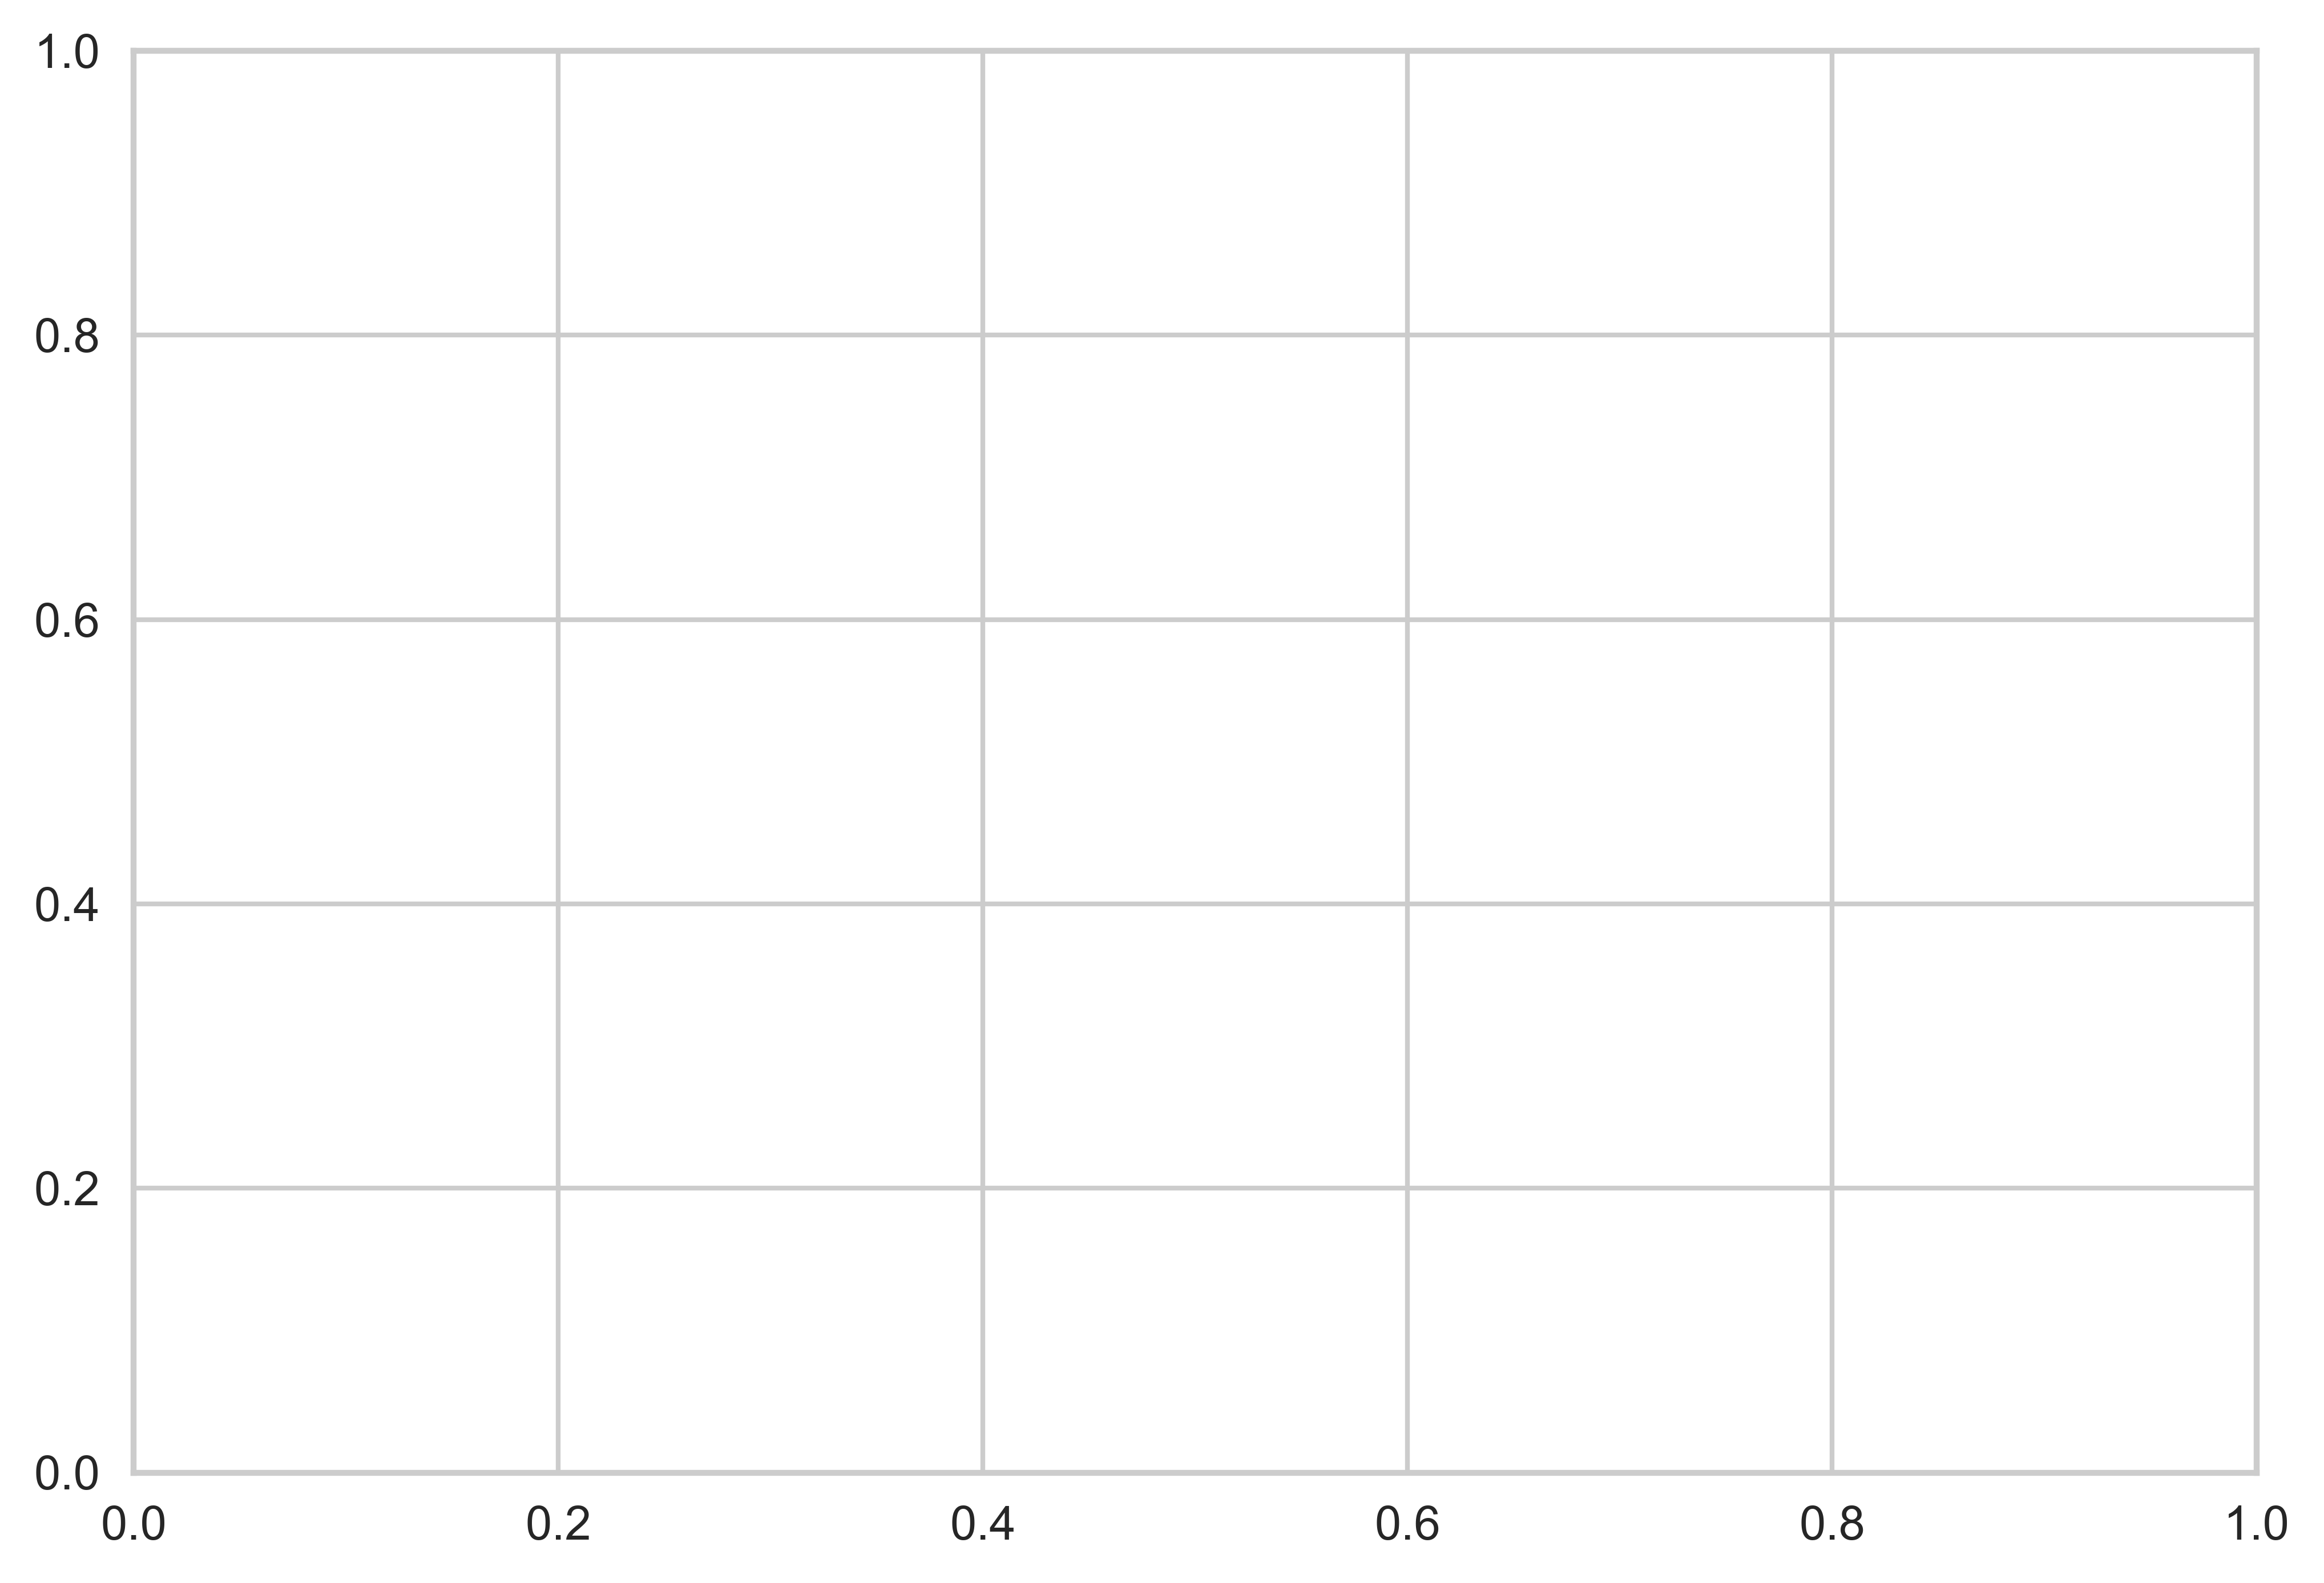

In [29]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve, RFECV
# Wrapper required for Catboost
from yellowbrick.contrib.wrapper import wrap, CLASSIFIER
clf = wrap(clf, CLASSIFIER)

plt.figure(dpi=600) #For publication only
sss.split(X, y)
sizes = np.linspace(0.3, 1.0, 10)
viz = LearningCurve(clf, cv=sss, scoring='f1_weighted', train_sizes=sizes, n_jobs=-1)
viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_learningcurve.png"))

<AxesSubplot:title={'center':'Validation Curve for AdaBoostClassifier'}, xlabel='n_estimators', ylabel='score'>

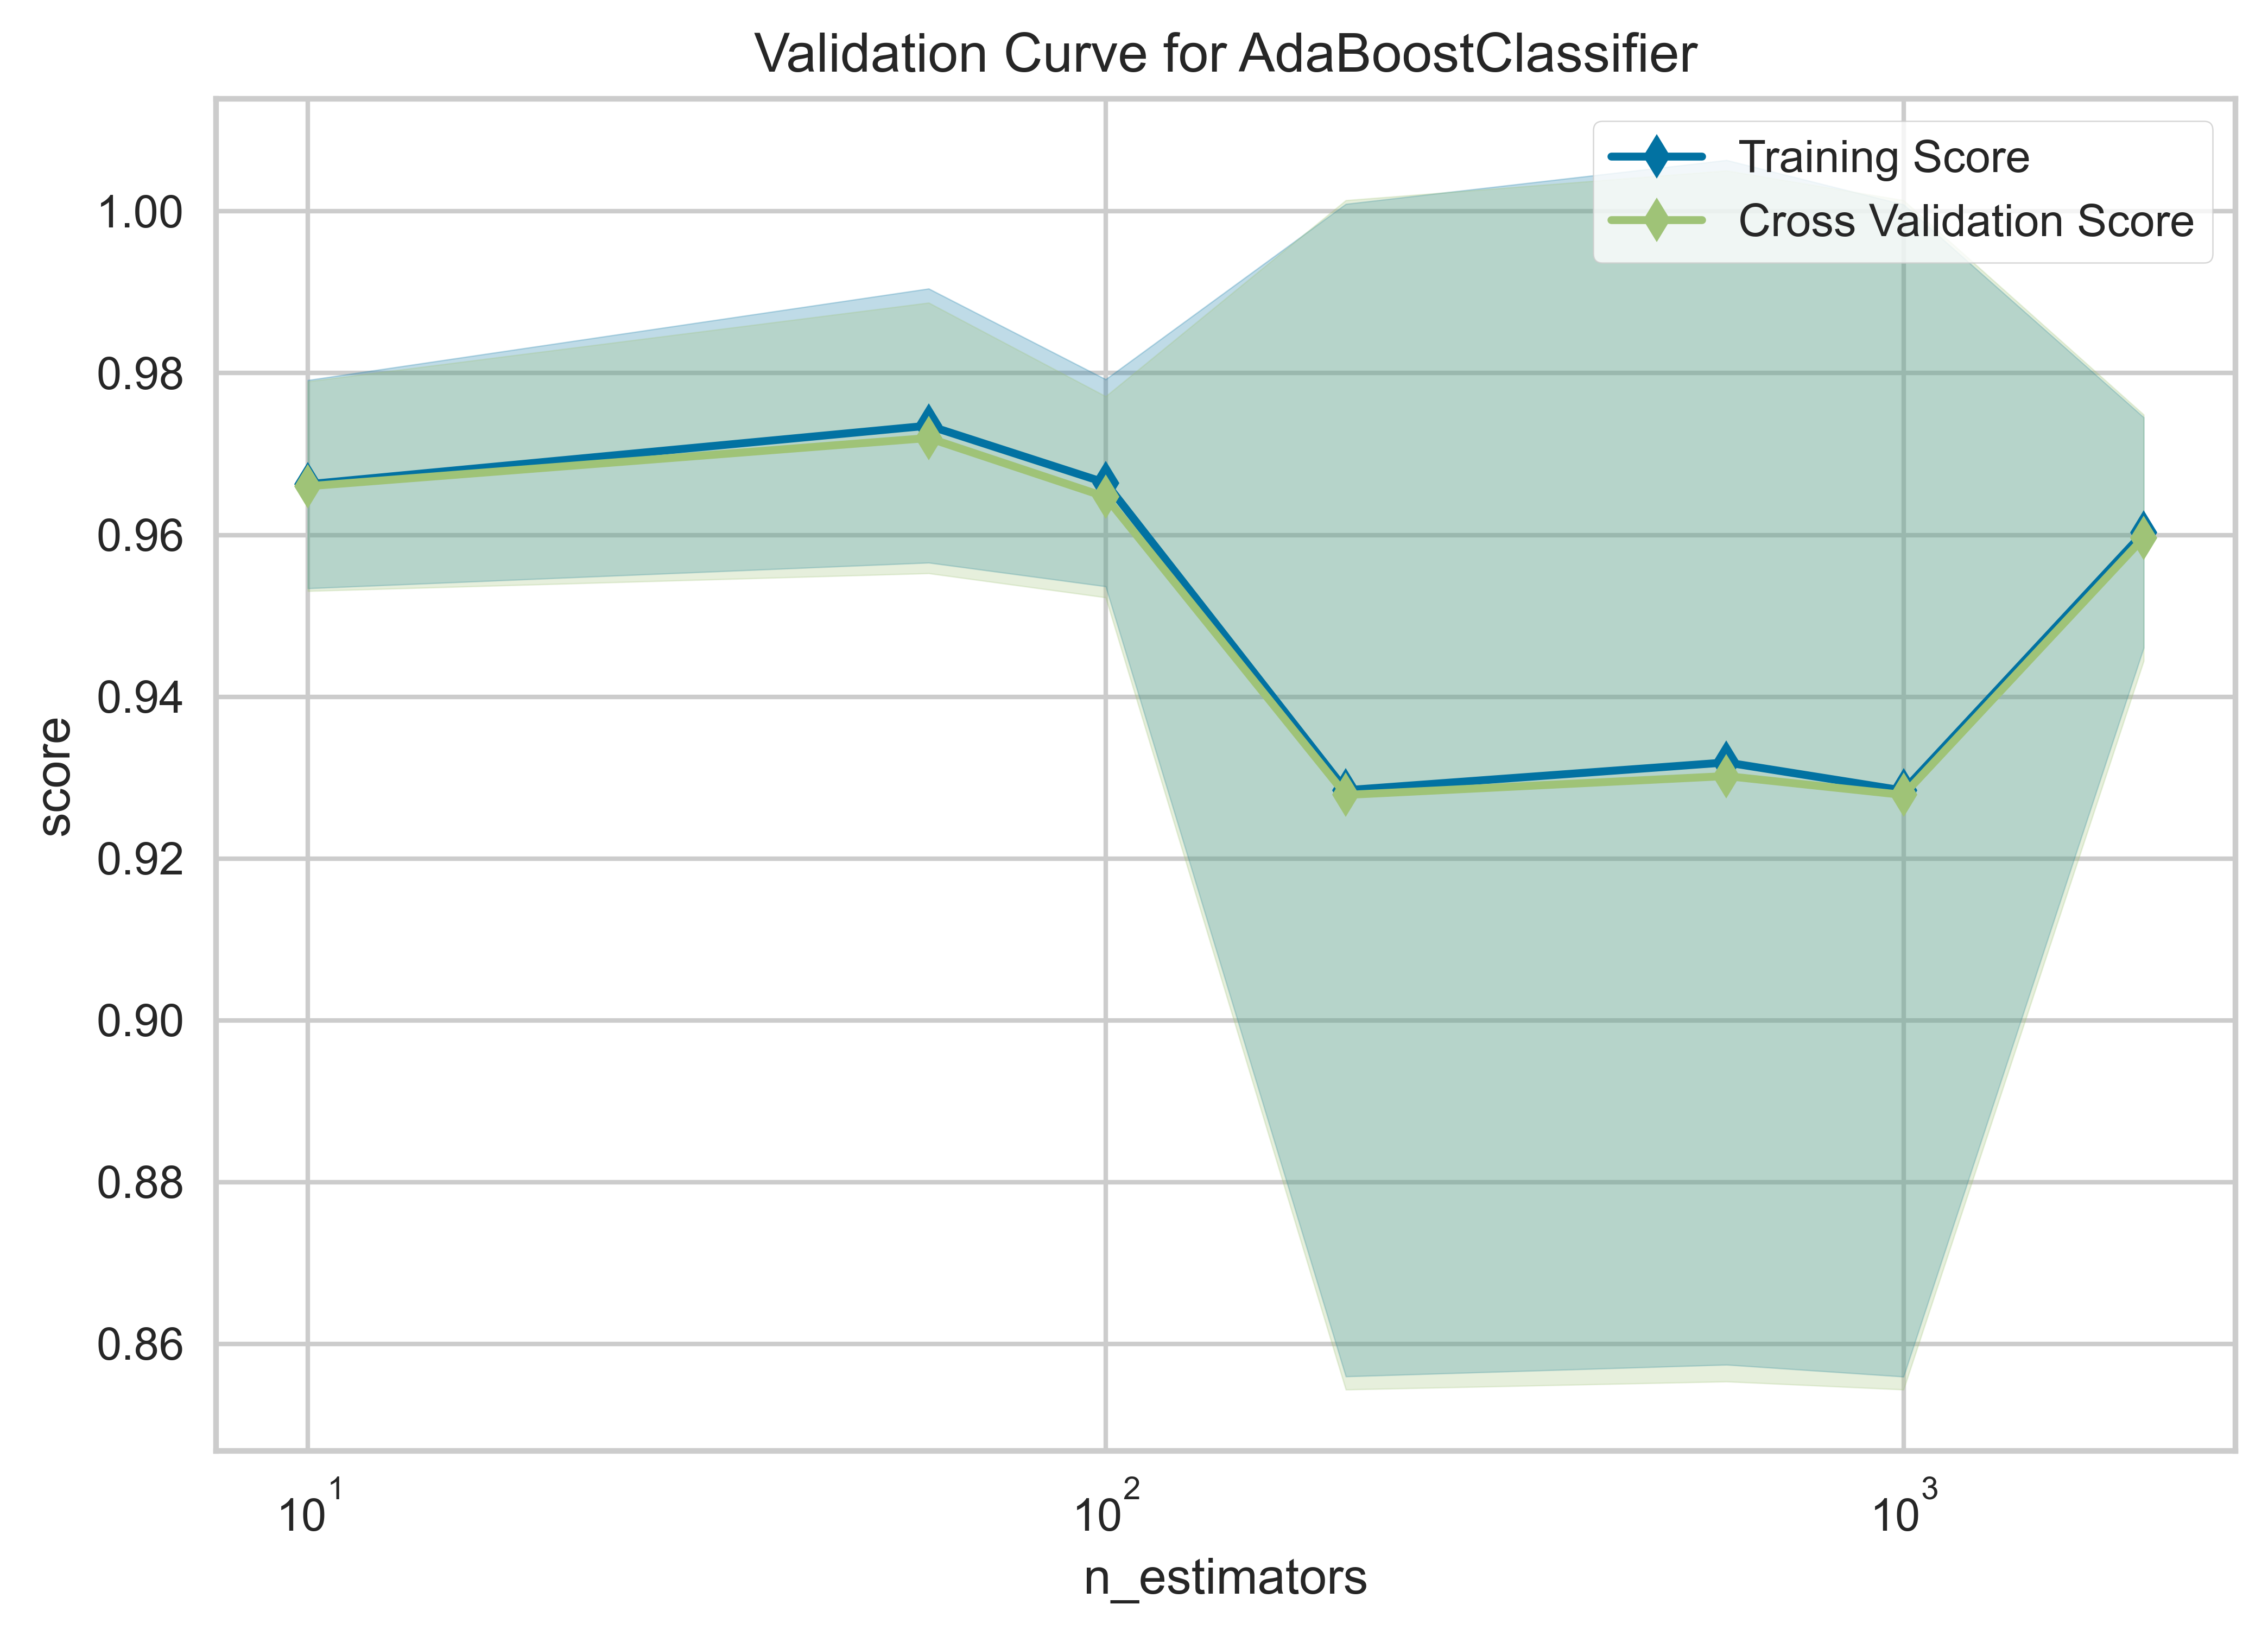

In [12]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [10, 60, 100, 200, 600, 1000, 2000]
plt.figure(dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="n_estimators", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_n_estimators_validationcurve.png"))
# viz.get_params()

In [37]:
# Print CV for validation curve
save_valid_curve_scores(viz,"n_estimators", param_range, "ml_method")

Fold0     Fold1     Fold2     Fold3     Fold4
10    0.965651  0.973618  0.976017  0.941079  0.973743
60    0.977311  0.973618  0.976017  0.941079  0.991893
100   0.965651  0.973618  0.976017  0.941079  0.967157
200   0.965651  0.973618  0.976017  0.941079  0.782914
600   0.977311  0.973618  0.976017  0.941079  0.782914
1000  0.965651  0.973618  0.976017  0.941079  0.782914
2000  0.965651  0.973618  0.976017  0.941079  0.941911

<AxesSubplot:title={'center':'Validation Curve for AdaBoostClassifier'}, xlabel='learning_rate', ylabel='score'>

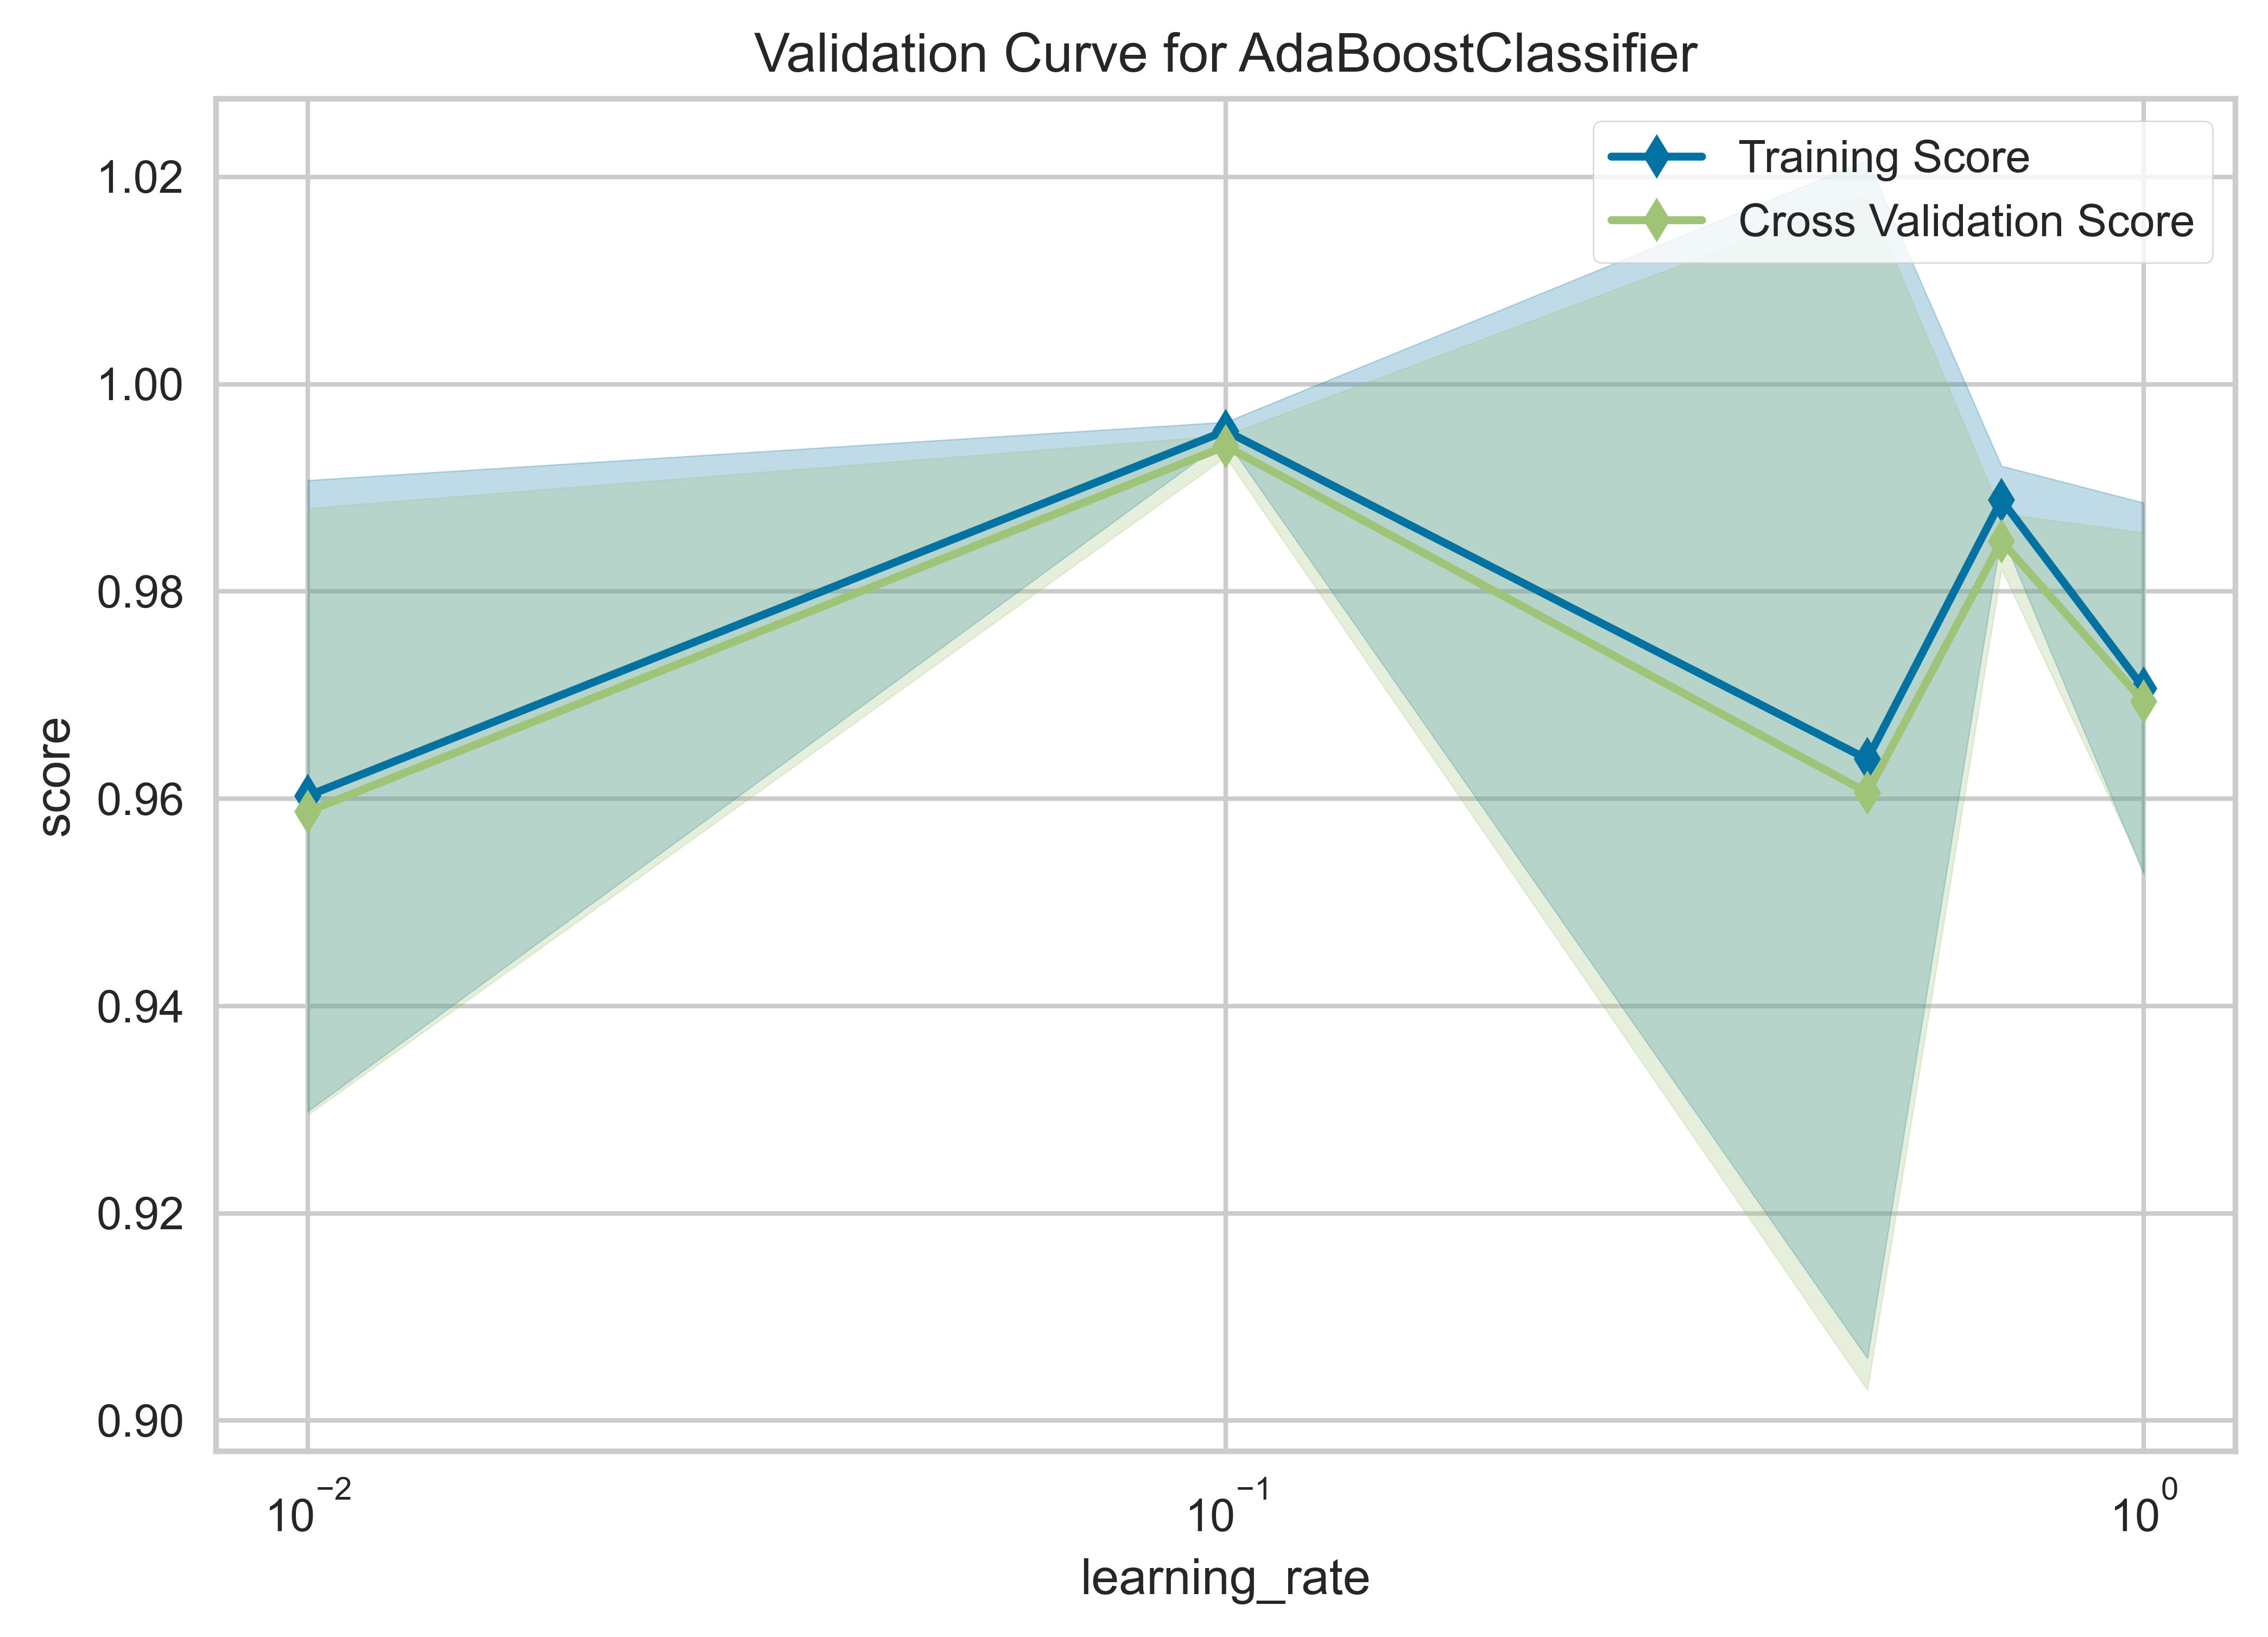

In [40]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [0.01, 0.1, 0.5, 0.7, 1.]
plt.figure(dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="learning_rate", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_learning_rate_validationcurve.png"))
# viz.get_params()

In [41]:
# Print CV for validation curve
save_valid_curve_scores(viz,"learning_rate", param_range, "ml_method")

Fold0     Fold1     Fold2     Fold3     Fold4
0.01  0.992620  0.927342  0.990319  0.958727  0.924835
0.10  0.994024  0.994694  0.994735  0.994644  0.992008
0.50  0.995523  0.992314  0.845668  0.987407  0.982061
0.70  0.986895  0.984615  0.982711  0.981338  0.988691
1.00  0.965651  0.973618  0.976017  0.941079  0.990557

<AxesSubplot:title={'center':'Validation Curve for AdaBoostClassifier'}, xlabel='algorithm', ylabel='score'>

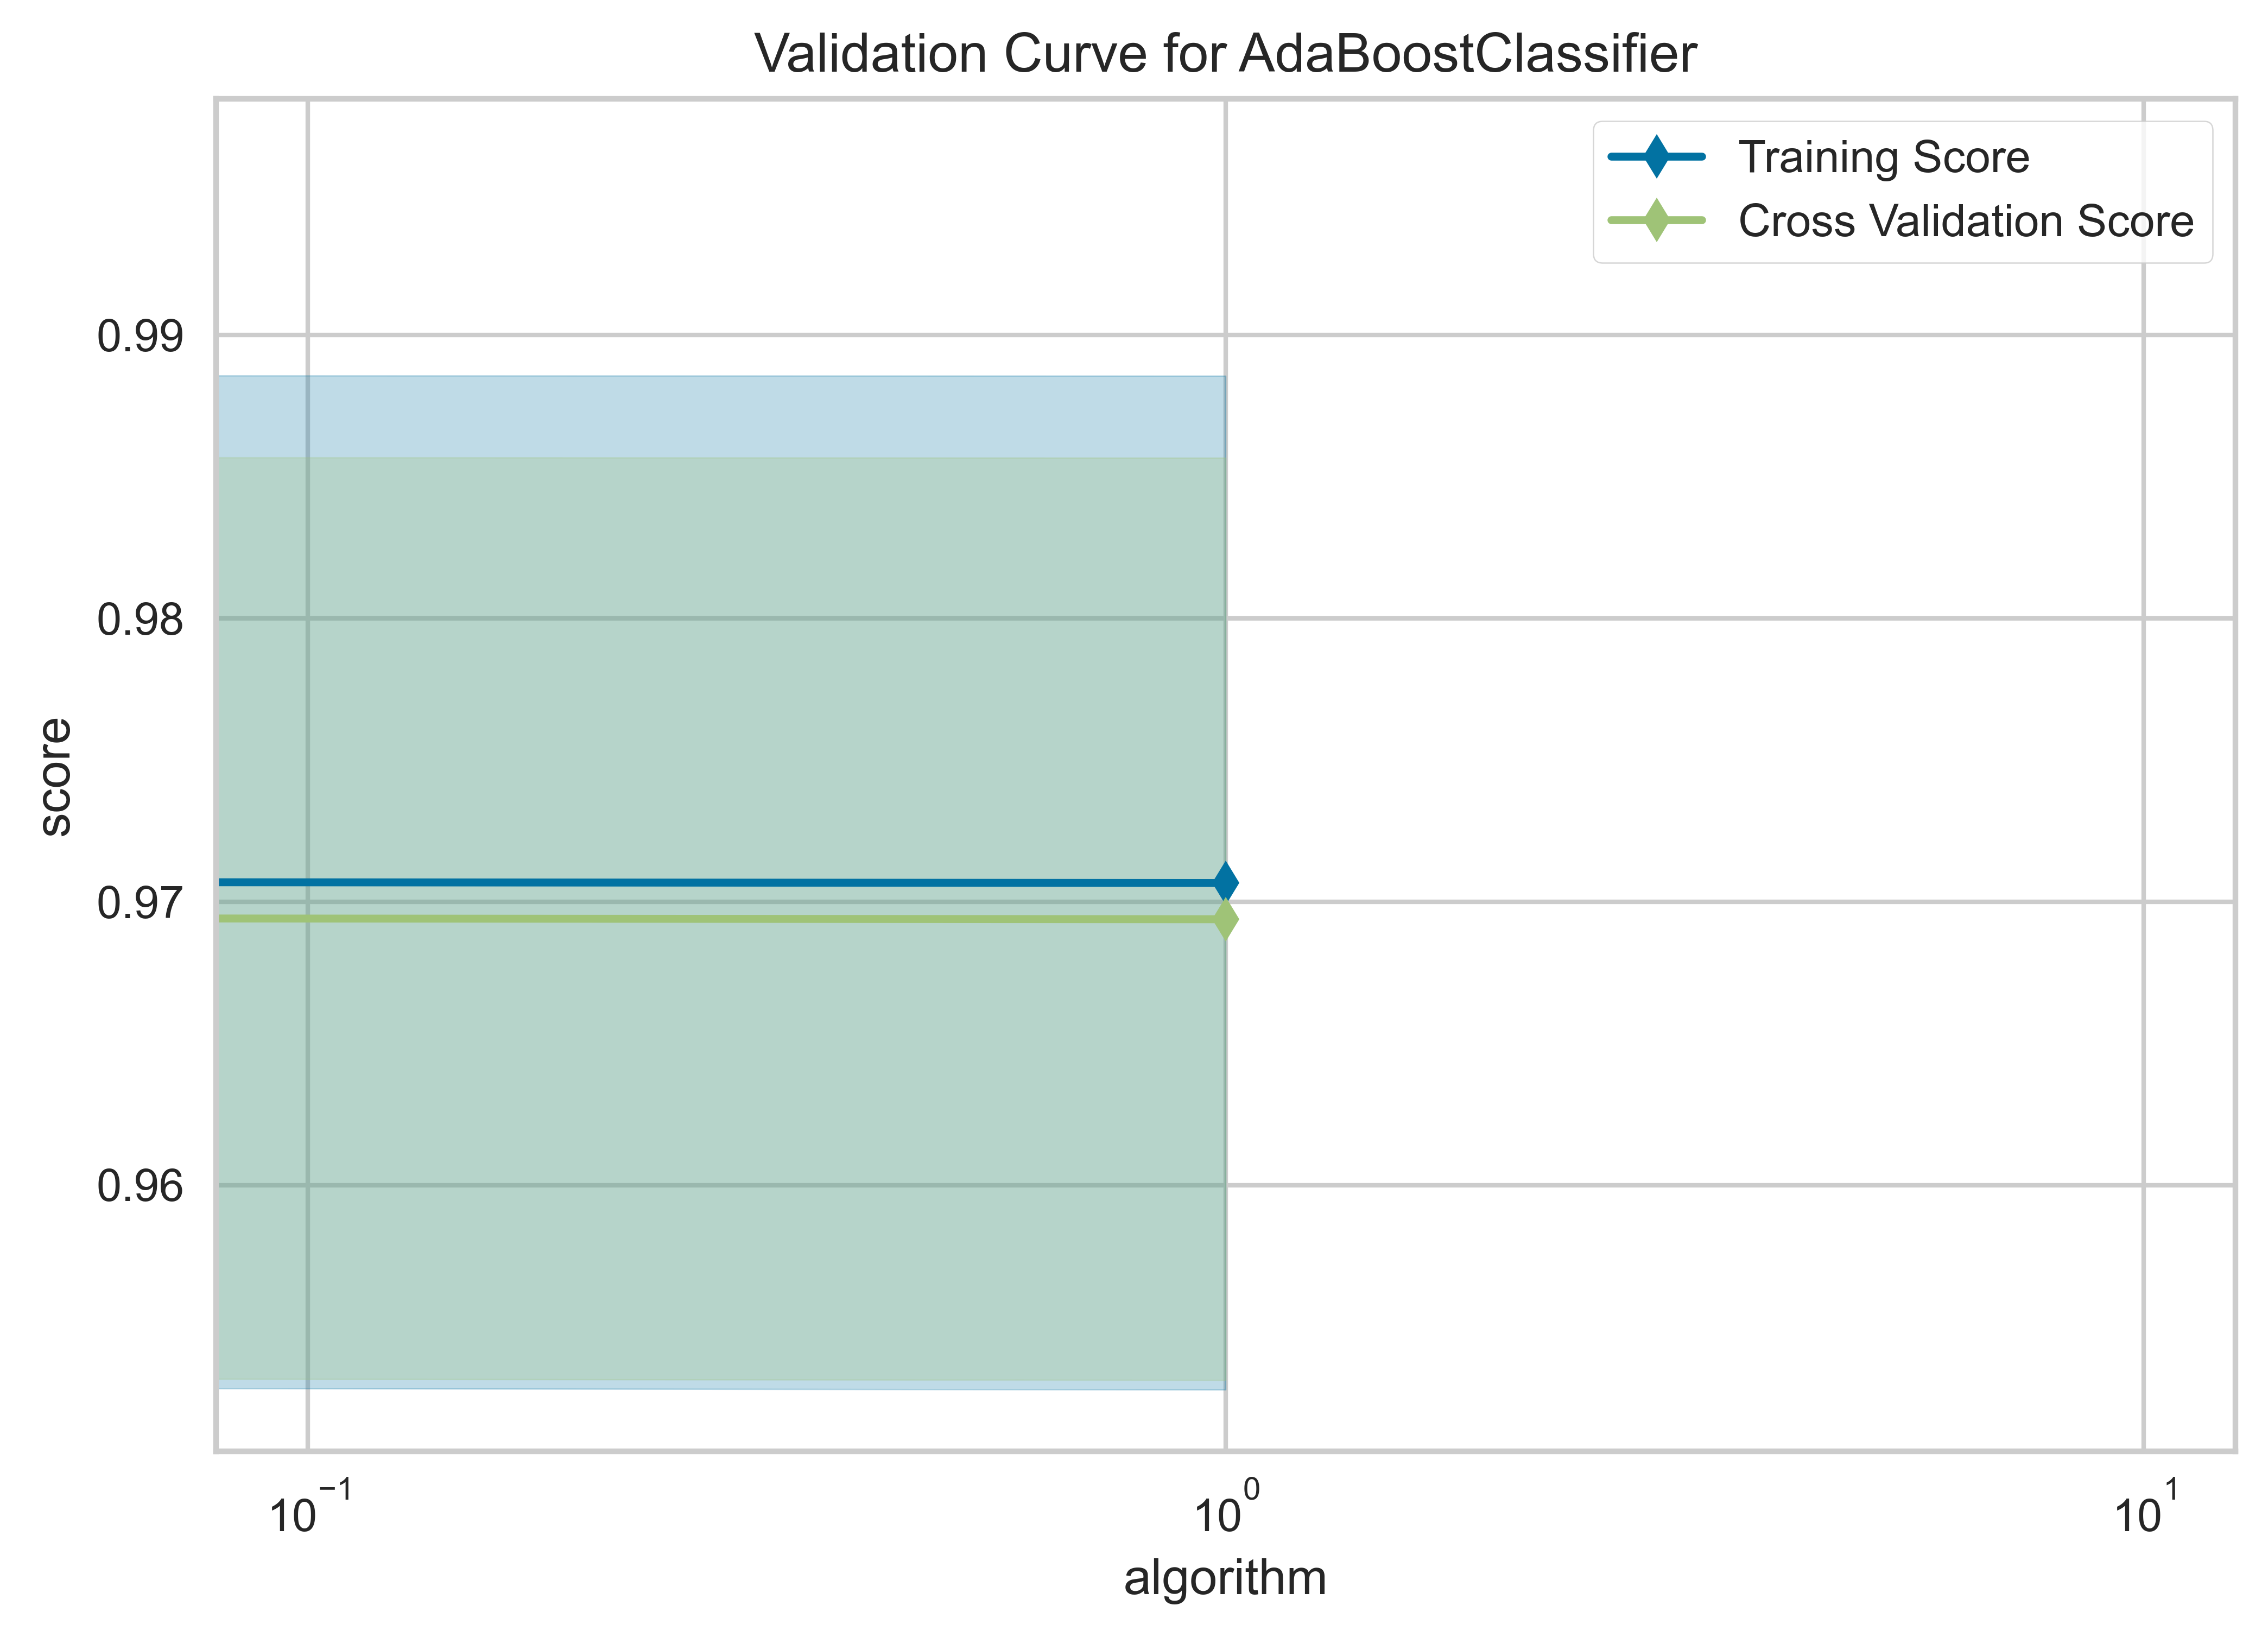

In [43]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = ["SAMME", "SAMME.R"]
plt.figure(dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="algorithm", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_algorithm_validationcurve.png"))
# viz.get_params()

In [44]:
# Print CV for validation curve
save_valid_curve_scores(viz,"algorithm", param_range, "ml_method")

Fold0     Fold1     Fold2     Fold3     Fold4
SAMME    0.993308  0.996213  0.990314  0.992441  0.991878
SAMME.R  0.965651  0.973618  0.976017  0.941079  0.990557

<AxesSubplot:title={'center':'RFECV for AdaBoostClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

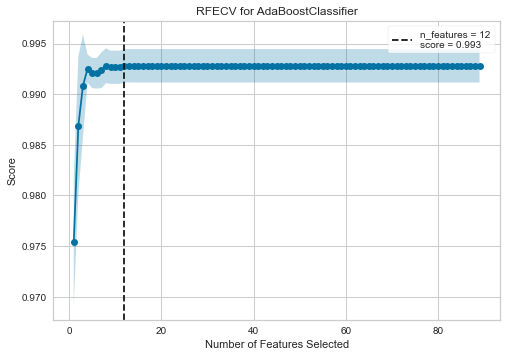

In [13]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve, RFECV

plt.figure(dpi=600) #For publication only
#had to remove max feature 50 to high
params_2 =  {"n_estimators": 200,
          "learning_rate": 0.1,
          "algorithm": "SAMME",
          "random_state": 42}

clf_2 = AdaBoostClassifier(**params_2)
viz = RFECV(clf_2, cv=sss, scoring="f1_weighted")

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_recursivefeatureelimination.png"))

In [42]:
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC
from yellowbrick.contrib.wrapper import wrap, CLASSIFIER

plt.figure(dpi=600) #For publication only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
clf_w = wrap(clf_2, CLASSIFIER)
viz = PrecisionRecallCurve(clf_w, per_class=True, cmap="Set1", classes=definitions)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_precisionrecallcurve.png"))

TypeError: __init__() got an unexpected keyword argument 'iterations'

<Figure size 4800x3300 with 0 Axes>

In [39]:
viz = PrecisionRecallCurve(
    clf_2,
    classes=definitions,
    colors=["purple", "cyan", "blue", "red", "green"],
    iso_f1_curves=True,
    per_class=True,
    micro=False
)
plt.figure(dpi=600) #For publication only
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_learningcurve_pretty.png"))

NameError: name 'PrecisionRecallCurve' is not defined

<AxesSubplot:title={'center':'ROC Curves for AdaBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

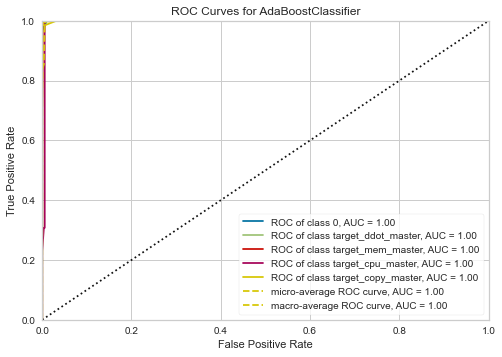

In [16]:
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC

plt.figure(figsize=(10,20), dpi=600) #For publication only
viz = ROCAUC(clf, classes=definitions)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_ROCAUC.png"))

Scoring on holdout or other dataset

In [17]:
def compare_to_holdout(df_data,
                       model,
                       definitions,
                       scaler=None,
                       clean=False,
                       prefix='rf_holdout'):
    #Creating the dependent variable class
    factor_h = pd.factorize(df_data['target'])
    df_data.target = factor_h[0]
    definitions_test_data = factor_h[1]
    print("Splitting dataset into data and ground truth ...")
    X_h = df_data.drop('target', axis=1)
    y_h = df_data['target']
    # Scale same as original dataset
    if scaler is None:
        scaler = MinMaxScaler()
    X_h = scaler.fit_transform(X_h)  # scaler only used on a per fold basis may cause error on entire dataset.
    # Select model from split to be tested
    y_pred_h = model.predict(X_h)


    # Recompute custom definitions in case of mismath
    if len(list(np.unique(y_pred_h))) != len(definitions) and clean:
        print(f"Prediction contains the following classes: {list(np.unique(y_pred_h))}")
        target_names = []
        for t in list(np.unique(y_pred_h)):
            target_names.append(definitions[t])
        print(f"Mapped to: {target_names}")
    else:
        target_names = definitions
    # print(classification_report(y_h, y_pred_h, target_names=target_names))
    # print(classification_report(y_h, y_pred_h, target_names=target_names))
    # print(classification_report_imbalanced(y_h, y_pred_h), target_names=list(np.unique(y_pred_h)))
    custom_scoring_reporting(y_pred_h, y_h, definitions=target_names, prefix=prefix)

    print(f"Instances predicted by class:")
    print(f"{df_data}")
    if clean:
        cls, count =  np.unique(y_pred_h, return_counts=True)
    else:
        count = np.bincount(y_pred_h)
    print(pd.DataFrame({"Classes": target_names, "Predictions": count}))


    print("Generating confusion matrix for holdout")
    cf_matrix = confusion_matrix(y_h, y_pred_h)
    # plt.figure(figsize=(10,20), dpi=600) For publication only
    ht_cf=sns.heatmap(cf_matrix, annot=True, yticklabels=list(target_names), xticklabels=list(target_names))
    plt.title('Confusion Matrix Holdout set', fontsize = 15) # title with fontsize 20
    plt.xlabel('Ground Truth', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('Predictions', fontsize = 10) # y-axis label with fontsize 15
    cf_fig = "CM_{}_{}.png".format(ml_method, prefix)
    ht_cf.figure.savefig(os.path.join(model_dir, cf_fig))
    plt.show()
    return y_pred_h, y_h.values, target_names

In [ ]:
prefix_name = "ada_holdout"

y_pred_h, y_h , target_names = compare_to_holdout(df_audsome,  clf_models[0], definitions=definitions, clean=False, prefix=prefix_name)